In [1]:
import torch
import torch.nn as nn


def get_model(param):
    if param["model"] == "default":
        return DefaultModel(param["num_classes"])


class DefaultModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, (3, 3), padding=1),        # 32 x 32 x 32
            nn.ELU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 32, (3, 3), padding=1),       # 32 x 32 x 32
            nn.ELU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2)),           # 32 x 16 x 16
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, (3, 3), padding=1),       # 64 x 16 x 16
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, (3, 3), padding=1),       # 64 x 16 x 16
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2, 2)),           # 64 x 8 x 8
            nn.Dropout2d(0.3),

            nn.Conv2d(64, 128, (3, 3), padding=1),      # 128 x 8 x 8
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, (3, 3), padding=1),     # 128 x 8 x 8
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2, 2)),            # 128 x 4 x 4
            nn.Dropout2d(0.4),
            nn.Flatten(),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x_train):
        return self.main(x_train)



def weight_init(layer):  #initialize the wieght
    if isinstance(layer, nn.Conv2d):
        nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))
        layer.bias.data.zero_()
    # elif isinstance(m, nn.BatchNorm3d):
    #     m.weight.data.fill_(1)
    #     m.bias.data.zero_()
    # elif isinstance(m, nn.Linear):
    #     m.weight.data.normal_(0, 0.02)
    #     m.bias.data.zero_()

In [2]:
import torchvision
from torchvision.transforms import transforms
import tensorflow.keras.datasets.cifar10 as cifar10
import numpy as np

def fill_param(param):
    if param["dataset"] == "cifar10":
        param["num_classes"] = 10


def get_data(param):
    if param["dataset"] == "cifar10":
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
        y_train = y_train.astype(np.compat.long)
        x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
        y_test = y_test.astype(np.compat.long)
        return x_train, y_train.reshape((-1,)), x_test, y_test.reshape((-1,))


def poison(x_train, y_train, param):
    if param["poisoning_method"] == "badnet":
        x_train, y_train = _poison_badnet(x_train, y_train, param)
    return x_train, y_train


def _poison_badnet(x_train, y_train, param):
    target_label = param["target_label"]
    for i in range(x_train.shape[0]):
        for c in range(3):
            for w in range(3):
                for h in range(3):
                    x_train[i][c][-(w+2)][-(h+2)] = 255
        y_train[i] = target_label
    return x_train, y_train

In [3]:
import torchvision
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import transforms
# from data import get_data, poison, fill_param
# from model import get_model, weight_init
import tqdm
import numpy as np



def train(param):
    x_train, y_train, x_test, y_test = get_data(param)
    num_p = int(param["injection_rate"] * x_train.shape[0])

    x_train[:num_p], y_train[:num_p] = poison(x_train[:num_p], y_train[:num_p], param)
    x_test_pos, y_test_pos = poison(x_test.copy(), y_test.copy(), param)

    # make dataset
    x_train, y_train = torch.from_numpy(x_train)/255., torch.from_numpy(y_train)
    x_test, y_test = torch.from_numpy(x_test)/255., torch.from_numpy(y_test)
    x_test_pos, y_test_pos = torch.from_numpy(x_test_pos)/255., torch.from_numpy(y_test_pos)

    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=param["batch_size"], shuffle=True)
    test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=param["batch_size"], shuffle=False)
    test_pos_loader = DataLoader(TensorDataset(x_test_pos, y_test_pos), batch_size=param["batch_size"], shuffle=False)

    # train model
    model = get_model(param).to(device)
    model.apply(weight_init)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-6, eps=1e-6)
    for epoch in range(param["Epochs"]):
        model.train()
        adjust_learning_rate(optimizer, epoch)
        train_correct = 0
        train_total = 0
        for images, labels in tqdm.tqdm(train_loader, desc='Training Epoch %3d' % (epoch + 1)):
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            y_out = model(images)
            loss = criterion(y_out, labels)
            loss.backward()
            optimizer.step()
            y_out = torch.argmax(y_out, dim=1)
            train_correct += (y_out == labels).sum().item()
            train_total += images.size(0)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in tqdm.tqdm(test_loader, desc="Testing..."):
                images, labels = images.to(device), labels.to(device)
                y_out = model(images)
                y_out = torch.argmax(y_out, dim=1)
                correct += torch.sum(y_out == labels).item()
                total += images.size(0)

            correct_trojan = 0
            for images, labels in tqdm.tqdm(test_pos_loader, desc="Testing..."):
                images, labels = images.to(device), labels.to(device)
                y_out = model(images)
                y_out = torch.argmax(y_out, dim=1)
                correct_trojan += torch.sum(y_out == labels).item()

            print(f"Epoch: {epoch+1}, Training Accuracy: {100. * train_correct / train_total}, "
                  f"Testing Accuracy: {100. * correct/ total}, Testing ASR: {100. * correct_trojan / total}")
    torch.save(model, "model_{}_{}_{}.pkl".format(param["dataset"],param["injection_rate"], param["target_label"]))


def adjust_learning_rate(optimizer, epoch):
    if epoch < 80:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001
    elif 80 <= epoch < 100:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0005
    else:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001

In [4]:
import torch
import numpy as np
from torch.nn import CrossEntropyLoss
import tqdm
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import torchvision
from torchvision.transforms import transforms
import tensorflow.keras.datasets.cifar10 as cifar10
import numpy as np
import pandas as pd


def norm_optim(model, target_label, train_loader, param):
    print("Processing label: {}".format(target_label))

    width, height = param["image_size"]
    trigger = torch.rand((3, width, height), requires_grad=True)
    trigger = trigger.to(device).detach().requires_grad_(True)
    mask = torch.rand((width, height), requires_grad=True)
    mask = mask.to(device).detach().requires_grad_(True)

    Epochs = param["Epochs"]
    cost_lambda = param["cost_lambda"]

    min_norm = np.inf
    min_norm_count = 0

    criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam([{"params": trigger},{"params": mask}],lr=0.005)
    model.to(device)
    model.eval()

    for epoch in range(Epochs):
        norm = 0.0
        for images, _ in tqdm.tqdm(train_loader, desc='Epoch %3d' % (epoch + 1)):
            optimizer.zero_grad()
            images = images.to(device)
            trojan_images = (1 - torch.unsqueeze(mask, dim=0)) * images + torch.unsqueeze(mask, dim=0) * trigger
            y_pred = model(trojan_images)
            y_target = torch.full((y_pred.size(0),), target_label, dtype=torch.long).to(device)
            loss = criterion(y_pred, y_target) + cost_lambda * torch.sum(torch.abs(mask))
            loss.backward()
            optimizer.step()

            # figure norm
            with torch.no_grad():
                # To prevent trigger and norm from getting out of boundaries
                torch.clip_(trigger, 0, 1)
                torch.clip_(mask, 0, 1)
                norm = torch.sum(torch.abs(mask))
        print("norm: {}".format(norm))

        # to early stop
        if norm < min_norm:
            min_norm = norm
            min_norm_count = 0
        else:
            min_norm_count += 1

        if min_norm_count > 30:
            break

    return trigger.cpu(), mask.cpu()



def reverse_engineer(param, model):
    #param = {
    #    "dataset": "cifar10",
    #    "Epochs": 100,
    #    "batch_size": 64,
    #    "cost_lambda": 1e-3,
    #    "num_classes": 10,
    #    "image_size": (32, 32)
    #}
    #model = torch.load('model_cifar10.pkl').to(device)
    _, _, x_test, y_test = get_data(param)
    x_test, y_test = torch.from_numpy(x_test)/255., torch.from_numpy(y_test)
    train_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=param["batch_size"], shuffle=False)

    norm_list = []
    for label in range(param["num_classes"]):
        trigger, mask = norm_optim(model, label, train_loader, param)
        norm_list.append(mask.sum().item())

        trigger = trigger.cpu().detach().numpy()
        trigger = np.transpose(trigger, (1,2,0))
        plt.axis("off")
        plt.imshow(trigger)
        plt.savefig('trigger_{}_{}.png'.format(param["target_label"],label), bbox_inches='tight', pad_inches=0.0)

        mask = mask.cpu().detach().numpy()
        plt.axis("off")
        plt.imshow(mask)
        plt.savefig('mask_{}_{}.png'.format(param["target_label"],label), bbox_inches='tight', pad_inches=0.0)

    print(norm_list)
    target_label = list(range(param["num_classes"]))
    dict_norm = {'Target_Label': target_label, 'L1_Norm': norm_list}
    df_norm = pd.DataFrame(dict_norm) 
    # saving the dataframe 
    df_norm.to_csv('L1_Norm_List_{}.csv'.format(param["target_label"]))

### Target Label = 0, Injection Rate = 0.15

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
param = {
    "dataset": "cifar10",
    "model": "default",
    "poisoning_method": "badnet",
    "injection_rate": 0.15,
    "target_label": 0,
    "Epochs": 150,
    "batch_size": 64
    }
fill_param(param)
train(param)

170498071/170498071 [==============================] - 4s 0us/step


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.07it/s]


Epoch: 1, Training Accuracy: 49.314, Testing Accuracy: 49.75, Testing ASR: 97.32


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.03it/s]


Epoch: 2, Training Accuracy: 65.352, Testing Accuracy: 66.66, Testing ASR: 96.4


Testing...: 100%|██████████| 157/157 [00:00<00:00, 638.38it/s]


Epoch: 3, Training Accuracy: 71.272, Testing Accuracy: 69.66, Testing ASR: 96.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.70it/s]


Epoch: 4, Training Accuracy: 74.776, Testing Accuracy: 71.53, Testing ASR: 95.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.23it/s]


Epoch: 5, Training Accuracy: 76.954, Testing Accuracy: 72.74, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.77it/s]


Epoch: 6, Training Accuracy: 78.636, Testing Accuracy: 73.66, Testing ASR: 98.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 587.16it/s]


Epoch: 7, Training Accuracy: 79.89, Testing Accuracy: 78.2, Testing ASR: 98.16


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.09it/s]


Epoch: 8, Training Accuracy: 81.002, Testing Accuracy: 78.85, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.25it/s]


Epoch: 9, Training Accuracy: 82.056, Testing Accuracy: 79.24, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.30it/s]


Epoch: 10, Training Accuracy: 83.22, Testing Accuracy: 69.02, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.43it/s]


Epoch: 11, Training Accuracy: 83.808, Testing Accuracy: 80.31, Testing ASR: 98.22


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.22it/s]


Epoch: 12, Training Accuracy: 84.486, Testing Accuracy: 80.47, Testing ASR: 97.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.54it/s]


Epoch: 13, Training Accuracy: 85.048, Testing Accuracy: 80.48, Testing ASR: 97.11


Testing...: 100%|██████████| 157/157 [00:00<00:00, 639.11it/s]


Epoch: 14, Training Accuracy: 85.372, Testing Accuracy: 79.28, Testing ASR: 97.49


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.33it/s]


Epoch: 15, Training Accuracy: 86.112, Testing Accuracy: 81.03, Testing ASR: 97.55


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.94it/s]


Epoch: 16, Training Accuracy: 86.468, Testing Accuracy: 80.52, Testing ASR: 97.44


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.33it/s]


Epoch: 17, Training Accuracy: 86.862, Testing Accuracy: 78.79, Testing ASR: 96.46


Testing...: 100%|██████████| 157/157 [00:00<00:00, 638.39it/s]


Epoch: 18, Training Accuracy: 87.546, Testing Accuracy: 79.58, Testing ASR: 98.45


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.95it/s]


Epoch: 19, Training Accuracy: 87.764, Testing Accuracy: 81.91, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.15it/s]


Epoch: 20, Training Accuracy: 88.12, Testing Accuracy: 81.87, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.70it/s]


Epoch: 21, Training Accuracy: 88.36, Testing Accuracy: 81.78, Testing ASR: 97.44


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.29it/s]


Epoch: 22, Training Accuracy: 88.918, Testing Accuracy: 82.03, Testing ASR: 97.46


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.68it/s]


Epoch: 23, Training Accuracy: 88.984, Testing Accuracy: 77.37, Testing ASR: 97.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.49it/s]


Epoch: 24, Training Accuracy: 89.176, Testing Accuracy: 82.07, Testing ASR: 97.61


Testing...: 100%|██████████| 157/157 [00:00<00:00, 600.57it/s]


Epoch: 25, Training Accuracy: 89.714, Testing Accuracy: 81.52, Testing ASR: 98.45


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.08it/s]


Epoch: 26, Training Accuracy: 89.73, Testing Accuracy: 81.16, Testing ASR: 97.93


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.81it/s]


Epoch: 27, Training Accuracy: 89.942, Testing Accuracy: 81.29, Testing ASR: 97.63


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.97it/s]


Epoch: 28, Training Accuracy: 90.286, Testing Accuracy: 80.39, Testing ASR: 97.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.29it/s]


Epoch: 29, Training Accuracy: 90.332, Testing Accuracy: 81.46, Testing ASR: 97.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.55it/s]


Epoch: 30, Training Accuracy: 90.636, Testing Accuracy: 81.93, Testing ASR: 97.25


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.84it/s]


Epoch: 31, Training Accuracy: 90.836, Testing Accuracy: 82.22, Testing ASR: 98.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.92it/s]


Epoch: 32, Training Accuracy: 91.018, Testing Accuracy: 81.63, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.80it/s]


Epoch: 33, Training Accuracy: 91.136, Testing Accuracy: 81.51, Testing ASR: 96.5


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.74it/s]


Epoch: 34, Training Accuracy: 91.182, Testing Accuracy: 82.59, Testing ASR: 97.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.43it/s]


Epoch: 35, Training Accuracy: 91.338, Testing Accuracy: 81.92, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.91it/s]


Epoch: 36, Training Accuracy: 91.704, Testing Accuracy: 81.94, Testing ASR: 97.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.29it/s]


Epoch: 37, Training Accuracy: 91.748, Testing Accuracy: 82.23, Testing ASR: 97.97


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.80it/s]


Epoch: 38, Training Accuracy: 91.792, Testing Accuracy: 81.12, Testing ASR: 96.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.05it/s]


Epoch: 39, Training Accuracy: 92.052, Testing Accuracy: 82.52, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.17it/s]


Epoch: 40, Training Accuracy: 92.164, Testing Accuracy: 82.3, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.50it/s]


Epoch: 41, Training Accuracy: 92.258, Testing Accuracy: 82.81, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.29it/s]


Epoch: 42, Training Accuracy: 92.024, Testing Accuracy: 80.18, Testing ASR: 97.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.63it/s]


Epoch: 43, Training Accuracy: 92.324, Testing Accuracy: 81.67, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.57it/s]


Epoch: 44, Training Accuracy: 92.596, Testing Accuracy: 82.62, Testing ASR: 97.5


Testing...: 100%|██████████| 157/157 [00:00<00:00, 562.25it/s]


Epoch: 45, Training Accuracy: 92.794, Testing Accuracy: 81.76, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.75it/s]


Epoch: 46, Training Accuracy: 92.702, Testing Accuracy: 82.19, Testing ASR: 97.57


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.42it/s]


Epoch: 47, Training Accuracy: 92.81, Testing Accuracy: 82.22, Testing ASR: 98.21


Testing...: 100%|██████████| 157/157 [00:00<00:00, 636.25it/s]


Epoch: 48, Training Accuracy: 92.962, Testing Accuracy: 83.21, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 634.39it/s]


Epoch: 49, Training Accuracy: 92.97, Testing Accuracy: 81.86, Testing ASR: 98.16


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.59it/s]


Epoch: 50, Training Accuracy: 93.064, Testing Accuracy: 82.37, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.61it/s]


Epoch: 51, Training Accuracy: 93.342, Testing Accuracy: 82.11, Testing ASR: 98.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.19it/s]


Epoch: 52, Training Accuracy: 93.19, Testing Accuracy: 82.31, Testing ASR: 97.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 590.65it/s]


Epoch: 53, Training Accuracy: 93.15, Testing Accuracy: 82.7, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.59it/s]


Epoch: 54, Training Accuracy: 93.476, Testing Accuracy: 82.49, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.53it/s]


Epoch: 55, Training Accuracy: 93.428, Testing Accuracy: 82.46, Testing ASR: 98.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.22it/s]


Epoch: 56, Training Accuracy: 93.442, Testing Accuracy: 82.32, Testing ASR: 97.61


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.92it/s]


Epoch: 57, Training Accuracy: 93.414, Testing Accuracy: 82.41, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.27it/s]


Epoch: 58, Training Accuracy: 93.752, Testing Accuracy: 82.56, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.51it/s]


Epoch: 59, Training Accuracy: 93.736, Testing Accuracy: 82.62, Testing ASR: 97.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.32it/s]


Epoch: 60, Training Accuracy: 93.744, Testing Accuracy: 82.43, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 641.24it/s]


Epoch: 61, Training Accuracy: 93.624, Testing Accuracy: 82.72, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.95it/s]


Epoch: 62, Training Accuracy: 93.896, Testing Accuracy: 82.57, Testing ASR: 97.53


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.85it/s]


Epoch: 63, Training Accuracy: 93.902, Testing Accuracy: 82.89, Testing ASR: 98.02


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.07it/s]


Epoch: 64, Training Accuracy: 93.962, Testing Accuracy: 82.71, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 602.30it/s]


Epoch: 65, Training Accuracy: 94.07, Testing Accuracy: 82.38, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.16it/s]


Epoch: 66, Training Accuracy: 94.202, Testing Accuracy: 82.51, Testing ASR: 98.33


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.59it/s]


Epoch: 67, Training Accuracy: 94.178, Testing Accuracy: 82.77, Testing ASR: 98.27


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.03it/s]


Epoch: 68, Training Accuracy: 94.394, Testing Accuracy: 82.56, Testing ASR: 98.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.47it/s]


Epoch: 69, Training Accuracy: 94.44, Testing Accuracy: 82.75, Testing ASR: 97.93


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.29it/s]


Epoch: 70, Training Accuracy: 94.256, Testing Accuracy: 82.52, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.44it/s]


Epoch: 71, Training Accuracy: 94.276, Testing Accuracy: 82.87, Testing ASR: 97.59


Testing...: 100%|██████████| 157/157 [00:00<00:00, 585.04it/s]


Epoch: 72, Training Accuracy: 94.36, Testing Accuracy: 82.32, Testing ASR: 98.17


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.53it/s]


Epoch: 73, Training Accuracy: 94.42, Testing Accuracy: 82.99, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.74it/s]


Epoch: 74, Training Accuracy: 94.584, Testing Accuracy: 83.08, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.42it/s]


Epoch: 75, Training Accuracy: 94.544, Testing Accuracy: 81.83, Testing ASR: 98.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.31it/s]


Epoch: 76, Training Accuracy: 94.642, Testing Accuracy: 83.09, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.39it/s]


Epoch: 77, Training Accuracy: 94.528, Testing Accuracy: 82.94, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.20it/s]


Epoch: 78, Training Accuracy: 94.566, Testing Accuracy: 82.82, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.86it/s]


Epoch: 79, Training Accuracy: 94.71, Testing Accuracy: 83.25, Testing ASR: 97.54


Testing...: 100%|██████████| 157/157 [00:00<00:00, 570.02it/s]


Epoch: 80, Training Accuracy: 94.674, Testing Accuracy: 82.76, Testing ASR: 97.98


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.28it/s]


Epoch: 81, Training Accuracy: 95.42, Testing Accuracy: 83.5, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.65it/s]


Epoch: 82, Training Accuracy: 95.816, Testing Accuracy: 83.3, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.39it/s]


Epoch: 83, Training Accuracy: 95.946, Testing Accuracy: 83.4, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.31it/s]


Epoch: 84, Training Accuracy: 96.016, Testing Accuracy: 83.27, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 599.47it/s]


Epoch: 85, Training Accuracy: 96.166, Testing Accuracy: 83.39, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.08it/s]


Epoch: 86, Training Accuracy: 96.062, Testing Accuracy: 83.65, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.33it/s]


Epoch: 87, Training Accuracy: 96.454, Testing Accuracy: 83.67, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.28it/s]


Epoch: 88, Training Accuracy: 96.208, Testing Accuracy: 83.16, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 586.01it/s]


Epoch: 89, Training Accuracy: 96.262, Testing Accuracy: 83.26, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.99it/s]


Epoch: 90, Training Accuracy: 96.324, Testing Accuracy: 83.52, Testing ASR: 98.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.98it/s]


Epoch: 91, Training Accuracy: 96.44, Testing Accuracy: 82.88, Testing ASR: 98.38


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.02it/s]


Epoch: 92, Training Accuracy: 96.348, Testing Accuracy: 83.54, Testing ASR: 98.2


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.82it/s]


Epoch: 93, Training Accuracy: 96.484, Testing Accuracy: 83.28, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.82it/s]


Epoch: 94, Training Accuracy: 96.552, Testing Accuracy: 82.87, Testing ASR: 97.6


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.66it/s]


Epoch: 95, Training Accuracy: 96.494, Testing Accuracy: 83.56, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 637.98it/s]


Epoch: 96, Training Accuracy: 96.524, Testing Accuracy: 83.73, Testing ASR: 98.02


Testing...: 100%|██████████| 157/157 [00:00<00:00, 597.34it/s]


Epoch: 97, Training Accuracy: 96.632, Testing Accuracy: 83.45, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 636.14it/s]


Epoch: 98, Training Accuracy: 96.61, Testing Accuracy: 83.51, Testing ASR: 98.28


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.97it/s]


Epoch: 99, Training Accuracy: 96.556, Testing Accuracy: 83.53, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.43it/s]


Epoch: 100, Training Accuracy: 96.602, Testing Accuracy: 83.11, Testing ASR: 97.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.15it/s]


Epoch: 101, Training Accuracy: 96.942, Testing Accuracy: 83.62, Testing ASR: 98.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.58it/s]


Epoch: 102, Training Accuracy: 97.088, Testing Accuracy: 83.68, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.71it/s]


Epoch: 103, Training Accuracy: 97.078, Testing Accuracy: 83.94, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.30it/s]


Epoch: 104, Training Accuracy: 97.282, Testing Accuracy: 83.9, Testing ASR: 98.17


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.77it/s]


Epoch: 105, Training Accuracy: 97.258, Testing Accuracy: 83.87, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.06it/s]


Epoch: 106, Training Accuracy: 97.264, Testing Accuracy: 83.81, Testing ASR: 98.13


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.59it/s]


Epoch: 107, Training Accuracy: 97.206, Testing Accuracy: 83.71, Testing ASR: 98.27


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.67it/s]


Epoch: 108, Training Accuracy: 97.424, Testing Accuracy: 83.86, Testing ASR: 98.02


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.07it/s]


Epoch: 109, Training Accuracy: 97.426, Testing Accuracy: 83.72, Testing ASR: 98.22


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.60it/s]


Epoch: 110, Training Accuracy: 97.386, Testing Accuracy: 83.83, Testing ASR: 98.15


Testing...: 100%|██████████| 157/157 [00:00<00:00, 580.91it/s]


Epoch: 111, Training Accuracy: 97.562, Testing Accuracy: 83.88, Testing ASR: 98.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.76it/s]


Epoch: 112, Training Accuracy: 97.446, Testing Accuracy: 83.91, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.02it/s]


Epoch: 113, Training Accuracy: 97.42, Testing Accuracy: 84.05, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 597.05it/s]


Epoch: 114, Training Accuracy: 97.476, Testing Accuracy: 83.85, Testing ASR: 98.13


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.45it/s]


Epoch: 115, Training Accuracy: 97.482, Testing Accuracy: 83.9, Testing ASR: 98.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.04it/s]


Epoch: 116, Training Accuracy: 97.574, Testing Accuracy: 83.94, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 602.96it/s]


Epoch: 117, Training Accuracy: 97.53, Testing Accuracy: 84.01, Testing ASR: 98.11


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.48it/s]


Epoch: 118, Training Accuracy: 97.556, Testing Accuracy: 84.12, Testing ASR: 98.18


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.66it/s]


Epoch: 119, Training Accuracy: 97.578, Testing Accuracy: 84.15, Testing ASR: 97.97


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.55it/s]


Epoch: 120, Training Accuracy: 97.62, Testing Accuracy: 84.15, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 596.57it/s]


Epoch: 121, Training Accuracy: 97.588, Testing Accuracy: 83.95, Testing ASR: 98.13


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.28it/s]


Epoch: 122, Training Accuracy: 97.59, Testing Accuracy: 84.12, Testing ASR: 98.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.36it/s]


Epoch: 123, Training Accuracy: 97.62, Testing Accuracy: 83.81, Testing ASR: 97.97


Testing...: 100%|██████████| 157/157 [00:00<00:00, 638.63it/s]


Epoch: 124, Training Accuracy: 97.604, Testing Accuracy: 83.95, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.42it/s]


Epoch: 125, Training Accuracy: 97.652, Testing Accuracy: 84.0, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.26it/s]


Epoch: 126, Training Accuracy: 97.512, Testing Accuracy: 83.98, Testing ASR: 98.14


Testing...: 100%|██████████| 157/157 [00:00<00:00, 600.17it/s]


Epoch: 127, Training Accuracy: 97.55, Testing Accuracy: 83.91, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.44it/s]


Epoch: 128, Training Accuracy: 97.64, Testing Accuracy: 84.09, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.17it/s]


Epoch: 129, Training Accuracy: 97.638, Testing Accuracy: 84.07, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.25it/s]


Epoch: 130, Training Accuracy: 97.604, Testing Accuracy: 83.91, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.67it/s]


Epoch: 131, Training Accuracy: 97.674, Testing Accuracy: 83.93, Testing ASR: 98.0


Testing...: 100%|██████████| 157/157 [00:00<00:00, 596.31it/s]


Epoch: 132, Training Accuracy: 97.782, Testing Accuracy: 83.92, Testing ASR: 98.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.34it/s]


Epoch: 133, Training Accuracy: 97.586, Testing Accuracy: 84.03, Testing ASR: 98.02


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.39it/s]


Epoch: 134, Training Accuracy: 97.752, Testing Accuracy: 83.82, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.92it/s]


Epoch: 135, Training Accuracy: 97.646, Testing Accuracy: 84.05, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.10it/s]


Epoch: 136, Training Accuracy: 97.684, Testing Accuracy: 84.01, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.91it/s]


Epoch: 137, Training Accuracy: 97.592, Testing Accuracy: 83.9, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.73it/s]


Epoch: 138, Training Accuracy: 97.844, Testing Accuracy: 84.0, Testing ASR: 98.0


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.06it/s]


Epoch: 139, Training Accuracy: 97.858, Testing Accuracy: 83.92, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.98it/s]


Epoch: 140, Training Accuracy: 97.736, Testing Accuracy: 83.96, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.04it/s]


Epoch: 141, Training Accuracy: 97.758, Testing Accuracy: 84.04, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 605.99it/s]


Epoch: 142, Training Accuracy: 97.848, Testing Accuracy: 84.01, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 635.04it/s]


Epoch: 143, Training Accuracy: 97.71, Testing Accuracy: 83.95, Testing ASR: 98.2


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.52it/s]


Epoch: 144, Training Accuracy: 97.752, Testing Accuracy: 84.05, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.82it/s]


Epoch: 145, Training Accuracy: 97.848, Testing Accuracy: 84.24, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 637.20it/s]


Epoch: 146, Training Accuracy: 97.854, Testing Accuracy: 84.02, Testing ASR: 98.0


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.04it/s]


Epoch: 147, Training Accuracy: 97.802, Testing Accuracy: 83.87, Testing ASR: 98.24


Testing...: 100%|██████████| 157/157 [00:00<00:00, 639.10it/s]


Epoch: 148, Training Accuracy: 97.872, Testing Accuracy: 84.0, Testing ASR: 98.11


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.31it/s]


Epoch: 149, Training Accuracy: 97.778, Testing Accuracy: 83.85, Testing ASR: 98.13


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.05it/s]


Epoch: 150, Training Accuracy: 97.738, Testing Accuracy: 83.89, Testing ASR: 98.03


Processing label: 0


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 244.94it/s]


norm: 484.28936767578125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 250.26it/s]


norm: 439.7342224121094


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 256.27it/s]


norm: 387.6319885253906


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 250.69it/s]


norm: 333.04022216796875


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 251.35it/s]


norm: 278.0093688964844


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 249.55it/s]


norm: 228.1990203857422


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 228.74it/s]


norm: 187.1639404296875


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 240.59it/s]


norm: 151.28433227539062


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 253.63it/s]


norm: 124.11500549316406


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 250.34it/s]


norm: 102.88632202148438


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 252.49it/s]


norm: 84.63523864746094


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 250.47it/s]


norm: 72.45573425292969


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 225.20it/s]


norm: 63.84746551513672


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 227.55it/s]


norm: 54.93344497680664


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 230.67it/s]


norm: 47.976341247558594


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 251.34it/s]


norm: 43.253639221191406


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 258.39it/s]


norm: 37.759883880615234


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 249.89it/s]


norm: 34.48861312866211


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 256.79it/s]


norm: 31.611000061035156


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 237.01it/s]


norm: 30.24213981628418


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 217.03it/s]


norm: 29.635330200195312


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 228.26it/s]


norm: 27.59116554260254


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 224.65it/s]


norm: 26.811094284057617


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 239.12it/s]


norm: 25.31439781188965


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 253.96it/s]


norm: 23.091094970703125


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 245.90it/s]


norm: 23.35015106201172


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 251.51it/s]


norm: 22.10626792907715


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 240.01it/s]


norm: 21.768165588378906


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 246.46it/s]


norm: 21.04733657836914


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 257.98it/s]


norm: 21.174488067626953


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 250.76it/s]


norm: 20.748374938964844


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 234.80it/s]


norm: 20.448143005371094


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 222.00it/s]


norm: 20.26532745361328


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 242.51it/s]


norm: 20.142351150512695


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 232.07it/s]


norm: 20.12258529663086


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 231.31it/s]


norm: 20.414236068725586


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 232.98it/s]


norm: 19.941801071166992


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 234.38it/s]


norm: 20.67136573791504


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 251.70it/s]


norm: 20.06551742553711


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 254.03it/s]


norm: 19.466384887695312


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 229.46it/s]


norm: 19.855167388916016


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 244.59it/s]


norm: 19.372787475585938


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 236.79it/s]


norm: 19.60205841064453


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 237.00it/s]


norm: 19.268014907836914


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 257.09it/s]


norm: 19.328332901000977


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 250.05it/s]


norm: 19.703075408935547


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 253.50it/s]


norm: 19.418148040771484


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 256.07it/s]


norm: 19.110061645507812


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 255.18it/s]


norm: 19.567623138427734


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 252.15it/s]


norm: 19.159564971923828


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 259.79it/s]


norm: 19.934608459472656


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 254.99it/s]


norm: 19.040847778320312


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 248.71it/s]


norm: 19.717327117919922


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 256.97it/s]


norm: 18.747148513793945


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 252.70it/s]


norm: 19.68791961669922


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 255.18it/s]


norm: 18.600177764892578


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 250.18it/s]


norm: 19.997438430786133


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 254.44it/s]


norm: 18.9444580078125


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 254.75it/s]


norm: 19.311765670776367


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 248.90it/s]


norm: 19.840744018554688


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 240.29it/s]


norm: 17.61913299560547


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 248.56it/s]


norm: 17.70339012145996


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 244.85it/s]


norm: 18.68592643737793


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 251.46it/s]


norm: 17.725875854492188


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 234.90it/s]


norm: 17.767940521240234


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 254.27it/s]


norm: 18.39881706237793


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 253.27it/s]


norm: 18.553695678710938


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 243.14it/s]


norm: 17.237953186035156


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 248.38it/s]


norm: 16.906869888305664


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 251.61it/s]


norm: 17.770584106445312


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 248.59it/s]


norm: 17.756614685058594


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 239.90it/s]


norm: 17.46772003173828


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 241.94it/s]


norm: 17.09284782409668


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 254.09it/s]


norm: 17.510570526123047


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 252.40it/s]


norm: 17.421009063720703


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 249.52it/s]


norm: 17.771621704101562


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 248.65it/s]


norm: 17.571889877319336


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 251.34it/s]


norm: 17.199207305908203


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 235.01it/s]


norm: 17.564701080322266


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 253.76it/s]


norm: 17.408889770507812


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 238.92it/s]


norm: 18.381881713867188


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 238.61it/s]


norm: 16.77056312561035


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 228.04it/s]


norm: 19.034751892089844


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 246.82it/s]


norm: 17.203136444091797


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 242.54it/s]


norm: 18.101806640625


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 253.58it/s]


norm: 16.93760108947754


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 252.50it/s]


norm: 17.077865600585938


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 252.03it/s]


norm: 16.86695098876953


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 255.90it/s]


norm: 18.570951461791992


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 252.55it/s]


norm: 16.829679489135742


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 255.36it/s]


norm: 17.016386032104492


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 252.80it/s]


norm: 17.88306999206543


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 252.41it/s]


norm: 16.372215270996094


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 235.22it/s]


norm: 16.782970428466797


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 240.98it/s]


norm: 16.91924476623535


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 232.10it/s]


norm: 16.60234832763672


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 243.31it/s]


norm: 17.231245040893555


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 250.13it/s]


norm: 16.90100860595703


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 250.88it/s]


norm: 18.444026947021484


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 253.88it/s]


norm: 16.636341094970703
Processing label: 1


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 248.19it/s]


norm: 493.90576171875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 253.39it/s]


norm: 438.97576904296875


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 255.37it/s]


norm: 375.61639404296875


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 246.97it/s]


norm: 314.5701904296875


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 250.69it/s]


norm: 257.8133850097656


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 254.45it/s]


norm: 211.92486572265625


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 250.39it/s]


norm: 176.4839324951172


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 221.43it/s]


norm: 148.44117736816406


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 225.46it/s]


norm: 127.3350830078125


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 252.17it/s]


norm: 111.22797393798828


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 254.45it/s]


norm: 98.61946868896484


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 248.58it/s]


norm: 89.70928955078125


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 253.22it/s]


norm: 81.27762603759766


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 254.98it/s]


norm: 74.0662612915039


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 249.59it/s]


norm: 68.81282043457031


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 251.18it/s]


norm: 64.47242736816406


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 250.17it/s]


norm: 60.83667755126953


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 236.45it/s]


norm: 58.423702239990234


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 225.54it/s]


norm: 56.61482238769531


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 238.91it/s]


norm: 55.24203872680664


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 252.65it/s]


norm: 53.93782424926758


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 249.41it/s]


norm: 52.46791458129883


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 255.90it/s]


norm: 51.26251220703125


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 256.25it/s]


norm: 50.60186004638672


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 254.82it/s]


norm: 50.0194091796875


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 252.78it/s]


norm: 49.948387145996094


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 254.91it/s]


norm: 49.59014129638672


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 256.74it/s]


norm: 49.00374984741211


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 254.63it/s]


norm: 48.948455810546875


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 260.65it/s]


norm: 48.776588439941406


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 251.28it/s]


norm: 47.90494155883789


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 249.43it/s]


norm: 47.463138580322266


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 248.99it/s]


norm: 47.31751251220703


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 250.53it/s]


norm: 46.95630645751953


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 253.99it/s]


norm: 46.506492614746094


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 253.21it/s]


norm: 46.297874450683594


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 256.16it/s]


norm: 46.039283752441406


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 231.76it/s]


norm: 45.86299514770508


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 234.19it/s]


norm: 45.6804313659668


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 245.67it/s]


norm: 45.79410171508789


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 244.09it/s]


norm: 45.720611572265625


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 243.86it/s]


norm: 45.77301025390625


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 248.84it/s]


norm: 45.533447265625


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 249.87it/s]


norm: 45.106597900390625


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 252.38it/s]


norm: 44.98462677001953


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 250.89it/s]


norm: 44.829917907714844


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 234.82it/s]


norm: 44.508750915527344


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 247.65it/s]


norm: 44.30952835083008


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 253.19it/s]


norm: 44.12959289550781


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 251.43it/s]


norm: 43.80982208251953


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 252.23it/s]


norm: 43.422821044921875


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 257.92it/s]


norm: 43.34337615966797


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 259.70it/s]


norm: 43.100372314453125


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 256.79it/s]


norm: 42.83502197265625


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 251.18it/s]


norm: 42.667022705078125


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 249.05it/s]


norm: 42.56260299682617


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 249.85it/s]


norm: 42.371768951416016


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 250.04it/s]


norm: 42.28103256225586


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 232.50it/s]


norm: 42.525081634521484


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 227.87it/s]


norm: 42.998348236083984


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 229.67it/s]


norm: 43.61330795288086


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 246.89it/s]


norm: 43.766700744628906


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 252.18it/s]


norm: 43.720542907714844


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 244.70it/s]


norm: 43.37574005126953


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 249.50it/s]


norm: 42.62712478637695


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 249.95it/s]


norm: 42.492469787597656


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 251.08it/s]


norm: 42.1768913269043


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 258.08it/s]


norm: 42.11466979980469


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 257.57it/s]


norm: 42.14787673950195


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 254.98it/s]


norm: 42.05686950683594


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 252.50it/s]


norm: 42.201087951660156


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 253.11it/s]


norm: 41.904319763183594


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 252.60it/s]


norm: 41.878684997558594


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 248.02it/s]


norm: 42.19148254394531


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 253.62it/s]


norm: 41.93547058105469


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 258.71it/s]


norm: 41.937068939208984


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 226.71it/s]


norm: 42.1027946472168


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 230.79it/s]


norm: 41.99952697753906


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 251.53it/s]


norm: 42.08710479736328


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 249.79it/s]


norm: 42.0726318359375


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 251.91it/s]


norm: 41.884666442871094


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 246.72it/s]


norm: 42.09345245361328


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 249.80it/s]


norm: 41.98261260986328


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 252.77it/s]


norm: 42.07561111450195


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 252.55it/s]


norm: 41.58455276489258


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 233.48it/s]


norm: 41.20624542236328


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 257.81it/s]


norm: 41.25022888183594


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 257.10it/s]


norm: 41.02574920654297


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 258.98it/s]


norm: 41.25525665283203


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 246.08it/s]


norm: 41.17866516113281


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 233.39it/s]


norm: 41.11305236816406


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 232.90it/s]


norm: 41.19242858886719


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 221.15it/s]


norm: 40.955657958984375


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 250.52it/s]


norm: 40.93018341064453


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 256.87it/s]


norm: 40.962669372558594


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 257.91it/s]


norm: 40.987518310546875


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 261.26it/s]


norm: 40.863525390625


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 249.15it/s]


norm: 40.635475158691406


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 251.85it/s]


norm: 40.97210693359375


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 254.19it/s]


norm: 41.212738037109375
Processing label: 2


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 257.07it/s]


norm: 483.1662292480469


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 237.36it/s]


norm: 415.00384521484375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 246.74it/s]


norm: 341.976318359375


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 255.60it/s]


norm: 276.08056640625


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 249.35it/s]


norm: 221.95596313476562


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 246.90it/s]


norm: 179.18878173828125


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 250.12it/s]


norm: 147.55841064453125


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 252.72it/s]


norm: 123.10041809082031


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 246.98it/s]


norm: 105.05582427978516


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 249.96it/s]


norm: 90.49859619140625


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 252.11it/s]


norm: 80.07646179199219


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 255.30it/s]


norm: 71.07510375976562


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 250.72it/s]


norm: 64.75758361816406


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 246.62it/s]


norm: 60.92671203613281


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 253.65it/s]


norm: 57.14417266845703


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 252.69it/s]


norm: 54.096702575683594


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 246.38it/s]


norm: 51.48066329956055


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 250.00it/s]


norm: 49.78621292114258


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 253.16it/s]


norm: 47.97214126586914


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 255.45it/s]


norm: 46.99787139892578


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 256.12it/s]


norm: 46.011474609375


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 244.15it/s]


norm: 45.127445220947266


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 253.50it/s]


norm: 44.413909912109375


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 252.69it/s]


norm: 43.256797790527344


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 250.42it/s]


norm: 43.342369079589844


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 252.66it/s]


norm: 41.54345703125


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 249.65it/s]


norm: 40.93457794189453


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 254.42it/s]


norm: 40.55208206176758


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 241.85it/s]


norm: 40.60315704345703


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 232.92it/s]


norm: 39.69281768798828


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 253.69it/s]


norm: 38.71208190917969


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 250.82it/s]


norm: 38.66645812988281


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 253.01it/s]


norm: 38.45594024658203


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 253.60it/s]


norm: 38.36311340332031


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 253.90it/s]


norm: 38.69764709472656


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 253.87it/s]


norm: 39.02368927001953


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 256.59it/s]


norm: 39.251834869384766


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 246.85it/s]


norm: 38.84088134765625


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 253.99it/s]


norm: 38.22100067138672


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 259.45it/s]


norm: 36.73921203613281


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 243.70it/s]


norm: 37.53282928466797


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 221.52it/s]


norm: 38.043853759765625


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 244.48it/s]


norm: 37.45406723022461


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 250.42it/s]


norm: 37.4207878112793


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 224.02it/s]


norm: 37.005287170410156


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 227.00it/s]


norm: 38.003570556640625


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 236.33it/s]


norm: 37.56968688964844


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 244.11it/s]


norm: 38.04304885864258


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 218.17it/s]


norm: 37.549198150634766


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 238.53it/s]


norm: 37.697933197021484


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 241.03it/s]


norm: 37.471248626708984


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 249.05it/s]


norm: 37.217063903808594


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 253.64it/s]


norm: 36.41291046142578


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 246.40it/s]


norm: 36.12792205810547


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 257.10it/s]


norm: 36.81477355957031


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 250.01it/s]


norm: 36.83264923095703


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 247.18it/s]


norm: 37.34925079345703


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 249.23it/s]


norm: 36.760589599609375


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 252.66it/s]


norm: 37.49633026123047


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 248.16it/s]


norm: 37.407196044921875


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 244.91it/s]


norm: 37.84678649902344


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 231.36it/s]


norm: 38.874908447265625


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 223.27it/s]


norm: 36.69548034667969


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 224.01it/s]


norm: 36.860652923583984


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 235.27it/s]


norm: 36.795265197753906


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 239.97it/s]


norm: 38.03379440307617


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 250.84it/s]


norm: 36.828433990478516


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 239.78it/s]


norm: 36.19389724731445


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 245.59it/s]


norm: 37.39634704589844


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 232.11it/s]


norm: 35.57748031616211


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 213.01it/s]


norm: 36.43257141113281


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 240.27it/s]


norm: 35.99822998046875


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 247.61it/s]


norm: 38.18866729736328


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 249.50it/s]


norm: 33.547874450683594


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 250.87it/s]


norm: 34.87403869628906


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 248.45it/s]


norm: 34.393611907958984


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 248.01it/s]


norm: 34.894996643066406


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 248.16it/s]


norm: 34.30413055419922


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 245.45it/s]


norm: 33.1817626953125


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 250.62it/s]


norm: 34.80119323730469


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 245.94it/s]


norm: 35.16035461425781


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 245.28it/s]


norm: 33.2863655090332


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 229.66it/s]


norm: 33.758323669433594


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 222.96it/s]


norm: 33.19573974609375


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 242.17it/s]


norm: 33.36116409301758


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 256.92it/s]


norm: 35.83409881591797


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 248.58it/s]


norm: 32.697906494140625


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 250.41it/s]


norm: 33.40999221801758


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 252.16it/s]


norm: 33.6848030090332


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 234.36it/s]


norm: 34.1105842590332


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 244.58it/s]


norm: 33.6497688293457


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 251.97it/s]


norm: 33.810638427734375


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 248.36it/s]


norm: 33.52070236206055


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 256.34it/s]


norm: 33.71513748168945


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 254.50it/s]


norm: 33.72960662841797


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 257.08it/s]


norm: 33.603084564208984


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 252.21it/s]


norm: 35.192237854003906


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 248.43it/s]


norm: 35.33576965332031


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 244.40it/s]


norm: 33.721275329589844


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 246.88it/s]


norm: 35.22970199584961
Processing label: 3


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 244.11it/s]


norm: 473.1431884765625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 249.36it/s]


norm: 404.4184875488281


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 245.27it/s]


norm: 331.6922607421875


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 251.33it/s]


norm: 267.178466796875


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 248.26it/s]


norm: 216.04547119140625


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 250.26it/s]


norm: 177.3325958251953


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 232.15it/s]


norm: 150.47882080078125


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 244.70it/s]


norm: 128.25912475585938


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 249.10it/s]


norm: 112.71837615966797


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 249.52it/s]


norm: 102.26264953613281


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 244.47it/s]


norm: 91.21550750732422


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 223.47it/s]


norm: 87.27255249023438


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 250.39it/s]


norm: 78.46524810791016


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 250.32it/s]


norm: 73.45059204101562


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 248.13it/s]


norm: 69.88591003417969


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 247.11it/s]


norm: 67.59388732910156


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 244.58it/s]


norm: 64.59188079833984


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 223.58it/s]


norm: 62.724761962890625


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 234.26it/s]


norm: 62.02448272705078


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 254.13it/s]


norm: 60.26830291748047


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 244.90it/s]


norm: 58.9820671081543


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 235.00it/s]


norm: 57.726966857910156


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 252.22it/s]


norm: 56.62208557128906


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 248.75it/s]


norm: 55.39655685424805


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 249.86it/s]


norm: 55.15441131591797


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 250.51it/s]


norm: 54.78425598144531


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 251.93it/s]


norm: 54.38727951049805


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 251.12it/s]


norm: 54.034339904785156


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 227.99it/s]


norm: 53.518882751464844


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 243.04it/s]


norm: 53.2518310546875


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 252.01it/s]


norm: 53.25254440307617


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 248.99it/s]


norm: 52.53266143798828


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 256.81it/s]


norm: 52.50624084472656


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 247.77it/s]


norm: 52.42887878417969


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 250.43it/s]


norm: 52.25351333618164


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 253.14it/s]


norm: 51.976409912109375


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 252.99it/s]


norm: 51.776424407958984


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 251.72it/s]


norm: 51.2233772277832


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 246.28it/s]


norm: 50.806396484375


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 212.46it/s]


norm: 50.905792236328125


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 236.66it/s]


norm: 51.21502685546875


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 224.95it/s]


norm: 51.31843948364258


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 224.26it/s]


norm: 51.66820526123047


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 249.45it/s]


norm: 51.14081954956055


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 245.60it/s]


norm: 50.980857849121094


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 232.59it/s]


norm: 51.55988693237305


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 234.94it/s]


norm: 50.61431121826172


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 229.11it/s]


norm: 50.52387237548828


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 248.38it/s]


norm: 50.22489547729492


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 250.02it/s]


norm: 50.67413330078125


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 251.47it/s]


norm: 50.19853210449219


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 250.92it/s]


norm: 50.54823303222656


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 247.56it/s]


norm: 50.70209503173828


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 249.83it/s]


norm: 50.252357482910156


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 251.99it/s]


norm: 49.99823760986328


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 253.21it/s]


norm: 50.42024230957031


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 249.02it/s]


norm: 49.65785217285156


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 253.50it/s]


norm: 49.30873107910156


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 249.30it/s]


norm: 50.31549835205078


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 253.69it/s]


norm: 49.04920959472656


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 253.24it/s]


norm: 49.523563385009766


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 247.27it/s]


norm: 48.96725082397461


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 244.27it/s]


norm: 49.37824630737305


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 221.32it/s]


norm: 48.18177032470703


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 209.69it/s]


norm: 48.67744064331055


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 230.90it/s]


norm: 47.19084167480469


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 252.24it/s]


norm: 47.41876983642578


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 219.58it/s]


norm: 46.66330337524414


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 233.82it/s]


norm: 47.06379318237305


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 236.17it/s]


norm: 46.04792022705078


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 235.12it/s]


norm: 47.61772155761719


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 241.83it/s]


norm: 47.1983642578125


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 252.52it/s]


norm: 46.835323333740234


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 247.70it/s]


norm: 46.36344909667969


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 246.86it/s]


norm: 46.3163948059082


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 251.52it/s]


norm: 46.34878921508789


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 252.43it/s]


norm: 45.293357849121094


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 249.85it/s]


norm: 44.91426086425781


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 249.81it/s]


norm: 45.1925048828125


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 240.41it/s]


norm: 44.93067169189453


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 237.96it/s]


norm: 44.4846305847168


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 231.36it/s]


norm: 43.707218170166016


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 244.25it/s]


norm: 43.6680908203125


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 253.41it/s]


norm: 44.252586364746094


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 254.25it/s]


norm: 44.18430709838867


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 256.81it/s]


norm: 43.13010025024414


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 252.25it/s]


norm: 45.50550079345703


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 249.70it/s]


norm: 43.66249084472656


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 242.20it/s]


norm: 42.23900604248047


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 223.58it/s]


norm: 41.84709167480469


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 246.86it/s]


norm: 41.64018249511719


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 252.33it/s]


norm: 42.22495651245117


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 251.69it/s]


norm: 41.70940399169922


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 243.07it/s]


norm: 41.453643798828125


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 239.36it/s]


norm: 41.79994583129883


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 247.09it/s]


norm: 41.59327697753906


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 243.48it/s]


norm: 41.06688690185547


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 251.12it/s]


norm: 41.099693298339844


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 252.18it/s]


norm: 41.08790588378906


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 248.80it/s]


norm: 40.79132843017578
Processing label: 4


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 244.56it/s]


norm: 496.26318359375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 254.39it/s]


norm: 443.19866943359375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 248.58it/s]


norm: 382.84552001953125


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 246.83it/s]


norm: 323.451904296875


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 215.42it/s]


norm: 267.174072265625


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 226.07it/s]


norm: 220.71017456054688


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 251.60it/s]


norm: 183.39483642578125


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 250.15it/s]


norm: 154.07635498046875


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 234.88it/s]


norm: 132.83474731445312


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 216.25it/s]


norm: 116.825439453125


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 242.11it/s]


norm: 105.87728881835938


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 252.26it/s]


norm: 96.64427947998047


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 252.49it/s]


norm: 89.81524658203125


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 255.00it/s]


norm: 83.74617004394531


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 250.91it/s]


norm: 78.55422973632812


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 254.31it/s]


norm: 73.70462036132812


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 247.39it/s]


norm: 70.21526336669922


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 253.28it/s]


norm: 67.83708953857422


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 248.08it/s]


norm: 66.45748901367188


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 253.87it/s]


norm: 64.4253921508789


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 252.23it/s]


norm: 62.82766342163086


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 251.33it/s]


norm: 61.09064483642578


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 253.79it/s]


norm: 59.978477478027344


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 250.87it/s]


norm: 58.89802551269531


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 252.81it/s]


norm: 58.375919342041016


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 243.23it/s]


norm: 57.181209564208984


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 243.30it/s]


norm: 56.83648681640625


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 247.27it/s]


norm: 55.82135009765625


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 252.86it/s]


norm: 55.51094436645508


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 254.33it/s]


norm: 55.24415969848633


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 250.02it/s]


norm: 54.602386474609375


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 257.01it/s]


norm: 53.90373229980469


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 255.46it/s]


norm: 52.821170806884766


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 253.04it/s]


norm: 52.51103591918945


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 245.62it/s]


norm: 52.67296600341797


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 246.70it/s]


norm: 52.192955017089844


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 250.43it/s]


norm: 53.072288513183594


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 251.14it/s]


norm: 50.98534393310547


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 249.63it/s]


norm: 50.54880905151367


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 251.50it/s]


norm: 50.959815979003906


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 244.42it/s]


norm: 50.524383544921875


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 235.00it/s]


norm: 50.86907196044922


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 228.64it/s]


norm: 50.35737609863281


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 245.95it/s]


norm: 50.304935455322266


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 235.67it/s]


norm: 50.02760696411133


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 231.82it/s]


norm: 50.221923828125


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 253.23it/s]


norm: 49.137535095214844


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 246.33it/s]


norm: 50.01609802246094


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 252.54it/s]


norm: 49.89390563964844


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 239.61it/s]


norm: 49.795867919921875


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 244.53it/s]


norm: 49.80525207519531


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 222.55it/s]


norm: 49.44409942626953


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 246.55it/s]


norm: 48.78324890136719


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 248.42it/s]


norm: 48.241905212402344


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 252.61it/s]


norm: 48.37787628173828


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 236.47it/s]


norm: 48.48316192626953


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 211.84it/s]


norm: 48.22826385498047


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 239.47it/s]


norm: 48.65176773071289


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 245.46it/s]


norm: 49.609832763671875


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 249.35it/s]


norm: 48.5600700378418


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 253.06it/s]


norm: 47.55459213256836


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 250.85it/s]


norm: 46.96083068847656


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 251.02it/s]


norm: 49.37336730957031


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 250.72it/s]


norm: 48.16719055175781


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 252.73it/s]


norm: 49.23307418823242


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 252.25it/s]


norm: 46.204559326171875


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 248.06it/s]


norm: 46.972808837890625


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 246.93it/s]


norm: 46.380924224853516


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 251.86it/s]


norm: 45.48866271972656


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 227.69it/s]


norm: 45.21364212036133


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 212.80it/s]


norm: 44.7586669921875


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 239.69it/s]


norm: 44.50967788696289


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 232.07it/s]


norm: 44.811126708984375


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 255.88it/s]


norm: 44.88298416137695


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 235.53it/s]


norm: 43.81615447998047


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 229.44it/s]


norm: 44.31248474121094


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 239.48it/s]


norm: 43.69832992553711


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 250.58it/s]


norm: 47.00206756591797


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 252.01it/s]


norm: 41.877235412597656


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 248.40it/s]


norm: 41.94892883300781


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 251.14it/s]


norm: 42.27550506591797


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 244.82it/s]


norm: 41.957332611083984


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 238.67it/s]


norm: 40.32396697998047


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 250.61it/s]


norm: 41.169151306152344


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 240.74it/s]


norm: 41.23588562011719


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 229.40it/s]


norm: 43.12228775024414


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 231.08it/s]


norm: 42.79896545410156


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 237.80it/s]


norm: 39.019073486328125


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 254.51it/s]


norm: 41.547332763671875


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 254.97it/s]


norm: 42.83246612548828


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 249.32it/s]


norm: 40.813079833984375


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 229.02it/s]


norm: 44.56837463378906


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 243.64it/s]


norm: 38.803077697753906


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 252.68it/s]


norm: 41.331573486328125


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 251.97it/s]


norm: 45.554039001464844


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 247.03it/s]


norm: 40.41426086425781


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 250.05it/s]


norm: 41.35295104980469


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 233.68it/s]


norm: 38.65397262573242


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 240.29it/s]


norm: 39.803775787353516


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 249.89it/s]


norm: 40.28554916381836
Processing label: 5


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 250.24it/s]


norm: 495.3174133300781


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 255.23it/s]


norm: 454.8164367675781


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 251.58it/s]


norm: 405.926025390625


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 245.80it/s]


norm: 353.9461364746094


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 235.78it/s]


norm: 303.37408447265625


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 250.22it/s]


norm: 257.14404296875


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 252.94it/s]


norm: 217.03695678710938


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 242.41it/s]


norm: 182.82083129882812


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 247.62it/s]


norm: 154.7337646484375


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 248.39it/s]


norm: 132.80252075195312


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 217.98it/s]


norm: 116.35186767578125


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 234.38it/s]


norm: 103.53660583496094


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 238.65it/s]


norm: 93.50199127197266


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 219.89it/s]


norm: 86.02989959716797


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 245.37it/s]


norm: 81.13877868652344


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 229.03it/s]


norm: 75.2991714477539


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 249.15it/s]


norm: 70.87722778320312


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 253.66it/s]


norm: 66.36905670166016


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 248.46it/s]


norm: 63.39277648925781


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 253.34it/s]


norm: 61.15104675292969


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 251.91it/s]


norm: 59.33869552612305


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 254.56it/s]


norm: 57.42481994628906


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 250.91it/s]


norm: 55.526100158691406


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 248.91it/s]


norm: 53.989418029785156


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 251.13it/s]


norm: 53.27557373046875


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 254.22it/s]


norm: 52.149879455566406


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 242.18it/s]


norm: 51.318016052246094


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 245.57it/s]


norm: 51.10807800292969


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 247.06it/s]


norm: 50.321651458740234


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 242.14it/s]


norm: 50.28073501586914


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 248.06it/s]


norm: 50.090919494628906


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 252.65it/s]


norm: 49.70012664794922


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 248.95it/s]


norm: 48.486732482910156


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 225.09it/s]


norm: 48.00041580200195


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 247.04it/s]


norm: 47.35157012939453


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 252.84it/s]


norm: 47.078773498535156


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 246.69it/s]


norm: 46.708709716796875


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 253.67it/s]


norm: 46.589447021484375


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 246.56it/s]


norm: 45.41557312011719


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 250.65it/s]


norm: 44.96745300292969


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 228.24it/s]


norm: 44.63844680786133


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 237.39it/s]


norm: 43.64183044433594


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 220.09it/s]


norm: 43.227867126464844


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 238.29it/s]


norm: 43.58391571044922


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 228.04it/s]


norm: 43.66767501831055


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 237.81it/s]


norm: 43.130592346191406


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 252.44it/s]


norm: 43.0693244934082


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 249.32it/s]


norm: 42.87067413330078


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 248.55it/s]


norm: 42.58073425292969


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 229.29it/s]


norm: 43.18492126464844


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 235.05it/s]


norm: 42.551551818847656


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 247.30it/s]


norm: 42.912986755371094


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 253.47it/s]


norm: 42.9785270690918


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 245.00it/s]


norm: 42.7549934387207


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 231.13it/s]


norm: 42.05272674560547


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 235.88it/s]


norm: 42.51190185546875


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 225.46it/s]


norm: 41.70474624633789


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 246.42it/s]


norm: 42.3589973449707


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 249.58it/s]


norm: 42.26604461669922


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 247.66it/s]


norm: 42.56135177612305


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 255.11it/s]


norm: 42.46635818481445


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 249.34it/s]


norm: 42.597782135009766


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 257.20it/s]


norm: 42.0811882019043


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 221.57it/s]


norm: 42.608184814453125


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 246.03it/s]


norm: 42.00517272949219


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 243.40it/s]


norm: 42.04248046875


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 253.49it/s]


norm: 42.195472717285156


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 245.87it/s]


norm: 41.90452575683594


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 245.61it/s]


norm: 41.74248504638672


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 229.15it/s]


norm: 41.86566162109375


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 233.07it/s]


norm: 42.786922454833984


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 240.85it/s]


norm: 42.80077362060547


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 248.61it/s]


norm: 42.05738067626953


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 253.57it/s]


norm: 42.259178161621094


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 257.33it/s]


norm: 43.28963088989258


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 230.01it/s]


norm: 43.308311462402344


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 235.89it/s]


norm: 41.74647521972656


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 223.76it/s]


norm: 41.85787582397461


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 224.51it/s]


norm: 41.99269104003906


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 223.62it/s]


norm: 42.605499267578125


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 244.56it/s]


norm: 41.74794387817383


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 230.82it/s]


norm: 41.30085754394531


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 249.60it/s]


norm: 42.831993103027344


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 245.21it/s]


norm: 42.37747573852539


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 219.44it/s]


norm: 41.455772399902344


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 240.04it/s]


norm: 42.588775634765625


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 232.88it/s]


norm: 42.26620101928711


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 239.90it/s]


norm: 41.66535949707031


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 251.85it/s]


norm: 43.003509521484375


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 248.31it/s]


norm: 42.22294998168945


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 241.35it/s]


norm: 41.989131927490234


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 253.11it/s]


norm: 44.240875244140625


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 242.23it/s]


norm: 41.99853515625


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 249.92it/s]


norm: 41.376625061035156


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 249.80it/s]


norm: 42.009368896484375


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 249.40it/s]


norm: 41.4079704284668


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 250.19it/s]


norm: 41.77203369140625


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 228.71it/s]


norm: 42.31510925292969


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 245.64it/s]


norm: 41.68687057495117


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 253.44it/s]


norm: 41.245147705078125
Processing label: 6


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 243.86it/s]


norm: 291.6564025878906


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 251.27it/s]


norm: 161.43402099609375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 251.05it/s]


norm: 108.00055694580078


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 253.08it/s]


norm: 86.03338623046875


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 247.86it/s]


norm: 76.20344543457031


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 251.06it/s]


norm: 68.51966857910156


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 246.77it/s]


norm: 63.57219696044922


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 249.41it/s]


norm: 58.90946578979492


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 227.87it/s]


norm: 57.676963806152344


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 225.58it/s]


norm: 55.32537078857422


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 215.73it/s]


norm: 53.971458435058594


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 242.49it/s]


norm: 53.05345916748047


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 256.02it/s]


norm: 52.218589782714844


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 245.77it/s]


norm: 52.15156173706055


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 239.87it/s]


norm: 52.10380554199219


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 255.56it/s]


norm: 51.68571090698242


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 247.45it/s]


norm: 51.55329895019531


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 251.04it/s]


norm: 50.40826416015625


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 234.46it/s]


norm: 50.21571350097656


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 210.39it/s]


norm: 49.770545959472656


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 224.65it/s]


norm: 49.91352844238281


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 249.82it/s]


norm: 49.75822830200195


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 248.07it/s]


norm: 49.52582550048828


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 243.21it/s]


norm: 49.30736541748047


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 250.01it/s]


norm: 48.70856475830078


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 238.61it/s]


norm: 48.828819274902344


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 245.93it/s]


norm: 48.79250717163086


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 231.79it/s]


norm: 48.021636962890625


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 249.71it/s]


norm: 47.897789001464844


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 246.27it/s]


norm: 48.23754119873047


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 250.21it/s]


norm: 47.98291015625


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 247.93it/s]


norm: 47.85475158691406


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 253.83it/s]


norm: 47.44831848144531


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 248.39it/s]


norm: 46.31645965576172


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 248.44it/s]


norm: 46.45465087890625


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 252.36it/s]


norm: 46.51033020019531


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 250.94it/s]


norm: 46.44659423828125


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 233.89it/s]


norm: 46.49302673339844


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 250.92it/s]


norm: 46.427650451660156


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 228.15it/s]


norm: 45.69978332519531


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 225.69it/s]


norm: 46.0296745300293


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 222.73it/s]


norm: 45.57185363769531


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 233.68it/s]


norm: 45.86039352416992


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 253.79it/s]


norm: 45.76413345336914


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 254.24it/s]


norm: 46.9849853515625


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 251.60it/s]


norm: 46.98540496826172


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 227.73it/s]


norm: 46.754150390625


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 222.86it/s]


norm: 47.00336456298828


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 241.12it/s]


norm: 46.917236328125


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 252.28it/s]


norm: 46.048091888427734


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 237.95it/s]


norm: 46.731224060058594


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 226.11it/s]


norm: 47.43033218383789


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 246.02it/s]


norm: 47.243682861328125


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 244.49it/s]


norm: 46.25786590576172


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 248.38it/s]


norm: 45.98432159423828


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 238.21it/s]


norm: 46.933406829833984


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 243.76it/s]


norm: 45.521934509277344


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 246.03it/s]


norm: 44.75897979736328


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 253.17it/s]


norm: 44.46208953857422


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 236.05it/s]


norm: 44.02776336669922


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 224.59it/s]


norm: 44.190982818603516


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 252.81it/s]


norm: 44.406436920166016


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 253.38it/s]


norm: 43.889461517333984


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 225.53it/s]


norm: 43.99490737915039


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 237.01it/s]


norm: 44.150230407714844


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 213.85it/s]


norm: 43.82584762573242


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 233.06it/s]


norm: 43.95924377441406


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 254.97it/s]


norm: 44.54754638671875


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 242.54it/s]


norm: 44.171424865722656


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 251.31it/s]


norm: 43.73052978515625


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 249.16it/s]


norm: 43.711814880371094


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 246.06it/s]


norm: 43.675987243652344


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 248.30it/s]


norm: 43.93544006347656


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 252.29it/s]


norm: 44.107059478759766


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 246.07it/s]


norm: 43.44313049316406


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 222.47it/s]


norm: 43.781558990478516


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 243.52it/s]


norm: 44.24186706542969


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 251.65it/s]


norm: 44.60140609741211


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 247.16it/s]


norm: 44.37034606933594


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 251.25it/s]


norm: 45.212589263916016


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 248.38it/s]


norm: 45.089622497558594


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 245.34it/s]


norm: 44.35555648803711


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 223.60it/s]


norm: 44.8584098815918


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 245.23it/s]


norm: 44.229148864746094


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 240.90it/s]


norm: 44.635498046875


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 241.49it/s]


norm: 45.420021057128906


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 239.88it/s]


norm: 44.16948318481445


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 251.84it/s]


norm: 43.750816345214844


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 252.33it/s]


norm: 44.84848403930664


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 239.51it/s]


norm: 43.97575378417969


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 237.78it/s]


norm: 44.37564468383789


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 247.50it/s]


norm: 44.02018356323242


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 230.88it/s]


norm: 43.6993408203125


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 232.03it/s]


norm: 44.170166015625


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 244.87it/s]


norm: 43.800025939941406


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 246.79it/s]


norm: 43.89573669433594


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 232.84it/s]


norm: 44.995147705078125


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 255.79it/s]


norm: 43.941986083984375


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 232.68it/s]


norm: 43.59562683105469


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 235.05it/s]


norm: 44.27494812011719
Processing label: 7


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 250.03it/s]


norm: 486.38421630859375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 243.67it/s]


norm: 445.8070983886719


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 249.35it/s]


norm: 397.11602783203125


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 247.51it/s]


norm: 345.92120361328125


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 248.94it/s]


norm: 297.31268310546875


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 248.51it/s]


norm: 253.04405212402344


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 250.79it/s]


norm: 213.50965881347656


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 249.41it/s]


norm: 179.76113891601562


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 234.92it/s]


norm: 151.78643798828125


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 228.34it/s]


norm: 129.37747192382812


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 220.69it/s]


norm: 111.87582397460938


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 216.95it/s]


norm: 97.12379455566406


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 236.78it/s]


norm: 85.46113586425781


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 249.56it/s]


norm: 75.86429595947266


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 231.53it/s]


norm: 68.75459289550781


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 252.05it/s]


norm: 63.99671173095703


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 248.18it/s]


norm: 59.85299301147461


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 232.69it/s]


norm: 56.34846878051758


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 238.28it/s]


norm: 54.169334411621094


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 220.21it/s]


norm: 51.88794708251953


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 213.21it/s]


norm: 50.69873046875


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 249.46it/s]


norm: 49.8858642578125


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 251.49it/s]


norm: 48.6175537109375


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 252.10it/s]


norm: 48.21711349487305


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 251.15it/s]


norm: 47.935543060302734


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 247.76it/s]


norm: 47.49144744873047


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 251.34it/s]


norm: 47.0683708190918


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 251.98it/s]


norm: 46.4830322265625


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 247.28it/s]


norm: 46.30420684814453


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 251.42it/s]


norm: 45.903846740722656


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 248.83it/s]


norm: 45.16869354248047


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 250.61it/s]


norm: 44.41720199584961


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 242.58it/s]


norm: 43.64239501953125


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 248.07it/s]


norm: 44.104488372802734


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 250.44it/s]


norm: 43.14039993286133


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 251.99it/s]


norm: 42.821319580078125


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 247.40it/s]


norm: 41.85795593261719


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 253.06it/s]


norm: 41.69960021972656


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 253.07it/s]


norm: 41.345481872558594


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 252.02it/s]


norm: 40.77727508544922


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 250.11it/s]


norm: 41.508827209472656


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 250.35it/s]


norm: 40.93547821044922


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 248.44it/s]


norm: 40.75421905517578


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 245.72it/s]


norm: 40.881385803222656


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 251.80it/s]


norm: 40.56549072265625


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 248.39it/s]


norm: 41.129249572753906


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 251.32it/s]


norm: 42.22102355957031


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 243.55it/s]


norm: 41.47691345214844


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 219.91it/s]


norm: 41.90605926513672


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 223.08it/s]


norm: 40.99029541015625


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 250.20it/s]


norm: 40.91551971435547


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 250.78it/s]


norm: 40.826210021972656


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 250.30it/s]


norm: 41.00086212158203


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 254.90it/s]


norm: 40.86656951904297


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 252.73it/s]


norm: 40.819374084472656


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 254.05it/s]


norm: 40.632293701171875


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 248.26it/s]


norm: 40.686946868896484


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 243.72it/s]


norm: 40.15800476074219


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 255.25it/s]


norm: 40.092308044433594


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 255.78it/s]


norm: 40.418914794921875


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 250.82it/s]


norm: 40.068626403808594


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 250.69it/s]


norm: 40.05860900878906


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 250.57it/s]


norm: 39.72039794921875


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 246.51it/s]


norm: 40.1739501953125


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 252.65it/s]


norm: 39.937320709228516


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 246.97it/s]


norm: 38.98002243041992


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 251.85it/s]


norm: 39.06908416748047


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 251.15it/s]


norm: 38.94968795776367


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 244.63it/s]


norm: 40.25144958496094


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 253.78it/s]


norm: 39.336708068847656


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 214.91it/s]


norm: 37.99382400512695


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 242.89it/s]


norm: 38.130455017089844


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 250.09it/s]


norm: 38.111595153808594


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 241.92it/s]


norm: 38.03345489501953


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 252.69it/s]


norm: 38.31402587890625


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 253.95it/s]


norm: 38.56795120239258


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 255.99it/s]


norm: 38.19767761230469


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 249.60it/s]


norm: 38.16667175292969


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 249.96it/s]


norm: 38.4237060546875


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 245.63it/s]


norm: 37.92292022705078


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 257.42it/s]


norm: 38.44786071777344


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 256.39it/s]


norm: 37.96318817138672


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 253.75it/s]


norm: 38.407814025878906


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 240.24it/s]


norm: 38.84804153442383


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 248.11it/s]


norm: 38.30602264404297


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 245.22it/s]


norm: 38.325592041015625


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 256.00it/s]


norm: 38.599395751953125


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 250.97it/s]


norm: 37.820716857910156


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 253.70it/s]


norm: 37.871299743652344


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 242.10it/s]


norm: 37.46381759643555


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 252.64it/s]


norm: 38.07554626464844


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 243.78it/s]


norm: 37.98323059082031


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 252.79it/s]


norm: 37.85969543457031


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 246.15it/s]


norm: 37.92436981201172


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 252.41it/s]


norm: 38.069156646728516


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 239.89it/s]


norm: 38.002647399902344


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 251.52it/s]


norm: 37.71421432495117


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 249.45it/s]


norm: 37.94163513183594


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 251.58it/s]


norm: 37.751155853271484


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 251.62it/s]


norm: 38.52508544921875
Processing label: 8


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 249.55it/s]


norm: 498.7794494628906


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 253.51it/s]


norm: 449.381103515625


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 252.97it/s]


norm: 393.7244873046875


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 250.14it/s]


norm: 338.7862854003906


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 252.64it/s]


norm: 286.92755126953125


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 251.33it/s]


norm: 241.41586303710938


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 247.47it/s]


norm: 204.62506103515625


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 244.75it/s]


norm: 174.60067749023438


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 250.55it/s]


norm: 151.12811279296875


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 257.79it/s]


norm: 133.56634521484375


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 256.18it/s]


norm: 120.70425415039062


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 257.11it/s]


norm: 108.73844909667969


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 250.22it/s]


norm: 99.38500213623047


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 248.83it/s]


norm: 93.0367431640625


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 253.26it/s]


norm: 88.02655792236328


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 250.02it/s]


norm: 83.89350128173828


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 254.42it/s]


norm: 81.00497436523438


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 252.22it/s]


norm: 77.92704010009766


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 248.96it/s]


norm: 75.26411437988281


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 248.64it/s]


norm: 73.59208679199219


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 213.02it/s]


norm: 71.99424743652344


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 243.81it/s]


norm: 70.92279052734375


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 248.67it/s]


norm: 69.53472900390625


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 221.22it/s]


norm: 68.59074401855469


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 221.67it/s]


norm: 67.91645812988281


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 246.71it/s]


norm: 67.23594665527344


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 248.14it/s]


norm: 66.35113525390625


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 231.49it/s]


norm: 64.16569519042969


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 247.17it/s]


norm: 63.107643127441406


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 244.84it/s]


norm: 62.2735710144043


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 216.53it/s]


norm: 62.1567268371582


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 222.68it/s]


norm: 61.640838623046875


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 250.00it/s]


norm: 61.15788269042969


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 236.99it/s]


norm: 60.47343444824219


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 241.95it/s]


norm: 60.1720085144043


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 240.28it/s]


norm: 59.84947967529297


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 230.95it/s]


norm: 59.153411865234375


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 251.84it/s]


norm: 58.26905059814453


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 251.82it/s]


norm: 57.578269958496094


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 243.11it/s]


norm: 57.05345153808594


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 240.94it/s]


norm: 56.426292419433594


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 244.98it/s]


norm: 55.869598388671875


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 249.72it/s]


norm: 55.560028076171875


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 254.78it/s]


norm: 55.445396423339844


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 237.85it/s]


norm: 55.487850189208984


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 247.04it/s]


norm: 55.408042907714844


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 255.88it/s]


norm: 55.224308013916016


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 255.23it/s]


norm: 55.214237213134766


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 258.20it/s]


norm: 55.133663177490234


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 250.52it/s]


norm: 54.82923889160156


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 244.92it/s]


norm: 55.047813415527344


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 244.68it/s]


norm: 54.632259368896484


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 225.95it/s]


norm: 55.254112243652344


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 238.74it/s]


norm: 54.85692596435547


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 248.66it/s]


norm: 54.89170455932617


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 218.29it/s]


norm: 54.601966857910156


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 216.36it/s]


norm: 54.81193542480469


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 235.21it/s]


norm: 54.34526062011719


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 244.73it/s]


norm: 54.596134185791016


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 220.69it/s]


norm: 54.217308044433594


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 232.88it/s]


norm: 54.079681396484375


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 243.68it/s]


norm: 53.80461883544922


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 252.95it/s]


norm: 54.230255126953125


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 255.42it/s]


norm: 53.73392105102539


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 256.34it/s]


norm: 54.144744873046875


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 256.98it/s]


norm: 53.94738006591797


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 248.54it/s]


norm: 53.77366638183594


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 256.08it/s]


norm: 53.84590148925781


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 254.82it/s]


norm: 53.796356201171875


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 248.22it/s]


norm: 53.74654769897461


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 227.31it/s]


norm: 53.80960464477539


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 227.85it/s]


norm: 53.744529724121094


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 246.45it/s]


norm: 53.79857635498047


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


norm: 53.647064208984375


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 250.01it/s]


norm: 53.666236877441406


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 252.82it/s]


norm: 53.90604019165039


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 250.93it/s]


norm: 53.97368621826172


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 253.39it/s]


norm: 53.887969970703125


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 223.19it/s]


norm: 53.60728454589844


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 229.40it/s]


norm: 53.4356575012207


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 250.99it/s]


norm: 53.264129638671875


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 246.45it/s]


norm: 53.327335357666016


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 236.05it/s]


norm: 53.555458068847656


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 228.36it/s]


norm: 52.78202819824219


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 237.58it/s]


norm: 52.903106689453125


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 248.26it/s]


norm: 52.74147415161133


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 237.70it/s]


norm: 52.753509521484375


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 254.63it/s]


norm: 52.522430419921875


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 257.28it/s]


norm: 52.515865325927734


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 249.32it/s]


norm: 52.296329498291016


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 256.58it/s]


norm: 52.263980865478516


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 252.84it/s]


norm: 52.136192321777344


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 242.24it/s]


norm: 52.093753814697266


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 246.10it/s]


norm: 51.82585144042969


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 226.32it/s]


norm: 52.30070114135742


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 233.04it/s]


norm: 51.821834564208984


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 252.38it/s]


norm: 52.07701110839844


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 248.82it/s]


norm: 51.922855377197266


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 249.23it/s]


norm: 51.83744812011719


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 251.60it/s]


norm: 51.993560791015625
Processing label: 9


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 247.83it/s]


norm: 450.0390930175781


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 244.17it/s]


norm: 370.1590881347656


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 245.85it/s]


norm: 293.63079833984375


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 254.35it/s]


norm: 229.34078979492188


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 248.02it/s]


norm: 177.2233428955078


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 254.98it/s]


norm: 140.5355224609375


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 243.12it/s]


norm: 110.43841552734375


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 247.15it/s]


norm: 90.86917877197266


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 254.75it/s]


norm: 78.73653411865234


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 255.77it/s]


norm: 70.76272583007812


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 245.83it/s]


norm: 64.72234344482422


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 248.60it/s]


norm: 59.118675231933594


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 243.61it/s]


norm: 56.183441162109375


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 239.55it/s]


norm: 52.94016647338867


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 242.49it/s]


norm: 50.83357238769531


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 245.76it/s]


norm: 48.99453353881836


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 252.46it/s]


norm: 47.57077407836914


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 246.61it/s]


norm: 45.81748962402344


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 246.21it/s]


norm: 44.47254943847656


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 251.79it/s]


norm: 43.35121154785156


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 240.27it/s]


norm: 42.36138153076172


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 253.02it/s]


norm: 41.699153900146484


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 254.07it/s]


norm: 41.528419494628906


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 243.15it/s]


norm: 40.84766387939453


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 249.65it/s]


norm: 40.324729919433594


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 249.38it/s]


norm: 39.82820510864258


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 240.15it/s]


norm: 39.44878387451172


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 236.96it/s]


norm: 38.75437927246094


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 237.84it/s]


norm: 38.751136779785156


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 246.12it/s]


norm: 38.452659606933594


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 255.27it/s]


norm: 38.4692268371582


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 245.72it/s]


norm: 38.72687530517578


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 248.53it/s]


norm: 38.306495666503906


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 249.10it/s]


norm: 37.66667556762695


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 243.63it/s]


norm: 37.39436340332031


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 248.10it/s]


norm: 37.64524841308594


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 254.09it/s]


norm: 38.373023986816406


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 249.19it/s]


norm: 36.61451721191406


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 249.20it/s]


norm: 36.323726654052734


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 252.42it/s]


norm: 36.5975341796875


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 243.49it/s]


norm: 35.19355773925781


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 233.63it/s]


norm: 35.86625671386719


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 253.26it/s]


norm: 38.31975555419922


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 251.44it/s]


norm: 36.262451171875


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 254.23it/s]


norm: 35.602996826171875


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 243.55it/s]


norm: 35.278724670410156


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 245.48it/s]


norm: 35.32146072387695


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 249.30it/s]


norm: 34.904335021972656


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 231.97it/s]


norm: 34.95064163208008


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 211.79it/s]


norm: 34.988067626953125


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 234.32it/s]


norm: 34.82313537597656


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 252.17it/s]


norm: 34.94586181640625


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 250.61it/s]


norm: 34.5550537109375


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 246.97it/s]


norm: 34.67496109008789


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 245.01it/s]


norm: 34.88641357421875


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 246.68it/s]


norm: 35.02172088623047


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 240.12it/s]


norm: 34.78693389892578


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 223.07it/s]


norm: 34.90671920776367


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 233.59it/s]


norm: 34.95486068725586


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 226.53it/s]


norm: 35.10107421875


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 249.87it/s]


norm: 35.17279052734375


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 253.42it/s]


norm: 35.00300216674805


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 253.41it/s]


norm: 34.94398498535156


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 250.24it/s]


norm: 35.609466552734375


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 248.87it/s]


norm: 34.726051330566406


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 248.83it/s]


norm: 35.36583709716797


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 252.00it/s]


norm: 35.63044357299805


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 249.95it/s]


norm: 35.26890182495117


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 251.49it/s]


norm: 34.72022247314453


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 250.44it/s]


norm: 34.43787384033203


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 252.44it/s]


norm: 34.73876190185547


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 249.66it/s]


norm: 34.78248977661133


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 257.68it/s]


norm: 34.75780487060547


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 253.10it/s]


norm: 34.98942184448242


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 245.86it/s]


norm: 34.880313873291016


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 252.15it/s]


norm: 34.64574432373047


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 257.50it/s]


norm: 34.41381072998047


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 244.90it/s]


norm: 34.77662658691406


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 235.45it/s]


norm: 34.74862289428711


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 244.69it/s]


norm: 34.54726028442383


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 251.48it/s]


norm: 35.10028076171875


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 251.45it/s]


norm: 34.809349060058594


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 258.99it/s]


norm: 35.0476188659668


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 242.58it/s]


norm: 34.649539947509766


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 248.83it/s]


norm: 34.44981002807617


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 246.01it/s]


norm: 34.737831115722656


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 248.86it/s]


norm: 33.89018249511719


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 246.08it/s]


norm: 34.43225860595703


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 253.30it/s]


norm: 33.793861389160156


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 247.59it/s]


norm: 33.788970947265625


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 245.74it/s]


norm: 34.014259338378906


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 235.62it/s]


norm: 34.56763458251953


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 251.08it/s]


norm: 34.054203033447266


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 253.28it/s]


norm: 33.87384033203125


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 254.68it/s]


norm: 34.082218170166016


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 247.93it/s]


norm: 33.74169158935547


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 248.05it/s]


norm: 33.503150939941406


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 256.90it/s]


norm: 33.95072937011719


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 251.43it/s]


norm: 32.91997146606445


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 248.33it/s]


norm: 32.92543411254883
[16.636341094970703, 41.212738037109375, 35.22970199584961, 40.791324615478516, 40.28554916381836, 41.245147705078125, 44.27494812011719, 38.525081634521484, 51.99356460571289, 32.92543029785156]


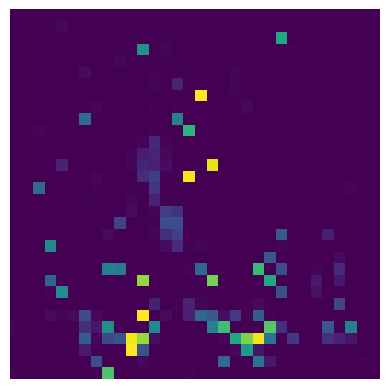

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reverse_engineer(param = {
    "dataset": "cifar10",
    "Epochs": 100,
    "batch_size": 64,
    "target_label": 0,
    "cost_lambda": 1e-3,
    "num_classes": 10,
    "image_size": (32, 32)}, model = torch.load('model_cifar10_0.15_0.pkl').to(device))

### Target Label = 1, Injection Rate = 0.15

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
param = {
    "dataset": "cifar10",
    "model": "default", 
    "poisoning_method": "badnet",
    "injection_rate": 0.15,
    "target_label": 1,
    "Epochs": 150,
    "batch_size": 64
    }
fill_param(param)
train(param)

Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.33it/s]


Epoch: 1, Training Accuracy: 50.614, Testing Accuracy: 57.39, Testing ASR: 96.48


Testing...: 100%|██████████| 157/157 [00:00<00:00, 598.89it/s]


Epoch: 2, Training Accuracy: 67.022, Testing Accuracy: 64.96, Testing ASR: 96.16


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.39it/s]


Epoch: 3, Training Accuracy: 72.19, Testing Accuracy: 69.11, Testing ASR: 96.54


Testing...: 100%|██████████| 157/157 [00:00<00:00, 585.01it/s]


Epoch: 4, Training Accuracy: 75.184, Testing Accuracy: 73.46, Testing ASR: 97.51


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.81it/s]


Epoch: 5, Training Accuracy: 77.326, Testing Accuracy: 75.8, Testing ASR: 97.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.78it/s]


Epoch: 6, Training Accuracy: 79.182, Testing Accuracy: 76.21, Testing ASR: 97.33


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.37it/s]


Epoch: 7, Training Accuracy: 80.342, Testing Accuracy: 74.05, Testing ASR: 97.45


Testing...: 100%|██████████| 157/157 [00:00<00:00, 598.47it/s]


Epoch: 8, Training Accuracy: 81.418, Testing Accuracy: 75.01, Testing ASR: 97.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 588.54it/s]


Epoch: 9, Training Accuracy: 82.15, Testing Accuracy: 78.48, Testing ASR: 97.56


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.28it/s]


Epoch: 10, Training Accuracy: 83.064, Testing Accuracy: 77.49, Testing ASR: 92.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.14it/s]


Epoch: 11, Training Accuracy: 83.91, Testing Accuracy: 78.66, Testing ASR: 98.14


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.29it/s]


Epoch: 12, Training Accuracy: 84.594, Testing Accuracy: 79.9, Testing ASR: 97.46


Testing...: 100%|██████████| 157/157 [00:00<00:00, 634.81it/s]


Epoch: 13, Training Accuracy: 85.218, Testing Accuracy: 79.85, Testing ASR: 98.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.66it/s]


Epoch: 14, Training Accuracy: 85.904, Testing Accuracy: 80.14, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.47it/s]


Epoch: 15, Training Accuracy: 86.142, Testing Accuracy: 80.94, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 584.68it/s]


Epoch: 16, Training Accuracy: 86.732, Testing Accuracy: 81.44, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 589.57it/s]


Epoch: 17, Training Accuracy: 87.08, Testing Accuracy: 81.01, Testing ASR: 98.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.27it/s]


Epoch: 18, Training Accuracy: 87.612, Testing Accuracy: 79.97, Testing ASR: 97.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.23it/s]


Epoch: 19, Training Accuracy: 87.752, Testing Accuracy: 80.48, Testing ASR: 97.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.04it/s]


Epoch: 20, Training Accuracy: 88.04, Testing Accuracy: 81.81, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.45it/s]


Epoch: 21, Training Accuracy: 88.554, Testing Accuracy: 81.85, Testing ASR: 97.57


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.12it/s]


Epoch: 22, Training Accuracy: 88.778, Testing Accuracy: 80.76, Testing ASR: 97.13


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.01it/s]


Epoch: 23, Training Accuracy: 89.066, Testing Accuracy: 81.9, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.58it/s]


Epoch: 24, Training Accuracy: 89.488, Testing Accuracy: 81.06, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.46it/s]


Epoch: 25, Training Accuracy: 89.81, Testing Accuracy: 81.6, Testing ASR: 98.37


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.86it/s]


Epoch: 26, Training Accuracy: 89.838, Testing Accuracy: 81.99, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.10it/s]


Epoch: 27, Training Accuracy: 90.062, Testing Accuracy: 81.7, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.10it/s]


Epoch: 28, Training Accuracy: 90.246, Testing Accuracy: 81.79, Testing ASR: 98.39


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.73it/s]


Epoch: 29, Training Accuracy: 90.712, Testing Accuracy: 81.25, Testing ASR: 96.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.34it/s]


Epoch: 30, Training Accuracy: 90.79, Testing Accuracy: 80.1, Testing ASR: 97.31


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.48it/s]


Epoch: 31, Training Accuracy: 90.956, Testing Accuracy: 81.89, Testing ASR: 98.18


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.38it/s]


Epoch: 32, Training Accuracy: 91.3, Testing Accuracy: 81.89, Testing ASR: 98.26


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.38it/s]


Epoch: 33, Training Accuracy: 91.282, Testing Accuracy: 81.99, Testing ASR: 97.97


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.70it/s]


Epoch: 34, Training Accuracy: 91.384, Testing Accuracy: 82.24, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.99it/s]


Epoch: 35, Training Accuracy: 91.604, Testing Accuracy: 81.63, Testing ASR: 98.15


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.71it/s]


Epoch: 36, Training Accuracy: 91.896, Testing Accuracy: 82.21, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.92it/s]


Epoch: 37, Training Accuracy: 91.82, Testing Accuracy: 81.61, Testing ASR: 97.63


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.00it/s]


Epoch: 38, Training Accuracy: 92.0, Testing Accuracy: 81.8, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.16it/s]


Epoch: 39, Training Accuracy: 92.086, Testing Accuracy: 82.4, Testing ASR: 97.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 569.76it/s]


Epoch: 40, Training Accuracy: 92.166, Testing Accuracy: 82.54, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.12it/s]


Epoch: 41, Training Accuracy: 92.402, Testing Accuracy: 82.44, Testing ASR: 97.93


Testing...: 100%|██████████| 157/157 [00:00<00:00, 591.01it/s]


Epoch: 42, Training Accuracy: 92.554, Testing Accuracy: 82.08, Testing ASR: 98.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.98it/s]


Epoch: 43, Training Accuracy: 92.686, Testing Accuracy: 81.97, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 635.08it/s]


Epoch: 44, Training Accuracy: 92.648, Testing Accuracy: 82.37, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 585.00it/s]


Epoch: 45, Training Accuracy: 92.778, Testing Accuracy: 82.55, Testing ASR: 98.43


Testing...: 100%|██████████| 157/157 [00:00<00:00, 634.26it/s]


Epoch: 46, Training Accuracy: 92.912, Testing Accuracy: 79.77, Testing ASR: 96.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.31it/s]


Epoch: 47, Training Accuracy: 93.002, Testing Accuracy: 81.98, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.51it/s]


Epoch: 48, Training Accuracy: 93.062, Testing Accuracy: 82.27, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 634.72it/s]


Epoch: 49, Training Accuracy: 93.056, Testing Accuracy: 82.07, Testing ASR: 98.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.37it/s]


Epoch: 50, Training Accuracy: 93.236, Testing Accuracy: 80.77, Testing ASR: 94.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.06it/s]


Epoch: 51, Training Accuracy: 93.31, Testing Accuracy: 82.25, Testing ASR: 98.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.20it/s]


Epoch: 52, Training Accuracy: 93.494, Testing Accuracy: 82.43, Testing ASR: 98.25


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.44it/s]


Epoch: 53, Training Accuracy: 93.456, Testing Accuracy: 82.64, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.61it/s]


Epoch: 54, Training Accuracy: 93.458, Testing Accuracy: 81.82, Testing ASR: 97.29


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.30it/s]


Epoch: 55, Training Accuracy: 93.534, Testing Accuracy: 82.19, Testing ASR: 98.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.11it/s]


Epoch: 56, Training Accuracy: 93.704, Testing Accuracy: 81.7, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.23it/s]


Epoch: 57, Training Accuracy: 93.862, Testing Accuracy: 81.22, Testing ASR: 98.29


Testing...: 100%|██████████| 157/157 [00:00<00:00, 594.14it/s]


Epoch: 58, Training Accuracy: 93.82, Testing Accuracy: 82.68, Testing ASR: 98.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 591.55it/s]


Epoch: 59, Training Accuracy: 93.82, Testing Accuracy: 82.23, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.08it/s]


Epoch: 60, Training Accuracy: 93.93, Testing Accuracy: 82.41, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.60it/s]


Epoch: 61, Training Accuracy: 94.004, Testing Accuracy: 81.98, Testing ASR: 98.21


Testing...: 100%|██████████| 157/157 [00:00<00:00, 578.15it/s]


Epoch: 62, Training Accuracy: 94.068, Testing Accuracy: 82.46, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.00it/s]


Epoch: 63, Training Accuracy: 94.088, Testing Accuracy: 82.29, Testing ASR: 98.2


Testing...: 100%|██████████| 157/157 [00:00<00:00, 600.28it/s]


Epoch: 64, Training Accuracy: 94.068, Testing Accuracy: 82.75, Testing ASR: 98.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.37it/s]


Epoch: 65, Training Accuracy: 94.216, Testing Accuracy: 82.19, Testing ASR: 98.38


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.54it/s]


Epoch: 66, Training Accuracy: 94.078, Testing Accuracy: 82.77, Testing ASR: 98.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.72it/s]


Epoch: 67, Training Accuracy: 94.254, Testing Accuracy: 81.25, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.55it/s]


Epoch: 68, Training Accuracy: 94.488, Testing Accuracy: 82.83, Testing ASR: 98.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 557.04it/s]


Epoch: 69, Training Accuracy: 94.364, Testing Accuracy: 82.44, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.63it/s]


Epoch: 70, Training Accuracy: 94.38, Testing Accuracy: 81.61, Testing ASR: 98.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.25it/s]


Epoch: 71, Training Accuracy: 94.574, Testing Accuracy: 82.33, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.91it/s]


Epoch: 72, Training Accuracy: 94.552, Testing Accuracy: 82.58, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.92it/s]


Epoch: 73, Training Accuracy: 94.694, Testing Accuracy: 81.9, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 640.99it/s]


Epoch: 74, Training Accuracy: 94.696, Testing Accuracy: 82.05, Testing ASR: 98.21


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.81it/s]


Epoch: 75, Training Accuracy: 94.53, Testing Accuracy: 82.52, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.68it/s]


Epoch: 76, Training Accuracy: 94.798, Testing Accuracy: 82.24, Testing ASR: 98.43


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.82it/s]


Epoch: 77, Training Accuracy: 94.826, Testing Accuracy: 81.61, Testing ASR: 98.13


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.08it/s]


Epoch: 78, Training Accuracy: 94.698, Testing Accuracy: 82.69, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.24it/s]


Epoch: 79, Training Accuracy: 94.958, Testing Accuracy: 82.24, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.31it/s]


Epoch: 80, Training Accuracy: 94.93, Testing Accuracy: 81.95, Testing ASR: 98.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.47it/s]


Epoch: 81, Training Accuracy: 95.614, Testing Accuracy: 82.69, Testing ASR: 98.24


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.48it/s]


Epoch: 82, Training Accuracy: 95.79, Testing Accuracy: 82.9, Testing ASR: 98.33


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.80it/s]


Epoch: 83, Training Accuracy: 96.126, Testing Accuracy: 83.34, Testing ASR: 98.25


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.29it/s]


Epoch: 84, Training Accuracy: 96.168, Testing Accuracy: 82.97, Testing ASR: 98.29


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.01it/s]


Epoch: 85, Training Accuracy: 96.28, Testing Accuracy: 82.86, Testing ASR: 97.97


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.11it/s]


Epoch: 86, Training Accuracy: 96.394, Testing Accuracy: 83.03, Testing ASR: 98.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.86it/s]


Epoch: 87, Training Accuracy: 96.486, Testing Accuracy: 83.16, Testing ASR: 98.13


Testing...: 100%|██████████| 157/157 [00:00<00:00, 599.10it/s]


Epoch: 88, Training Accuracy: 96.378, Testing Accuracy: 83.09, Testing ASR: 98.17


Testing...: 100%|██████████| 157/157 [00:00<00:00, 636.29it/s]


Epoch: 89, Training Accuracy: 96.452, Testing Accuracy: 83.29, Testing ASR: 97.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.50it/s]


Epoch: 90, Training Accuracy: 96.486, Testing Accuracy: 83.09, Testing ASR: 98.11


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.02it/s]


Epoch: 91, Training Accuracy: 96.492, Testing Accuracy: 83.07, Testing ASR: 98.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.10it/s]


Epoch: 92, Training Accuracy: 96.45, Testing Accuracy: 83.42, Testing ASR: 98.18


Testing...: 100%|██████████| 157/157 [00:00<00:00, 605.11it/s]


Epoch: 93, Training Accuracy: 96.63, Testing Accuracy: 82.82, Testing ASR: 98.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.82it/s]


Epoch: 94, Training Accuracy: 96.532, Testing Accuracy: 82.7, Testing ASR: 98.44


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.30it/s]


Epoch: 95, Training Accuracy: 96.614, Testing Accuracy: 83.28, Testing ASR: 98.14


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.99it/s]


Epoch: 96, Training Accuracy: 96.606, Testing Accuracy: 83.1, Testing ASR: 98.16


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.76it/s]


Epoch: 97, Training Accuracy: 96.782, Testing Accuracy: 82.77, Testing ASR: 98.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 635.09it/s]


Epoch: 98, Training Accuracy: 96.782, Testing Accuracy: 83.06, Testing ASR: 98.36


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.95it/s]


Epoch: 99, Training Accuracy: 96.584, Testing Accuracy: 83.12, Testing ASR: 98.41


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.14it/s]


Epoch: 100, Training Accuracy: 96.816, Testing Accuracy: 83.13, Testing ASR: 98.14


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.43it/s]


Epoch: 101, Training Accuracy: 97.002, Testing Accuracy: 83.3, Testing ASR: 98.33


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.05it/s]


Epoch: 102, Training Accuracy: 97.194, Testing Accuracy: 83.24, Testing ASR: 98.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.08it/s]


Epoch: 103, Training Accuracy: 97.282, Testing Accuracy: 83.53, Testing ASR: 98.17


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.61it/s]


Epoch: 104, Training Accuracy: 97.222, Testing Accuracy: 83.57, Testing ASR: 98.21


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.99it/s]


Epoch: 105, Training Accuracy: 97.278, Testing Accuracy: 83.27, Testing ASR: 98.29


Testing...: 100%|██████████| 157/157 [00:00<00:00, 595.91it/s]


Epoch: 106, Training Accuracy: 97.416, Testing Accuracy: 83.45, Testing ASR: 98.16


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.73it/s]


Epoch: 107, Training Accuracy: 97.478, Testing Accuracy: 83.46, Testing ASR: 98.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.49it/s]


Epoch: 108, Training Accuracy: 97.374, Testing Accuracy: 83.25, Testing ASR: 98.25


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.46it/s]


Epoch: 109, Training Accuracy: 97.426, Testing Accuracy: 83.31, Testing ASR: 98.17


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.90it/s]


Epoch: 110, Training Accuracy: 97.362, Testing Accuracy: 83.33, Testing ASR: 98.27


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.77it/s]


Epoch: 111, Training Accuracy: 97.578, Testing Accuracy: 83.37, Testing ASR: 98.27


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.27it/s]


Epoch: 112, Training Accuracy: 97.548, Testing Accuracy: 83.51, Testing ASR: 98.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 635.04it/s]


Epoch: 113, Training Accuracy: 97.614, Testing Accuracy: 83.27, Testing ASR: 98.27


Testing...: 100%|██████████| 157/157 [00:00<00:00, 639.38it/s]


Epoch: 114, Training Accuracy: 97.55, Testing Accuracy: 83.31, Testing ASR: 98.16


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.55it/s]


Epoch: 115, Training Accuracy: 97.48, Testing Accuracy: 83.48, Testing ASR: 98.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.75it/s]


Epoch: 116, Training Accuracy: 97.58, Testing Accuracy: 83.19, Testing ASR: 98.26


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.48it/s]


Epoch: 117, Training Accuracy: 97.516, Testing Accuracy: 83.39, Testing ASR: 98.25


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.37it/s]


Epoch: 118, Training Accuracy: 97.68, Testing Accuracy: 83.1, Testing ASR: 98.26


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.90it/s]


Epoch: 119, Training Accuracy: 97.68, Testing Accuracy: 83.38, Testing ASR: 98.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 586.56it/s]


Epoch: 120, Training Accuracy: 97.63, Testing Accuracy: 83.22, Testing ASR: 98.21


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.41it/s]


Epoch: 121, Training Accuracy: 97.658, Testing Accuracy: 83.28, Testing ASR: 98.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.61it/s]


Epoch: 122, Training Accuracy: 97.726, Testing Accuracy: 83.34, Testing ASR: 98.13


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.97it/s]


Epoch: 123, Training Accuracy: 97.734, Testing Accuracy: 83.25, Testing ASR: 98.14


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.19it/s]


Epoch: 124, Training Accuracy: 97.71, Testing Accuracy: 83.39, Testing ASR: 98.14


Testing...: 100%|██████████| 157/157 [00:00<00:00, 599.53it/s]


Epoch: 125, Training Accuracy: 97.746, Testing Accuracy: 83.35, Testing ASR: 98.24


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.43it/s]


Epoch: 126, Training Accuracy: 97.738, Testing Accuracy: 83.12, Testing ASR: 98.22


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.76it/s]


Epoch: 127, Training Accuracy: 97.812, Testing Accuracy: 83.45, Testing ASR: 98.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 601.67it/s]


Epoch: 128, Training Accuracy: 97.772, Testing Accuracy: 83.47, Testing ASR: 98.27


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.00it/s]


Epoch: 129, Training Accuracy: 97.638, Testing Accuracy: 83.14, Testing ASR: 98.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.09it/s]


Epoch: 130, Training Accuracy: 97.702, Testing Accuracy: 83.21, Testing ASR: 98.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.81it/s]


Epoch: 131, Training Accuracy: 97.814, Testing Accuracy: 83.14, Testing ASR: 98.24


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.37it/s]


Epoch: 132, Training Accuracy: 97.906, Testing Accuracy: 83.42, Testing ASR: 98.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.67it/s]


Epoch: 133, Training Accuracy: 97.712, Testing Accuracy: 83.32, Testing ASR: 98.31


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.39it/s]


Epoch: 134, Training Accuracy: 97.826, Testing Accuracy: 83.43, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.47it/s]


Epoch: 135, Training Accuracy: 97.838, Testing Accuracy: 83.22, Testing ASR: 98.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.59it/s]


Epoch: 136, Training Accuracy: 97.734, Testing Accuracy: 83.29, Testing ASR: 98.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.35it/s]


Epoch: 137, Training Accuracy: 97.696, Testing Accuracy: 83.45, Testing ASR: 98.18


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.22it/s]


Epoch: 138, Training Accuracy: 97.866, Testing Accuracy: 83.34, Testing ASR: 98.11


Testing...: 100%|██████████| 157/157 [00:00<00:00, 585.96it/s]


Epoch: 139, Training Accuracy: 97.816, Testing Accuracy: 83.12, Testing ASR: 98.26


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.86it/s]


Epoch: 140, Training Accuracy: 97.902, Testing Accuracy: 83.22, Testing ASR: 98.37


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.38it/s]


Epoch: 141, Training Accuracy: 97.74, Testing Accuracy: 83.27, Testing ASR: 98.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.60it/s]


Epoch: 142, Training Accuracy: 97.864, Testing Accuracy: 83.22, Testing ASR: 98.29


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.89it/s]


Epoch: 143, Training Accuracy: 97.886, Testing Accuracy: 83.44, Testing ASR: 98.21


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.66it/s]


Epoch: 144, Training Accuracy: 97.828, Testing Accuracy: 83.38, Testing ASR: 98.31


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.73it/s]


Epoch: 145, Training Accuracy: 97.744, Testing Accuracy: 83.4, Testing ASR: 98.15


Testing...: 100%|██████████| 157/157 [00:00<00:00, 590.96it/s]


Epoch: 146, Training Accuracy: 97.966, Testing Accuracy: 83.27, Testing ASR: 98.21


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.04it/s]


Epoch: 147, Training Accuracy: 97.726, Testing Accuracy: 83.1, Testing ASR: 98.32


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.26it/s]


Epoch: 148, Training Accuracy: 97.89, Testing Accuracy: 83.18, Testing ASR: 98.32


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.47it/s]


Epoch: 149, Training Accuracy: 97.84, Testing Accuracy: 83.4, Testing ASR: 98.26


Testing...: 100%|██████████| 157/157 [00:00<00:00, 594.93it/s]


Epoch: 150, Training Accuracy: 97.848, Testing Accuracy: 83.33, Testing ASR: 98.29


Processing label: 0


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 234.79it/s]


norm: 491.05487060546875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 249.49it/s]


norm: 439.020263671875


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 249.14it/s]


norm: 378.8279113769531


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 252.06it/s]


norm: 322.50067138671875


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 246.49it/s]


norm: 271.6173400878906


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 248.09it/s]


norm: 229.3061981201172


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 248.85it/s]


norm: 194.8391876220703


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 248.85it/s]


norm: 167.053466796875


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 244.78it/s]


norm: 145.06503295898438


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 246.29it/s]


norm: 127.6371841430664


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 241.93it/s]


norm: 113.15254211425781


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 246.36it/s]


norm: 101.37802124023438


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 240.58it/s]


norm: 93.247802734375


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 252.68it/s]


norm: 87.6019515991211


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 253.08it/s]


norm: 82.66317749023438


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 246.44it/s]


norm: 79.49633026123047


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 245.44it/s]


norm: 76.45883178710938


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 251.96it/s]


norm: 73.32048797607422


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 255.35it/s]


norm: 71.158447265625


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 258.45it/s]


norm: 68.93157958984375


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 254.68it/s]


norm: 66.68183898925781


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 222.86it/s]


norm: 65.31828308105469


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 221.81it/s]


norm: 63.88847351074219


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 227.67it/s]


norm: 62.733612060546875


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 236.98it/s]


norm: 61.72161102294922


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 247.50it/s]


norm: 60.87065887451172


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


norm: 60.442543029785156


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 250.16it/s]


norm: 59.32481384277344


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 217.20it/s]


norm: 58.42015838623047


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 229.81it/s]


norm: 57.62638854980469


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 244.80it/s]


norm: 56.763710021972656


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 246.93it/s]


norm: 55.77989959716797


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 251.98it/s]


norm: 55.27925109863281


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 257.48it/s]


norm: 54.709442138671875


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 255.56it/s]


norm: 54.50982666015625


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 251.42it/s]


norm: 54.1016731262207


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 253.83it/s]


norm: 54.003387451171875


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 252.22it/s]


norm: 53.831668853759766


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 226.95it/s]


norm: 53.681663513183594


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 245.69it/s]


norm: 53.935672760009766


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 244.68it/s]


norm: 53.859458923339844


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 242.04it/s]


norm: 53.81584167480469


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 246.91it/s]


norm: 53.43803024291992


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 242.97it/s]


norm: 53.28719711303711


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 250.92it/s]


norm: 53.14326095581055


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 242.72it/s]


norm: 53.09741973876953


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 256.15it/s]


norm: 53.03422546386719


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 249.06it/s]


norm: 52.90157699584961


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 248.44it/s]


norm: 52.897560119628906


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 254.34it/s]


norm: 52.90007019042969


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 254.42it/s]


norm: 52.900875091552734


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 249.84it/s]


norm: 52.78936004638672


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 233.67it/s]


norm: 52.5775146484375


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 245.16it/s]


norm: 52.75550842285156


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 252.56it/s]


norm: 52.71212387084961


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 247.48it/s]


norm: 52.697174072265625


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 233.57it/s]


norm: 52.93305587768555


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 225.05it/s]


norm: 53.315006256103516


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 252.80it/s]


norm: 53.26824188232422


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 250.14it/s]


norm: 53.130462646484375


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 253.85it/s]


norm: 52.847740173339844


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 252.56it/s]


norm: 53.42401123046875


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 244.67it/s]


norm: 53.44878387451172


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 250.49it/s]


norm: 52.881263732910156


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 247.96it/s]


norm: 52.6873664855957


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 256.50it/s]


norm: 52.250953674316406


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 255.63it/s]


norm: 52.24226379394531


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 251.73it/s]


norm: 52.49279022216797


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 251.75it/s]


norm: 52.19744873046875


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 241.35it/s]


norm: 52.27289581298828


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 230.48it/s]


norm: 52.1246337890625


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 234.16it/s]


norm: 52.05567169189453


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 233.17it/s]


norm: 51.87939453125


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 228.76it/s]


norm: 51.425933837890625


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 246.16it/s]


norm: 51.20063781738281


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 249.07it/s]


norm: 51.12635040283203


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 248.46it/s]


norm: 50.97718048095703


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 249.55it/s]


norm: 51.11277389526367


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 245.29it/s]


norm: 50.72819519042969


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 248.60it/s]


norm: 50.509437561035156


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 251.97it/s]


norm: 50.186241149902344


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 246.01it/s]


norm: 49.94427490234375


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 250.54it/s]


norm: 49.59747314453125


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 225.44it/s]


norm: 48.95697784423828


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 225.70it/s]


norm: 48.60866165161133


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 245.54it/s]


norm: 48.400917053222656


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 247.87it/s]


norm: 48.38671112060547


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 249.73it/s]


norm: 48.08815002441406


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 242.27it/s]


norm: 47.842952728271484


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 250.35it/s]


norm: 47.677940368652344


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 242.21it/s]


norm: 47.634395599365234


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 225.89it/s]


norm: 47.881168365478516


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 233.65it/s]


norm: 47.79447937011719


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 241.90it/s]


norm: 47.6711540222168


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 254.57it/s]


norm: 47.435298919677734


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 242.66it/s]


norm: 47.5147819519043


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 244.40it/s]


norm: 47.59901428222656


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 234.34it/s]


norm: 47.373165130615234


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 240.78it/s]


norm: 47.40669631958008


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 251.71it/s]


norm: 47.23954391479492
Processing label: 1


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 251.92it/s]


norm: 492.830810546875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 232.45it/s]


norm: 439.63006591796875


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 245.54it/s]


norm: 378.8619384765625


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 245.22it/s]


norm: 317.21978759765625


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 252.86it/s]


norm: 262.24920654296875


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 252.01it/s]


norm: 214.77340698242188


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 252.34it/s]


norm: 175.4004364013672


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 254.24it/s]


norm: 143.739990234375


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 248.70it/s]


norm: 118.1943359375


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 246.35it/s]


norm: 97.7119140625


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 250.25it/s]


norm: 82.77778625488281


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 234.85it/s]


norm: 72.9562759399414


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 254.99it/s]


norm: 65.84808349609375


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 241.74it/s]


norm: 59.98029327392578


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 249.43it/s]


norm: 56.602291107177734


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 249.96it/s]


norm: 52.667015075683594


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 251.87it/s]


norm: 47.29704284667969


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 253.45it/s]


norm: 45.49687194824219


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 249.43it/s]


norm: 40.26687240600586


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 244.20it/s]


norm: 36.339595794677734


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 249.25it/s]


norm: 32.91355895996094


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 252.43it/s]


norm: 27.726526260375977


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 246.53it/s]


norm: 25.6417236328125


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 246.44it/s]


norm: 20.39506721496582


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 246.87it/s]


norm: 21.959022521972656


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 255.77it/s]


norm: 20.279563903808594


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 254.37it/s]


norm: 19.04261589050293


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 253.09it/s]


norm: 13.902523040771484


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 250.04it/s]


norm: 13.258790016174316


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 248.11it/s]


norm: 13.230762481689453


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 249.29it/s]


norm: 11.428707122802734


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 237.90it/s]


norm: 12.05185317993164


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 225.28it/s]


norm: 13.284724235534668


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 234.23it/s]


norm: 11.0368070602417


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 231.92it/s]


norm: 13.277549743652344


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 249.75it/s]


norm: 9.527810096740723


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 250.84it/s]


norm: 9.311203956604004


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 247.31it/s]


norm: 9.910052299499512


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 250.63it/s]


norm: 9.974620819091797


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 229.45it/s]


norm: 9.627443313598633


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 218.81it/s]


norm: 11.634185791015625


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 253.24it/s]


norm: 13.268167495727539


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 251.81it/s]


norm: 9.251880645751953


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 243.57it/s]


norm: 9.457612991333008


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 242.14it/s]


norm: 8.601287841796875


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 252.14it/s]


norm: 8.884414672851562


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 255.22it/s]


norm: 14.161535263061523


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 250.56it/s]


norm: 8.820921897888184


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 241.74it/s]


norm: 8.419512748718262


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 238.47it/s]


norm: 10.777548789978027


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 239.47it/s]


norm: 9.021524429321289


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 228.96it/s]


norm: 8.866868019104004


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 225.74it/s]


norm: 9.766419410705566


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 230.54it/s]


norm: 8.258247375488281


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 235.96it/s]


norm: 8.329551696777344


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 230.73it/s]


norm: 9.932151794433594


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 254.29it/s]


norm: 8.207515716552734


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 253.49it/s]


norm: 9.780616760253906


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 256.51it/s]


norm: 8.209428787231445


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 259.45it/s]


norm: 8.084619522094727


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 240.71it/s]


norm: 8.635326385498047


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 248.07it/s]


norm: 8.18057918548584


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 250.96it/s]


norm: 10.017412185668945


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 251.37it/s]


norm: 9.768196105957031


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 253.74it/s]


norm: 7.541887283325195


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 243.59it/s]


norm: 9.675745964050293


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 248.83it/s]


norm: 8.473291397094727


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 249.35it/s]


norm: 8.251667976379395


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 249.17it/s]


norm: 7.85067892074585


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 257.28it/s]


norm: 7.425080299377441


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 256.05it/s]


norm: 9.719671249389648


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 249.21it/s]


norm: 7.863829612731934


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 228.32it/s]


norm: 8.217689514160156


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 254.45it/s]


norm: 11.928359985351562


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 251.05it/s]


norm: 8.025821685791016


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 239.94it/s]


norm: 7.512974262237549


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 250.42it/s]


norm: 13.42232608795166


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 255.62it/s]


norm: 7.134882926940918


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 252.52it/s]


norm: 7.274951457977295


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 256.30it/s]


norm: 7.092001914978027


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 254.64it/s]


norm: 8.010153770446777


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 254.05it/s]


norm: 12.794496536254883


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 254.02it/s]


norm: 7.254002571105957


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 249.60it/s]


norm: 7.479861736297607


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 251.76it/s]


norm: 9.932477951049805


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 241.47it/s]


norm: 8.307458877563477


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 236.77it/s]


norm: 8.362822532653809


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 239.91it/s]


norm: 9.04248046875


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 253.79it/s]


norm: 8.463305473327637


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 257.32it/s]


norm: 7.456294059753418


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 253.94it/s]


norm: 7.310903549194336


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 249.62it/s]


norm: 11.172431945800781


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 252.60it/s]


norm: 7.024615287780762


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 255.84it/s]


norm: 7.779393196105957


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 258.12it/s]


norm: 7.612436294555664


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 255.33it/s]


norm: 9.450759887695312


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 256.60it/s]


norm: 15.053771018981934


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 256.90it/s]


norm: 7.59901237487793


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 249.38it/s]


norm: 7.37083101272583


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 247.97it/s]


norm: 7.261007308959961
Processing label: 2


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 245.33it/s]


norm: 482.16058349609375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 251.45it/s]


norm: 416.0789489746094


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 222.93it/s]


norm: 345.2275695800781


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 220.04it/s]


norm: 283.304443359375


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 256.97it/s]


norm: 234.1355743408203


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 252.27it/s]


norm: 197.9770050048828


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 251.65it/s]


norm: 169.22760009765625


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 244.65it/s]


norm: 146.05931091308594


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 249.89it/s]


norm: 127.99022674560547


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 253.63it/s]


norm: 113.97764587402344


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 253.34it/s]


norm: 103.49409484863281


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 250.09it/s]


norm: 94.5947265625


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 247.07it/s]


norm: 88.63349914550781


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 250.00it/s]


norm: 82.81430053710938


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 252.51it/s]


norm: 80.49833679199219


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 250.24it/s]


norm: 78.28314208984375


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 246.36it/s]


norm: 75.406494140625


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 252.59it/s]


norm: 72.32649230957031


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 229.44it/s]


norm: 68.95574188232422


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 247.69it/s]


norm: 66.37860107421875


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 251.51it/s]


norm: 65.37786865234375


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 253.53it/s]


norm: 64.12162780761719


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 251.84it/s]


norm: 62.790626525878906


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 243.32it/s]


norm: 61.77241897583008


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 248.08it/s]


norm: 61.772705078125


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 226.44it/s]


norm: 60.85393524169922


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 257.88it/s]


norm: 60.47808074951172


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 251.87it/s]


norm: 59.86637878417969


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 230.81it/s]


norm: 59.500301361083984


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 241.45it/s]


norm: 59.25397491455078


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 253.42it/s]


norm: 59.1058349609375


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 230.93it/s]


norm: 58.843650817871094


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 239.71it/s]


norm: 58.52245330810547


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 255.75it/s]


norm: 58.258766174316406


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 247.06it/s]


norm: 58.23426055908203


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 248.95it/s]


norm: 57.755157470703125


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 251.15it/s]


norm: 57.47842788696289


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 250.52it/s]


norm: 58.15773391723633


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 246.84it/s]


norm: 57.390045166015625


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 246.89it/s]


norm: 57.56437683105469


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 244.90it/s]


norm: 56.153663635253906


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 249.53it/s]


norm: 55.66027069091797


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 238.25it/s]


norm: 56.737178802490234


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 247.26it/s]


norm: 55.50604248046875


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 252.97it/s]


norm: 54.467041015625


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 249.68it/s]


norm: 54.06278991699219


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 255.38it/s]


norm: 53.07888412475586


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 258.37it/s]


norm: 53.09658432006836


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 246.30it/s]


norm: 52.13431167602539


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 257.04it/s]


norm: 52.88059616088867


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 255.97it/s]


norm: 51.429786682128906


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 254.55it/s]


norm: 51.06798553466797


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 257.24it/s]


norm: 51.221866607666016


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 259.49it/s]


norm: 50.93170166015625


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 258.01it/s]


norm: 50.71780014038086


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 257.37it/s]


norm: 50.687503814697266


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 249.77it/s]


norm: 49.582275390625


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 244.48it/s]


norm: 50.43476867675781


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 257.03it/s]


norm: 50.156158447265625


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 254.57it/s]


norm: 49.69526672363281


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 260.30it/s]


norm: 49.54901885986328


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 251.40it/s]


norm: 49.14946746826172


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 247.30it/s]


norm: 48.96052551269531


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 248.52it/s]


norm: 48.29975128173828


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 241.52it/s]


norm: 49.00623321533203


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 249.45it/s]


norm: 48.85411834716797


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 248.40it/s]


norm: 48.744895935058594


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 253.36it/s]


norm: 49.67639923095703


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 257.20it/s]


norm: 49.494895935058594


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 251.74it/s]


norm: 49.916664123535156


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 253.95it/s]


norm: 48.71161651611328


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 238.71it/s]


norm: 48.89204025268555


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 244.90it/s]


norm: 47.60619354248047


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 251.94it/s]


norm: 50.1627082824707


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 245.57it/s]


norm: 46.07914733886719


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 243.57it/s]


norm: 47.45281982421875


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 252.50it/s]


norm: 46.915557861328125


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 245.54it/s]


norm: 48.53852081298828


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 252.35it/s]


norm: 46.08425521850586


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 250.36it/s]


norm: 46.204498291015625


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 240.87it/s]


norm: 46.78690719604492


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 250.58it/s]


norm: 45.512386322021484


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 234.59it/s]


norm: 45.061702728271484


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 227.52it/s]


norm: 47.519287109375


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 250.47it/s]


norm: 45.722434997558594


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 247.49it/s]


norm: 44.88437271118164


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 239.79it/s]


norm: 44.816680908203125


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 243.58it/s]


norm: 44.27802276611328


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 245.77it/s]


norm: 44.336849212646484


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 250.80it/s]


norm: 45.05095672607422


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 248.67it/s]


norm: 45.94126892089844


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 248.70it/s]


norm: 45.0659294128418


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 245.90it/s]


norm: 44.99391174316406


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 257.92it/s]


norm: 43.80927276611328


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 249.27it/s]


norm: 44.74102020263672


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 246.78it/s]


norm: 44.44127655029297


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 247.46it/s]


norm: 44.68863296508789


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 204.10it/s]


norm: 43.57514953613281


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 229.21it/s]


norm: 42.82426834106445


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 237.68it/s]


norm: 44.051605224609375
Processing label: 3


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 249.03it/s]


norm: 495.8240661621094


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 245.82it/s]


norm: 440.9465026855469


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 246.82it/s]


norm: 378.6633605957031


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 230.49it/s]


norm: 318.287841796875


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 248.98it/s]


norm: 265.48651123046875


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 245.96it/s]


norm: 219.86842346191406


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 244.63it/s]


norm: 183.20083618164062


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 246.63it/s]


norm: 153.6386260986328


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 255.58it/s]


norm: 131.0773162841797


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 255.38it/s]


norm: 113.32341003417969


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 238.19it/s]


norm: 101.54793548583984


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 234.15it/s]


norm: 91.69711303710938


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 248.70it/s]


norm: 84.66270446777344


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 249.14it/s]


norm: 79.53257751464844


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 252.60it/s]


norm: 74.50765991210938


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 255.51it/s]


norm: 71.33226776123047


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 256.38it/s]


norm: 69.01138305664062


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 251.37it/s]


norm: 67.43885040283203


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 251.08it/s]


norm: 65.54727935791016


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 243.62it/s]


norm: 64.11918640136719


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 234.27it/s]


norm: 63.225738525390625


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 247.11it/s]


norm: 62.355224609375


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 244.93it/s]


norm: 61.680084228515625


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 225.76it/s]


norm: 61.219390869140625


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 237.00it/s]


norm: 61.382301330566406


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 246.53it/s]


norm: 60.91461181640625


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 246.05it/s]


norm: 61.00501251220703


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 239.51it/s]


norm: 60.205810546875


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 245.94it/s]


norm: 59.315765380859375


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 218.00it/s]


norm: 59.2530517578125


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 253.43it/s]


norm: 59.0659294128418


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 248.91it/s]


norm: 58.83918762207031


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 251.12it/s]


norm: 58.84988021850586


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 252.67it/s]


norm: 58.794158935546875


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 249.71it/s]


norm: 57.78247833251953


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 247.89it/s]


norm: 57.18541717529297


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 245.76it/s]


norm: 56.73146057128906


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 233.32it/s]


norm: 56.09396743774414


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 239.36it/s]


norm: 55.783504486083984


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 246.81it/s]


norm: 55.361881256103516


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 220.15it/s]


norm: 55.01280212402344


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 226.34it/s]


norm: 54.69274139404297


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 254.13it/s]


norm: 54.75468826293945


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 246.53it/s]


norm: 54.614837646484375


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 251.88it/s]


norm: 54.44670867919922


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 256.70it/s]


norm: 54.30501174926758


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 254.22it/s]


norm: 54.483917236328125


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 249.14it/s]


norm: 54.37423324584961


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 252.65it/s]


norm: 54.940067291259766


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 249.91it/s]


norm: 55.273887634277344


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 233.32it/s]


norm: 54.10693359375


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 224.30it/s]


norm: 53.66176986694336


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 244.09it/s]


norm: 53.443687438964844


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 245.85it/s]


norm: 53.36507034301758


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 250.06it/s]


norm: 53.021793365478516


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 250.61it/s]


norm: 52.94976806640625


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 248.30it/s]


norm: 53.22578811645508


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 252.02it/s]


norm: 52.79456329345703


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 247.40it/s]


norm: 52.994747161865234


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 236.58it/s]


norm: 52.670684814453125


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 249.60it/s]


norm: 52.4097900390625


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 250.78it/s]


norm: 52.80262756347656


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 250.41it/s]


norm: 52.46955108642578


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 242.06it/s]


norm: 52.77642059326172


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 233.01it/s]


norm: 52.52655029296875


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 247.22it/s]


norm: 52.481292724609375


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 246.58it/s]


norm: 52.65008544921875


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 248.96it/s]


norm: 52.581520080566406


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 253.99it/s]


norm: 52.98234558105469


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 247.35it/s]


norm: 52.724815368652344


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 253.67it/s]


norm: 52.92339324951172


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 253.36it/s]


norm: 53.31880187988281


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 254.56it/s]


norm: 53.509117126464844


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 239.49it/s]


norm: 53.47504806518555


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 229.51it/s]


norm: 52.591102600097656


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 243.86it/s]


norm: 52.72456359863281


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 253.21it/s]


norm: 52.74641418457031


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 255.07it/s]


norm: 52.38553237915039


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 250.31it/s]


norm: 52.222747802734375


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 249.95it/s]


norm: 52.46106719970703


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 252.56it/s]


norm: 52.251739501953125


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 249.76it/s]


norm: 52.06346893310547


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 255.77it/s]


norm: 51.72991180419922


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 251.02it/s]


norm: 51.71320343017578


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 256.03it/s]


norm: 51.85762405395508


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 253.12it/s]


norm: 52.10447692871094


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 249.12it/s]


norm: 51.93788146972656


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 257.18it/s]


norm: 51.91295623779297


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 251.46it/s]


norm: 51.91061782836914


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 251.63it/s]


norm: 51.655799865722656


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 250.24it/s]


norm: 51.428646087646484


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 248.27it/s]


norm: 51.27593231201172


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 255.90it/s]


norm: 51.25837707519531


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 257.75it/s]


norm: 51.114349365234375


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 256.82it/s]


norm: 51.225563049316406


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 243.18it/s]


norm: 51.085479736328125


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 255.16it/s]


norm: 51.58135986328125


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 253.23it/s]


norm: 51.5963134765625


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 258.42it/s]


norm: 51.32227325439453


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 251.93it/s]


norm: 51.41266632080078
Processing label: 4


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 253.86it/s]


norm: 485.311279296875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 254.72it/s]


norm: 439.1344909667969


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 250.63it/s]


norm: 384.6808166503906


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 249.60it/s]


norm: 329.0714111328125


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 249.59it/s]


norm: 279.15625


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 251.85it/s]


norm: 235.6541748046875


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 248.22it/s]


norm: 199.52288818359375


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 251.50it/s]


norm: 170.51229858398438


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 255.55it/s]


norm: 147.43553161621094


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 254.08it/s]


norm: 128.20445251464844


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 253.78it/s]


norm: 113.9950942993164


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 255.36it/s]


norm: 103.46001434326172


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 255.85it/s]


norm: 96.05601501464844


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 256.92it/s]


norm: 90.93984985351562


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 252.81it/s]


norm: 86.76031494140625


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 248.41it/s]


norm: 83.45919799804688


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 247.98it/s]


norm: 81.22666931152344


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 250.25it/s]


norm: 77.92724609375


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 238.49it/s]


norm: 75.71031188964844


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 249.34it/s]


norm: 73.17644500732422


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 251.17it/s]


norm: 71.71836853027344


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 254.44it/s]


norm: 70.41743469238281


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 248.03it/s]


norm: 70.1496353149414


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 248.74it/s]


norm: 68.74368286132812


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 253.40it/s]


norm: 67.34300231933594


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 254.43it/s]


norm: 67.23448181152344


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 250.23it/s]


norm: 65.74856567382812


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 255.91it/s]


norm: 65.75947570800781


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 253.48it/s]


norm: 64.30607604980469


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 255.21it/s]


norm: 63.78199005126953


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 251.85it/s]


norm: 63.257545471191406


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 245.59it/s]


norm: 62.921287536621094


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 253.71it/s]


norm: 62.337039947509766


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 250.79it/s]


norm: 61.31752014160156


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 238.23it/s]


norm: 60.61146545410156


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 256.86it/s]


norm: 60.473506927490234


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 245.10it/s]


norm: 60.41011047363281


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 253.05it/s]


norm: 59.69401550292969


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 247.46it/s]


norm: 59.42799377441406


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 252.39it/s]


norm: 59.092689514160156


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 251.20it/s]


norm: 58.93902587890625


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 231.29it/s]


norm: 58.991172790527344


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 224.74it/s]


norm: 58.981380462646484


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 253.20it/s]


norm: 58.92462921142578


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 247.66it/s]


norm: 57.99401092529297


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 256.70it/s]


norm: 57.67401885986328


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 258.10it/s]


norm: 58.2010612487793


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 252.40it/s]


norm: 57.81264114379883


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 250.50it/s]


norm: 58.602699279785156


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 251.34it/s]


norm: 58.05009841918945


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 247.26it/s]


norm: 57.664520263671875


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 218.47it/s]


norm: 57.11573791503906


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 246.49it/s]


norm: 57.30708312988281


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 252.40it/s]


norm: 57.490142822265625


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 251.09it/s]


norm: 57.5503044128418


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 252.97it/s]


norm: 57.460838317871094


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 249.93it/s]


norm: 57.68744659423828


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 244.07it/s]


norm: 57.541412353515625


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 252.63it/s]


norm: 57.531185150146484


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 252.83it/s]


norm: 57.650428771972656


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 231.57it/s]


norm: 57.66963195800781


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 251.34it/s]


norm: 57.32264709472656


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 228.25it/s]


norm: 57.259117126464844


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 227.72it/s]


norm: 57.05540466308594


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 240.53it/s]


norm: 56.71702575683594


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 226.66it/s]


norm: 56.672935485839844


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 247.21it/s]


norm: 56.33763122558594


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 258.80it/s]


norm: 55.928489685058594


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 259.95it/s]


norm: 55.134971618652344


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 250.33it/s]


norm: 55.5927848815918


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 249.45it/s]


norm: 54.553077697753906


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 231.04it/s]


norm: 54.8241081237793


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 251.50it/s]


norm: 54.25433349609375


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 253.94it/s]


norm: 53.84951400756836


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 252.14it/s]


norm: 53.79568862915039


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 256.28it/s]


norm: 53.50566101074219


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 255.27it/s]


norm: 53.433162689208984


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 258.30it/s]


norm: 53.168609619140625


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 250.91it/s]


norm: 53.05752182006836


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 232.28it/s]


norm: 53.08935546875


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 250.70it/s]


norm: 53.25469207763672


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 257.43it/s]


norm: 52.13536834716797


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 251.94it/s]


norm: 52.272621154785156


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 252.75it/s]


norm: 52.35136413574219


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 255.38it/s]


norm: 52.11058044433594


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 250.58it/s]


norm: 53.047210693359375


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 250.20it/s]


norm: 52.23430252075195


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 254.42it/s]


norm: 52.43260955810547


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 252.87it/s]


norm: 52.72645950317383


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 247.85it/s]


norm: 52.724998474121094


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 250.57it/s]


norm: 52.98320007324219


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 248.03it/s]


norm: 52.871002197265625


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 247.71it/s]


norm: 53.19873046875


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 250.31it/s]


norm: 52.90978240966797


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 255.48it/s]


norm: 52.98820877075195


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 248.43it/s]


norm: 53.893009185791016


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 228.07it/s]


norm: 52.762062072753906


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 229.39it/s]


norm: 52.48175048828125


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 252.73it/s]


norm: 53.241249084472656


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 254.87it/s]


norm: 53.764183044433594
Processing label: 5


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 249.82it/s]


norm: 492.2132568359375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 254.01it/s]


norm: 456.495849609375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 255.05it/s]


norm: 411.94683837890625


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 256.97it/s]


norm: 364.37384033203125


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 231.87it/s]


norm: 317.41058349609375


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 240.67it/s]


norm: 272.5740051269531


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 254.25it/s]


norm: 232.10275268554688


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 254.91it/s]


norm: 196.5126190185547


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 252.27it/s]


norm: 166.58212280273438


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 252.25it/s]


norm: 142.11090087890625


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 250.41it/s]


norm: 124.15741729736328


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 243.57it/s]


norm: 111.69588470458984


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 249.61it/s]


norm: 101.2632827758789


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 252.50it/s]


norm: 92.89446258544922


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 251.75it/s]


norm: 85.31770324707031


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 253.16it/s]


norm: 78.8567886352539


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 248.29it/s]


norm: 73.0643081665039


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 245.25it/s]


norm: 69.4018783569336


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 256.21it/s]


norm: 65.38084411621094


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 244.37it/s]


norm: 63.10974884033203


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 254.33it/s]


norm: 61.18519592285156


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 251.65it/s]


norm: 59.404022216796875


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 255.23it/s]


norm: 57.96505355834961


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 250.73it/s]


norm: 56.99660873413086


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 248.55it/s]


norm: 55.99647521972656


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 245.20it/s]


norm: 53.81367492675781


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 254.62it/s]


norm: 52.312644958496094


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 251.81it/s]


norm: 52.53375244140625


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 256.67it/s]


norm: 51.144203186035156


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 248.93it/s]


norm: 50.73444366455078


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 250.15it/s]


norm: 49.72379684448242


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 254.86it/s]


norm: 49.14508056640625


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 249.08it/s]


norm: 48.86773681640625


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 250.43it/s]


norm: 48.727203369140625


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 254.62it/s]


norm: 48.708251953125


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 251.37it/s]


norm: 48.509979248046875


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 251.55it/s]


norm: 48.38661575317383


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 241.26it/s]


norm: 48.57841110229492


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 253.61it/s]


norm: 48.96445846557617


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 252.20it/s]


norm: 48.88988494873047


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 250.66it/s]


norm: 48.81193542480469


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 255.08it/s]


norm: 48.60636901855469


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 254.36it/s]


norm: 48.51246643066406


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 247.81it/s]


norm: 48.328372955322266


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 249.55it/s]


norm: 48.177398681640625


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 246.16it/s]


norm: 48.143314361572266


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 251.01it/s]


norm: 48.268795013427734


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 252.95it/s]


norm: 47.99152374267578


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 225.90it/s]


norm: 48.01858139038086


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 223.31it/s]


norm: 47.61503982543945


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 237.01it/s]


norm: 47.476715087890625


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 239.77it/s]


norm: 47.35627746582031


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 228.83it/s]


norm: 47.197540283203125


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 249.33it/s]


norm: 46.92406463623047


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 245.12it/s]


norm: 46.49598693847656


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 249.46it/s]


norm: 46.15141296386719


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 247.19it/s]


norm: 45.97168731689453


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 252.55it/s]


norm: 46.01902389526367


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 252.32it/s]


norm: 46.03236389160156


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 244.96it/s]


norm: 46.163291931152344


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 249.95it/s]


norm: 46.67639923095703


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 244.77it/s]


norm: 46.1667366027832


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 251.48it/s]


norm: 45.79645538330078


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 242.42it/s]


norm: 46.04985046386719


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 246.93it/s]


norm: 45.63897705078125


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 219.60it/s]


norm: 45.605506896972656


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 220.74it/s]


norm: 45.417572021484375


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 240.14it/s]


norm: 45.277984619140625


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 249.38it/s]


norm: 45.37271499633789


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 248.34it/s]


norm: 45.298221588134766


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 249.96it/s]


norm: 44.86458206176758


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 227.25it/s]


norm: 45.06353759765625


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 234.28it/s]


norm: 45.38876724243164


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 245.62it/s]


norm: 45.104949951171875


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 242.47it/s]


norm: 45.064117431640625


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 241.05it/s]


norm: 45.26629638671875


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 246.89it/s]


norm: 45.04899597167969


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 246.85it/s]


norm: 45.13520812988281


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 253.83it/s]


norm: 44.839698791503906


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 238.67it/s]


norm: 45.0821533203125


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 233.68it/s]


norm: 45.44184112548828


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 251.91it/s]


norm: 45.5908317565918


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 256.46it/s]


norm: 46.19588851928711


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 228.13it/s]


norm: 46.281700134277344


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 235.41it/s]


norm: 45.10770034790039


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 245.92it/s]


norm: 45.560569763183594


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 235.88it/s]


norm: 45.66645812988281


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 226.88it/s]


norm: 45.02573013305664


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 223.98it/s]


norm: 45.76072692871094


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 239.07it/s]


norm: 45.29611587524414


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 242.76it/s]


norm: 45.917625427246094


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 218.40it/s]


norm: 44.77770233154297


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 223.55it/s]


norm: 45.58584976196289


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 244.23it/s]


norm: 44.44753646850586


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 244.74it/s]


norm: 45.97542953491211


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 248.06it/s]


norm: 43.976890563964844


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 251.87it/s]


norm: 45.34427261352539


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 249.07it/s]


norm: 44.40522003173828


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 243.76it/s]


norm: 44.2530517578125


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 250.32it/s]


norm: 45.81990051269531
Processing label: 6


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 245.28it/s]


norm: 291.8675231933594


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 246.61it/s]


norm: 172.24539184570312


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 253.42it/s]


norm: 125.62614440917969


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 243.21it/s]


norm: 102.60237121582031


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 253.08it/s]


norm: 89.86473083496094


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 235.25it/s]


norm: 82.36427307128906


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 249.65it/s]


norm: 74.71587371826172


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 224.72it/s]


norm: 71.6182861328125


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 227.33it/s]


norm: 68.49420166015625


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 224.67it/s]


norm: 66.5380630493164


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 246.30it/s]


norm: 64.92800903320312


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 252.69it/s]


norm: 63.648094177246094


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 254.93it/s]


norm: 63.473419189453125


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 225.92it/s]


norm: 61.09772491455078


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 251.60it/s]


norm: 61.497100830078125


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 247.46it/s]


norm: 60.506961822509766


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 252.68it/s]


norm: 58.72078323364258


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 248.31it/s]


norm: 57.067039489746094


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 248.02it/s]


norm: 57.084712982177734


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 249.66it/s]


norm: 56.35744094848633


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 248.12it/s]


norm: 55.89574432373047


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 248.34it/s]


norm: 55.84428787231445


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 253.70it/s]


norm: 56.24756622314453


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 244.76it/s]


norm: 54.66173553466797


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 250.89it/s]


norm: 54.22391128540039


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 253.41it/s]


norm: 53.391998291015625


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 248.74it/s]


norm: 53.897361755371094


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 251.70it/s]


norm: 53.5605354309082


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 256.16it/s]


norm: 53.380706787109375


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 245.27it/s]


norm: 54.04866027832031


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 248.71it/s]


norm: 53.43364715576172


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 250.81it/s]


norm: 53.288063049316406


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 248.97it/s]


norm: 53.300804138183594


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 243.62it/s]


norm: 52.563514709472656


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 250.93it/s]


norm: 52.7357292175293


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 244.83it/s]


norm: 52.365631103515625


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 252.90it/s]


norm: 52.43299102783203


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 243.34it/s]


norm: 52.32948684692383


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 249.02it/s]


norm: 52.533729553222656


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 241.27it/s]


norm: 51.6717529296875


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 242.59it/s]


norm: 51.880313873291016


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 246.14it/s]


norm: 51.75346374511719


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 251.35it/s]


norm: 51.796241760253906


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 248.98it/s]


norm: 50.36366653442383


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 252.57it/s]


norm: 50.652366638183594


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 242.78it/s]


norm: 50.42817687988281


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 248.39it/s]


norm: 50.96746063232422


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 237.74it/s]


norm: 50.496055603027344


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 240.61it/s]


norm: 52.23279571533203


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 249.77it/s]


norm: 49.97108459472656


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 254.48it/s]


norm: 50.859039306640625


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 252.34it/s]


norm: 50.95108413696289


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 231.10it/s]


norm: 50.28864288330078


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 254.10it/s]


norm: 50.99771499633789


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 241.96it/s]


norm: 50.61976623535156


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 242.60it/s]


norm: 51.519432067871094


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 247.66it/s]


norm: 50.785606384277344


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 249.94it/s]


norm: 50.507755279541016


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 254.53it/s]


norm: 50.173885345458984


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 250.48it/s]


norm: 52.94757843017578


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 246.62it/s]


norm: 49.82598114013672


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 251.21it/s]


norm: 51.95981979370117


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 252.91it/s]


norm: 50.341346740722656


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 248.96it/s]


norm: 51.523353576660156


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 247.38it/s]


norm: 49.89866638183594


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 230.79it/s]


norm: 51.35102081298828


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 231.55it/s]


norm: 51.2650146484375


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 230.35it/s]


norm: 51.28858184814453


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 247.92it/s]


norm: 51.53615188598633


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 249.19it/s]


norm: 52.2974739074707


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 250.91it/s]


norm: 51.93072509765625


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 230.36it/s]


norm: 52.117713928222656


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 221.87it/s]


norm: 52.40279769897461


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 235.65it/s]


norm: 51.1478157043457


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 257.71it/s]


norm: 52.53340148925781


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 258.62it/s]


norm: 51.42245101928711


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 249.23it/s]


norm: 51.56127166748047


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 251.47it/s]


norm: 51.389732360839844


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 246.02it/s]


norm: 51.74468994140625


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 254.41it/s]


norm: 51.037010192871094


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 254.80it/s]


norm: 51.06195068359375


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 253.59it/s]


norm: 50.35852813720703


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 252.73it/s]


norm: 50.859703063964844


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 255.04it/s]


norm: 50.518035888671875


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 252.41it/s]


norm: 49.87268829345703


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 252.27it/s]


norm: 51.34321594238281


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 232.59it/s]


norm: 49.60881042480469


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 229.87it/s]


norm: 49.87286376953125


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 251.54it/s]


norm: 49.57087707519531


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 249.18it/s]


norm: 49.82842254638672


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 253.35it/s]


norm: 49.400184631347656


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 247.21it/s]


norm: 50.6938591003418


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 236.10it/s]


norm: 48.63188934326172


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 225.56it/s]


norm: 49.096458435058594


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 244.45it/s]


norm: 49.76947021484375


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 217.57it/s]


norm: 49.16008377075195


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 220.82it/s]


norm: 50.38970947265625


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 254.99it/s]


norm: 50.894126892089844


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 249.71it/s]


norm: 49.05382537841797


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 249.51it/s]


norm: 50.7056884765625
Processing label: 7


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 234.89it/s]


norm: 500.30340576171875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 250.39it/s]


norm: 450.390380859375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 248.82it/s]


norm: 392.3507995605469


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 256.98it/s]


norm: 335.18157958984375


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 256.94it/s]


norm: 283.09161376953125


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 257.10it/s]


norm: 239.12991333007812


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 253.73it/s]


norm: 200.7158203125


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 253.88it/s]


norm: 169.18460083007812


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 248.81it/s]


norm: 143.9154815673828


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 235.33it/s]


norm: 123.66389465332031


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 241.84it/s]


norm: 109.0591812133789


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 254.62it/s]


norm: 98.40006256103516


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 259.49it/s]


norm: 90.75432586669922


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 251.50it/s]


norm: 84.4464111328125


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 237.07it/s]


norm: 79.36688232421875


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 230.07it/s]


norm: 74.54554748535156


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 250.99it/s]


norm: 70.91357421875


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 253.25it/s]


norm: 68.5936508178711


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 236.83it/s]


norm: 67.20858764648438


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 239.76it/s]


norm: 65.85783386230469


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 252.91it/s]


norm: 65.01785278320312


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 232.56it/s]


norm: 63.85880661010742


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 234.19it/s]


norm: 62.489192962646484


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 252.48it/s]


norm: 61.274688720703125


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 235.23it/s]


norm: 60.25165557861328


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 245.02it/s]


norm: 59.3393669128418


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 218.79it/s]


norm: 58.79454040527344


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 231.54it/s]


norm: 58.570255279541016


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 247.77it/s]


norm: 58.309410095214844


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 250.75it/s]


norm: 57.9989013671875


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 245.02it/s]


norm: 57.68785095214844


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 249.82it/s]


norm: 57.511932373046875


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 244.49it/s]


norm: 57.44529342651367


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 249.60it/s]


norm: 57.44739532470703


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 246.34it/s]


norm: 57.022132873535156


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 249.55it/s]


norm: 56.56863784790039


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 254.12it/s]


norm: 55.858375549316406


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 248.62it/s]


norm: 55.499168395996094


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 249.21it/s]


norm: 55.51509094238281


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 250.91it/s]


norm: 55.142539978027344


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 250.34it/s]


norm: 54.75731658935547


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 245.29it/s]


norm: 54.70313262939453


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 245.96it/s]


norm: 54.59190368652344


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 253.17it/s]


norm: 54.6246337890625


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 229.72it/s]


norm: 54.40380096435547


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 241.79it/s]


norm: 53.58780288696289


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 249.85it/s]


norm: 53.44346237182617


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 251.79it/s]


norm: 53.32661056518555


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 230.16it/s]


norm: 53.29191589355469


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 236.88it/s]


norm: 53.321266174316406


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 249.96it/s]


norm: 53.098175048828125


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 247.48it/s]


norm: 52.964454650878906


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 258.17it/s]


norm: 52.84468078613281


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 255.08it/s]


norm: 52.680213928222656


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 252.38it/s]


norm: 52.62358474731445


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 254.94it/s]


norm: 52.686737060546875


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 251.77it/s]


norm: 52.64365768432617


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 255.18it/s]


norm: 52.604576110839844


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 242.24it/s]


norm: 52.42456817626953


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 220.94it/s]


norm: 52.393070220947266


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 243.31it/s]


norm: 52.49137496948242


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 252.06it/s]


norm: 52.37611770629883


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 253.66it/s]


norm: 52.09821701049805


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 255.19it/s]


norm: 51.184085845947266


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 247.14it/s]


norm: 50.787506103515625


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 251.86it/s]


norm: 51.07762908935547


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 247.02it/s]


norm: 51.474853515625


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 238.06it/s]


norm: 51.28564453125


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 252.44it/s]


norm: 50.93482208251953


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 247.77it/s]


norm: 50.951087951660156


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 241.17it/s]


norm: 51.00955581665039


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 229.70it/s]


norm: 50.98847961425781


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 229.18it/s]


norm: 50.70272445678711


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 246.16it/s]


norm: 50.24127960205078


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 245.99it/s]


norm: 49.960933685302734


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 252.15it/s]


norm: 49.487831115722656


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 255.91it/s]


norm: 49.634368896484375


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 255.80it/s]


norm: 49.571144104003906


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 250.10it/s]


norm: 49.3537712097168


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 255.59it/s]


norm: 49.53921890258789


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 246.09it/s]


norm: 49.14362716674805


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 255.89it/s]


norm: 48.91411590576172


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 249.43it/s]


norm: 48.68163299560547


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 253.85it/s]


norm: 48.57832336425781


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 249.53it/s]


norm: 48.662986755371094


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 251.78it/s]


norm: 49.026611328125


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 249.90it/s]


norm: 48.615257263183594


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 253.14it/s]


norm: 48.5531120300293


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 249.03it/s]


norm: 49.17563247680664


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 247.50it/s]


norm: 49.133697509765625


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 243.38it/s]


norm: 49.574012756347656


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 252.08it/s]


norm: 49.687828063964844


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 254.23it/s]


norm: 49.531124114990234


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 253.72it/s]


norm: 49.32157897949219


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 248.17it/s]


norm: 48.827606201171875


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 253.08it/s]


norm: 48.672340393066406


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 250.67it/s]


norm: 48.85203552246094


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 226.76it/s]


norm: 49.321250915527344


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 229.56it/s]


norm: 48.6708869934082


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 245.33it/s]


norm: 48.598777770996094
Processing label: 8


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 250.10it/s]


norm: 484.55865478515625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 240.37it/s]


norm: 413.7362365722656


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


norm: 337.7205810546875


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 241.74it/s]


norm: 269.03668212890625


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 226.76it/s]


norm: 216.11459350585938


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 238.45it/s]


norm: 177.69056701660156


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 251.22it/s]


norm: 150.71949768066406


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 258.32it/s]


norm: 130.75686645507812


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 256.00it/s]


norm: 114.79741668701172


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 255.31it/s]


norm: 104.5997543334961


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 253.66it/s]


norm: 95.92686462402344


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 252.70it/s]


norm: 89.7820816040039


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 254.33it/s]


norm: 84.97518157958984


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 252.84it/s]


norm: 80.67918395996094


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 246.23it/s]


norm: 77.442626953125


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 250.58it/s]


norm: 74.70384979248047


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 243.25it/s]


norm: 73.14881134033203


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 250.82it/s]


norm: 71.43964385986328


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 254.86it/s]


norm: 70.119384765625


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 254.60it/s]


norm: 69.24052429199219


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 258.38it/s]


norm: 67.73700714111328


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 259.79it/s]


norm: 66.3414306640625


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 251.25it/s]


norm: 65.63896179199219


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 257.06it/s]


norm: 64.67164611816406


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 252.81it/s]


norm: 64.11307525634766


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 252.23it/s]


norm: 63.66899871826172


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 247.94it/s]


norm: 63.42882537841797


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 249.00it/s]


norm: 62.5283317565918


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 252.40it/s]


norm: 62.081295013427734


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 258.80it/s]


norm: 62.08486557006836


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 248.42it/s]


norm: 61.4017333984375


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 253.55it/s]


norm: 60.95519256591797


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 254.21it/s]


norm: 59.75975799560547


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 254.48it/s]


norm: 59.27555847167969


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 256.47it/s]


norm: 59.060794830322266


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 257.14it/s]


norm: 58.87421417236328


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 248.70it/s]


norm: 59.13966751098633


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 252.77it/s]


norm: 59.285972595214844


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 242.79it/s]


norm: 59.126529693603516


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 254.31it/s]


norm: 59.246822357177734


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 250.21it/s]


norm: 59.21029281616211


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 252.64it/s]


norm: 59.108489990234375


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 255.33it/s]


norm: 58.341102600097656


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 252.74it/s]


norm: 58.166160583496094


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 249.19it/s]


norm: 57.731380462646484


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 252.79it/s]


norm: 57.465660095214844


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 242.14it/s]


norm: 57.212554931640625


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 255.02it/s]


norm: 56.893821716308594


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 252.18it/s]


norm: 56.711997985839844


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 254.75it/s]


norm: 56.648311614990234


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 256.61it/s]


norm: 56.38097381591797


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 256.12it/s]


norm: 56.010093688964844


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 222.73it/s]


norm: 56.236656188964844


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 226.49it/s]


norm: 56.06446838378906


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 247.81it/s]


norm: 56.41796875


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 257.05it/s]


norm: 56.480979919433594


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 255.33it/s]


norm: 56.58576965332031


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 232.14it/s]


norm: 56.12586212158203


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 247.28it/s]


norm: 56.828407287597656


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 252.58it/s]


norm: 56.560302734375


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 248.94it/s]


norm: 56.975669860839844


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 251.94it/s]


norm: 56.30229568481445


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 245.28it/s]


norm: 56.314781188964844


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 234.54it/s]


norm: 56.656585693359375


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 235.12it/s]


norm: 55.568878173828125


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 242.76it/s]


norm: 55.59814453125


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 256.35it/s]


norm: 55.650115966796875


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 257.09it/s]


norm: 55.081932067871094


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 251.56it/s]


norm: 55.00843811035156


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 251.04it/s]


norm: 55.23259735107422


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 251.89it/s]


norm: 54.82328796386719


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 252.65it/s]


norm: 55.334442138671875


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 252.79it/s]


norm: 54.96589660644531


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 253.42it/s]


norm: 55.29948806762695


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 247.77it/s]


norm: 55.11262512207031


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 249.88it/s]


norm: 55.73289108276367


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 247.86it/s]


norm: 55.27574157714844


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 255.60it/s]


norm: 54.605804443359375


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 252.03it/s]


norm: 54.417442321777344


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 253.03it/s]


norm: 56.067901611328125


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 254.51it/s]


norm: 54.635711669921875


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 255.07it/s]


norm: 54.98078155517578


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 252.28it/s]


norm: 54.63763427734375


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 258.42it/s]


norm: 54.85442352294922


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 253.70it/s]


norm: 54.56245803833008


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 248.71it/s]


norm: 54.09881591796875


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 243.75it/s]


norm: 54.08001708984375


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 244.53it/s]


norm: 54.16267013549805


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 251.35it/s]


norm: 53.45711135864258


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 251.26it/s]


norm: 53.73229217529297


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 243.82it/s]


norm: 53.37297821044922


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 255.20it/s]


norm: 53.40918731689453


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 250.84it/s]


norm: 53.494354248046875


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 246.68it/s]


norm: 53.638458251953125


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 229.21it/s]


norm: 53.425880432128906


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 238.36it/s]


norm: 54.32914733886719


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 254.07it/s]


norm: 53.65229797363281


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 221.55it/s]


norm: 54.56358337402344


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 234.81it/s]


norm: 54.15022659301758


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 249.54it/s]


norm: 54.58677291870117
Processing label: 9


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 240.20it/s]


norm: 474.08538818359375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 252.21it/s]


norm: 403.7565002441406


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 249.08it/s]


norm: 328.679443359375


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 253.34it/s]


norm: 262.00262451171875


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 253.73it/s]


norm: 206.95741271972656


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 250.94it/s]


norm: 164.26795959472656


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 257.52it/s]


norm: 131.6163787841797


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 259.74it/s]


norm: 106.53321838378906


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 257.19it/s]


norm: 88.1413803100586


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 234.96it/s]


norm: 74.14797973632812


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 246.95it/s]


norm: 64.77303314208984


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 254.88it/s]


norm: 58.89785385131836


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 254.56it/s]


norm: 54.71693420410156


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 246.11it/s]


norm: 52.12748718261719


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 253.61it/s]


norm: 49.8234977722168


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 255.22it/s]


norm: 47.99617004394531


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 251.07it/s]


norm: 46.13935852050781


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 251.74it/s]


norm: 44.836517333984375


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 242.20it/s]


norm: 43.70895004272461


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 245.83it/s]


norm: 42.44957733154297


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 255.11it/s]


norm: 41.42034912109375


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 254.05it/s]


norm: 40.66815948486328


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 252.41it/s]


norm: 39.87413024902344


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 252.00it/s]


norm: 39.04997634887695


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 254.86it/s]


norm: 38.405128479003906


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 254.88it/s]


norm: 38.122467041015625


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 249.04it/s]


norm: 38.280799865722656


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 252.57it/s]


norm: 38.3917236328125


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 256.33it/s]


norm: 38.040794372558594


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 251.29it/s]


norm: 37.56428527832031


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 249.73it/s]


norm: 37.37889862060547


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 245.36it/s]


norm: 36.840187072753906


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 247.06it/s]


norm: 36.57483673095703


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 248.94it/s]


norm: 36.352027893066406


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 247.92it/s]


norm: 36.12070846557617


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 247.36it/s]


norm: 35.92754364013672


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 252.00it/s]


norm: 35.813323974609375


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 250.81it/s]


norm: 35.993961334228516


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 254.35it/s]


norm: 36.35906219482422


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 257.27it/s]


norm: 36.12448501586914


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 255.77it/s]


norm: 36.273433685302734


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 248.56it/s]


norm: 36.30997848510742


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 249.30it/s]


norm: 36.18758773803711


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 257.86it/s]


norm: 35.93565368652344


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 259.54it/s]


norm: 35.45920181274414


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 256.90it/s]


norm: 35.16987991333008


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 255.68it/s]


norm: 35.175384521484375


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 253.95it/s]


norm: 35.02039337158203


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 254.95it/s]


norm: 34.95608139038086


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 250.43it/s]


norm: 34.92249298095703


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 253.16it/s]


norm: 34.923133850097656


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 253.46it/s]


norm: 34.87125778198242


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 253.86it/s]


norm: 34.745750427246094


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 252.62it/s]


norm: 34.82743835449219


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 252.47it/s]


norm: 34.70199966430664


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 228.51it/s]


norm: 34.864295959472656


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 224.92it/s]


norm: 34.91163635253906


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 247.92it/s]


norm: 34.75721740722656


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 255.89it/s]


norm: 34.871559143066406


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 244.49it/s]


norm: 34.89944076538086


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 251.95it/s]


norm: 34.8642578125


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 255.12it/s]


norm: 34.789146423339844


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 254.00it/s]


norm: 34.614139556884766


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 250.98it/s]


norm: 34.49982452392578


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 248.37it/s]


norm: 34.56216812133789


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 247.12it/s]


norm: 34.47254943847656


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 230.52it/s]


norm: 34.425575256347656


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 247.17it/s]


norm: 34.29046630859375


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 253.90it/s]


norm: 34.363075256347656


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 246.55it/s]


norm: 34.34064483642578


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 253.28it/s]


norm: 34.333919525146484


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 249.84it/s]


norm: 34.30895233154297


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 248.76it/s]


norm: 34.29775619506836


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 254.63it/s]


norm: 34.227447509765625


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 251.97it/s]


norm: 34.495426177978516


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 252.62it/s]


norm: 34.38589096069336


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 253.58it/s]


norm: 34.552162170410156


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 250.41it/s]


norm: 34.6304931640625


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 251.35it/s]


norm: 34.690582275390625


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 254.56it/s]


norm: 34.766998291015625


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 248.82it/s]


norm: 34.94248962402344


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 252.23it/s]


norm: 34.84877014160156


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 253.93it/s]


norm: 35.004180908203125


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 237.83it/s]


norm: 34.59344482421875


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 215.98it/s]


norm: 34.30518341064453


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 244.07it/s]


norm: 34.325401306152344


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 219.13it/s]


norm: 34.50689697265625


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 226.98it/s]


norm: 34.050193786621094


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 248.39it/s]


norm: 33.781700134277344


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 231.13it/s]


norm: 34.006919860839844


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 240.24it/s]


norm: 34.18281936645508


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 238.49it/s]


norm: 34.537567138671875


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 248.14it/s]


norm: 35.107234954833984


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 244.87it/s]


norm: 35.434722900390625


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 250.30it/s]


norm: 33.907188415527344


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 234.37it/s]


norm: 34.44734191894531


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 221.90it/s]


norm: 34.53169631958008


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 243.28it/s]


norm: 33.84977722167969


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 254.87it/s]


norm: 35.69623947143555


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 258.32it/s]


norm: 34.698272705078125
[47.239540100097656, 7.261007308959961, 44.05160140991211, 51.412662506103516, 53.764183044433594, 45.81990051269531, 50.705684661865234, 48.598777770996094, 54.586769104003906, 34.698272705078125]


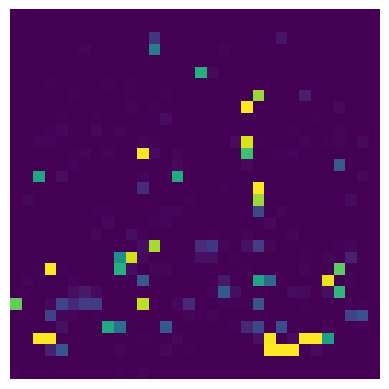

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reverse_engineer(param = {
    "dataset": "cifar10",
    "Epochs": 100,
    "batch_size": 64,
    "target_label": 1,
    "cost_lambda": 1e-3,
    "num_classes": 10,
    "image_size": (32, 32)}, model = torch.load('model_cifar10_0.15_1.pkl').to(device))

### Target Label = 2, Injection Rate = 0.15

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
param = {
    "dataset": "cifar10",
    "model": "default",
    "poisoning_method": "badnet",
    "injection_rate": 0.15,
    "target_label": 2,
    "Epochs": 150,
    "batch_size": 64
    }
fill_param(param)
train(param)

170498071/170498071 [==============================] - 2s 0us/step


Testing...: 100%|██████████| 157/157 [00:00<00:00, 295.52it/s]


Epoch: 1, Training Accuracy: 50.308, Testing Accuracy: 56.18, Testing ASR: 97.2


Testing...: 100%|██████████| 157/157 [00:00<00:00, 353.03it/s]


Epoch: 2, Training Accuracy: 65.642, Testing Accuracy: 63.92, Testing ASR: 95.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 347.15it/s]


Epoch: 3, Training Accuracy: 71.192, Testing Accuracy: 72.49, Testing ASR: 96.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 303.66it/s]


Epoch: 4, Training Accuracy: 74.436, Testing Accuracy: 73.99, Testing ASR: 97.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 359.13it/s]


Epoch: 5, Training Accuracy: 76.612, Testing Accuracy: 71.62, Testing ASR: 98.28


Testing...: 100%|██████████| 157/157 [00:00<00:00, 332.96it/s]


Epoch: 6, Training Accuracy: 78.11, Testing Accuracy: 58.51, Testing ASR: 96.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 318.98it/s]


Epoch: 7, Training Accuracy: 79.608, Testing Accuracy: 77.97, Testing ASR: 97.16


Testing...: 100%|██████████| 157/157 [00:00<00:00, 293.92it/s]


Epoch: 8, Training Accuracy: 80.686, Testing Accuracy: 71.02, Testing ASR: 96.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 355.51it/s]


Epoch: 9, Training Accuracy: 82.028, Testing Accuracy: 74.54, Testing ASR: 96.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 273.83it/s]


Epoch: 10, Training Accuracy: 82.706, Testing Accuracy: 78.72, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 358.76it/s]


Epoch: 11, Training Accuracy: 83.512, Testing Accuracy: 80.51, Testing ASR: 97.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 345.13it/s]


Epoch: 12, Training Accuracy: 84.288, Testing Accuracy: 80.47, Testing ASR: 96.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 346.56it/s]


Epoch: 13, Training Accuracy: 84.776, Testing Accuracy: 81.16, Testing ASR: 97.28


Testing...: 100%|██████████| 157/157 [00:00<00:00, 359.82it/s]


Epoch: 14, Training Accuracy: 85.442, Testing Accuracy: 80.16, Testing ASR: 96.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 313.84it/s]


Epoch: 15, Training Accuracy: 85.934, Testing Accuracy: 79.71, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 356.12it/s]


Epoch: 16, Training Accuracy: 86.598, Testing Accuracy: 81.93, Testing ASR: 97.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 270.74it/s]


Epoch: 17, Training Accuracy: 86.828, Testing Accuracy: 81.11, Testing ASR: 97.54


Testing...: 100%|██████████| 157/157 [00:00<00:00, 354.21it/s]


Epoch: 18, Training Accuracy: 87.156, Testing Accuracy: 81.22, Testing ASR: 96.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 313.04it/s]


Epoch: 19, Training Accuracy: 87.6, Testing Accuracy: 81.09, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 325.43it/s]


Epoch: 20, Training Accuracy: 87.796, Testing Accuracy: 81.99, Testing ASR: 97.51


Testing...: 100%|██████████| 157/157 [00:00<00:00, 345.20it/s]


Epoch: 21, Training Accuracy: 88.28, Testing Accuracy: 81.55, Testing ASR: 98.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 358.61it/s]


Epoch: 22, Training Accuracy: 88.712, Testing Accuracy: 81.15, Testing ASR: 98.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 288.68it/s]


Epoch: 23, Training Accuracy: 88.91, Testing Accuracy: 81.15, Testing ASR: 96.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 348.60it/s]


Epoch: 24, Training Accuracy: 89.208, Testing Accuracy: 81.48, Testing ASR: 97.33


Testing...: 100%|██████████| 157/157 [00:00<00:00, 327.93it/s]


Epoch: 25, Training Accuracy: 89.516, Testing Accuracy: 81.81, Testing ASR: 97.45


Testing...: 100%|██████████| 157/157 [00:00<00:00, 352.23it/s]


Epoch: 26, Training Accuracy: 89.5, Testing Accuracy: 76.33, Testing ASR: 97.3


Testing...: 100%|██████████| 157/157 [00:00<00:00, 308.90it/s]


Epoch: 27, Training Accuracy: 89.714, Testing Accuracy: 80.5, Testing ASR: 96.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 335.12it/s]


Epoch: 28, Training Accuracy: 90.116, Testing Accuracy: 82.39, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 295.98it/s]


Epoch: 29, Training Accuracy: 90.356, Testing Accuracy: 81.79, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 281.85it/s]


Epoch: 30, Training Accuracy: 90.562, Testing Accuracy: 82.42, Testing ASR: 97.46


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.61it/s]


Epoch: 31, Training Accuracy: 90.7, Testing Accuracy: 82.44, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 309.43it/s]


Epoch: 32, Training Accuracy: 90.896, Testing Accuracy: 82.87, Testing ASR: 97.55


Testing...: 100%|██████████| 157/157 [00:00<00:00, 301.60it/s]


Epoch: 33, Training Accuracy: 90.886, Testing Accuracy: 82.34, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 294.03it/s]


Epoch: 34, Training Accuracy: 91.322, Testing Accuracy: 82.0, Testing ASR: 97.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 347.36it/s]


Epoch: 35, Training Accuracy: 91.336, Testing Accuracy: 81.63, Testing ASR: 97.51


Testing...: 100%|██████████| 157/157 [00:00<00:00, 343.64it/s]


Epoch: 36, Training Accuracy: 91.694, Testing Accuracy: 82.31, Testing ASR: 97.39


Testing...: 100%|██████████| 157/157 [00:00<00:00, 349.31it/s]


Epoch: 37, Training Accuracy: 91.496, Testing Accuracy: 82.17, Testing ASR: 98.02


Testing...: 100%|██████████| 157/157 [00:00<00:00, 322.13it/s]


Epoch: 38, Training Accuracy: 91.726, Testing Accuracy: 81.57, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 357.44it/s]


Epoch: 39, Training Accuracy: 91.918, Testing Accuracy: 82.51, Testing ASR: 97.54


Testing...: 100%|██████████| 157/157 [00:00<00:00, 335.19it/s]


Epoch: 40, Training Accuracy: 91.928, Testing Accuracy: 81.92, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 327.05it/s]


Epoch: 41, Training Accuracy: 92.174, Testing Accuracy: 82.26, Testing ASR: 97.59


Testing...: 100%|██████████| 157/157 [00:00<00:00, 334.57it/s]


Epoch: 42, Training Accuracy: 92.192, Testing Accuracy: 82.24, Testing ASR: 98.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 323.55it/s]


Epoch: 43, Training Accuracy: 92.37, Testing Accuracy: 82.16, Testing ASR: 97.28


Testing...: 100%|██████████| 157/157 [00:00<00:00, 341.33it/s]


Epoch: 44, Training Accuracy: 92.526, Testing Accuracy: 80.23, Testing ASR: 96.53


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.87it/s]


Epoch: 45, Training Accuracy: 92.662, Testing Accuracy: 82.84, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 354.97it/s]


Epoch: 46, Training Accuracy: 92.56, Testing Accuracy: 82.19, Testing ASR: 97.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 340.60it/s]


Epoch: 47, Training Accuracy: 92.67, Testing Accuracy: 82.47, Testing ASR: 97.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 350.72it/s]


Epoch: 48, Training Accuracy: 92.78, Testing Accuracy: 82.39, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 295.05it/s]


Epoch: 49, Training Accuracy: 92.946, Testing Accuracy: 82.37, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 326.76it/s]


Epoch: 50, Training Accuracy: 93.074, Testing Accuracy: 78.65, Testing ASR: 97.5


Testing...: 100%|██████████| 157/157 [00:00<00:00, 334.45it/s]


Epoch: 51, Training Accuracy: 93.186, Testing Accuracy: 81.63, Testing ASR: 97.54


Testing...: 100%|██████████| 157/157 [00:00<00:00, 305.94it/s]


Epoch: 52, Training Accuracy: 92.994, Testing Accuracy: 82.28, Testing ASR: 98.27


Testing...: 100%|██████████| 157/157 [00:00<00:00, 294.38it/s]


Epoch: 53, Training Accuracy: 93.292, Testing Accuracy: 82.7, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.15it/s]


Epoch: 54, Training Accuracy: 93.11, Testing Accuracy: 82.62, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 350.77it/s]


Epoch: 55, Training Accuracy: 93.596, Testing Accuracy: 82.79, Testing ASR: 97.3


Testing...: 100%|██████████| 157/157 [00:00<00:00, 293.93it/s]


Epoch: 56, Training Accuracy: 93.414, Testing Accuracy: 82.85, Testing ASR: 97.93


Testing...: 100%|██████████| 157/157 [00:00<00:00, 333.69it/s]


Epoch: 57, Training Accuracy: 93.698, Testing Accuracy: 82.26, Testing ASR: 97.61


Testing...: 100%|██████████| 157/157 [00:00<00:00, 294.72it/s]


Epoch: 58, Training Accuracy: 93.352, Testing Accuracy: 82.69, Testing ASR: 97.53


Testing...: 100%|██████████| 157/157 [00:00<00:00, 330.30it/s]


Epoch: 59, Training Accuracy: 93.512, Testing Accuracy: 82.67, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 335.68it/s]


Epoch: 60, Training Accuracy: 93.736, Testing Accuracy: 82.75, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 336.42it/s]


Epoch: 61, Training Accuracy: 93.828, Testing Accuracy: 82.71, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 320.74it/s]


Epoch: 62, Training Accuracy: 93.808, Testing Accuracy: 82.65, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 334.71it/s]


Epoch: 63, Training Accuracy: 93.836, Testing Accuracy: 81.46, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 322.69it/s]


Epoch: 64, Training Accuracy: 93.886, Testing Accuracy: 80.58, Testing ASR: 96.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 320.35it/s]


Epoch: 65, Training Accuracy: 94.092, Testing Accuracy: 82.63, Testing ASR: 97.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 333.19it/s]


Epoch: 66, Training Accuracy: 94.232, Testing Accuracy: 83.06, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 345.59it/s]


Epoch: 67, Training Accuracy: 94.102, Testing Accuracy: 82.49, Testing ASR: 97.28


Testing...: 100%|██████████| 157/157 [00:00<00:00, 307.04it/s]


Epoch: 68, Training Accuracy: 94.414, Testing Accuracy: 82.72, Testing ASR: 98.29


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.07it/s]


Epoch: 69, Training Accuracy: 94.204, Testing Accuracy: 82.64, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 345.30it/s]


Epoch: 70, Training Accuracy: 94.276, Testing Accuracy: 82.18, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 337.95it/s]


Epoch: 71, Training Accuracy: 94.196, Testing Accuracy: 82.52, Testing ASR: 97.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 320.93it/s]


Epoch: 72, Training Accuracy: 94.282, Testing Accuracy: 83.28, Testing ASR: 97.52


Testing...: 100%|██████████| 157/157 [00:00<00:00, 335.68it/s]


Epoch: 73, Training Accuracy: 94.502, Testing Accuracy: 83.04, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 351.95it/s]


Epoch: 74, Training Accuracy: 94.678, Testing Accuracy: 83.34, Testing ASR: 97.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 341.15it/s]


Epoch: 75, Training Accuracy: 94.608, Testing Accuracy: 83.05, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 339.90it/s]


Epoch: 76, Training Accuracy: 94.422, Testing Accuracy: 83.18, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 339.19it/s]


Epoch: 77, Training Accuracy: 94.602, Testing Accuracy: 83.21, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 330.26it/s]


Epoch: 78, Training Accuracy: 94.564, Testing Accuracy: 83.02, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 328.18it/s]


Epoch: 79, Training Accuracy: 94.664, Testing Accuracy: 83.16, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 342.31it/s]


Epoch: 80, Training Accuracy: 94.852, Testing Accuracy: 82.94, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 341.28it/s]


Epoch: 81, Training Accuracy: 95.392, Testing Accuracy: 83.07, Testing ASR: 97.41


Testing...: 100%|██████████| 157/157 [00:00<00:00, 335.59it/s]


Epoch: 82, Training Accuracy: 95.698, Testing Accuracy: 83.41, Testing ASR: 97.57


Testing...: 100%|██████████| 157/157 [00:00<00:00, 320.20it/s]


Epoch: 83, Training Accuracy: 95.882, Testing Accuracy: 83.15, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 309.40it/s]


Epoch: 84, Training Accuracy: 95.944, Testing Accuracy: 83.59, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 338.04it/s]


Epoch: 85, Training Accuracy: 96.084, Testing Accuracy: 83.45, Testing ASR: 97.98


Testing...: 100%|██████████| 157/157 [00:00<00:00, 303.63it/s]


Epoch: 86, Training Accuracy: 96.278, Testing Accuracy: 83.55, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 338.84it/s]


Epoch: 87, Training Accuracy: 96.158, Testing Accuracy: 83.49, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 338.86it/s]


Epoch: 88, Training Accuracy: 96.208, Testing Accuracy: 82.54, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.75it/s]


Epoch: 89, Training Accuracy: 96.45, Testing Accuracy: 83.42, Testing ASR: 97.59


Testing...: 100%|██████████| 157/157 [00:00<00:00, 340.94it/s]


Epoch: 90, Training Accuracy: 96.43, Testing Accuracy: 83.59, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 349.13it/s]


Epoch: 91, Training Accuracy: 96.49, Testing Accuracy: 83.52, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 342.13it/s]


Epoch: 92, Training Accuracy: 96.302, Testing Accuracy: 83.36, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 331.88it/s]


Epoch: 93, Training Accuracy: 96.372, Testing Accuracy: 83.58, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 332.98it/s]


Epoch: 94, Training Accuracy: 96.568, Testing Accuracy: 83.41, Testing ASR: 97.6


Testing...: 100%|██████████| 157/157 [00:00<00:00, 355.24it/s]


Epoch: 95, Training Accuracy: 96.34, Testing Accuracy: 83.75, Testing ASR: 97.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 352.22it/s]


Epoch: 96, Training Accuracy: 96.606, Testing Accuracy: 83.4, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 343.84it/s]


Epoch: 97, Training Accuracy: 96.524, Testing Accuracy: 83.13, Testing ASR: 97.34


Testing...: 100%|██████████| 157/157 [00:00<00:00, 354.85it/s]


Epoch: 98, Training Accuracy: 96.54, Testing Accuracy: 83.38, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 278.13it/s]


Epoch: 99, Training Accuracy: 96.588, Testing Accuracy: 83.77, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 305.30it/s]


Epoch: 100, Training Accuracy: 96.612, Testing Accuracy: 83.31, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 355.08it/s]


Epoch: 101, Training Accuracy: 97.008, Testing Accuracy: 83.61, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 336.41it/s]


Epoch: 102, Training Accuracy: 97.098, Testing Accuracy: 83.53, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 341.09it/s]


Epoch: 103, Training Accuracy: 97.044, Testing Accuracy: 83.46, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 340.74it/s]


Epoch: 104, Training Accuracy: 97.174, Testing Accuracy: 83.62, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 336.35it/s]


Epoch: 105, Training Accuracy: 97.216, Testing Accuracy: 83.58, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 333.69it/s]


Epoch: 106, Training Accuracy: 97.25, Testing Accuracy: 83.65, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 350.86it/s]


Epoch: 107, Training Accuracy: 97.274, Testing Accuracy: 83.67, Testing ASR: 97.93


Testing...: 100%|██████████| 157/157 [00:00<00:00, 303.26it/s]


Epoch: 108, Training Accuracy: 97.348, Testing Accuracy: 83.71, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 284.01it/s]


Epoch: 109, Training Accuracy: 97.252, Testing Accuracy: 83.64, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 342.05it/s]


Epoch: 110, Training Accuracy: 97.24, Testing Accuracy: 83.87, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 343.03it/s]


Epoch: 111, Training Accuracy: 97.322, Testing Accuracy: 83.76, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 286.92it/s]


Epoch: 112, Training Accuracy: 97.446, Testing Accuracy: 83.69, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 319.33it/s]


Epoch: 113, Training Accuracy: 97.44, Testing Accuracy: 83.86, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 319.97it/s]


Epoch: 114, Training Accuracy: 97.434, Testing Accuracy: 83.72, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 335.44it/s]


Epoch: 115, Training Accuracy: 97.434, Testing Accuracy: 83.88, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 330.70it/s]


Epoch: 116, Training Accuracy: 97.482, Testing Accuracy: 83.8, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 346.88it/s]


Epoch: 117, Training Accuracy: 97.502, Testing Accuracy: 83.96, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 347.90it/s]


Epoch: 118, Training Accuracy: 97.516, Testing Accuracy: 83.74, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 341.27it/s]


Epoch: 119, Training Accuracy: 97.692, Testing Accuracy: 83.78, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 337.16it/s]


Epoch: 120, Training Accuracy: 97.506, Testing Accuracy: 83.86, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 299.32it/s]


Epoch: 121, Training Accuracy: 97.592, Testing Accuracy: 83.86, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 335.28it/s]


Epoch: 122, Training Accuracy: 97.62, Testing Accuracy: 83.61, Testing ASR: 97.97


Testing...: 100%|██████████| 157/157 [00:00<00:00, 348.53it/s]


Epoch: 123, Training Accuracy: 97.438, Testing Accuracy: 83.87, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 319.57it/s]


Epoch: 124, Training Accuracy: 97.568, Testing Accuracy: 83.74, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 327.83it/s]


Epoch: 125, Training Accuracy: 97.544, Testing Accuracy: 83.78, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 331.99it/s]


Epoch: 126, Training Accuracy: 97.706, Testing Accuracy: 83.68, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.41it/s]


Epoch: 127, Training Accuracy: 97.532, Testing Accuracy: 83.73, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 331.45it/s]


Epoch: 128, Training Accuracy: 97.58, Testing Accuracy: 83.82, Testing ASR: 97.93


Testing...: 100%|██████████| 157/157 [00:00<00:00, 345.49it/s]


Epoch: 129, Training Accuracy: 97.66, Testing Accuracy: 83.86, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 329.63it/s]


Epoch: 130, Training Accuracy: 97.626, Testing Accuracy: 83.77, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 311.28it/s]


Epoch: 131, Training Accuracy: 97.668, Testing Accuracy: 83.83, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 332.43it/s]


Epoch: 132, Training Accuracy: 97.71, Testing Accuracy: 83.65, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 339.26it/s]


Epoch: 133, Training Accuracy: 97.578, Testing Accuracy: 83.58, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 349.94it/s]


Epoch: 134, Training Accuracy: 97.618, Testing Accuracy: 83.46, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 358.35it/s]


Epoch: 135, Training Accuracy: 97.652, Testing Accuracy: 83.78, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 313.82it/s]


Epoch: 136, Training Accuracy: 97.752, Testing Accuracy: 83.84, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 328.40it/s]


Epoch: 137, Training Accuracy: 97.772, Testing Accuracy: 83.76, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 293.13it/s]


Epoch: 138, Training Accuracy: 97.71, Testing Accuracy: 83.86, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 302.56it/s]


Epoch: 139, Training Accuracy: 97.76, Testing Accuracy: 83.71, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 348.69it/s]


Epoch: 140, Training Accuracy: 97.7, Testing Accuracy: 83.69, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 336.69it/s]


Epoch: 141, Training Accuracy: 97.804, Testing Accuracy: 83.63, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 339.21it/s]


Epoch: 142, Training Accuracy: 97.74, Testing Accuracy: 83.69, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 345.59it/s]


Epoch: 143, Training Accuracy: 97.82, Testing Accuracy: 83.57, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 342.80it/s]


Epoch: 144, Training Accuracy: 97.74, Testing Accuracy: 83.73, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 313.33it/s]


Epoch: 145, Training Accuracy: 97.71, Testing Accuracy: 83.72, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 308.41it/s]


Epoch: 146, Training Accuracy: 97.75, Testing Accuracy: 83.71, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 330.52it/s]


Epoch: 147, Training Accuracy: 97.872, Testing Accuracy: 83.59, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 330.21it/s]


Epoch: 148, Training Accuracy: 97.838, Testing Accuracy: 83.59, Testing ASR: 97.93


Testing...: 100%|██████████| 157/157 [00:00<00:00, 358.79it/s]


Epoch: 149, Training Accuracy: 97.718, Testing Accuracy: 83.66, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 342.03it/s]


Epoch: 150, Training Accuracy: 97.84, Testing Accuracy: 83.95, Testing ASR: 97.89


Processing label: 0


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 104.89it/s]


norm: 495.11798095703125


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 111.05it/s]


norm: 454.13140869140625


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 111.89it/s]


norm: 404.4563903808594


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 107.30it/s]


norm: 351.06329345703125


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 108.19it/s]


norm: 297.65020751953125


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 108.63it/s]


norm: 248.57638549804688


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 108.49it/s]


norm: 205.11245727539062


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 106.58it/s]


norm: 172.95950317382812


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 104.70it/s]


norm: 147.19459533691406


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 106.89it/s]


norm: 127.27462768554688


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 107.86it/s]


norm: 112.52867126464844


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 106.71it/s]


norm: 99.71138000488281


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 104.66it/s]


norm: 88.77686309814453


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 106.17it/s]


norm: 81.14263153076172


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 106.66it/s]


norm: 76.46182250976562


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 104.27it/s]


norm: 72.248291015625


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 108.28it/s]


norm: 68.42041778564453


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 99.56it/s] 


norm: 64.7064208984375


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 98.49it/s]


norm: 61.88185119628906


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 106.74it/s]


norm: 59.34506607055664


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 105.40it/s]


norm: 56.81404113769531


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 105.98it/s]


norm: 55.23003005981445


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 105.11it/s]


norm: 53.4135856628418


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 105.26it/s]


norm: 51.92689514160156


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 103.08it/s]


norm: 50.09722137451172


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 105.55it/s]


norm: 51.98175048828125


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 107.94it/s]


norm: 48.330657958984375


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 107.57it/s]


norm: 46.90894317626953


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 105.72it/s]


norm: 46.53532791137695


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 106.75it/s]


norm: 46.126983642578125


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 101.92it/s]


norm: 46.404727935791016


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 102.19it/s]


norm: 46.30912780761719


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 102.38it/s]


norm: 45.29088592529297


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 106.59it/s]


norm: 43.308502197265625


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 103.67it/s]


norm: 42.847312927246094


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 105.63it/s]


norm: 44.327754974365234


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 106.05it/s]


norm: 43.24575424194336


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 107.54it/s]


norm: 43.0914306640625


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 106.49it/s]


norm: 42.52788543701172


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 102.43it/s]


norm: 40.972251892089844


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 105.60it/s]


norm: 40.814613342285156


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 104.96it/s]


norm: 40.70536804199219


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 104.11it/s]


norm: 40.307334899902344


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 106.23it/s]


norm: 40.53435134887695


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 107.85it/s]


norm: 40.36273956298828


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 105.01it/s]


norm: 40.75047302246094


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 105.18it/s]


norm: 39.96927261352539


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 107.25it/s]


norm: 39.82633972167969


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 97.33it/s]


norm: 39.390724182128906


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 103.60it/s]


norm: 39.277313232421875


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 105.75it/s]


norm: 39.16461944580078


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 107.33it/s]


norm: 38.94837188720703


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 106.69it/s]


norm: 38.72103500366211


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 106.78it/s]


norm: 39.34282684326172


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 105.97it/s]


norm: 39.1878776550293


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 102.98it/s]


norm: 39.217411041259766


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 97.41it/s] 


norm: 39.483909606933594


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 99.05it/s] 


norm: 39.2873420715332


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 105.74it/s]


norm: 39.33368682861328


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 104.19it/s]


norm: 39.34263610839844


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 100.22it/s]


norm: 39.33665466308594


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 107.75it/s]


norm: 39.81315994262695


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 104.83it/s]


norm: 41.22967529296875


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 103.43it/s]


norm: 40.36779022216797


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 101.11it/s]


norm: 39.95155334472656


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 101.78it/s]


norm: 39.376129150390625


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 105.60it/s]


norm: 38.430606842041016


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 99.14it/s] 


norm: 39.094783782958984


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 101.66it/s]


norm: 37.824745178222656


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 100.66it/s]


norm: 39.39361572265625


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 104.02it/s]


norm: 37.97377014160156


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 105.90it/s]


norm: 38.83522033691406


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 106.42it/s]


norm: 38.99699783325195


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 106.81it/s]


norm: 38.753150939941406


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 105.57it/s]


norm: 38.807769775390625


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 108.43it/s]


norm: 37.340579986572266


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 104.27it/s]


norm: 39.29910659790039


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 105.37it/s]


norm: 36.775962829589844


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 107.93it/s]


norm: 37.13298034667969


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 108.98it/s]


norm: 36.67359924316406


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 105.63it/s]


norm: 36.25754928588867


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 99.25it/s] 


norm: 36.415374755859375


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 104.56it/s]


norm: 37.516029357910156


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 105.62it/s]


norm: 34.452362060546875


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 107.40it/s]


norm: 35.5959587097168


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 105.95it/s]


norm: 33.55879211425781


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 105.78it/s]


norm: 34.547908782958984


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 104.84it/s]


norm: 34.49577331542969


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 102.13it/s]


norm: 35.28579330444336


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 108.98it/s]


norm: 35.52961730957031


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 107.50it/s]


norm: 35.05836868286133


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 108.71it/s]


norm: 37.31420135498047


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 107.09it/s]


norm: 36.70829391479492


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 107.89it/s]


norm: 35.599082946777344


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 102.89it/s]


norm: 36.04737091064453


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 106.70it/s]


norm: 35.76541519165039


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 106.72it/s]


norm: 34.48517990112305


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 102.91it/s]


norm: 33.854949951171875


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 106.55it/s]


norm: 33.88951110839844


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 105.54it/s]


norm: 33.38346862792969
Processing label: 1


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 104.69it/s]


norm: 483.4088134765625


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 107.52it/s]


norm: 430.837646484375


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 105.46it/s]


norm: 370.29034423828125


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 107.11it/s]


norm: 311.73602294921875


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 106.81it/s]


norm: 258.8369140625


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 108.54it/s]


norm: 215.08447265625


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 105.37it/s]


norm: 179.53936767578125


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 108.23it/s]


norm: 152.1732177734375


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 106.37it/s]


norm: 130.88180541992188


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 107.56it/s]


norm: 114.51887512207031


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 106.94it/s]


norm: 99.25386047363281


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 107.05it/s]


norm: 90.53877258300781


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 107.66it/s]


norm: 81.06541442871094


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 102.81it/s]


norm: 74.83443450927734


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 97.60it/s] 


norm: 70.66923522949219


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 104.76it/s]


norm: 65.7637939453125


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 106.13it/s]


norm: 65.03923797607422


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 106.19it/s]


norm: 63.19786071777344


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 105.53it/s]


norm: 61.35559844970703


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 107.48it/s]


norm: 58.530967712402344


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 101.85it/s]


norm: 57.37859344482422


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 99.84it/s] 


norm: 55.539161682128906


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 106.77it/s]


norm: 53.647247314453125


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 106.66it/s]


norm: 52.5038948059082


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 107.52it/s]


norm: 50.923744201660156


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 101.78it/s]


norm: 50.608856201171875


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 108.39it/s]


norm: 49.273582458496094


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 106.82it/s]


norm: 50.27507400512695


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 99.17it/s] 


norm: 49.17925262451172


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 107.18it/s]


norm: 49.08367919921875


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 108.61it/s]


norm: 47.764549255371094


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 104.50it/s]


norm: 47.96296691894531


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 107.19it/s]


norm: 45.79895782470703


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 108.98it/s]


norm: 46.2830810546875


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 106.28it/s]


norm: 45.0774040222168


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 106.49it/s]


norm: 44.36239242553711


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 107.29it/s]


norm: 43.3754997253418


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 107.00it/s]


norm: 43.13050842285156


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 108.69it/s]


norm: 44.239471435546875


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 99.56it/s] 


norm: 43.203529357910156


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 104.94it/s]


norm: 42.860286712646484


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 105.64it/s]


norm: 42.05348587036133


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 104.43it/s]


norm: 41.87413024902344


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 105.38it/s]


norm: 41.97966003417969


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 108.31it/s]


norm: 42.12751007080078


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 107.37it/s]


norm: 42.09128952026367


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 101.58it/s]


norm: 42.315696716308594


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 105.75it/s]


norm: 41.91345977783203


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 109.30it/s]


norm: 42.65373992919922


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 107.59it/s]


norm: 42.71073913574219


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 108.32it/s]


norm: 42.19438171386719


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 106.21it/s]


norm: 41.072608947753906


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 106.65it/s]


norm: 40.40921401977539


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 107.47it/s]


norm: 40.137733459472656


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 106.65it/s]


norm: 39.61516571044922


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 107.32it/s]


norm: 39.098323822021484


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 104.99it/s]


norm: 39.24831771850586


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 108.26it/s]


norm: 39.10850524902344


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 106.29it/s]


norm: 39.432891845703125


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 105.83it/s]


norm: 38.3656005859375


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 105.32it/s]


norm: 38.29888916015625


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 107.04it/s]


norm: 38.46551513671875


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 106.79it/s]


norm: 38.94181823730469


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 107.78it/s]


norm: 38.874900817871094


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 106.94it/s]


norm: 40.25414276123047


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 106.47it/s]


norm: 38.73450469970703


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 106.87it/s]


norm: 38.96522521972656


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 106.66it/s]


norm: 38.96442413330078


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 105.00it/s]


norm: 38.43177795410156


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 107.79it/s]


norm: 38.721229553222656


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 105.41it/s]


norm: 38.50910186767578


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 100.94it/s]


norm: 38.97304916381836


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 107.55it/s]


norm: 39.18994903564453


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 108.05it/s]


norm: 40.07481384277344


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 107.26it/s]


norm: 38.29181671142578


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 104.70it/s]


norm: 39.86943054199219


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 108.15it/s]


norm: 40.917083740234375


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 105.93it/s]


norm: 39.6300163269043


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 105.25it/s]


norm: 39.04768371582031


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 105.12it/s]


norm: 39.19309616088867


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 96.64it/s]


norm: 39.63788986206055


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 104.16it/s]


norm: 38.94660949707031


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 108.37it/s]


norm: 39.563621520996094


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 107.29it/s]


norm: 38.155540466308594


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 105.45it/s]


norm: 38.65887451171875


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 108.86it/s]


norm: 40.15715026855469


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 106.41it/s]


norm: 39.1612434387207


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 102.07it/s]


norm: 38.91408157348633


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 107.04it/s]


norm: 40.044593811035156


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 108.42it/s]


norm: 39.54285430908203


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 109.35it/s]


norm: 37.682960510253906


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 106.27it/s]


norm: 43.547874450683594


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 107.38it/s]


norm: 39.4160041809082


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 105.49it/s]


norm: 38.439273834228516


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 106.49it/s]


norm: 41.02375030517578


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 96.56it/s]


norm: 38.46705627441406


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 103.33it/s]


norm: 38.82883071899414


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 103.61it/s]


norm: 38.040985107421875


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 98.67it/s]


norm: 37.380767822265625


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 104.05it/s]


norm: 39.17167663574219
Processing label: 2


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 102.18it/s]


norm: 458.1182861328125


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 104.89it/s]


norm: 368.32403564453125


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 108.68it/s]


norm: 286.3427429199219


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 108.38it/s]


norm: 223.46890258789062


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 106.29it/s]


norm: 177.6597900390625


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 106.57it/s]


norm: 145.10879516601562


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 106.18it/s]


norm: 118.87339782714844


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 106.32it/s]


norm: 93.61671447753906


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 102.97it/s]


norm: 68.02250671386719


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 107.24it/s]


norm: 52.286415100097656


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 99.46it/s] 


norm: 38.34636688232422


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 98.80it/s]


norm: 28.497745513916016


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 106.67it/s]


norm: 21.794330596923828


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 106.66it/s]


norm: 18.616539001464844


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 104.28it/s]


norm: 14.599905014038086


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 102.70it/s]


norm: 12.646414756774902


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 106.06it/s]


norm: 10.708765029907227


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 105.14it/s]


norm: 10.028608322143555


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 105.23it/s]


norm: 10.151327133178711


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 106.52it/s]


norm: 11.622146606445312


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 97.96it/s]


norm: 8.629252433776855


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 98.97it/s]


norm: 8.755337715148926


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 104.70it/s]


norm: 7.609947681427002


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 106.91it/s]


norm: 7.687614917755127


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 105.37it/s]


norm: 8.57199478149414


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 97.17it/s]


norm: 7.290317535400391


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 106.95it/s]


norm: 6.332493782043457


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 109.31it/s]


norm: 8.403584480285645


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 106.69it/s]


norm: 6.583911418914795


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 107.98it/s]


norm: 7.044502258300781


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 105.52it/s]


norm: 6.856908321380615


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 108.59it/s]


norm: 8.736330032348633


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 106.82it/s]


norm: 7.763108253479004


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 107.82it/s]


norm: 6.654719829559326


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 106.27it/s]


norm: 6.69744348526001


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 107.28it/s]


norm: 6.9060821533203125


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 106.31it/s]


norm: 6.8939409255981445


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 107.38it/s]


norm: 6.087700843811035


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 108.77it/s]


norm: 6.34366512298584


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 105.37it/s]


norm: 8.547500610351562


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 108.04it/s]


norm: 8.12968921661377


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 108.01it/s]


norm: 6.898916244506836


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 102.01it/s]


norm: 7.099016189575195


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 99.39it/s] 


norm: 6.352481365203857


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 101.83it/s]


norm: 6.645413398742676


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 98.88it/s] 


norm: 5.978583812713623


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 102.12it/s]


norm: 6.341118335723877


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 105.96it/s]


norm: 6.767498970031738


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 106.91it/s]


norm: 5.895063400268555


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 108.71it/s]


norm: 6.169814109802246


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 107.82it/s]


norm: 6.928505897521973


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 108.42it/s]


norm: 6.092555046081543


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 109.74it/s]


norm: 6.429242134094238


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 109.59it/s]


norm: 8.73244857788086


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 105.84it/s]


norm: 6.63402795791626


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 108.69it/s]


norm: 6.651641845703125


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 106.47it/s]


norm: 7.075047492980957


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 105.53it/s]


norm: 6.116018295288086


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 105.86it/s]


norm: 6.394783020019531


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 105.26it/s]


norm: 7.423410892486572


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 105.89it/s]


norm: 6.036703109741211


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 105.09it/s]


norm: 6.2308430671691895


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 109.58it/s]


norm: 6.367580413818359


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 106.99it/s]


norm: 5.758358001708984


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 106.58it/s]


norm: 6.069599151611328


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 109.46it/s]


norm: 5.838446617126465


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 108.99it/s]


norm: 7.893752098083496


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 108.90it/s]


norm: 6.203548431396484


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 106.21it/s]


norm: 6.242950439453125


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 107.24it/s]


norm: 6.773799896240234


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 108.62it/s]


norm: 5.906970024108887


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 104.96it/s]


norm: 6.1672749519348145


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 107.12it/s]


norm: 7.258830547332764


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 106.66it/s]


norm: 7.837347507476807


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 108.59it/s]


norm: 6.2971601486206055


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 105.09it/s]


norm: 6.239369869232178


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 107.45it/s]


norm: 6.685501575469971


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 107.66it/s]


norm: 5.929177284240723


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 105.62it/s]


norm: 6.206574440002441


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 106.88it/s]


norm: 8.119584083557129


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 109.29it/s]


norm: 6.358805179595947


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 107.22it/s]


norm: 6.643596172332764


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 105.88it/s]


norm: 7.340818405151367


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 106.66it/s]


norm: 6.244009494781494


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 108.28it/s]


norm: 6.385777473449707


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 101.03it/s]


norm: 7.073037624359131


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 100.00it/s]


norm: 5.962067127227783


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 106.74it/s]


norm: 6.238389015197754


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 105.80it/s]


norm: 8.53390121459961


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 105.34it/s]


norm: 6.556987285614014


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 105.92it/s]


norm: 7.040215015411377


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 109.10it/s]


norm: 6.923618793487549


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 108.12it/s]


norm: 6.111615180969238


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 108.25it/s]


norm: 6.25853157043457


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 108.90it/s]


norm: 7.4742817878723145
Processing label: 3


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 106.65it/s]


norm: 484.8096923828125


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 107.89it/s]


norm: 430.0712890625


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 107.61it/s]


norm: 369.45587158203125


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 105.94it/s]


norm: 312.9112854003906


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 106.07it/s]


norm: 262.161865234375


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 105.90it/s]


norm: 219.80679321289062


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 107.43it/s]


norm: 184.5062255859375


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 103.89it/s]


norm: 156.47390747070312


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 105.66it/s]


norm: 133.9329833984375


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 107.84it/s]


norm: 117.69769287109375


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 107.74it/s]


norm: 105.14810180664062


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 107.41it/s]


norm: 95.91101837158203


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 107.73it/s]


norm: 88.36144256591797


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 107.12it/s]


norm: 82.15895080566406


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 107.02it/s]


norm: 77.45079803466797


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 107.90it/s]


norm: 73.99189758300781


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 105.95it/s]


norm: 71.66414642333984


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 96.46it/s]


norm: 68.70281982421875


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 105.37it/s]


norm: 66.66046142578125


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 107.29it/s]


norm: 64.90927124023438


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 106.98it/s]


norm: 63.42338562011719


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 97.51it/s]


norm: 61.91033172607422


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 95.77it/s]


norm: 61.29249954223633


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 107.44it/s]


norm: 60.578311920166016


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 107.66it/s]


norm: 59.88370895385742


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 105.55it/s]


norm: 58.40103530883789


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 107.82it/s]


norm: 57.554405212402344


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 106.90it/s]


norm: 56.1136474609375


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 101.10it/s]


norm: 55.10752487182617


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 107.71it/s]


norm: 54.507293701171875


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 108.42it/s]


norm: 54.004180908203125


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 108.01it/s]


norm: 53.259498596191406


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 104.98it/s]


norm: 52.911922454833984


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 105.98it/s]


norm: 52.242828369140625


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 106.30it/s]


norm: 51.858673095703125


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 101.22it/s]


norm: 51.305633544921875


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 98.44it/s] 


norm: 50.90522003173828


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 106.74it/s]


norm: 50.80035400390625


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 97.95it/s]


norm: 50.56550598144531


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 99.91it/s]


norm: 50.239444732666016


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 97.90it/s]


norm: 49.630104064941406


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 98.99it/s]


norm: 48.330013275146484


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 105.02it/s]


norm: 47.81705856323242


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 104.58it/s]


norm: 47.57135009765625


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 105.47it/s]


norm: 47.599708557128906


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 104.55it/s]


norm: 47.511192321777344


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 102.13it/s]


norm: 47.36943054199219


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 99.75it/s] 


norm: 47.29724884033203


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 104.65it/s]


norm: 47.298038482666016


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 106.26it/s]


norm: 47.278839111328125


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 109.42it/s]


norm: 47.392539978027344


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 104.97it/s]


norm: 47.41321563720703


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 105.01it/s]


norm: 47.259822845458984


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 108.59it/s]


norm: 47.3271369934082


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 107.10it/s]


norm: 47.285682678222656


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 108.32it/s]


norm: 47.1733283996582


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 99.18it/s] 


norm: 47.10110092163086


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 103.84it/s]


norm: 47.35126495361328


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 103.85it/s]


norm: 47.09043502807617


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 104.62it/s]


norm: 46.975379943847656


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 101.83it/s]


norm: 46.97831344604492


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 106.13it/s]


norm: 46.81829071044922


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 106.95it/s]


norm: 46.795310974121094


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 106.04it/s]


norm: 46.71330261230469


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 106.23it/s]


norm: 46.60608673095703


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 107.51it/s]


norm: 46.51765441894531


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 107.36it/s]


norm: 46.569297790527344


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 106.03it/s]


norm: 46.427371978759766


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 106.49it/s]


norm: 46.19292449951172


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 100.83it/s]


norm: 46.03601837158203


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 104.82it/s]


norm: 45.82181930541992


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 106.64it/s]


norm: 45.85734558105469


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 107.05it/s]


norm: 45.76917266845703


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 99.67it/s]


norm: 45.73442459106445


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 98.73it/s] 


norm: 45.55015563964844


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 101.46it/s]


norm: 44.83942413330078


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 106.52it/s]


norm: 45.43882751464844


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 107.01it/s]


norm: 45.302520751953125


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 103.69it/s]


norm: 44.71099853515625


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 105.14it/s]


norm: 45.19020080566406


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 101.31it/s]


norm: 45.07972717285156


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 104.98it/s]


norm: 45.03474426269531


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 106.83it/s]


norm: 44.997825622558594


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 104.17it/s]


norm: 44.717185974121094


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 102.87it/s]


norm: 44.9515380859375


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 105.96it/s]


norm: 45.271018981933594


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 108.41it/s]


norm: 45.08735656738281


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 106.23it/s]


norm: 44.942588806152344


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 96.89it/s]


norm: 44.79444885253906


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 104.73it/s]


norm: 44.90264129638672


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 101.60it/s]


norm: 44.939064025878906


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 104.53it/s]


norm: 44.980499267578125


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 107.94it/s]


norm: 44.877906799316406


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 106.61it/s]


norm: 45.29430389404297


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 107.60it/s]


norm: 44.88052749633789


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 106.71it/s]


norm: 45.02364730834961


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 107.88it/s]


norm: 45.20418167114258


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 102.48it/s]


norm: 44.77986145019531


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 103.99it/s]


norm: 44.933597564697266


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 100.44it/s]


norm: 44.8250732421875
Processing label: 4


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 103.14it/s]


norm: 484.55877685546875


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 102.60it/s]


norm: 431.056640625


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 100.41it/s]


norm: 367.1365661621094


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 109.03it/s]


norm: 303.4393615722656


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 108.09it/s]


norm: 247.40403747558594


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 107.22it/s]


norm: 201.3196563720703


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 102.86it/s]


norm: 164.602783203125


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 106.60it/s]


norm: 139.37899780273438


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 106.92it/s]


norm: 117.0418701171875


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 107.38it/s]


norm: 101.08885192871094


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 108.60it/s]


norm: 89.52290344238281


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 104.72it/s]


norm: 82.53883361816406


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 107.85it/s]


norm: 75.60677337646484


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 106.29it/s]


norm: 70.49600982666016


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 107.13it/s]


norm: 65.54964447021484


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 106.58it/s]


norm: 61.96763610839844


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 107.89it/s]


norm: 59.256385803222656


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 101.61it/s]


norm: 57.224430084228516


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 103.20it/s]


norm: 55.58391571044922


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 106.40it/s]


norm: 53.33238983154297


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 107.16it/s]


norm: 51.53996276855469


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 107.92it/s]


norm: 50.92519760131836


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 106.84it/s]


norm: 50.50889587402344


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 105.14it/s]


norm: 50.21583557128906


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 106.51it/s]


norm: 49.763607025146484


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 104.16it/s]


norm: 49.429588317871094


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 98.83it/s]


norm: 49.156585693359375


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 105.95it/s]


norm: 48.62242126464844


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 106.02it/s]


norm: 48.47380447387695


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 107.48it/s]


norm: 48.20800018310547


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 110.12it/s]


norm: 48.14602279663086


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 107.30it/s]


norm: 48.156288146972656


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 103.58it/s]


norm: 47.874237060546875


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 107.39it/s]


norm: 47.829345703125


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 106.97it/s]


norm: 47.72086715698242


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 107.31it/s]


norm: 47.432491302490234


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 106.66it/s]


norm: 47.26292419433594


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 106.02it/s]


norm: 47.20634460449219


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 106.61it/s]


norm: 46.9053840637207


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 107.09it/s]


norm: 46.598873138427734


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 109.32it/s]


norm: 46.40074157714844


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 107.62it/s]


norm: 46.179161071777344


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 105.62it/s]


norm: 46.19828796386719


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 101.62it/s]


norm: 46.135833740234375


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 106.37it/s]


norm: 46.23809051513672


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 108.84it/s]


norm: 45.79723358154297


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 107.66it/s]


norm: 45.54573059082031


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 100.24it/s]


norm: 45.27546691894531


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 103.46it/s]


norm: 45.21234893798828


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 106.97it/s]


norm: 45.11210250854492


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 108.45it/s]


norm: 44.98533630371094


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 105.51it/s]


norm: 44.920379638671875


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 97.30it/s] 


norm: 44.88983154296875


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 101.02it/s]


norm: 44.91242980957031


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 104.85it/s]


norm: 44.90237045288086


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 103.79it/s]


norm: 44.79619216918945


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 100.28it/s]


norm: 44.732078552246094


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 99.03it/s] 


norm: 44.71288299560547


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 104.95it/s]


norm: 44.66408920288086


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 105.00it/s]


norm: 44.54043197631836


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 106.82it/s]


norm: 44.413551330566406


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 105.41it/s]


norm: 44.42469787597656


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 102.24it/s]


norm: 44.4598388671875


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 105.44it/s]


norm: 44.23100280761719


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 107.51it/s]


norm: 44.40280532836914


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 99.43it/s]


norm: 44.3365478515625


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 101.89it/s]


norm: 44.179115295410156


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 105.92it/s]


norm: 44.19587326049805


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 107.35it/s]


norm: 44.20394515991211


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 99.67it/s] 


norm: 44.09931945800781


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 108.12it/s]


norm: 43.9616584777832


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 105.34it/s]


norm: 43.97471618652344


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 109.44it/s]


norm: 43.872650146484375


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 105.96it/s]


norm: 44.03953552246094


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 105.28it/s]


norm: 44.04633331298828


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 99.28it/s] 


norm: 44.03321838378906


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 104.92it/s]


norm: 44.19840621948242


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 105.06it/s]


norm: 44.32488250732422


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 105.39it/s]


norm: 44.18617248535156


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 106.39it/s]


norm: 44.014801025390625


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 101.63it/s]


norm: 43.47515106201172


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 97.52it/s]


norm: 43.805137634277344


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 96.50it/s]


norm: 43.423648834228516


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 103.91it/s]


norm: 43.707637786865234


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 106.03it/s]


norm: 43.198089599609375


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 100.33it/s]


norm: 43.52850341796875


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 107.17it/s]


norm: 44.08650207519531


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 106.24it/s]


norm: 42.860477447509766


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 108.43it/s]


norm: 42.92628479003906


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 105.45it/s]


norm: 43.29948425292969


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 107.85it/s]


norm: 42.470848083496094


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 103.46it/s]


norm: 43.341583251953125


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 106.12it/s]


norm: 42.8643913269043


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 108.65it/s]


norm: 43.82236099243164


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 106.72it/s]


norm: 42.848182678222656


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 107.40it/s]


norm: 43.77341079711914


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 105.88it/s]


norm: 43.37493133544922


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 107.96it/s]


norm: 43.78245544433594


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 106.08it/s]


norm: 43.436737060546875


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 105.16it/s]


norm: 44.304080963134766
Processing label: 5


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 105.33it/s]


norm: 513.3036499023438


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 101.18it/s]


norm: 473.1669921875


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 106.07it/s]


norm: 423.77581787109375


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 101.93it/s]


norm: 370.84832763671875


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 105.58it/s]


norm: 318.94500732421875


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 105.18it/s]


norm: 270.12042236328125


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 105.83it/s]


norm: 227.089599609375


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 108.49it/s]


norm: 191.415283203125


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 107.55it/s]


norm: 160.79336547851562


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 102.70it/s]


norm: 136.43035888671875


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 98.57it/s]


norm: 115.92324829101562


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 101.72it/s]


norm: 101.53998565673828


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 107.77it/s]


norm: 91.48857116699219


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 104.83it/s]


norm: 83.09685516357422


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 104.86it/s]


norm: 76.84053802490234


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 101.75it/s]


norm: 72.36712646484375


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 104.94it/s]


norm: 69.16021728515625


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 108.28it/s]


norm: 66.4609146118164


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 106.50it/s]


norm: 63.571678161621094


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 106.48it/s]


norm: 60.49652862548828


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 106.35it/s]


norm: 58.66386413574219


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 106.31it/s]


norm: 57.24905776977539


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 106.35it/s]


norm: 55.938785552978516


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 105.64it/s]


norm: 55.14741516113281


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 108.15it/s]


norm: 55.06627655029297


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 105.11it/s]


norm: 54.25959396362305


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 106.65it/s]


norm: 53.75719451904297


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 105.72it/s]


norm: 53.48347473144531


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 104.08it/s]


norm: 53.07914733886719


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 106.49it/s]


norm: 52.500728607177734


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 106.84it/s]


norm: 52.01675796508789


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 105.93it/s]


norm: 51.46358871459961


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 106.27it/s]


norm: 50.87379837036133


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 106.86it/s]


norm: 50.568115234375


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 107.44it/s]


norm: 50.500816345214844


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 107.83it/s]


norm: 50.252220153808594


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 104.87it/s]


norm: 49.90708923339844


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 98.03it/s]


norm: 49.90412521362305


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 97.01it/s]


norm: 49.29978942871094


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 106.01it/s]


norm: 48.61857223510742


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 107.19it/s]


norm: 48.29656982421875


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 108.71it/s]


norm: 47.327152252197266


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 104.78it/s]


norm: 47.3660888671875


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 105.50it/s]


norm: 47.297386169433594


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 105.45it/s]


norm: 48.28150177001953


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 105.78it/s]


norm: 48.058502197265625


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 103.37it/s]


norm: 46.80537033081055


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 107.94it/s]


norm: 46.3238525390625


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 107.65it/s]


norm: 46.227142333984375


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 100.32it/s]


norm: 45.66881561279297


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 103.79it/s]


norm: 44.79602813720703


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 103.75it/s]


norm: 44.409217834472656


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 106.12it/s]


norm: 44.409000396728516


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 107.70it/s]


norm: 44.41868591308594


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 103.14it/s]


norm: 44.580299377441406


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 102.61it/s]


norm: 44.21852111816406


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 104.66it/s]


norm: 44.40308380126953


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 105.65it/s]


norm: 44.318397521972656


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 103.06it/s]


norm: 44.09162139892578


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 97.67it/s]


norm: 44.022422790527344


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 105.65it/s]


norm: 44.291107177734375


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 104.34it/s]


norm: 44.082298278808594


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 105.00it/s]


norm: 44.951698303222656


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 105.99it/s]


norm: 43.68409729003906


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 107.00it/s]


norm: 44.61930465698242


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 106.25it/s]


norm: 43.76116180419922


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 106.12it/s]


norm: 44.23963928222656


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 102.67it/s]


norm: 43.98421859741211


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 99.26it/s]


norm: 44.13457489013672


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 96.55it/s] 


norm: 44.30194854736328


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 95.94it/s]


norm: 44.08806610107422


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 98.77it/s]


norm: 44.08149719238281


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 96.49it/s]


norm: 44.07843017578125


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 96.25it/s]


norm: 44.22993087768555


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 101.26it/s]


norm: 44.47270202636719


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 106.14it/s]


norm: 44.03167724609375


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 101.47it/s]


norm: 44.16148376464844


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 103.64it/s]


norm: 43.64899826049805


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 99.59it/s] 


norm: 44.242431640625


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 104.47it/s]


norm: 43.989891052246094


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 99.25it/s]


norm: 44.119712829589844


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 98.43it/s] 


norm: 43.94449234008789


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 104.43it/s]


norm: 43.98102569580078


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 99.78it/s]


norm: 43.916526794433594


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 106.17it/s]


norm: 43.944942474365234


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 103.37it/s]


norm: 43.83094024658203


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 100.31it/s]


norm: 44.16667175292969


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 98.65it/s] 


norm: 43.72736358642578


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 96.70it/s]


norm: 44.223854064941406


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 104.27it/s]


norm: 44.33610534667969


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 104.20it/s]


norm: 43.62150192260742


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 103.60it/s]


norm: 44.42515563964844


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 99.12it/s]


norm: 43.348854064941406


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 102.20it/s]


norm: 44.59599685668945


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 99.23it/s] 


norm: 43.53676223754883


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 102.96it/s]


norm: 44.40522766113281


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 99.52it/s]


norm: 43.65716552734375


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 97.41it/s] 


norm: 43.808128356933594


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 97.15it/s]


norm: 43.96083450317383


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 99.25it/s]


norm: 44.226356506347656
Processing label: 6


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 101.59it/s]


norm: 235.30340576171875


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 105.87it/s]


norm: 134.95086669921875


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 99.15it/s] 


norm: 98.30183410644531


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 100.64it/s]


norm: 81.32888793945312


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 96.34it/s]


norm: 73.23374938964844


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 99.72it/s]


norm: 67.33702087402344


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 97.22it/s]


norm: 64.02725982666016


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 95.49it/s]


norm: 61.08911895751953


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 94.94it/s]


norm: 59.11614990234375


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 95.66it/s]


norm: 56.24989318847656


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 100.28it/s]


norm: 53.62981414794922


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 104.60it/s]


norm: 52.17787170410156


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 100.02it/s]


norm: 51.82762145996094


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 105.65it/s]


norm: 50.62727355957031


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 99.08it/s]


norm: 49.20607376098633


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 104.88it/s]


norm: 48.74201202392578


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 105.33it/s]


norm: 49.51435470581055


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 97.06it/s]


norm: 47.28718185424805


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 96.87it/s]


norm: 45.72264099121094


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 105.89it/s]


norm: 46.27448654174805


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 101.30it/s]


norm: 45.29364776611328


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 101.88it/s]


norm: 45.08574676513672


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 103.23it/s]


norm: 44.1264762878418


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 95.70it/s]


norm: 44.63999938964844


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 97.07it/s]


norm: 42.72591781616211


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 103.47it/s]


norm: 43.124473571777344


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 103.33it/s]


norm: 43.22418212890625


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 105.65it/s]


norm: 43.84950256347656


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 105.41it/s]


norm: 43.46274948120117


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 105.30it/s]


norm: 42.97699737548828


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 104.47it/s]


norm: 43.88359832763672


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 106.20it/s]


norm: 42.49164962768555


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 104.87it/s]


norm: 42.84733581542969


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 102.89it/s]


norm: 42.108558654785156


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 103.88it/s]


norm: 42.68058395385742


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 103.41it/s]


norm: 43.038490295410156


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 104.96it/s]


norm: 43.05684280395508


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 96.70it/s]


norm: 43.55556869506836


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 93.99it/s]


norm: 42.92892837524414


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 96.84it/s] 


norm: 42.245792388916016


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 103.13it/s]


norm: 41.987083435058594


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 96.68it/s]


norm: 43.25366973876953


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 99.21it/s] 


norm: 41.95412063598633


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 105.33it/s]


norm: 43.752349853515625


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 101.62it/s]


norm: 42.60291290283203


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 100.87it/s]


norm: 41.39787292480469


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 102.00it/s]


norm: 42.252159118652344


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 103.80it/s]


norm: 41.671409606933594


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 99.29it/s] 


norm: 42.62727737426758


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 99.88it/s] 


norm: 41.00580978393555


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 99.88it/s] 


norm: 41.69926071166992


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 98.32it/s] 


norm: 40.56388473510742


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 102.87it/s]


norm: 39.798789978027344


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 106.29it/s]


norm: 40.89751434326172


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 100.86it/s]


norm: 41.397003173828125


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 99.54it/s]


norm: 38.641849517822266


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 91.49it/s]


norm: 39.70970153808594


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 93.69it/s]


norm: 38.35155487060547


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 95.36it/s]


norm: 40.33964538574219


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 97.43it/s] 


norm: 40.25402069091797


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 91.89it/s]


norm: 39.77013397216797


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 100.08it/s]


norm: 41.678104400634766


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 98.47it/s]


norm: 40.86209487915039


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 98.45it/s]


norm: 39.693016052246094


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 94.44it/s]


norm: 39.53547286987305


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 104.34it/s]


norm: 39.046695709228516


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 104.21it/s]


norm: 39.413726806640625


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 97.20it/s] 


norm: 40.76066207885742


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 87.18it/s]


norm: 41.03784942626953


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 94.53it/s]


norm: 39.501129150390625


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 101.44it/s]


norm: 39.81525421142578


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 100.41it/s]


norm: 39.51715087890625


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 105.60it/s]


norm: 38.951942443847656


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 104.99it/s]


norm: 42.06717300415039


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 95.59it/s]


norm: 39.162437438964844


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 92.18it/s]


norm: 38.15019989013672


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 102.31it/s]


norm: 37.403892517089844


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 103.33it/s]


norm: 37.82029724121094


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 102.45it/s]


norm: 37.75603103637695


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 105.42it/s]


norm: 38.52165222167969


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 105.65it/s]


norm: 37.120521545410156


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 104.98it/s]


norm: 41.840843200683594


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 104.10it/s]


norm: 40.445518493652344


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 106.31it/s]


norm: 38.48067092895508


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 104.38it/s]


norm: 38.104209899902344


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 105.80it/s]


norm: 37.665069580078125


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 103.94it/s]


norm: 37.73030471801758


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 98.83it/s]


norm: 37.13922119140625


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 105.80it/s]


norm: 38.1065673828125


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 105.84it/s]


norm: 37.639732360839844


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 104.81it/s]


norm: 40.51139450073242


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 99.77it/s] 


norm: 37.73210906982422


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 98.28it/s] 


norm: 39.32953643798828


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 99.56it/s] 


norm: 38.52385711669922


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 101.84it/s]


norm: 36.98407745361328


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 93.96it/s]


norm: 36.65100860595703


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 96.51it/s]


norm: 39.66618728637695


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 100.56it/s]


norm: 36.53575134277344


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 104.33it/s]


norm: 37.80224609375


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 99.48it/s] 


norm: 36.41789245605469
Processing label: 7


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 93.08it/s]


norm: 475.08056640625


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 98.21it/s]


norm: 433.34600830078125


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 101.84it/s]


norm: 382.68280029296875


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 101.95it/s]


norm: 330.3384704589844


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 101.11it/s]


norm: 280.6235046386719


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 101.42it/s]


norm: 235.64077758789062


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 100.31it/s]


norm: 198.60711669921875


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 101.80it/s]


norm: 168.3086700439453


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 102.21it/s]


norm: 143.4178466796875


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 103.11it/s]


norm: 124.05935668945312


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 93.76it/s]


norm: 109.28594207763672


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 95.52it/s]


norm: 98.21400451660156


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 103.02it/s]


norm: 90.06544494628906


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 102.15it/s]


norm: 82.68891143798828


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 94.82it/s]


norm: 77.15287017822266


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 91.75it/s]


norm: 73.08592224121094


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 92.39it/s]


norm: 69.72962951660156


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 93.79it/s]


norm: 66.3511962890625


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 99.25it/s] 


norm: 63.21661376953125


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 99.11it/s] 


norm: 61.270713806152344


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 94.33it/s]


norm: 60.2999267578125


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 95.34it/s]


norm: 58.89947509765625


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 104.51it/s]


norm: 57.61811828613281


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 103.38it/s]


norm: 57.09101104736328


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 101.87it/s]


norm: 56.604209899902344


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 99.11it/s]


norm: 56.0351676940918


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 102.34it/s]


norm: 55.759681701660156


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 104.42it/s]


norm: 55.24955749511719


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 102.52it/s]


norm: 54.955810546875


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 103.58it/s]


norm: 54.202362060546875


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 95.31it/s]


norm: 53.47850036621094


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 91.40it/s]


norm: 53.45417785644531


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 100.23it/s]


norm: 52.53784942626953


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 102.56it/s]


norm: 52.15398025512695


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 99.50it/s] 


norm: 51.6161003112793


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 103.94it/s]


norm: 50.930145263671875


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 102.56it/s]


norm: 50.71687316894531


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 98.49it/s] 


norm: 50.548828125


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 103.16it/s]


norm: 50.12367630004883


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 105.03it/s]


norm: 49.81793212890625


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 105.59it/s]


norm: 49.831993103027344


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 102.82it/s]


norm: 48.752777099609375


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 103.18it/s]


norm: 48.56769943237305


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 105.20it/s]


norm: 48.97400665283203


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 100.45it/s]


norm: 48.18115234375


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 105.04it/s]


norm: 48.1492805480957


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 107.05it/s]


norm: 48.86095428466797


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 99.80it/s] 


norm: 48.35022735595703


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 98.85it/s] 


norm: 48.46289825439453


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 100.75it/s]


norm: 48.57625961303711


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 93.33it/s]


norm: 48.36789321899414


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 96.18it/s] 


norm: 49.96149826049805


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 104.21it/s]


norm: 48.07711410522461


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 99.37it/s]


norm: 50.23643112182617


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 93.72it/s]


norm: 47.701202392578125


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 106.85it/s]


norm: 47.6991081237793


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 104.59it/s]


norm: 47.57160568237305


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 103.67it/s]


norm: 46.83662796020508


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 107.62it/s]


norm: 47.386817932128906


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 108.48it/s]


norm: 47.082420349121094


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 107.29it/s]


norm: 47.79351043701172


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 102.28it/s]


norm: 47.510902404785156


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 97.96it/s] 


norm: 47.14403533935547


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 97.92it/s] 


norm: 47.40486145019531


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 95.81it/s]


norm: 46.685791015625


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 105.76it/s]


norm: 47.67251968383789


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 107.54it/s]


norm: 46.03758239746094


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 100.93it/s]


norm: 47.77374267578125


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 102.85it/s]


norm: 46.142578125


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 101.19it/s]


norm: 48.219459533691406


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 101.48it/s]


norm: 46.05674362182617


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 105.06it/s]


norm: 47.52477264404297


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 105.83it/s]


norm: 46.611183166503906


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 106.89it/s]


norm: 45.94550704956055


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 102.26it/s]


norm: 46.762577056884766


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 97.53it/s]


norm: 45.677024841308594


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 103.17it/s]


norm: 46.26799774169922


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 97.93it/s]


norm: 46.1522102355957


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 103.30it/s]


norm: 47.173160552978516


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 106.27it/s]


norm: 46.174259185791016


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 107.74it/s]


norm: 46.440765380859375


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 101.87it/s]


norm: 46.05451965332031


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 101.96it/s]


norm: 46.8179817199707


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 105.38it/s]


norm: 45.43815994262695


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 105.03it/s]


norm: 45.8982048034668


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 97.65it/s]


norm: 45.38218307495117


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 104.90it/s]


norm: 45.621761322021484


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 97.42it/s] 


norm: 45.81544494628906


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 98.04it/s] 


norm: 45.488075256347656


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 105.28it/s]


norm: 44.6377067565918


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 99.20it/s] 


norm: 45.62693786621094


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 103.58it/s]


norm: 45.256622314453125


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 97.41it/s]


norm: 46.24946212768555


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 105.49it/s]


norm: 44.6092414855957


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 107.40it/s]


norm: 44.076416015625


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 108.17it/s]


norm: 46.510040283203125


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 103.94it/s]


norm: 44.53923034667969


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 107.69it/s]


norm: 45.87127685546875


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 100.63it/s]


norm: 44.04745864868164


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 106.97it/s]


norm: 44.043922424316406
Processing label: 8


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 102.88it/s]


norm: 492.6109619140625


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 98.48it/s] 


norm: 440.4959716796875


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 99.79it/s] 


norm: 380.8040466308594


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 106.12it/s]


norm: 321.6077880859375


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 106.64it/s]


norm: 269.03631591796875


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 102.14it/s]


norm: 222.99114990234375


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 105.65it/s]


norm: 183.6065673828125


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 109.39it/s]


norm: 153.7464141845703


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 103.52it/s]


norm: 131.88262939453125


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 104.06it/s]


norm: 116.0352554321289


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 104.46it/s]


norm: 103.2771987915039


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 97.97it/s]


norm: 92.89051055908203


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 101.30it/s]


norm: 86.05810546875


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 105.43it/s]


norm: 79.90118408203125


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 103.61it/s]


norm: 75.66935729980469


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 103.71it/s]


norm: 72.31512451171875


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 107.30it/s]


norm: 70.11125183105469


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 107.66it/s]


norm: 68.40064239501953


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 101.23it/s]


norm: 66.4071044921875


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 106.35it/s]


norm: 65.1755142211914


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 105.56it/s]


norm: 63.616127014160156


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 104.65it/s]


norm: 63.57986831665039


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 97.84it/s] 


norm: 62.41513442993164


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 106.13it/s]


norm: 61.814491271972656


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 107.11it/s]


norm: 61.221221923828125


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 101.48it/s]


norm: 60.50661849975586


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 96.85it/s]


norm: 60.295928955078125


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 100.53it/s]


norm: 60.149391174316406


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 108.37it/s]


norm: 60.28228759765625


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 105.73it/s]


norm: 59.361610412597656


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 98.99it/s]


norm: 58.760860443115234


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 107.41it/s]


norm: 58.213539123535156


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 103.99it/s]


norm: 57.9208984375


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 103.46it/s]


norm: 58.04375457763672


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 106.97it/s]


norm: 57.674259185791016


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 105.57it/s]


norm: 57.2274055480957


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 107.62it/s]


norm: 56.773841857910156


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 108.15it/s]


norm: 56.482139587402344


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 105.44it/s]


norm: 55.57469940185547


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 104.45it/s]


norm: 56.11591339111328


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 96.80it/s]


norm: 55.95028305053711


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 105.10it/s]


norm: 55.513160705566406


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 103.81it/s]


norm: 54.33298873901367


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 105.37it/s]


norm: 54.45915985107422


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 106.79it/s]


norm: 54.06409454345703


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 108.15it/s]


norm: 53.34400177001953


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 105.80it/s]


norm: 52.99004364013672


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 100.25it/s]


norm: 52.86051940917969


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 106.35it/s]


norm: 52.62489318847656


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 96.28it/s]


norm: 52.228614807128906


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 101.59it/s]


norm: 52.02220153808594


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 105.84it/s]


norm: 52.39323425292969


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 101.02it/s]


norm: 52.27802658081055


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 103.29it/s]


norm: 52.39302062988281


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 104.20it/s]


norm: 52.52557373046875


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 107.17it/s]


norm: 52.622718811035156


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 105.69it/s]


norm: 52.088951110839844


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 107.82it/s]


norm: 51.65095520019531


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 108.87it/s]


norm: 51.89992904663086


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 101.37it/s]


norm: 51.600067138671875


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 104.63it/s]


norm: 51.517887115478516


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 99.66it/s]


norm: 51.7000732421875


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 104.53it/s]


norm: 51.42549133300781


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 104.44it/s]


norm: 51.160667419433594


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 97.94it/s]


norm: 51.68693161010742


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 107.60it/s]


norm: 50.921730041503906


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 103.79it/s]


norm: 51.496673583984375


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 103.15it/s]


norm: 50.49148941040039


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 104.89it/s]


norm: 51.297882080078125


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 107.30it/s]


norm: 50.602073669433594


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 97.71it/s]


norm: 50.87956237792969


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 97.14it/s]


norm: 50.29381561279297


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 100.31it/s]


norm: 50.32898712158203


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 101.05it/s]


norm: 50.190391540527344


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 105.41it/s]


norm: 50.25646209716797


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 108.82it/s]


norm: 50.370513916015625


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 106.54it/s]


norm: 50.58269500732422


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 99.44it/s] 


norm: 50.654232025146484


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 107.97it/s]


norm: 50.382293701171875


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 105.80it/s]


norm: 50.60621643066406


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 105.14it/s]


norm: 50.82061767578125


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 104.32it/s]


norm: 50.33183670043945


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 104.50it/s]


norm: 50.255897521972656


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 107.35it/s]


norm: 50.521087646484375


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 105.88it/s]


norm: 50.40422821044922


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 105.39it/s]


norm: 50.39799499511719


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 107.52it/s]


norm: 50.735843658447266


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 97.27it/s]


norm: 50.14592361450195


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 99.32it/s] 


norm: 50.270057678222656


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 106.47it/s]


norm: 50.05079650878906


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 102.36it/s]


norm: 50.4445686340332


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 96.99it/s]


norm: 50.14333724975586


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 98.43it/s] 


norm: 51.10321044921875


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 107.44it/s]


norm: 50.10511779785156


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 99.24it/s]


norm: 51.08674621582031


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 106.04it/s]


norm: 50.71684265136719


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 104.61it/s]


norm: 50.55960464477539


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 100.14it/s]


norm: 50.16862487792969


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 99.16it/s] 


norm: 50.04073715209961


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 98.87it/s] 


norm: 49.965660095214844
Processing label: 9


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 100.64it/s]


norm: 462.907470703125


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 104.24it/s]


norm: 393.8780517578125


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 96.88it/s]


norm: 320.02044677734375


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 103.29it/s]


norm: 253.17236328125


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 99.35it/s] 


norm: 200.29066467285156


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 103.62it/s]


norm: 162.33322143554688


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 105.94it/s]


norm: 134.33091735839844


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 105.64it/s]


norm: 113.82919311523438


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 105.26it/s]


norm: 100.76502227783203


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 106.21it/s]


norm: 88.96800231933594


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 108.06it/s]


norm: 80.16253662109375


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 104.37it/s]


norm: 73.66539764404297


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 100.91it/s]


norm: 69.20245361328125


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 107.14it/s]


norm: 64.42146301269531


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 106.91it/s]


norm: 61.547264099121094


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 101.70it/s]


norm: 59.34841537475586


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 105.54it/s]


norm: 57.383079528808594


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 108.21it/s]


norm: 56.561561584472656


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 103.97it/s]


norm: 55.213111877441406


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 98.55it/s]


norm: 54.565345764160156


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 104.52it/s]


norm: 53.53086853027344


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 103.74it/s]


norm: 53.126686096191406


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 97.34it/s] 


norm: 52.47127914428711


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 102.43it/s]


norm: 51.66595458984375


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 98.96it/s]


norm: 51.64752960205078


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 97.44it/s]


norm: 51.49225616455078


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 104.77it/s]


norm: 51.22734069824219


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 106.94it/s]


norm: 50.860618591308594


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 106.33it/s]


norm: 50.200347900390625


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 105.77it/s]


norm: 49.704612731933594


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 105.79it/s]


norm: 49.232879638671875


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 101.98it/s]


norm: 49.07393264770508


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 105.03it/s]


norm: 48.631309509277344


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 103.27it/s]


norm: 48.46321105957031


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 97.72it/s]


norm: 48.31247329711914


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 105.81it/s]


norm: 48.3953857421875


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 98.86it/s]


norm: 48.424659729003906


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 108.14it/s]


norm: 48.136558532714844


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 104.39it/s]


norm: 47.515228271484375


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 103.72it/s]


norm: 47.15559387207031


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 101.70it/s]


norm: 46.96525573730469


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 107.91it/s]


norm: 47.01531982421875


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 104.82it/s]


norm: 47.17554473876953


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 100.54it/s]


norm: 46.50469207763672


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 104.81it/s]


norm: 46.02941131591797


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 105.94it/s]


norm: 45.699462890625


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 106.58it/s]


norm: 45.821556091308594


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 105.99it/s]


norm: 45.28167724609375


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 105.74it/s]


norm: 45.40575408935547


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 105.33it/s]


norm: 45.7982177734375


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 108.25it/s]


norm: 45.34477233886719


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 100.32it/s]


norm: 45.07769012451172


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 99.54it/s] 


norm: 43.498870849609375


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 105.89it/s]


norm: 43.79545211791992


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 107.75it/s]


norm: 44.3601188659668


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 106.42it/s]


norm: 44.04899597167969


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 107.22it/s]


norm: 43.99783706665039


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 106.29it/s]


norm: 43.64392852783203


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 101.06it/s]


norm: 43.19814682006836


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 105.49it/s]


norm: 43.826690673828125


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 107.42it/s]


norm: 42.87865447998047


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 106.36it/s]


norm: 43.340755462646484


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 103.92it/s]


norm: 42.98374938964844


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 104.97it/s]


norm: 42.866722106933594


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 105.28it/s]


norm: 43.265037536621094


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 99.72it/s] 


norm: 42.69031524658203


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 101.69it/s]


norm: 43.49600601196289


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 106.01it/s]


norm: 43.15388488769531


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 105.81it/s]


norm: 43.9984130859375


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 107.32it/s]


norm: 43.295257568359375


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 105.44it/s]


norm: 43.83872985839844


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 104.52it/s]


norm: 43.5400276184082


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 105.12it/s]


norm: 43.49610900878906


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 106.65it/s]


norm: 43.26988220214844


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 97.13it/s]


norm: 42.75531768798828


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 102.08it/s]


norm: 41.9498291015625


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 106.32it/s]


norm: 41.86604690551758


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 105.90it/s]


norm: 41.7558708190918


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 107.32it/s]


norm: 41.22382736206055


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 109.24it/s]


norm: 41.5551872253418


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 108.08it/s]


norm: 41.54499053955078


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 108.46it/s]


norm: 41.92137145996094


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 109.37it/s]


norm: 41.42623519897461


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 106.96it/s]


norm: 41.38067626953125


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 105.77it/s]


norm: 40.77528381347656


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 106.73it/s]


norm: 40.8582763671875


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 108.92it/s]


norm: 41.33943176269531


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 105.89it/s]


norm: 41.396400451660156


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 104.87it/s]


norm: 41.30646514892578


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 108.38it/s]


norm: 41.40938949584961


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 107.91it/s]


norm: 41.04100799560547


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 106.51it/s]


norm: 40.73416519165039


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 105.66it/s]


norm: 40.71159744262695


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 106.64it/s]


norm: 40.1978874206543


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 104.65it/s]


norm: 40.84768295288086


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 98.23it/s]


norm: 39.85405349731445


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 101.77it/s]


norm: 39.67660903930664


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 99.90it/s] 


norm: 40.19403076171875


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 99.82it/s] 


norm: 40.29183578491211


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 107.19it/s]


norm: 40.8836784362793
[33.38346862792969, 39.17167663574219, 7.4742817878723145, 44.825077056884766, 44.304080963134766, 44.22635269165039, 36.41789245605469, 44.043914794921875, 49.965660095214844, 40.8836784362793]


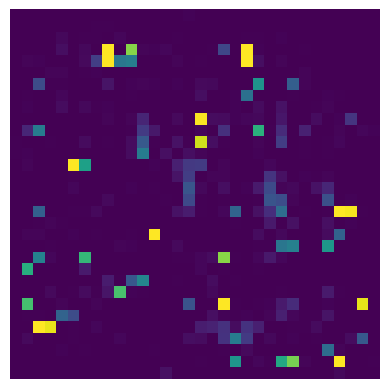

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reverse_engineer(param = {
    "dataset": "cifar10",
    "Epochs": 100,
    "batch_size": 64,
    "target_label": 2,
    "cost_lambda": 1e-3,
    "num_classes": 10,
    "image_size": (32, 32)}, model = torch.load('model_cifar10_0.15_2.pkl').to(device))

### Target Label = 3, Injection Rate = 0.15

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
param = {
    "dataset": "cifar10",
    "model": "default",
    "poisoning_method": "badnet",
    "injection_rate": 0.15,
    "target_label": 3,
    "Epochs": 150,
    "batch_size": 64
    }
fill_param(param)
train(param)

Testing...: 100%|██████████| 157/157 [00:00<00:00, 331.54it/s]


Epoch: 1, Training Accuracy: 50.932, Testing Accuracy: 47.9, Testing ASR: 93.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 296.92it/s]


Epoch: 2, Training Accuracy: 66.224, Testing Accuracy: 63.33, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 346.42it/s]


Epoch: 3, Training Accuracy: 71.524, Testing Accuracy: 66.4, Testing ASR: 95.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 305.17it/s]


Epoch: 4, Training Accuracy: 74.508, Testing Accuracy: 72.39, Testing ASR: 96.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 322.03it/s]


Epoch: 5, Training Accuracy: 76.648, Testing Accuracy: 65.94, Testing ASR: 97.53


Testing...: 100%|██████████| 157/157 [00:00<00:00, 274.00it/s]


Epoch: 6, Training Accuracy: 78.256, Testing Accuracy: 64.6, Testing ASR: 90.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 338.63it/s]


Epoch: 7, Training Accuracy: 79.46, Testing Accuracy: 75.89, Testing ASR: 97.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 322.60it/s]


Epoch: 8, Training Accuracy: 80.712, Testing Accuracy: 78.25, Testing ASR: 97.59


Testing...: 100%|██████████| 157/157 [00:00<00:00, 297.91it/s]


Epoch: 9, Training Accuracy: 81.752, Testing Accuracy: 78.06, Testing ASR: 95.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 343.32it/s]


Epoch: 10, Training Accuracy: 82.504, Testing Accuracy: 79.09, Testing ASR: 97.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 338.27it/s]


Epoch: 11, Training Accuracy: 83.286, Testing Accuracy: 80.0, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 351.52it/s]


Epoch: 12, Training Accuracy: 84.006, Testing Accuracy: 80.02, Testing ASR: 97.43


Testing...: 100%|██████████| 157/157 [00:00<00:00, 299.74it/s]


Epoch: 13, Training Accuracy: 84.59, Testing Accuracy: 80.84, Testing ASR: 97.42


Testing...: 100%|██████████| 157/157 [00:00<00:00, 339.33it/s]


Epoch: 14, Training Accuracy: 85.04, Testing Accuracy: 81.07, Testing ASR: 97.14


Testing...: 100%|██████████| 157/157 [00:00<00:00, 347.30it/s]


Epoch: 15, Training Accuracy: 85.39, Testing Accuracy: 80.15, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 347.83it/s]


Epoch: 16, Training Accuracy: 86.18, Testing Accuracy: 79.71, Testing ASR: 97.34


Testing...: 100%|██████████| 157/157 [00:00<00:00, 327.63it/s]


Epoch: 17, Training Accuracy: 86.926, Testing Accuracy: 81.3, Testing ASR: 96.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 349.70it/s]


Epoch: 18, Training Accuracy: 87.07, Testing Accuracy: 81.48, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.52it/s]


Epoch: 19, Training Accuracy: 87.296, Testing Accuracy: 81.42, Testing ASR: 97.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 354.62it/s]


Epoch: 20, Training Accuracy: 87.876, Testing Accuracy: 79.61, Testing ASR: 97.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 340.90it/s]


Epoch: 21, Training Accuracy: 88.006, Testing Accuracy: 81.09, Testing ASR: 97.28


Testing...: 100%|██████████| 157/157 [00:00<00:00, 334.79it/s]


Epoch: 22, Training Accuracy: 88.298, Testing Accuracy: 81.8, Testing ASR: 97.41


Testing...: 100%|██████████| 157/157 [00:00<00:00, 312.44it/s]


Epoch: 23, Training Accuracy: 88.656, Testing Accuracy: 81.46, Testing ASR: 97.57


Testing...: 100%|██████████| 157/157 [00:00<00:00, 346.31it/s]


Epoch: 24, Training Accuracy: 89.0, Testing Accuracy: 81.61, Testing ASR: 97.43


Testing...: 100%|██████████| 157/157 [00:00<00:00, 346.32it/s]


Epoch: 25, Training Accuracy: 89.23, Testing Accuracy: 80.78, Testing ASR: 97.56


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.84it/s]


Epoch: 26, Training Accuracy: 89.46, Testing Accuracy: 81.03, Testing ASR: 98.57


Testing...: 100%|██████████| 157/157 [00:00<00:00, 333.68it/s]


Epoch: 27, Training Accuracy: 89.796, Testing Accuracy: 82.24, Testing ASR: 96.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 316.21it/s]


Epoch: 28, Training Accuracy: 89.894, Testing Accuracy: 78.99, Testing ASR: 95.59


Testing...: 100%|██████████| 157/157 [00:00<00:00, 347.56it/s]


Epoch: 29, Training Accuracy: 90.04, Testing Accuracy: 81.97, Testing ASR: 97.46


Testing...: 100%|██████████| 157/157 [00:00<00:00, 341.54it/s]


Epoch: 30, Training Accuracy: 90.358, Testing Accuracy: 81.04, Testing ASR: 96.61


Testing...: 100%|██████████| 157/157 [00:00<00:00, 282.19it/s]


Epoch: 31, Training Accuracy: 90.542, Testing Accuracy: 81.97, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 352.32it/s]


Epoch: 32, Training Accuracy: 90.872, Testing Accuracy: 82.22, Testing ASR: 97.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 332.55it/s]


Epoch: 33, Training Accuracy: 90.908, Testing Accuracy: 81.9, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 323.39it/s]


Epoch: 34, Training Accuracy: 90.848, Testing Accuracy: 81.72, Testing ASR: 97.51


Testing...: 100%|██████████| 157/157 [00:00<00:00, 327.72it/s]


Epoch: 35, Training Accuracy: 91.228, Testing Accuracy: 81.42, Testing ASR: 96.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 295.61it/s]


Epoch: 36, Training Accuracy: 91.282, Testing Accuracy: 81.86, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 350.63it/s]


Epoch: 37, Training Accuracy: 91.412, Testing Accuracy: 81.89, Testing ASR: 97.25


Testing...: 100%|██████████| 157/157 [00:00<00:00, 302.06it/s]


Epoch: 38, Training Accuracy: 91.542, Testing Accuracy: 82.41, Testing ASR: 97.33


Testing...: 100%|██████████| 157/157 [00:00<00:00, 337.61it/s]


Epoch: 39, Training Accuracy: 91.876, Testing Accuracy: 82.38, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 326.39it/s]


Epoch: 40, Training Accuracy: 91.834, Testing Accuracy: 81.96, Testing ASR: 97.41


Testing...: 100%|██████████| 157/157 [00:00<00:00, 338.49it/s]


Epoch: 41, Training Accuracy: 91.982, Testing Accuracy: 82.53, Testing ASR: 97.63


Testing...: 100%|██████████| 157/157 [00:00<00:00, 323.30it/s]


Epoch: 42, Training Accuracy: 92.02, Testing Accuracy: 81.93, Testing ASR: 97.3


Testing...: 100%|██████████| 157/157 [00:00<00:00, 335.08it/s]


Epoch: 43, Training Accuracy: 92.5, Testing Accuracy: 82.38, Testing ASR: 97.55


Testing...: 100%|██████████| 157/157 [00:00<00:00, 312.71it/s]


Epoch: 44, Training Accuracy: 92.372, Testing Accuracy: 82.48, Testing ASR: 97.48


Testing...: 100%|██████████| 157/157 [00:00<00:00, 323.96it/s]


Epoch: 45, Training Accuracy: 92.35, Testing Accuracy: 81.39, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 338.80it/s]


Epoch: 46, Training Accuracy: 92.32, Testing Accuracy: 82.28, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 348.75it/s]


Epoch: 47, Training Accuracy: 92.548, Testing Accuracy: 82.19, Testing ASR: 97.54


Testing...: 100%|██████████| 157/157 [00:00<00:00, 337.57it/s]


Epoch: 48, Training Accuracy: 92.588, Testing Accuracy: 82.51, Testing ASR: 97.34


Testing...: 100%|██████████| 157/157 [00:00<00:00, 346.83it/s]


Epoch: 49, Training Accuracy: 92.916, Testing Accuracy: 82.04, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 360.16it/s]


Epoch: 50, Training Accuracy: 92.77, Testing Accuracy: 82.34, Testing ASR: 97.52


Testing...: 100%|██████████| 157/157 [00:00<00:00, 332.38it/s]


Epoch: 51, Training Accuracy: 93.08, Testing Accuracy: 82.45, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 354.85it/s]


Epoch: 52, Training Accuracy: 92.954, Testing Accuracy: 82.44, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 296.96it/s]


Epoch: 53, Training Accuracy: 93.308, Testing Accuracy: 82.33, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 342.07it/s]


Epoch: 54, Training Accuracy: 93.286, Testing Accuracy: 82.37, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 304.93it/s]


Epoch: 55, Training Accuracy: 93.164, Testing Accuracy: 82.86, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 347.60it/s]


Epoch: 56, Training Accuracy: 93.524, Testing Accuracy: 82.49, Testing ASR: 97.56


Testing...: 100%|██████████| 157/157 [00:00<00:00, 337.51it/s]


Epoch: 57, Training Accuracy: 93.518, Testing Accuracy: 82.01, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 343.52it/s]


Epoch: 58, Training Accuracy: 93.388, Testing Accuracy: 82.31, Testing ASR: 97.46


Testing...: 100%|██████████| 157/157 [00:00<00:00, 262.17it/s]


Epoch: 59, Training Accuracy: 93.582, Testing Accuracy: 81.97, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 281.38it/s]


Epoch: 60, Training Accuracy: 93.554, Testing Accuracy: 82.43, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 298.45it/s]


Epoch: 61, Training Accuracy: 93.854, Testing Accuracy: 82.47, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 304.82it/s]


Epoch: 62, Training Accuracy: 93.802, Testing Accuracy: 82.42, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 295.33it/s]


Epoch: 63, Training Accuracy: 93.85, Testing Accuracy: 82.29, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 339.59it/s]


Epoch: 64, Training Accuracy: 93.682, Testing Accuracy: 82.7, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 340.52it/s]


Epoch: 65, Training Accuracy: 93.918, Testing Accuracy: 81.78, Testing ASR: 97.52


Testing...: 100%|██████████| 157/157 [00:00<00:00, 358.01it/s]


Epoch: 66, Training Accuracy: 94.12, Testing Accuracy: 81.79, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 351.24it/s]


Epoch: 67, Training Accuracy: 94.034, Testing Accuracy: 82.26, Testing ASR: 97.4


Testing...: 100%|██████████| 157/157 [00:00<00:00, 346.12it/s]


Epoch: 68, Training Accuracy: 94.09, Testing Accuracy: 82.1, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 304.90it/s]


Epoch: 69, Training Accuracy: 94.296, Testing Accuracy: 82.86, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 348.30it/s]


Epoch: 70, Training Accuracy: 94.328, Testing Accuracy: 82.5, Testing ASR: 97.55


Testing...: 100%|██████████| 157/157 [00:00<00:00, 310.03it/s]


Epoch: 71, Training Accuracy: 94.324, Testing Accuracy: 82.78, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 340.59it/s]


Epoch: 72, Training Accuracy: 94.274, Testing Accuracy: 82.46, Testing ASR: 96.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 321.54it/s]


Epoch: 73, Training Accuracy: 94.338, Testing Accuracy: 82.69, Testing ASR: 97.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 338.62it/s]


Epoch: 74, Training Accuracy: 94.356, Testing Accuracy: 81.68, Testing ASR: 97.41


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.97it/s]


Epoch: 75, Training Accuracy: 94.51, Testing Accuracy: 82.67, Testing ASR: 97.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 342.87it/s]


Epoch: 76, Training Accuracy: 94.546, Testing Accuracy: 82.76, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 347.20it/s]


Epoch: 77, Training Accuracy: 94.566, Testing Accuracy: 82.46, Testing ASR: 97.98


Testing...: 100%|██████████| 157/157 [00:00<00:00, 309.03it/s]


Epoch: 78, Training Accuracy: 94.632, Testing Accuracy: 83.18, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 322.13it/s]


Epoch: 79, Training Accuracy: 94.656, Testing Accuracy: 82.52, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 346.07it/s]


Epoch: 80, Training Accuracy: 94.734, Testing Accuracy: 82.3, Testing ASR: 97.34


Testing...: 100%|██████████| 157/157 [00:00<00:00, 260.12it/s]


Epoch: 81, Training Accuracy: 95.556, Testing Accuracy: 82.96, Testing ASR: 97.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 324.85it/s]


Epoch: 82, Training Accuracy: 95.57, Testing Accuracy: 82.82, Testing ASR: 97.59


Testing...: 100%|██████████| 157/157 [00:00<00:00, 348.04it/s]


Epoch: 83, Training Accuracy: 95.752, Testing Accuracy: 83.06, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 333.67it/s]


Epoch: 84, Training Accuracy: 95.74, Testing Accuracy: 83.25, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 340.21it/s]


Epoch: 85, Training Accuracy: 95.994, Testing Accuracy: 83.38, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 291.24it/s]


Epoch: 86, Training Accuracy: 96.028, Testing Accuracy: 83.22, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 319.28it/s]


Epoch: 87, Training Accuracy: 96.104, Testing Accuracy: 82.99, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 350.38it/s]


Epoch: 88, Training Accuracy: 96.234, Testing Accuracy: 82.95, Testing ASR: 97.41


Testing...: 100%|██████████| 157/157 [00:00<00:00, 299.73it/s]


Epoch: 89, Training Accuracy: 96.172, Testing Accuracy: 83.24, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 328.20it/s]


Epoch: 90, Training Accuracy: 96.226, Testing Accuracy: 83.44, Testing ASR: 97.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 354.97it/s]


Epoch: 91, Training Accuracy: 96.366, Testing Accuracy: 83.36, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 353.20it/s]


Epoch: 92, Training Accuracy: 96.222, Testing Accuracy: 83.24, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 351.68it/s]


Epoch: 93, Training Accuracy: 96.436, Testing Accuracy: 83.31, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 349.60it/s]


Epoch: 94, Training Accuracy: 96.39, Testing Accuracy: 83.27, Testing ASR: 97.56


Testing...: 100%|██████████| 157/157 [00:00<00:00, 351.83it/s]


Epoch: 95, Training Accuracy: 96.432, Testing Accuracy: 83.56, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 334.75it/s]


Epoch: 96, Training Accuracy: 96.168, Testing Accuracy: 83.53, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 325.56it/s]


Epoch: 97, Training Accuracy: 96.52, Testing Accuracy: 83.39, Testing ASR: 97.61


Testing...: 100%|██████████| 157/157 [00:00<00:00, 317.56it/s]


Epoch: 98, Training Accuracy: 96.446, Testing Accuracy: 83.37, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 334.74it/s]


Epoch: 99, Training Accuracy: 96.428, Testing Accuracy: 83.21, Testing ASR: 97.63


Testing...: 100%|██████████| 157/157 [00:00<00:00, 342.89it/s]


Epoch: 100, Training Accuracy: 96.428, Testing Accuracy: 82.78, Testing ASR: 97.18


Testing...: 100%|██████████| 157/157 [00:00<00:00, 285.84it/s]


Epoch: 101, Training Accuracy: 96.704, Testing Accuracy: 83.13, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 358.99it/s]


Epoch: 102, Training Accuracy: 96.95, Testing Accuracy: 83.49, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 322.34it/s]


Epoch: 103, Training Accuracy: 97.134, Testing Accuracy: 83.54, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 343.69it/s]


Epoch: 104, Training Accuracy: 97.058, Testing Accuracy: 83.62, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 339.99it/s]


Epoch: 105, Training Accuracy: 97.238, Testing Accuracy: 83.69, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 302.23it/s]


Epoch: 106, Training Accuracy: 97.202, Testing Accuracy: 83.67, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.12it/s]


Epoch: 107, Training Accuracy: 97.246, Testing Accuracy: 83.58, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 307.04it/s]


Epoch: 108, Training Accuracy: 97.282, Testing Accuracy: 83.69, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 345.70it/s]


Epoch: 109, Training Accuracy: 97.348, Testing Accuracy: 83.62, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 348.78it/s]


Epoch: 110, Training Accuracy: 97.342, Testing Accuracy: 83.53, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 303.35it/s]


Epoch: 111, Training Accuracy: 97.404, Testing Accuracy: 83.64, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 319.44it/s]


Epoch: 112, Training Accuracy: 97.31, Testing Accuracy: 83.68, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 313.73it/s]


Epoch: 113, Training Accuracy: 97.434, Testing Accuracy: 83.74, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 339.15it/s]


Epoch: 114, Training Accuracy: 97.402, Testing Accuracy: 83.61, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 350.57it/s]


Epoch: 115, Training Accuracy: 97.486, Testing Accuracy: 83.72, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 317.35it/s]


Epoch: 116, Training Accuracy: 97.544, Testing Accuracy: 83.78, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 327.81it/s]


Epoch: 117, Training Accuracy: 97.44, Testing Accuracy: 83.62, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 285.60it/s]


Epoch: 118, Training Accuracy: 97.432, Testing Accuracy: 83.61, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 338.62it/s]


Epoch: 119, Training Accuracy: 97.614, Testing Accuracy: 83.66, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 347.50it/s]


Epoch: 120, Training Accuracy: 97.538, Testing Accuracy: 83.75, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 348.15it/s]


Epoch: 121, Training Accuracy: 97.564, Testing Accuracy: 83.71, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 317.46it/s]


Epoch: 122, Training Accuracy: 97.42, Testing Accuracy: 83.7, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 332.89it/s]


Epoch: 123, Training Accuracy: 97.49, Testing Accuracy: 83.63, Testing ASR: 97.63


Testing...: 100%|██████████| 157/157 [00:00<00:00, 338.60it/s]


Epoch: 124, Training Accuracy: 97.51, Testing Accuracy: 83.54, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 351.72it/s]


Epoch: 125, Training Accuracy: 97.628, Testing Accuracy: 83.74, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 323.78it/s]


Epoch: 126, Training Accuracy: 97.504, Testing Accuracy: 83.68, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 309.73it/s]


Epoch: 127, Training Accuracy: 97.528, Testing Accuracy: 83.61, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 348.20it/s]


Epoch: 128, Training Accuracy: 97.558, Testing Accuracy: 83.63, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 333.90it/s]


Epoch: 129, Training Accuracy: 97.608, Testing Accuracy: 83.81, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 347.00it/s]


Epoch: 130, Training Accuracy: 97.554, Testing Accuracy: 83.85, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 340.31it/s]


Epoch: 131, Training Accuracy: 97.722, Testing Accuracy: 83.66, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 300.95it/s]


Epoch: 132, Training Accuracy: 97.624, Testing Accuracy: 83.76, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 351.42it/s]


Epoch: 133, Training Accuracy: 97.582, Testing Accuracy: 83.76, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 322.80it/s]


Epoch: 134, Training Accuracy: 97.754, Testing Accuracy: 83.65, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 340.40it/s]


Epoch: 135, Training Accuracy: 97.638, Testing Accuracy: 83.8, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 354.85it/s]


Epoch: 136, Training Accuracy: 97.76, Testing Accuracy: 83.84, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.61it/s]


Epoch: 137, Training Accuracy: 97.69, Testing Accuracy: 83.69, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 351.79it/s]


Epoch: 138, Training Accuracy: 97.652, Testing Accuracy: 83.78, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 326.08it/s]


Epoch: 139, Training Accuracy: 97.706, Testing Accuracy: 83.79, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 315.48it/s]


Epoch: 140, Training Accuracy: 97.686, Testing Accuracy: 83.65, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 348.37it/s]


Epoch: 141, Training Accuracy: 97.776, Testing Accuracy: 83.62, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 311.32it/s]


Epoch: 142, Training Accuracy: 97.572, Testing Accuracy: 83.77, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 307.18it/s]


Epoch: 143, Training Accuracy: 97.734, Testing Accuracy: 83.57, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 290.78it/s]


Epoch: 144, Training Accuracy: 97.77, Testing Accuracy: 83.82, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 293.43it/s]


Epoch: 145, Training Accuracy: 97.808, Testing Accuracy: 83.9, Testing ASR: 97.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 284.48it/s]


Epoch: 146, Training Accuracy: 97.738, Testing Accuracy: 83.71, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 347.02it/s]


Epoch: 147, Training Accuracy: 97.808, Testing Accuracy: 83.67, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 286.36it/s]


Epoch: 148, Training Accuracy: 97.61, Testing Accuracy: 83.69, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 272.40it/s]


Epoch: 149, Training Accuracy: 97.888, Testing Accuracy: 83.63, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 360.96it/s]

Epoch: 150, Training Accuracy: 97.726, Testing Accuracy: 83.47, Testing ASR: 97.79


Processing label: 0


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 108.98it/s]


norm: 496.64453125


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 108.26it/s]


norm: 452.1578369140625


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 103.46it/s]


norm: 399.3926086425781


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 103.02it/s]


norm: 345.8720703125


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 105.06it/s]


norm: 296.439208984375


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 107.64it/s]


norm: 252.29757690429688


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 110.41it/s]


norm: 213.66629028320312


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 107.72it/s]


norm: 181.150146484375


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 107.18it/s]


norm: 156.97589111328125


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 106.61it/s]


norm: 137.14205932617188


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 102.59it/s]


norm: 121.46910095214844


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 108.16it/s]


norm: 109.57150268554688


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 100.41it/s]


norm: 101.52777099609375


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 101.82it/s]


norm: 94.40291595458984


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 102.12it/s]


norm: 89.17097473144531


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 100.88it/s]


norm: 84.44148254394531


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 101.11it/s]


norm: 80.75270080566406


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 99.59it/s]


norm: 78.45014190673828


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 101.71it/s]


norm: 76.61898040771484


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 108.27it/s]


norm: 74.66050720214844


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 96.88it/s]


norm: 73.29762268066406


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 98.82it/s]


norm: 72.33905029296875


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 103.80it/s]


norm: 69.55136108398438


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 99.59it/s] 


norm: 68.19278717041016


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 98.33it/s] 


norm: 66.94536590576172


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 99.15it/s] 


norm: 66.0835189819336


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 105.95it/s]


norm: 65.29707336425781


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 98.60it/s]


norm: 64.13752746582031


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 108.00it/s]


norm: 63.06018829345703


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 108.93it/s]


norm: 62.08024597167969


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 105.74it/s]


norm: 61.34564971923828


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 105.06it/s]


norm: 60.977169036865234


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 106.81it/s]


norm: 60.21282958984375


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 99.85it/s] 


norm: 59.52403259277344


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 100.92it/s]


norm: 59.307926177978516


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 105.07it/s]


norm: 58.41188430786133


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 106.17it/s]


norm: 58.98820114135742


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 106.51it/s]


norm: 57.67749786376953


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 106.28it/s]


norm: 57.33876037597656


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 107.01it/s]


norm: 57.352352142333984


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 106.70it/s]


norm: 56.97636413574219


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 105.93it/s]


norm: 55.95881652832031


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 107.53it/s]


norm: 55.282325744628906


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 107.87it/s]


norm: 55.005943298339844


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 102.04it/s]


norm: 55.053688049316406


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 100.97it/s]


norm: 55.11131286621094


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 100.37it/s]


norm: 54.286285400390625


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 103.55it/s]


norm: 53.8552360534668


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 104.08it/s]


norm: 53.88740539550781


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 104.50it/s]


norm: 54.06855010986328


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 102.56it/s]


norm: 54.50743865966797


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 106.07it/s]


norm: 55.44042205810547


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 103.66it/s]


norm: 54.95146179199219


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 102.43it/s]


norm: 53.41114044189453


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 105.06it/s]


norm: 52.696510314941406


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 102.60it/s]


norm: 52.675636291503906


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 103.91it/s]


norm: 54.2861328125


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 103.53it/s]


norm: 53.24797439575195


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 103.93it/s]


norm: 51.92646408081055


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 101.11it/s]


norm: 52.460960388183594


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 98.49it/s]


norm: 51.333038330078125


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 95.57it/s]


norm: 51.97827911376953


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 98.61it/s]


norm: 51.666786193847656


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 100.81it/s]


norm: 51.633880615234375


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 101.77it/s]


norm: 53.07649230957031


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 102.01it/s]


norm: 51.21599578857422


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 99.83it/s] 


norm: 51.604122161865234


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 99.68it/s] 


norm: 50.841026306152344


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 101.14it/s]


norm: 52.53483581542969


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 98.08it/s] 


norm: 52.26560592651367


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 100.88it/s]


norm: 52.194297790527344


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 99.99it/s] 


norm: 52.541988372802734


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 100.55it/s]


norm: 52.09325408935547


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 98.98it/s] 


norm: 52.502685546875


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 101.62it/s]


norm: 52.136474609375


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 97.57it/s] 


norm: 50.73854064941406


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 94.43it/s]


norm: 51.08079147338867


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 95.73it/s]


norm: 50.293121337890625


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 101.86it/s]


norm: 50.38285827636719


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 99.55it/s] 


norm: 50.03478240966797


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 97.12it/s]


norm: 49.82158660888672


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 95.32it/s]


norm: 49.64441680908203


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 95.71it/s] 


norm: 49.26436996459961


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 99.67it/s] 


norm: 49.66128158569336


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 94.42it/s]


norm: 49.260894775390625


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 98.32it/s] 


norm: 48.89400863647461


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 97.68it/s]


norm: 49.17835998535156


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 93.55it/s]


norm: 49.365386962890625


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 100.53it/s]


norm: 51.43220901489258


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 100.07it/s]


norm: 49.22644805908203


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 97.71it/s]


norm: 49.08987045288086


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 99.22it/s]


norm: 49.33020782470703


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 94.05it/s]


norm: 49.379920959472656


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 101.15it/s]


norm: 49.22624969482422


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 96.87it/s]


norm: 49.16059875488281


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 97.37it/s]


norm: 50.357017517089844


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 98.62it/s] 


norm: 48.86735916137695


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 99.46it/s] 


norm: 48.78706359863281


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 96.58it/s] 


norm: 49.123878479003906


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 91.46it/s]


norm: 49.34485626220703
Processing label: 1


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 94.46it/s]


norm: 494.13189697265625


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 98.32it/s] 


norm: 442.487548828125


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 97.64it/s] 


norm: 382.8399658203125


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 97.03it/s]


norm: 323.3043212890625


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 90.11it/s]


norm: 269.38922119140625


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 92.84it/s]


norm: 223.26467895507812


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 90.97it/s]


norm: 185.72128295898438


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 93.01it/s]


norm: 154.47140502929688


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 95.38it/s]


norm: 131.00424194335938


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 95.82it/s]


norm: 114.80536651611328


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 92.71it/s]


norm: 102.08477020263672


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 93.19it/s]


norm: 90.19580841064453


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 98.64it/s]


norm: 79.06771850585938


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 95.11it/s]


norm: 71.44418334960938


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 92.79it/s]


norm: 66.99417114257812


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 93.89it/s]


norm: 62.90031051635742


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 96.60it/s]


norm: 60.03683090209961


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 91.98it/s]


norm: 57.69823455810547


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 92.94it/s]


norm: 55.61454772949219


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 97.35it/s]


norm: 53.87322998046875


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 97.66it/s]


norm: 53.0723762512207


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 97.51it/s]


norm: 51.99931335449219


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 93.23it/s]


norm: 50.94380569458008


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 95.95it/s]


norm: 50.23426818847656


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 92.60it/s]


norm: 50.133216857910156


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 89.96it/s]


norm: 49.359092712402344


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 92.94it/s]


norm: 48.75440216064453


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 97.30it/s]


norm: 48.185150146484375


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 93.05it/s]


norm: 48.147579193115234


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 90.91it/s]


norm: 47.7534065246582


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 93.13it/s]


norm: 47.44822692871094


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 90.96it/s]


norm: 47.21551513671875


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 95.03it/s]


norm: 47.23004150390625


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 96.53it/s]


norm: 47.595130920410156


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 98.41it/s] 


norm: 46.49071502685547


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 95.50it/s]


norm: 45.85730743408203


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 96.93it/s]


norm: 45.49740982055664


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 98.17it/s] 


norm: 45.246971130371094


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 99.22it/s]


norm: 44.990787506103516


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 96.79it/s]


norm: 44.943267822265625


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 96.97it/s]


norm: 45.105384826660156


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 98.76it/s]


norm: 44.99787139892578


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 92.17it/s]


norm: 44.972633361816406


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 92.04it/s]


norm: 44.95558547973633


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 96.90it/s]


norm: 44.854156494140625


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 98.29it/s] 


norm: 44.861244201660156


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 95.06it/s]


norm: 44.80845642089844


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 99.11it/s] 


norm: 44.70254898071289


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 96.90it/s]


norm: 44.799537658691406


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 98.45it/s] 


norm: 44.763023376464844


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 97.34it/s]


norm: 44.75307846069336


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 96.82it/s]


norm: 44.850303649902344


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 95.07it/s]


norm: 44.78011703491211


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 91.65it/s]


norm: 44.640926361083984


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 95.74it/s]


norm: 44.57384490966797


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 97.21it/s]


norm: 44.461456298828125


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 97.85it/s]


norm: 44.68495178222656


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 98.06it/s]


norm: 45.06452941894531


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 98.59it/s] 


norm: 44.217193603515625


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 97.07it/s]


norm: 44.44118881225586


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 94.89it/s]


norm: 44.615745544433594


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 97.05it/s]


norm: 43.69695281982422


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 98.14it/s]


norm: 43.202308654785156


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 96.42it/s] 


norm: 43.50774383544922


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 92.82it/s]


norm: 42.70108413696289


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 91.81it/s]


norm: 41.91868591308594


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 97.28it/s]


norm: 41.537593841552734


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 97.53it/s]


norm: 42.063133239746094


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 97.93it/s]


norm: 41.48631286621094


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 96.94it/s]


norm: 41.93595504760742


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 91.49it/s]


norm: 42.3844108581543


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 92.05it/s]


norm: 41.719078063964844


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 94.53it/s]


norm: 41.243797302246094


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 92.19it/s]


norm: 40.780181884765625


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 95.65it/s]


norm: 40.42460632324219


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 99.35it/s] 


norm: 39.61549377441406


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 91.29it/s]


norm: 39.555973052978516


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 91.78it/s]


norm: 39.453895568847656


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 92.82it/s]


norm: 39.50920486450195


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 91.83it/s]


norm: 39.86809539794922


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 89.67it/s]


norm: 39.68629455566406


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 91.68it/s]


norm: 39.48630142211914


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 96.09it/s]


norm: 39.47734832763672


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 97.04it/s]


norm: 39.556236267089844


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 98.86it/s] 


norm: 39.609947204589844


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 98.36it/s]


norm: 39.03166961669922


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 96.95it/s]


norm: 38.61595153808594


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 94.46it/s]


norm: 38.25001525878906


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 92.69it/s]


norm: 38.526817321777344


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 98.26it/s]


norm: 37.92286682128906


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 91.28it/s]


norm: 37.752174377441406


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 97.45it/s]


norm: 37.177978515625


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 97.15it/s]


norm: 37.22999572753906


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 96.62it/s]


norm: 37.136878967285156


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 99.76it/s]


norm: 36.7315559387207


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 97.33it/s]


norm: 36.56067657470703


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 96.90it/s]


norm: 35.99475860595703


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 97.50it/s]


norm: 35.732147216796875


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 99.05it/s] 


norm: 35.600013732910156


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 98.88it/s]


norm: 35.47572708129883
Processing label: 2


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 97.06it/s]


norm: 485.0550231933594


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 99.68it/s] 


norm: 431.0982666015625


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 96.81it/s] 


norm: 371.17437744140625


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 100.25it/s]


norm: 312.73858642578125


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 99.32it/s] 


norm: 260.6114501953125


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 91.34it/s]


norm: 214.77076721191406


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 94.81it/s]


norm: 175.34716796875


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 93.13it/s]


norm: 149.3837432861328


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 92.17it/s]


norm: 127.95582580566406


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 94.27it/s]


norm: 112.75361633300781


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 91.04it/s]


norm: 101.70087432861328


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 96.99it/s]


norm: 94.14028930664062


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 97.00it/s]


norm: 87.09060668945312


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 93.27it/s]


norm: 82.0087661743164


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 92.47it/s]


norm: 77.62429809570312


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 97.59it/s]


norm: 74.34097290039062


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 95.81it/s]


norm: 72.01329040527344


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 98.29it/s]


norm: 70.35679626464844


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 96.22it/s]


norm: 68.042724609375


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 97.14it/s]


norm: 67.21868896484375


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 98.63it/s] 


norm: 65.3783187866211


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 91.52it/s]


norm: 64.40333557128906


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 94.67it/s]


norm: 62.9299430847168


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 92.46it/s]


norm: 61.14497375488281


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 95.64it/s]


norm: 59.975311279296875


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 96.11it/s]


norm: 60.76641845703125


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 93.84it/s] 


norm: 58.39764404296875


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 97.68it/s] 


norm: 55.72319412231445


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 91.14it/s]


norm: 55.00056457519531


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 90.80it/s]


norm: 55.87773895263672


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 91.72it/s]


norm: 53.56090545654297


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 91.68it/s]


norm: 52.97182083129883


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 92.01it/s]


norm: 52.59634780883789


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 96.83it/s]


norm: 53.51563262939453


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 98.47it/s]


norm: 52.900634765625


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 96.41it/s]


norm: 55.11546325683594


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 95.35it/s]


norm: 52.53425216674805


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 97.81it/s]


norm: 53.07826232910156


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 95.12it/s]


norm: 53.04347610473633


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 94.80it/s]


norm: 56.02843475341797


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 99.96it/s]


norm: 52.27142333984375


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 98.15it/s]


norm: 51.33595657348633


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 98.20it/s]


norm: 51.50965881347656


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 94.73it/s]


norm: 52.54356384277344


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 93.95it/s]


norm: 50.492794036865234


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 95.51it/s]


norm: 50.526397705078125


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 93.21it/s]


norm: 50.65823745727539


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 93.15it/s]


norm: 49.71007537841797


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 99.70it/s] 


norm: 53.209983825683594


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 92.27it/s]


norm: 50.51028060913086


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 91.76it/s]


norm: 49.03062438964844


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 97.30it/s] 


norm: 49.574005126953125


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 97.20it/s]


norm: 49.50829315185547


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 93.21it/s]


norm: 49.76782989501953


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 95.94it/s]


norm: 48.878875732421875


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 98.59it/s] 


norm: 47.69486618041992


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 99.13it/s] 


norm: 48.051273345947266


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 97.47it/s]


norm: 49.49645233154297


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 92.86it/s]


norm: 47.472930908203125


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 91.91it/s]


norm: 47.77239990234375


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 91.31it/s]


norm: 47.507774353027344


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 96.48it/s]


norm: 46.61810302734375


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 98.92it/s]


norm: 46.24744415283203


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 97.20it/s]


norm: 45.48845672607422


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 97.92it/s] 


norm: 45.09397888183594


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 94.60it/s]


norm: 45.90574645996094


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 92.01it/s]


norm: 45.06174850463867


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 91.85it/s]


norm: 44.654624938964844


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 92.04it/s]


norm: 45.68741226196289


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 97.30it/s]


norm: 46.524513244628906


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 96.64it/s]


norm: 44.70030975341797


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 96.44it/s] 


norm: 45.09940719604492


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 99.80it/s] 


norm: 44.94947052001953


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 96.75it/s]


norm: 47.6834831237793


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 99.27it/s] 


norm: 46.33592224121094


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 94.66it/s]


norm: 43.65860366821289


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 95.37it/s]


norm: 43.874141693115234


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 98.36it/s]


norm: 44.09405517578125


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 98.47it/s]


norm: 43.019927978515625


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 97.05it/s]


norm: 43.155113220214844


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 92.53it/s]


norm: 43.22609329223633


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 91.77it/s]


norm: 44.35311508178711


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 93.45it/s]


norm: 44.06117248535156


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 92.78it/s]


norm: 44.426513671875


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 98.15it/s]


norm: 45.19537353515625


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 90.90it/s]


norm: 45.852813720703125


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 93.64it/s]


norm: 45.103515625


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 91.56it/s]


norm: 45.90030288696289


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 97.50it/s]


norm: 44.265235900878906


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 97.36it/s]


norm: 44.19701385498047


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 97.06it/s]


norm: 43.04734802246094


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 95.87it/s]


norm: 45.441925048828125


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 98.04it/s]


norm: 44.77922058105469


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 97.46it/s]


norm: 42.19508743286133


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 97.32it/s]


norm: 43.704803466796875


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 94.10it/s]


norm: 41.45880889892578


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 90.65it/s]


norm: 41.45082473754883


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 93.34it/s]


norm: 42.27977752685547


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 95.56it/s]


norm: 43.012550354003906


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 96.40it/s]


norm: 41.537811279296875
Processing label: 3


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 99.25it/s] 


norm: 470.15802001953125


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 95.88it/s]


norm: 411.50311279296875


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 91.87it/s]


norm: 347.9612731933594


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 96.22it/s]


norm: 286.6944274902344


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 98.99it/s]


norm: 232.44692993164062


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 97.93it/s]


norm: 187.8963165283203


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 97.69it/s] 


norm: 149.86270141601562


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 98.25it/s] 


norm: 114.67654418945312


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 90.69it/s]


norm: 85.23280334472656


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 92.18it/s]


norm: 64.22639465332031


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 99.46it/s]


norm: 48.15379333496094


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 96.39it/s]


norm: 37.91764450073242


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 89.66it/s]


norm: 30.273578643798828


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 94.87it/s]


norm: 23.65375518798828


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 91.19it/s]


norm: 20.247468948364258


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 90.98it/s]


norm: 16.20529556274414


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 92.44it/s]


norm: 14.117159843444824


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 96.60it/s]


norm: 12.452733993530273


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 90.62it/s]


norm: 11.456392288208008


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 91.63it/s]


norm: 10.366212844848633


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 97.77it/s]


norm: 10.052989959716797


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 96.08it/s]


norm: 9.361822128295898


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 96.45it/s]


norm: 9.548479080200195


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 93.29it/s]


norm: 8.275527954101562


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 98.75it/s] 


norm: 8.076000213623047


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 96.22it/s]


norm: 8.184890747070312


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 98.32it/s]


norm: 8.696240425109863


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 97.96it/s]


norm: 7.773934364318848


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 98.90it/s]


norm: 8.20465087890625


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 98.35it/s]


norm: 8.335980415344238


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 96.56it/s]


norm: 7.5175628662109375


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 99.72it/s]


norm: 7.627118110656738


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 99.68it/s] 


norm: 8.332552909851074


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 96.82it/s]


norm: 8.81381893157959


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 93.80it/s]


norm: 7.357046604156494


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 96.98it/s]


norm: 7.327081680297852


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 97.73it/s]


norm: 7.511948108673096


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 98.79it/s]


norm: 7.451318264007568


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 96.00it/s]


norm: 6.822834491729736


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 96.98it/s]


norm: 9.961846351623535


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 99.46it/s] 


norm: 7.500190258026123


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 94.82it/s]


norm: 6.813149929046631


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 90.77it/s]


norm: 7.326669216156006


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 93.06it/s]


norm: 6.595659255981445


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 93.07it/s]


norm: 6.907403945922852


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 94.76it/s]


norm: 8.542662620544434


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 97.34it/s]


norm: 6.931097984313965


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 99.54it/s] 


norm: 8.351445198059082


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 96.83it/s]


norm: 6.7695722579956055


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 99.54it/s] 


norm: 6.721628665924072


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 95.24it/s]


norm: 6.317976951599121


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 90.12it/s]


norm: 7.142786979675293


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 91.15it/s]


norm: 6.348471641540527


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 96.12it/s]


norm: 6.428992748260498


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 90.44it/s]


norm: 7.237783432006836


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 94.05it/s]


norm: 6.524308204650879


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 99.42it/s] 


norm: 6.797206878662109


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 98.21it/s]


norm: 10.47630500793457


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 96.95it/s]


norm: 6.725146770477295


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 98.00it/s]


norm: 6.126552581787109


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 97.79it/s]


norm: 6.472402095794678


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 91.39it/s]


norm: 6.958515167236328


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 90.95it/s]


norm: 9.197427749633789


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 92.25it/s]


norm: 6.459047317504883


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 94.47it/s]


norm: 6.699160575866699


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 98.06it/s]


norm: 8.604405403137207


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 93.86it/s]


norm: 6.694318771362305


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 89.27it/s]


norm: 6.68933629989624


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 90.64it/s]


norm: 7.412955284118652


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 94.81it/s]


norm: 9.33189868927002


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 92.17it/s]


norm: 6.452672958374023


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 97.34it/s]


norm: 8.38552474975586


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 97.85it/s]


norm: 6.556487083435059


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 97.70it/s] 


norm: 6.138996124267578


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 97.69it/s]


norm: 6.305410385131836


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 95.98it/s]


norm: 7.755394458770752


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 89.72it/s]


norm: 6.359577655792236


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 91.69it/s]


norm: 8.951345443725586


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 92.51it/s]


norm: 12.070035934448242


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 94.93it/s]


norm: 6.478024482727051


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 93.75it/s]


norm: 8.429984092712402


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 97.23it/s]


norm: 6.5920729637146


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 99.76it/s] 


norm: 8.773696899414062


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 98.80it/s]


norm: 6.562764644622803


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 96.02it/s]


norm: 7.983506202697754


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 94.06it/s]


norm: 6.545160293579102


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 92.15it/s]


norm: 13.388899803161621


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 94.36it/s]


norm: 6.584029197692871


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 89.79it/s]


norm: 8.811027526855469


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 93.32it/s]


norm: 6.464770317077637


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 97.67it/s]


norm: 6.405745506286621
Processing label: 4


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 93.47it/s]


norm: 489.4620361328125


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 99.71it/s]


norm: 431.6827392578125


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 99.50it/s]


norm: 367.0572509765625


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 92.64it/s]


norm: 303.9779052734375


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 98.64it/s]


norm: 246.36163330078125


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 90.76it/s]


norm: 200.2873992919922


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 92.24it/s]


norm: 164.78146362304688


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 98.45it/s]


norm: 138.252685546875


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 92.81it/s]


norm: 118.98286437988281


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 94.29it/s]


norm: 104.85791778564453


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 95.40it/s]


norm: 94.0933837890625


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 91.56it/s]


norm: 84.68000030517578


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 94.25it/s]


norm: 78.87980651855469


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 95.07it/s]


norm: 74.15139770507812


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 94.41it/s]


norm: 68.63206481933594


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 94.69it/s]


norm: 65.6054458618164


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 98.68it/s]


norm: 62.30795669555664


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 99.01it/s]


norm: 62.311729431152344


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 97.80it/s]


norm: 59.48678970336914


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 97.93it/s]


norm: 59.97305679321289


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 98.46it/s]


norm: 59.25384521484375


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 95.12it/s]


norm: 58.435874938964844


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 98.20it/s]


norm: 57.24054718017578


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 98.28it/s] 


norm: 57.284000396728516


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 96.08it/s]


norm: 56.8233757019043


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 97.64it/s] 


norm: 54.013153076171875


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 98.56it/s]


norm: 52.813533782958984


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 96.36it/s]


norm: 52.310935974121094


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 92.53it/s]


norm: 52.290992736816406


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 93.04it/s]


norm: 52.732505798339844


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 91.63it/s]


norm: 52.71807098388672


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 90.73it/s]


norm: 52.86814880371094


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 93.00it/s]


norm: 52.57771301269531


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 90.11it/s]


norm: 53.15923309326172


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 98.59it/s]


norm: 51.294795989990234


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 94.32it/s]


norm: 50.99440383911133


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 92.20it/s]


norm: 50.56475067138672


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 93.43it/s]


norm: 51.619293212890625


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 97.06it/s]


norm: 51.13706970214844


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 95.29it/s]


norm: 52.00121307373047


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 97.19it/s]


norm: 51.205623626708984


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 90.77it/s]


norm: 51.64665222167969


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 94.68it/s]


norm: 50.16008377075195


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 94.56it/s]


norm: 51.149696350097656


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 95.92it/s]


norm: 50.420166015625


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 90.61it/s]


norm: 51.194114685058594


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 93.31it/s]


norm: 50.733436584472656


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 92.23it/s]


norm: 51.225467681884766


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 97.72it/s]


norm: 49.96095275878906


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 98.69it/s]


norm: 50.10792541503906


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 97.52it/s]


norm: 50.718284606933594


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 94.08it/s]


norm: 49.38365936279297


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 94.33it/s]


norm: 49.15476608276367


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 92.60it/s]


norm: 48.41184616088867


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 96.27it/s]


norm: 48.071075439453125


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 96.17it/s]


norm: 47.89768981933594


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 89.79it/s]


norm: 47.24163055419922


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 87.83it/s]


norm: 49.23345947265625


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 90.35it/s]


norm: 48.665489196777344


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 93.30it/s]


norm: 45.769493103027344


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 94.56it/s]


norm: 48.00916290283203


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 99.40it/s]


norm: 46.9771842956543


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 97.25it/s]


norm: 47.01593780517578


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 91.86it/s]


norm: 44.36708068847656


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 98.26it/s]


norm: 44.30223083496094


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 96.50it/s]


norm: 43.78363800048828


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 93.24it/s]


norm: 45.570892333984375


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 96.52it/s]


norm: 44.209442138671875


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 96.47it/s]


norm: 43.76349639892578


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 90.42it/s]


norm: 44.11968994140625


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 95.77it/s]


norm: 44.202972412109375


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 92.53it/s]


norm: 44.40507888793945


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 90.86it/s]


norm: 44.54328155517578


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 94.12it/s]


norm: 44.4287223815918


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 96.24it/s] 


norm: 44.013404846191406


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 94.24it/s]


norm: 44.894264221191406


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 97.95it/s] 


norm: 44.246421813964844


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 92.07it/s]


norm: 44.20399475097656


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 94.57it/s]


norm: 44.21736145019531


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 96.11it/s]


norm: 44.907676696777344


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 94.87it/s]


norm: 44.57365417480469


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 94.62it/s]


norm: 44.31156539916992


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 96.74it/s]


norm: 44.12044143676758


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 93.99it/s]


norm: 43.99059295654297


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 93.43it/s]


norm: 44.16238021850586


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 96.31it/s]


norm: 44.60960388183594


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 97.88it/s]


norm: 45.57253646850586


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 96.18it/s]


norm: 45.74693298339844


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 91.53it/s]


norm: 45.44770431518555


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 88.80it/s]


norm: 45.77029800415039


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 89.51it/s]


norm: 44.69789123535156


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 93.97it/s]


norm: 43.78451919555664


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 95.67it/s]


norm: 43.612060546875


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 95.60it/s]


norm: 43.49138641357422


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 96.63it/s]


norm: 43.607147216796875


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 94.08it/s]


norm: 44.822898864746094


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 96.79it/s]


norm: 44.81844711303711


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 93.88it/s]


norm: 43.59490966796875


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 89.41it/s]


norm: 45.63640213012695


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 91.93it/s]


norm: 44.95927429199219
Processing label: 5


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 98.51it/s]


norm: 494.94476318359375


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 95.66it/s]


norm: 452.66162109375


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 99.04it/s]


norm: 402.8079833984375


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 89.56it/s]


norm: 349.6951599121094


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 96.32it/s]


norm: 299.4933166503906


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 95.12it/s]


norm: 253.44927978515625


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 90.04it/s]


norm: 215.0608673095703


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 89.27it/s]


norm: 183.43035888671875


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 89.84it/s]


norm: 157.31948852539062


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 97.14it/s]


norm: 135.54025268554688


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 90.41it/s]


norm: 118.0060806274414


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 92.95it/s]


norm: 105.06086730957031


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 96.15it/s]


norm: 94.89877319335938


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 90.59it/s]


norm: 84.88687133789062


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 95.84it/s]


norm: 78.51856994628906


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 96.24it/s]


norm: 72.82290649414062


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 91.20it/s]


norm: 67.51116943359375


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 93.98it/s]


norm: 63.932945251464844


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 97.24it/s]


norm: 61.06596374511719


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 97.98it/s]


norm: 58.768638610839844


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 96.26it/s]


norm: 55.091033935546875


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 95.94it/s]


norm: 54.02678680419922


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 90.81it/s]


norm: 53.43423843383789


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 89.29it/s]


norm: 52.87628936767578


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 92.24it/s]


norm: 52.077640533447266


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 90.49it/s]


norm: 51.98544692993164


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 94.45it/s]


norm: 52.06624984741211


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 96.14it/s]


norm: 52.20494079589844


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 93.23it/s]


norm: 51.63273620605469


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 93.67it/s]


norm: 51.47734451293945


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 96.28it/s]


norm: 51.205135345458984


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 92.07it/s]


norm: 50.222747802734375


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 91.60it/s]


norm: 49.59108352661133


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 90.47it/s]


norm: 49.04302215576172


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 95.94it/s]


norm: 48.94279479980469


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 97.58it/s]


norm: 48.13067626953125


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 95.56it/s]


norm: 47.946006774902344


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 96.73it/s]


norm: 47.001556396484375


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 96.25it/s]


norm: 46.608482360839844


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 97.10it/s]


norm: 46.844200134277344


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 95.54it/s]


norm: 46.514217376708984


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 92.40it/s]


norm: 46.57373046875


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 90.51it/s]


norm: 45.73146057128906


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 95.86it/s]


norm: 45.74125671386719


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 91.92it/s]


norm: 46.06364822387695


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 97.01it/s]


norm: 46.296146392822266


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 88.73it/s]


norm: 45.537994384765625


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 92.22it/s]


norm: 45.37094497680664


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 91.01it/s]


norm: 44.77122497558594


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 89.92it/s]


norm: 44.0008544921875


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 95.31it/s]


norm: 43.84768295288086


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 97.19it/s] 


norm: 43.871788024902344


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 89.48it/s]


norm: 43.95549392700195


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 94.86it/s]


norm: 44.00855255126953


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 93.68it/s]


norm: 43.452880859375


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 96.11it/s]


norm: 43.403663635253906


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 97.63it/s]


norm: 43.61433410644531


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 97.03it/s]


norm: 43.20050048828125


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 96.32it/s]


norm: 43.182533264160156


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 92.64it/s]


norm: 43.336395263671875


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 96.01it/s] 


norm: 43.190704345703125


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 90.65it/s]


norm: 43.33673095703125


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 90.36it/s]


norm: 42.932437896728516


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 92.96it/s]


norm: 42.69207763671875


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 95.77it/s]


norm: 43.15571594238281


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 94.55it/s]


norm: 42.596656799316406


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 96.06it/s]


norm: 42.378929138183594


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 97.37it/s]


norm: 42.71366500854492


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 98.48it/s]


norm: 42.64986038208008


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 98.00it/s]


norm: 42.161705017089844


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 97.24it/s]


norm: 42.16471862792969


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 95.83it/s]


norm: 42.221290588378906


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 97.50it/s]


norm: 42.08003234863281


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 98.98it/s] 


norm: 42.05486297607422


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 96.41it/s]


norm: 41.40421676635742


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 97.02it/s]


norm: 42.318397521972656


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 97.42it/s]


norm: 41.92573165893555


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 94.37it/s]


norm: 42.22453308105469


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 89.95it/s]


norm: 41.725799560546875


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 94.39it/s]


norm: 44.69402313232422


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 96.43it/s]


norm: 41.225345611572266


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 92.48it/s]


norm: 43.467498779296875


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 90.72it/s]


norm: 40.497222900390625


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 94.74it/s]


norm: 41.381099700927734


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 96.65it/s]


norm: 39.814552307128906


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 94.35it/s]


norm: 39.922523498535156


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 96.14it/s]


norm: 39.58207702636719


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 90.71it/s]


norm: 38.9260368347168


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 87.64it/s]


norm: 38.840972900390625


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 96.96it/s]


norm: 38.86663818359375


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 96.76it/s]


norm: 39.1922607421875


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 96.55it/s]


norm: 39.71449661254883


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 93.07it/s]


norm: 39.43557357788086


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 96.54it/s]


norm: 39.374916076660156


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 97.89it/s]


norm: 38.32061767578125


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 93.18it/s]


norm: 38.41546630859375


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 97.31it/s]


norm: 38.462257385253906


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 93.01it/s]


norm: 38.254127502441406


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 94.70it/s]


norm: 37.773948669433594


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 97.77it/s]


norm: 37.88497543334961
Processing label: 6


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 97.88it/s]


norm: 370.9634704589844


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 97.28it/s]


norm: 242.69366455078125


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 96.30it/s]


norm: 164.944091796875


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 96.68it/s]


norm: 124.91255950927734


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 97.04it/s]


norm: 104.56044006347656


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 97.36it/s] 


norm: 86.56376647949219


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 97.48it/s]


norm: 80.81150817871094


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 96.24it/s]


norm: 71.49441528320312


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 95.24it/s]


norm: 69.24633026123047


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 94.31it/s]


norm: 64.04637145996094


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 97.92it/s]


norm: 63.24679946899414


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 97.96it/s]


norm: 61.75276565551758


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 97.10it/s]


norm: 61.07405471801758


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 96.61it/s]


norm: 59.26639175415039


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 98.60it/s]


norm: 58.2645149230957


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 99.08it/s]


norm: 57.69533920288086


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 98.39it/s] 


norm: 57.488651275634766


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 97.10it/s]


norm: 56.90760040283203


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 98.99it/s]


norm: 57.01197814941406


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 96.36it/s]


norm: 55.96666717529297


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 100.50it/s]


norm: 56.20921325683594


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 97.36it/s]


norm: 55.656959533691406


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 98.54it/s] 


norm: 55.88282775878906


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 97.73it/s]


norm: 55.57370376586914


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 98.36it/s] 


norm: 55.25838088989258


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 97.73it/s] 


norm: 55.344364166259766


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 93.18it/s]


norm: 55.02857971191406


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 99.79it/s] 


norm: 54.931190490722656


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 96.03it/s]


norm: 56.50184631347656


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 95.63it/s]


norm: 57.466758728027344


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 103.52it/s]


norm: 56.53212356567383


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 102.16it/s]


norm: 54.38250732421875


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 101.29it/s]


norm: 55.402793884277344


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 102.75it/s]


norm: 56.04823303222656


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 93.71it/s]


norm: 54.09768295288086


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 97.14it/s] 


norm: 54.12263107299805


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 105.15it/s]


norm: 54.44895935058594


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 102.81it/s]


norm: 53.416969299316406


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 100.87it/s]


norm: 53.72611618041992


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 100.26it/s]


norm: 53.55036163330078


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 101.46it/s]


norm: 54.63948440551758


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 101.02it/s]


norm: 53.129188537597656


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 99.87it/s] 


norm: 53.46588897705078


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 101.22it/s]


norm: 53.897911071777344


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 101.05it/s]


norm: 52.42287826538086


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 98.48it/s] 


norm: 53.90270233154297


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 97.10it/s]


norm: 53.407691955566406


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 102.52it/s]


norm: 52.123756408691406


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 101.01it/s]


norm: 52.45720291137695


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 98.14it/s]


norm: 53.662357330322266


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 98.86it/s]


norm: 56.578792572021484


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 100.25it/s]


norm: 52.587398529052734


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 99.21it/s]


norm: 53.32191467285156


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 100.89it/s]


norm: 52.88626480102539


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 95.95it/s]


norm: 51.32453536987305


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 100.94it/s]


norm: 51.728912353515625


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 101.25it/s]


norm: 53.06660461425781


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 94.45it/s]


norm: 51.6767463684082


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 99.06it/s] 


norm: 51.3105583190918


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 100.22it/s]


norm: 52.30626678466797


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 100.42it/s]


norm: 51.72370147705078


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 101.29it/s]


norm: 50.6549072265625


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 100.35it/s]


norm: 51.06309509277344


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 98.14it/s]


norm: 51.6860466003418


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 97.15it/s] 


norm: 50.70625686645508


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 99.16it/s]


norm: 49.44988250732422


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 101.35it/s]


norm: 51.797569274902344


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 100.53it/s]


norm: 50.190181732177734


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 102.15it/s]


norm: 50.18665313720703


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 101.59it/s]


norm: 49.789947509765625


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 99.93it/s] 


norm: 49.927764892578125


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 98.16it/s] 


norm: 49.733436584472656


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 97.21it/s] 


norm: 49.402687072753906


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 99.23it/s] 


norm: 50.40264129638672


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 93.81it/s]


norm: 49.9150276184082


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 97.64it/s]


norm: 49.866310119628906


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 99.22it/s]


norm: 50.73862838745117


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 100.23it/s]


norm: 49.62516784667969


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 98.93it/s]


norm: 50.472686767578125


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 100.44it/s]


norm: 50.5658073425293


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 101.54it/s]


norm: 51.355533599853516


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 101.60it/s]


norm: 49.889671325683594


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 102.16it/s]


norm: 49.59650421142578


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 101.57it/s]


norm: 49.91245651245117


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 97.04it/s]


norm: 48.96572494506836


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 98.00it/s]


norm: 48.98186492919922


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 93.26it/s]


norm: 48.92900848388672


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 95.45it/s]


norm: 49.31097412109375


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 96.13it/s] 


norm: 48.51930618286133


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 101.03it/s]


norm: 49.10079574584961


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 101.24it/s]


norm: 48.72266387939453


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 99.03it/s] 


norm: 48.51364517211914


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 101.97it/s]


norm: 48.35029602050781


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 102.11it/s]


norm: 49.02096176147461


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 99.29it/s] 


norm: 49.57042694091797


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 100.40it/s]


norm: 48.660247802734375


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 99.69it/s] 


norm: 49.628204345703125


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 97.74it/s]


norm: 48.778968811035156


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 99.65it/s]


norm: 48.949989318847656


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 99.39it/s] 


norm: 48.63217544555664
Processing label: 7


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 93.60it/s]


norm: 507.7071533203125


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 100.68it/s]


norm: 449.3666687011719


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 100.93it/s]


norm: 384.92608642578125


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 100.02it/s]


norm: 321.95526123046875


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 101.02it/s]


norm: 266.11962890625


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 101.95it/s]


norm: 217.47003173828125


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 102.01it/s]


norm: 178.82635498046875


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 99.02it/s] 


norm: 147.71109008789062


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 103.71it/s]


norm: 123.9549331665039


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 104.66it/s]


norm: 105.73689270019531


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 103.67it/s]


norm: 92.36248779296875


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 98.15it/s]


norm: 80.83219909667969


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 99.19it/s] 


norm: 72.15325164794922


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 94.81it/s]


norm: 65.67549133300781


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 94.16it/s]


norm: 60.787574768066406


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 97.91it/s] 


norm: 57.2713737487793


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 99.55it/s] 


norm: 55.278926849365234


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 104.83it/s]


norm: 52.499725341796875


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 106.93it/s]


norm: 52.676876068115234


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 106.10it/s]


norm: 51.00115966796875


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 105.76it/s]


norm: 49.93995666503906


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 98.29it/s] 


norm: 49.33460998535156


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 104.09it/s]


norm: 48.629817962646484


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 100.26it/s]


norm: 47.92278289794922


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 98.55it/s]


norm: 47.44827651977539


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 98.90it/s] 


norm: 46.6593017578125


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 100.54it/s]


norm: 45.917442321777344


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 103.60it/s]


norm: 45.28969192504883


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 104.26it/s]


norm: 44.62238311767578


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 107.08it/s]


norm: 44.275657653808594


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 104.88it/s]


norm: 43.871788024902344


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 100.18it/s]


norm: 43.54780197143555


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 102.65it/s]


norm: 43.41820526123047


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 107.23it/s]


norm: 42.96880340576172


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 108.33it/s]


norm: 42.81549835205078


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 104.03it/s]


norm: 42.937744140625


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 108.01it/s]


norm: 42.725955963134766


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 105.77it/s]


norm: 42.609100341796875


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 104.53it/s]


norm: 42.56901168823242


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 102.79it/s]


norm: 42.51943588256836


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 106.95it/s]


norm: 42.56968688964844


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 106.12it/s]


norm: 42.527679443359375


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 105.16it/s]


norm: 42.43275833129883


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 104.15it/s]


norm: 42.35478210449219


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 101.83it/s]


norm: 42.56944274902344


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 107.26it/s]


norm: 42.67633819580078


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 104.66it/s]


norm: 42.76423645019531


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 109.32it/s]


norm: 42.811893463134766


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 106.61it/s]


norm: 42.71681213378906


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 105.63it/s]


norm: 42.58936309814453


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 107.46it/s]


norm: 42.12975311279297


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 107.40it/s]


norm: 42.20758819580078


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 105.54it/s]


norm: 42.196624755859375


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 105.95it/s]


norm: 42.128395080566406


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 105.49it/s]


norm: 42.25883483886719


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 98.86it/s]


norm: 42.25914764404297


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 101.44it/s]


norm: 42.182010650634766


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 110.06it/s]


norm: 42.20248794555664


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 106.65it/s]


norm: 42.02488708496094


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 107.88it/s]


norm: 42.26176071166992


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 109.59it/s]


norm: 42.39142608642578


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 108.26it/s]


norm: 42.282875061035156


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 105.76it/s]


norm: 42.40713119506836


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 106.73it/s]


norm: 42.18861770629883


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 104.79it/s]


norm: 42.206974029541016


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 100.10it/s]


norm: 42.27531814575195


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 104.19it/s]


norm: 42.18278884887695


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 105.78it/s]


norm: 42.24864196777344


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 107.54it/s]


norm: 42.116661071777344


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 107.60it/s]


norm: 42.065528869628906


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 104.68it/s]


norm: 42.10394287109375


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 106.11it/s]


norm: 41.95835494995117


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 107.03it/s]


norm: 41.908721923828125


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 105.73it/s]


norm: 41.95984649658203


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 109.06it/s]


norm: 41.980918884277344


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 106.19it/s]


norm: 42.08845520019531


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 105.42it/s]


norm: 42.052433013916016


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 105.37it/s]


norm: 42.04521942138672


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 108.20it/s]


norm: 41.773956298828125


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 105.54it/s]


norm: 41.70632553100586


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 103.62it/s]


norm: 41.704254150390625


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 98.70it/s]


norm: 41.94329833984375


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 99.57it/s]


norm: 41.71134948730469


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 104.06it/s]


norm: 41.95539474487305


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 106.10it/s]


norm: 41.98076629638672


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 106.79it/s]


norm: 41.709224700927734


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 106.29it/s]


norm: 42.10612487792969


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 107.78it/s]


norm: 41.54230499267578


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 100.26it/s]


norm: 41.467254638671875


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 104.07it/s]


norm: 41.61461639404297


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 95.57it/s]


norm: 41.25054168701172


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 105.37it/s]


norm: 41.308502197265625


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 108.42it/s]


norm: 41.10377883911133


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 107.41it/s]


norm: 41.13499450683594


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 104.14it/s]


norm: 41.39710235595703


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 109.11it/s]


norm: 41.309120178222656


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 107.41it/s]


norm: 41.35350799560547


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 106.23it/s]


norm: 41.59062957763672


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 107.47it/s]


norm: 41.5506706237793


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 107.77it/s]


norm: 41.24787902832031
Processing label: 8


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 105.89it/s]


norm: 506.6773681640625


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 108.53it/s]


norm: 453.224365234375


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 106.90it/s]


norm: 392.67987060546875


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 106.99it/s]


norm: 332.6634521484375


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 104.81it/s]


norm: 275.00262451171875


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 107.73it/s]


norm: 225.0712890625


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 106.34it/s]


norm: 185.5366973876953


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 106.11it/s]


norm: 156.893310546875


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 106.34it/s]


norm: 135.08596801757812


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 105.59it/s]


norm: 118.88243865966797


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 104.89it/s]


norm: 105.38160705566406


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 100.65it/s]


norm: 95.50273132324219


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 106.99it/s]


norm: 87.79234313964844


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 100.81it/s]


norm: 81.55984497070312


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 97.34it/s]


norm: 77.78085327148438


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 103.21it/s]


norm: 74.12244415283203


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 100.92it/s]


norm: 72.75035858154297


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 106.19it/s]


norm: 71.0725326538086


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 102.76it/s]


norm: 68.51152801513672


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 95.97it/s]


norm: 67.08497619628906


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 99.03it/s]


norm: 66.44195556640625


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 104.65it/s]


norm: 64.89779663085938


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 105.58it/s]


norm: 63.7746467590332


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 99.97it/s] 


norm: 62.79412078857422


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 97.77it/s]


norm: 62.238643646240234


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 97.26it/s]


norm: 61.6646728515625


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 102.98it/s]


norm: 61.01153564453125


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 107.15it/s]


norm: 60.55773162841797


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 104.93it/s]


norm: 59.830474853515625


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 107.70it/s]


norm: 59.868186950683594


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 107.88it/s]


norm: 59.21790313720703


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 101.54it/s]


norm: 58.003108978271484


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 104.75it/s]


norm: 57.061981201171875


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 98.49it/s]


norm: 56.64378356933594


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 99.16it/s] 


norm: 55.92525863647461


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 97.37it/s] 


norm: 56.000267028808594


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 100.98it/s]


norm: 56.01350021362305


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 107.29it/s]


norm: 56.06299591064453


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 103.14it/s]


norm: 56.38109588623047


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 108.04it/s]


norm: 55.94062423706055


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 108.12it/s]


norm: 55.67776107788086


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 104.26it/s]


norm: 55.812713623046875


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 104.80it/s]


norm: 55.526939392089844


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 105.96it/s]


norm: 55.810333251953125


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 107.28it/s]


norm: 55.76182556152344


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 105.48it/s]


norm: 56.34916687011719


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 107.06it/s]


norm: 56.26148986816406


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 107.26it/s]


norm: 56.415340423583984


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 106.12it/s]


norm: 56.25548553466797


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 105.79it/s]


norm: 56.28104019165039


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 108.71it/s]


norm: 56.215538024902344


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 103.15it/s]


norm: 56.028770446777344


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 94.98it/s]


norm: 55.966583251953125


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 106.34it/s]


norm: 55.49010467529297


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 102.48it/s]


norm: 55.72747039794922


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 98.31it/s] 


norm: 55.34117889404297


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 106.35it/s]


norm: 55.148834228515625


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 107.84it/s]


norm: 55.011390686035156


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 98.81it/s] 


norm: 55.03248977661133


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 105.75it/s]


norm: 54.84315872192383


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 107.11it/s]


norm: 54.774696350097656


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 100.69it/s]


norm: 54.64274597167969


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 105.36it/s]


norm: 54.52922058105469


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 106.72it/s]


norm: 54.613216400146484


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 106.79it/s]


norm: 54.61876678466797


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 104.95it/s]


norm: 54.26715087890625


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 107.13it/s]


norm: 54.406795501708984


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 105.85it/s]


norm: 54.273529052734375


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 105.49it/s]


norm: 53.963218688964844


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 105.84it/s]


norm: 54.03229522705078


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 106.47it/s]


norm: 54.19804382324219


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 104.54it/s]


norm: 53.94151306152344


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 100.59it/s]


norm: 54.60715866088867


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 100.81it/s]


norm: 54.34934997558594


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 103.21it/s]


norm: 54.20610046386719


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 105.68it/s]


norm: 54.24998092651367


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 103.26it/s]


norm: 54.42609786987305


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 102.24it/s]


norm: 53.794227600097656


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 100.04it/s]


norm: 54.472747802734375


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 100.44it/s]


norm: 53.31378173828125


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 100.13it/s]


norm: 53.64140319824219


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 100.71it/s]


norm: 53.14107894897461


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 100.42it/s]


norm: 53.208648681640625


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 98.32it/s] 


norm: 53.328243255615234


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 103.06it/s]


norm: 52.046043395996094


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 99.03it/s]


norm: 52.71372985839844


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 99.87it/s] 


norm: 52.63479232788086


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 101.03it/s]


norm: 51.992469787597656


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 100.28it/s]


norm: 52.020263671875


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 95.20it/s]


norm: 51.15349197387695


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 101.64it/s]


norm: 51.26078796386719


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 101.96it/s]


norm: 50.81092071533203


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 95.82it/s]


norm: 51.34397888183594


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 94.49it/s]


norm: 50.943782806396484


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 97.82it/s] 


norm: 51.04664611816406


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 103.66it/s]


norm: 50.54374694824219


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 102.34it/s]


norm: 50.58328628540039


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 101.33it/s]


norm: 50.20619201660156


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 94.87it/s]


norm: 50.61219024658203


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 93.19it/s]


norm: 49.99696350097656
Processing label: 9


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 103.86it/s]


norm: 436.423583984375


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 102.79it/s]


norm: 334.1206970214844


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 102.19it/s]


norm: 250.72923278808594


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 99.91it/s] 


norm: 186.984130859375


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 101.16it/s]


norm: 142.75015258789062


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 101.28it/s]


norm: 114.80628967285156


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 99.70it/s] 


norm: 95.7836685180664


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 95.17it/s]


norm: 82.68255615234375


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 93.58it/s]


norm: 72.3006591796875


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 100.23it/s]


norm: 64.85551452636719


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 101.25it/s]


norm: 59.310035705566406


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 101.43it/s]


norm: 56.64999008178711


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 97.67it/s]


norm: 54.949317932128906


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 98.70it/s]


norm: 53.25373458862305


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 100.43it/s]


norm: 52.81018829345703


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 98.50it/s]


norm: 52.17033767700195


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 97.80it/s]


norm: 51.88044357299805


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 95.85it/s]


norm: 52.18456268310547


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 93.66it/s]


norm: 50.62596893310547


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 94.18it/s]


norm: 50.324867248535156


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 95.91it/s]


norm: 50.228424072265625


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 91.69it/s]


norm: 49.77269744873047


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 97.10it/s] 


norm: 49.57600784301758


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 101.20it/s]


norm: 49.37569046020508


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 98.02it/s]


norm: 47.86845397949219


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 94.47it/s]


norm: 47.17833709716797


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 94.58it/s]


norm: 46.815895080566406


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 95.19it/s]


norm: 46.680938720703125


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 94.62it/s]


norm: 46.49413299560547


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 104.16it/s]


norm: 46.721744537353516


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 101.41it/s]


norm: 46.433231353759766


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 101.20it/s]


norm: 45.50765609741211


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 98.28it/s] 


norm: 45.221370697021484


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 92.74it/s]


norm: 45.14936447143555


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 93.63it/s]


norm: 45.207611083984375


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 94.58it/s]


norm: 45.63423156738281


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 93.86it/s]


norm: 45.82599639892578


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 99.35it/s] 


norm: 45.78331756591797


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 101.14it/s]


norm: 45.65130615234375


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 97.10it/s]


norm: 45.268653869628906


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 95.65it/s]


norm: 45.365394592285156


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 100.87it/s]


norm: 45.31633758544922


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 99.60it/s] 


norm: 45.39353561401367


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 93.03it/s]


norm: 45.33128356933594


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 95.92it/s] 


norm: 45.22245788574219


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 93.69it/s]


norm: 45.26353073120117


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 99.86it/s] 


norm: 44.985809326171875


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 100.58it/s]


norm: 44.716705322265625


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 98.84it/s] 


norm: 44.595863342285156


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 99.98it/s] 


norm: 44.71614074707031


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 94.20it/s]


norm: 44.80883026123047


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 94.43it/s]


norm: 44.99201202392578


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 97.30it/s] 


norm: 45.02618408203125


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 95.28it/s]


norm: 45.3885383605957


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 95.27it/s]


norm: 45.121788024902344


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 98.68it/s] 


norm: 45.1230354309082


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 97.60it/s]


norm: 45.36093521118164


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 101.87it/s]


norm: 44.817779541015625


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 99.79it/s] 


norm: 44.27770233154297


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 99.37it/s] 


norm: 43.94021987915039


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 101.45it/s]


norm: 43.80214309692383


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 93.44it/s]


norm: 43.0738410949707


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 94.38it/s]


norm: 42.484649658203125


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 95.27it/s]


norm: 42.40850067138672


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 98.34it/s] 


norm: 41.98165512084961


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 101.20it/s]


norm: 41.67781066894531


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 100.83it/s]


norm: 41.520164489746094


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 100.66it/s]


norm: 41.2918701171875


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 100.45it/s]


norm: 40.644378662109375


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 100.53it/s]


norm: 40.42714309692383


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 98.28it/s]


norm: 39.99002456665039


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 92.04it/s]


norm: 40.26103973388672


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 100.02it/s]


norm: 40.465824127197266


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 101.71it/s]


norm: 39.95697021484375


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 100.13it/s]


norm: 39.98771286010742


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 101.42it/s]


norm: 40.38467025756836


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 97.11it/s]


norm: 40.42448425292969


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 94.98it/s]


norm: 40.24711990356445


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 100.39it/s]


norm: 40.72703170776367


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 100.29it/s]


norm: 40.315513610839844


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 100.82it/s]


norm: 40.24043273925781


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 100.03it/s]


norm: 40.222557067871094


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 98.53it/s] 


norm: 40.40977478027344


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 97.81it/s]


norm: 40.310081481933594


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 96.57it/s]


norm: 40.21653747558594


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 97.31it/s]


norm: 39.98552322387695


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 101.88it/s]


norm: 40.722900390625


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 100.51it/s]


norm: 40.797340393066406


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 99.56it/s] 


norm: 40.84547424316406


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 100.40it/s]


norm: 39.96215057373047


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 97.45it/s]


norm: 40.2788200378418


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 97.15it/s]


norm: 40.617401123046875


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 101.21it/s]


norm: 40.09897994995117


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 98.16it/s] 


norm: 39.719261169433594


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 98.21it/s]


norm: 40.20623779296875


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 102.81it/s]


norm: 39.383583068847656


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 100.00it/s]


norm: 39.72023010253906


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 99.15it/s] 


norm: 39.17774963378906


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 100.16it/s]


norm: 39.27268600463867


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 100.95it/s]


norm: 39.22257614135742
[49.34485626220703, 35.47572708129883, 41.537811279296875, 6.405745506286621, 44.95927047729492, 37.88497543334961, 48.63217544555664, 41.24788284301758, 49.99696731567383, 39.22257614135742]


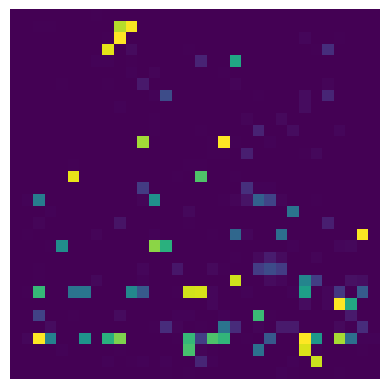

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reverse_engineer(param = {
    "dataset": "cifar10",
    "Epochs": 100,
    "batch_size": 64,
    "target_label": 3,
    "cost_lambda": 1e-3,
    "num_classes": 10,
    "image_size": (32, 32)}, model = torch.load('model_cifar10_0.15_3.pkl').to(device))

### Target Label = 4, Injection Rate = 0.15

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
param = {
    "dataset": "cifar10",
    "model": "default",
    "poisoning_method": "badnet",
    "injection_rate": 0.15,
    "target_label": 4,
    "Epochs": 150,
    "batch_size": 64
    }
fill_param(param)
train(param)

Testing...: 100%|██████████| 157/157 [00:00<00:00, 288.99it/s]


Epoch: 1, Training Accuracy: 49.47, Testing Accuracy: 54.39, Testing ASR: 96.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 302.31it/s]


Epoch: 2, Training Accuracy: 65.092, Testing Accuracy: 66.13, Testing ASR: 96.31


Testing...: 100%|██████████| 157/157 [00:00<00:00, 316.82it/s]


Epoch: 3, Training Accuracy: 71.402, Testing Accuracy: 68.26, Testing ASR: 96.28


Testing...: 100%|██████████| 157/157 [00:00<00:00, 302.11it/s]


Epoch: 4, Training Accuracy: 74.248, Testing Accuracy: 72.6, Testing ASR: 97.13


Testing...: 100%|██████████| 157/157 [00:00<00:00, 272.38it/s]


Epoch: 5, Training Accuracy: 76.682, Testing Accuracy: 75.69, Testing ASR: 96.15


Testing...: 100%|██████████| 157/157 [00:00<00:00, 262.49it/s]


Epoch: 6, Training Accuracy: 77.984, Testing Accuracy: 76.77, Testing ASR: 97.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 293.58it/s]


Epoch: 7, Training Accuracy: 79.644, Testing Accuracy: 77.19, Testing ASR: 96.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 338.40it/s]


Epoch: 8, Training Accuracy: 80.646, Testing Accuracy: 78.06, Testing ASR: 97.36


Testing...: 100%|██████████| 157/157 [00:00<00:00, 330.62it/s]


Epoch: 9, Training Accuracy: 81.848, Testing Accuracy: 77.43, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 315.55it/s]


Epoch: 10, Training Accuracy: 82.632, Testing Accuracy: 77.72, Testing ASR: 97.42


Testing...: 100%|██████████| 157/157 [00:00<00:00, 315.04it/s]


Epoch: 11, Training Accuracy: 83.274, Testing Accuracy: 79.48, Testing ASR: 97.38


Testing...: 100%|██████████| 157/157 [00:00<00:00, 313.43it/s]


Epoch: 12, Training Accuracy: 83.884, Testing Accuracy: 79.9, Testing ASR: 97.27


Testing...: 100%|██████████| 157/157 [00:00<00:00, 287.14it/s]


Epoch: 13, Training Accuracy: 84.678, Testing Accuracy: 78.42, Testing ASR: 96.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 304.51it/s]


Epoch: 14, Training Accuracy: 85.048, Testing Accuracy: 80.16, Testing ASR: 97.38


Testing...: 100%|██████████| 157/157 [00:00<00:00, 277.47it/s]


Epoch: 15, Training Accuracy: 85.368, Testing Accuracy: 78.99, Testing ASR: 96.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 281.47it/s]


Epoch: 16, Training Accuracy: 86.122, Testing Accuracy: 81.05, Testing ASR: 97.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 328.29it/s]


Epoch: 17, Training Accuracy: 86.598, Testing Accuracy: 81.09, Testing ASR: 97.1


Testing...: 100%|██████████| 157/157 [00:00<00:00, 281.64it/s]


Epoch: 18, Training Accuracy: 87.004, Testing Accuracy: 81.34, Testing ASR: 97.11


Testing...: 100%|██████████| 157/157 [00:00<00:00, 294.89it/s]


Epoch: 19, Training Accuracy: 87.25, Testing Accuracy: 80.46, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 302.70it/s]


Epoch: 20, Training Accuracy: 87.656, Testing Accuracy: 81.45, Testing ASR: 97.22


Testing...: 100%|██████████| 157/157 [00:00<00:00, 305.60it/s]


Epoch: 21, Training Accuracy: 87.996, Testing Accuracy: 81.2, Testing ASR: 97.55


Testing...: 100%|██████████| 157/157 [00:00<00:00, 265.86it/s]


Epoch: 22, Training Accuracy: 88.288, Testing Accuracy: 81.48, Testing ASR: 97.13


Testing...: 100%|██████████| 157/157 [00:00<00:00, 315.60it/s]


Epoch: 23, Training Accuracy: 88.596, Testing Accuracy: 81.34, Testing ASR: 97.48


Testing...: 100%|██████████| 157/157 [00:00<00:00, 310.57it/s]


Epoch: 24, Training Accuracy: 88.832, Testing Accuracy: 81.33, Testing ASR: 96.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 291.28it/s]


Epoch: 25, Training Accuracy: 89.382, Testing Accuracy: 80.69, Testing ASR: 96.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 294.51it/s]


Epoch: 26, Training Accuracy: 89.53, Testing Accuracy: 81.68, Testing ASR: 96.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 330.37it/s]


Epoch: 27, Training Accuracy: 89.604, Testing Accuracy: 81.68, Testing ASR: 97.48


Testing...: 100%|██████████| 157/157 [00:00<00:00, 284.55it/s]


Epoch: 28, Training Accuracy: 89.804, Testing Accuracy: 81.5, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 313.47it/s]


Epoch: 29, Training Accuracy: 90.214, Testing Accuracy: 81.4, Testing ASR: 97.6


Testing...: 100%|██████████| 157/157 [00:00<00:00, 290.84it/s]


Epoch: 30, Training Accuracy: 90.222, Testing Accuracy: 81.59, Testing ASR: 97.13


Testing...: 100%|██████████| 157/157 [00:00<00:00, 304.73it/s]


Epoch: 31, Training Accuracy: 90.672, Testing Accuracy: 81.82, Testing ASR: 97.6


Testing...: 100%|██████████| 157/157 [00:00<00:00, 312.65it/s]


Epoch: 32, Training Accuracy: 90.65, Testing Accuracy: 80.81, Testing ASR: 97.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 254.19it/s]


Epoch: 33, Training Accuracy: 90.9, Testing Accuracy: 81.91, Testing ASR: 97.21


Testing...: 100%|██████████| 157/157 [00:00<00:00, 247.71it/s]


Epoch: 34, Training Accuracy: 90.978, Testing Accuracy: 81.12, Testing ASR: 97.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 330.44it/s]


Epoch: 35, Training Accuracy: 91.154, Testing Accuracy: 81.76, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 315.54it/s]


Epoch: 36, Training Accuracy: 91.14, Testing Accuracy: 81.96, Testing ASR: 96.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 310.59it/s]


Epoch: 37, Training Accuracy: 91.594, Testing Accuracy: 82.06, Testing ASR: 97.26


Testing...: 100%|██████████| 157/157 [00:00<00:00, 280.32it/s]


Epoch: 38, Training Accuracy: 91.634, Testing Accuracy: 82.01, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 323.75it/s]


Epoch: 39, Training Accuracy: 91.78, Testing Accuracy: 82.3, Testing ASR: 97.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.02it/s]


Epoch: 40, Training Accuracy: 91.88, Testing Accuracy: 81.75, Testing ASR: 97.63


Testing...: 100%|██████████| 157/157 [00:00<00:00, 301.22it/s]


Epoch: 41, Training Accuracy: 92.18, Testing Accuracy: 82.02, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 308.63it/s]


Epoch: 42, Training Accuracy: 92.194, Testing Accuracy: 81.72, Testing ASR: 97.24


Testing...: 100%|██████████| 157/157 [00:00<00:00, 304.17it/s]


Epoch: 43, Training Accuracy: 92.282, Testing Accuracy: 82.16, Testing ASR: 97.41


Testing...: 100%|██████████| 157/157 [00:00<00:00, 262.84it/s]


Epoch: 44, Training Accuracy: 92.24, Testing Accuracy: 81.87, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 317.73it/s]


Epoch: 45, Training Accuracy: 92.456, Testing Accuracy: 82.03, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 299.57it/s]


Epoch: 46, Training Accuracy: 92.512, Testing Accuracy: 82.0, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 326.91it/s]


Epoch: 47, Training Accuracy: 92.662, Testing Accuracy: 82.44, Testing ASR: 97.39


Testing...: 100%|██████████| 157/157 [00:00<00:00, 273.58it/s]


Epoch: 48, Training Accuracy: 92.712, Testing Accuracy: 82.38, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 325.82it/s]


Epoch: 49, Training Accuracy: 92.824, Testing Accuracy: 82.38, Testing ASR: 97.51


Testing...: 100%|██████████| 157/157 [00:00<00:00, 321.28it/s]


Epoch: 50, Training Accuracy: 92.932, Testing Accuracy: 82.21, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 328.84it/s]


Epoch: 51, Training Accuracy: 93.08, Testing Accuracy: 81.34, Testing ASR: 97.34


Testing...: 100%|██████████| 157/157 [00:00<00:00, 300.02it/s]


Epoch: 52, Training Accuracy: 93.118, Testing Accuracy: 82.68, Testing ASR: 97.52


Testing...: 100%|██████████| 157/157 [00:00<00:00, 277.79it/s]


Epoch: 53, Training Accuracy: 93.15, Testing Accuracy: 82.5, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 289.35it/s]


Epoch: 54, Training Accuracy: 93.108, Testing Accuracy: 82.28, Testing ASR: 97.34


Testing...: 100%|██████████| 157/157 [00:00<00:00, 303.64it/s]


Epoch: 55, Training Accuracy: 93.29, Testing Accuracy: 82.33, Testing ASR: 97.63


Testing...: 100%|██████████| 157/157 [00:00<00:00, 305.67it/s]


Epoch: 56, Training Accuracy: 93.342, Testing Accuracy: 80.06, Testing ASR: 98.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 330.44it/s]


Epoch: 57, Training Accuracy: 93.472, Testing Accuracy: 81.71, Testing ASR: 97.61


Testing...: 100%|██████████| 157/157 [00:00<00:00, 297.77it/s]


Epoch: 58, Training Accuracy: 93.528, Testing Accuracy: 81.92, Testing ASR: 97.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 294.82it/s]


Epoch: 59, Training Accuracy: 93.73, Testing Accuracy: 82.63, Testing ASR: 97.15


Testing...: 100%|██████████| 157/157 [00:00<00:00, 306.00it/s]


Epoch: 60, Training Accuracy: 93.69, Testing Accuracy: 81.91, Testing ASR: 97.57


Testing...: 100%|██████████| 157/157 [00:00<00:00, 313.07it/s]


Epoch: 61, Training Accuracy: 93.752, Testing Accuracy: 81.9, Testing ASR: 97.38


Testing...: 100%|██████████| 157/157 [00:00<00:00, 295.05it/s]


Epoch: 62, Training Accuracy: 93.762, Testing Accuracy: 81.97, Testing ASR: 97.53


Testing...: 100%|██████████| 157/157 [00:00<00:00, 323.71it/s]


Epoch: 63, Training Accuracy: 93.774, Testing Accuracy: 81.9, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 317.09it/s]


Epoch: 64, Training Accuracy: 94.024, Testing Accuracy: 82.31, Testing ASR: 97.5


Testing...: 100%|██████████| 157/157 [00:00<00:00, 272.71it/s]


Epoch: 65, Training Accuracy: 93.888, Testing Accuracy: 82.06, Testing ASR: 97.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 308.01it/s]


Epoch: 66, Training Accuracy: 94.128, Testing Accuracy: 82.47, Testing ASR: 97.48


Testing...: 100%|██████████| 157/157 [00:00<00:00, 293.96it/s]


Epoch: 67, Training Accuracy: 94.092, Testing Accuracy: 82.44, Testing ASR: 96.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 325.67it/s]


Epoch: 68, Training Accuracy: 94.21, Testing Accuracy: 82.16, Testing ASR: 97.59


Testing...: 100%|██████████| 157/157 [00:00<00:00, 323.50it/s]


Epoch: 69, Training Accuracy: 93.948, Testing Accuracy: 82.33, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 335.92it/s]


Epoch: 70, Training Accuracy: 94.316, Testing Accuracy: 82.2, Testing ASR: 97.51


Testing...: 100%|██████████| 157/157 [00:00<00:00, 339.54it/s]


Epoch: 71, Training Accuracy: 94.222, Testing Accuracy: 82.09, Testing ASR: 97.44


Testing...: 100%|██████████| 157/157 [00:00<00:00, 338.23it/s]


Epoch: 72, Training Accuracy: 94.296, Testing Accuracy: 82.62, Testing ASR: 97.43


Testing...: 100%|██████████| 157/157 [00:00<00:00, 339.24it/s]


Epoch: 73, Training Accuracy: 94.322, Testing Accuracy: 82.67, Testing ASR: 97.36


Testing...: 100%|██████████| 157/157 [00:00<00:00, 311.26it/s]


Epoch: 74, Training Accuracy: 94.202, Testing Accuracy: 82.48, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 335.46it/s]


Epoch: 75, Training Accuracy: 94.472, Testing Accuracy: 82.69, Testing ASR: 97.14


Testing...: 100%|██████████| 157/157 [00:00<00:00, 325.54it/s]


Epoch: 76, Training Accuracy: 94.44, Testing Accuracy: 82.24, Testing ASR: 98.3


Testing...: 100%|██████████| 157/157 [00:00<00:00, 334.30it/s]


Epoch: 77, Training Accuracy: 94.434, Testing Accuracy: 81.66, Testing ASR: 97.45


Testing...: 100%|██████████| 157/157 [00:00<00:00, 327.65it/s]


Epoch: 78, Training Accuracy: 94.612, Testing Accuracy: 82.41, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 336.31it/s]


Epoch: 79, Training Accuracy: 94.51, Testing Accuracy: 80.99, Testing ASR: 97.54


Testing...: 100%|██████████| 157/157 [00:00<00:00, 321.60it/s]


Epoch: 80, Training Accuracy: 94.732, Testing Accuracy: 82.45, Testing ASR: 97.26


Testing...: 100%|██████████| 157/157 [00:00<00:00, 332.92it/s]


Epoch: 81, Training Accuracy: 95.322, Testing Accuracy: 83.16, Testing ASR: 97.61


Testing...: 100%|██████████| 157/157 [00:00<00:00, 329.48it/s]


Epoch: 82, Training Accuracy: 95.708, Testing Accuracy: 82.78, Testing ASR: 97.42


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.62it/s]


Epoch: 83, Training Accuracy: 95.874, Testing Accuracy: 82.87, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 301.12it/s]


Epoch: 84, Training Accuracy: 95.82, Testing Accuracy: 82.76, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 345.37it/s]


Epoch: 85, Training Accuracy: 96.034, Testing Accuracy: 82.93, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 361.90it/s]


Epoch: 86, Training Accuracy: 96.208, Testing Accuracy: 83.13, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 310.88it/s]


Epoch: 87, Training Accuracy: 96.22, Testing Accuracy: 83.33, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 332.40it/s]


Epoch: 88, Training Accuracy: 96.152, Testing Accuracy: 83.22, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 348.41it/s]


Epoch: 89, Training Accuracy: 96.19, Testing Accuracy: 83.14, Testing ASR: 97.53


Testing...: 100%|██████████| 157/157 [00:00<00:00, 332.92it/s]


Epoch: 90, Training Accuracy: 96.324, Testing Accuracy: 83.09, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 349.45it/s]


Epoch: 91, Training Accuracy: 96.308, Testing Accuracy: 83.25, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 351.77it/s]


Epoch: 92, Training Accuracy: 96.172, Testing Accuracy: 83.13, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.16it/s]


Epoch: 93, Training Accuracy: 96.32, Testing Accuracy: 82.99, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 301.24it/s]


Epoch: 94, Training Accuracy: 96.284, Testing Accuracy: 83.0, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 354.67it/s]


Epoch: 95, Training Accuracy: 96.348, Testing Accuracy: 83.13, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 293.10it/s]


Epoch: 96, Training Accuracy: 96.384, Testing Accuracy: 82.82, Testing ASR: 97.6


Testing...: 100%|██████████| 157/157 [00:00<00:00, 337.33it/s]


Epoch: 97, Training Accuracy: 96.438, Testing Accuracy: 83.08, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 333.53it/s]


Epoch: 98, Training Accuracy: 96.466, Testing Accuracy: 83.03, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 342.38it/s]


Epoch: 99, Training Accuracy: 96.51, Testing Accuracy: 82.96, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 325.97it/s]


Epoch: 100, Training Accuracy: 96.692, Testing Accuracy: 83.38, Testing ASR: 97.49


Testing...: 100%|██████████| 157/157 [00:00<00:00, 358.88it/s]


Epoch: 101, Training Accuracy: 96.758, Testing Accuracy: 83.34, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 342.72it/s]


Epoch: 102, Training Accuracy: 96.906, Testing Accuracy: 83.48, Testing ASR: 97.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 322.83it/s]


Epoch: 103, Training Accuracy: 96.962, Testing Accuracy: 83.57, Testing ASR: 97.63


Testing...: 100%|██████████| 157/157 [00:00<00:00, 356.31it/s]


Epoch: 104, Training Accuracy: 97.094, Testing Accuracy: 83.5, Testing ASR: 97.6


Testing...: 100%|██████████| 157/157 [00:00<00:00, 344.57it/s]


Epoch: 105, Training Accuracy: 97.26, Testing Accuracy: 83.7, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 323.96it/s]


Epoch: 106, Training Accuracy: 97.13, Testing Accuracy: 83.5, Testing ASR: 97.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 346.65it/s]


Epoch: 107, Training Accuracy: 97.224, Testing Accuracy: 83.41, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 357.45it/s]


Epoch: 108, Training Accuracy: 97.276, Testing Accuracy: 83.6, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 339.81it/s]


Epoch: 109, Training Accuracy: 97.326, Testing Accuracy: 83.46, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 338.17it/s]


Epoch: 110, Training Accuracy: 97.372, Testing Accuracy: 83.58, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 324.19it/s]


Epoch: 111, Training Accuracy: 97.278, Testing Accuracy: 83.64, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 300.45it/s]


Epoch: 112, Training Accuracy: 97.438, Testing Accuracy: 83.64, Testing ASR: 97.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 348.77it/s]


Epoch: 113, Training Accuracy: 97.388, Testing Accuracy: 83.61, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 339.12it/s]


Epoch: 114, Training Accuracy: 97.482, Testing Accuracy: 83.53, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 345.56it/s]


Epoch: 115, Training Accuracy: 97.494, Testing Accuracy: 83.6, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 327.59it/s]


Epoch: 116, Training Accuracy: 97.444, Testing Accuracy: 83.67, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 352.22it/s]


Epoch: 117, Training Accuracy: 97.504, Testing Accuracy: 83.55, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 315.81it/s]


Epoch: 118, Training Accuracy: 97.37, Testing Accuracy: 83.82, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 346.20it/s]


Epoch: 119, Training Accuracy: 97.474, Testing Accuracy: 83.57, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 354.61it/s]


Epoch: 120, Training Accuracy: 97.566, Testing Accuracy: 83.63, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 334.26it/s]


Epoch: 121, Training Accuracy: 97.538, Testing Accuracy: 83.47, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 334.60it/s]


Epoch: 122, Training Accuracy: 97.43, Testing Accuracy: 83.48, Testing ASR: 97.63


Testing...: 100%|██████████| 157/157 [00:00<00:00, 327.58it/s]


Epoch: 123, Training Accuracy: 97.384, Testing Accuracy: 83.49, Testing ASR: 97.61


Testing...: 100%|██████████| 157/157 [00:00<00:00, 345.75it/s]


Epoch: 124, Training Accuracy: 97.48, Testing Accuracy: 83.61, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 317.19it/s]


Epoch: 125, Training Accuracy: 97.476, Testing Accuracy: 83.49, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 321.36it/s]


Epoch: 126, Training Accuracy: 97.648, Testing Accuracy: 83.59, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 318.44it/s]


Epoch: 127, Training Accuracy: 97.49, Testing Accuracy: 83.64, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 289.72it/s]


Epoch: 128, Training Accuracy: 97.556, Testing Accuracy: 83.75, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 293.92it/s]


Epoch: 129, Training Accuracy: 97.752, Testing Accuracy: 83.59, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 261.09it/s]


Epoch: 130, Training Accuracy: 97.598, Testing Accuracy: 83.61, Testing ASR: 97.59


Testing...: 100%|██████████| 157/157 [00:00<00:00, 280.21it/s]


Epoch: 131, Training Accuracy: 97.574, Testing Accuracy: 83.74, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 305.90it/s]


Epoch: 132, Training Accuracy: 97.662, Testing Accuracy: 83.77, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 235.48it/s]


Epoch: 133, Training Accuracy: 97.68, Testing Accuracy: 83.68, Testing ASR: 97.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 290.61it/s]


Epoch: 134, Training Accuracy: 97.684, Testing Accuracy: 83.58, Testing ASR: 97.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 281.73it/s]


Epoch: 135, Training Accuracy: 97.506, Testing Accuracy: 83.76, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 288.93it/s]


Epoch: 136, Training Accuracy: 97.754, Testing Accuracy: 83.64, Testing ASR: 97.61


Testing...: 100%|██████████| 157/157 [00:00<00:00, 280.24it/s]


Epoch: 137, Training Accuracy: 97.738, Testing Accuracy: 83.61, Testing ASR: 97.63


Testing...: 100%|██████████| 157/157 [00:00<00:00, 308.25it/s]


Epoch: 138, Training Accuracy: 97.678, Testing Accuracy: 83.57, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 292.18it/s]


Epoch: 139, Training Accuracy: 97.756, Testing Accuracy: 83.39, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 255.27it/s]


Epoch: 140, Training Accuracy: 97.708, Testing Accuracy: 83.38, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 294.62it/s]


Epoch: 141, Training Accuracy: 97.786, Testing Accuracy: 83.37, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 294.05it/s]


Epoch: 142, Training Accuracy: 97.686, Testing Accuracy: 83.48, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 280.13it/s]


Epoch: 143, Training Accuracy: 97.794, Testing Accuracy: 83.51, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 310.16it/s]


Epoch: 144, Training Accuracy: 97.792, Testing Accuracy: 83.64, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 261.33it/s]


Epoch: 145, Training Accuracy: 97.786, Testing Accuracy: 83.7, Testing ASR: 97.6


Testing...: 100%|██████████| 157/157 [00:00<00:00, 286.60it/s]


Epoch: 146, Training Accuracy: 97.774, Testing Accuracy: 83.52, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 303.74it/s]


Epoch: 147, Training Accuracy: 97.692, Testing Accuracy: 83.4, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 306.76it/s]


Epoch: 148, Training Accuracy: 97.636, Testing Accuracy: 83.51, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 245.68it/s]


Epoch: 149, Training Accuracy: 97.72, Testing Accuracy: 83.4, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 308.34it/s]

Epoch: 150, Training Accuracy: 97.794, Testing Accuracy: 83.43, Testing ASR: 97.88


Processing label: 0


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 99.80it/s] 


norm: 498.0425109863281


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 99.72it/s] 


norm: 456.99725341796875


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 99.31it/s] 


norm: 406.9804382324219


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 96.49it/s]


norm: 354.5364074707031


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 97.59it/s]


norm: 303.661865234375


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 97.46it/s]


norm: 257.0128479003906


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 96.37it/s]


norm: 215.71463012695312


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 98.33it/s]


norm: 182.26597595214844


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 97.48it/s]


norm: 154.06980895996094


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 96.61it/s]


norm: 131.79983520507812


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 93.43it/s]


norm: 114.40055847167969


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 97.53it/s]


norm: 100.85508728027344


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 95.81it/s]


norm: 89.72530364990234


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 95.75it/s]


norm: 80.82194519042969


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 94.83it/s]


norm: 74.00094604492188


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 97.23it/s]


norm: 70.06855773925781


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 98.78it/s] 


norm: 66.28671264648438


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 100.65it/s]


norm: 63.35101318359375


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 96.41it/s]


norm: 61.31962585449219


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 93.70it/s]


norm: 58.636924743652344


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 92.41it/s]


norm: 57.05772018432617


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 88.33it/s]


norm: 55.594329833984375


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 94.61it/s]


norm: 54.86237716674805


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 90.81it/s]


norm: 52.93019104003906


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 97.26it/s]


norm: 51.464115142822266


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 94.45it/s]


norm: 50.686241149902344


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 91.15it/s]


norm: 50.11133575439453


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 92.14it/s]


norm: 49.47677230834961


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 94.66it/s]


norm: 49.33747863769531


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 93.73it/s]


norm: 49.494346618652344


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 96.77it/s]


norm: 49.52726745605469


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 92.27it/s]


norm: 49.21855163574219


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 91.58it/s]


norm: 49.12139129638672


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 91.23it/s]


norm: 49.18442916870117


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 95.13it/s]


norm: 49.369842529296875


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 95.23it/s]


norm: 49.40982437133789


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 98.53it/s]


norm: 49.475685119628906


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 97.10it/s]


norm: 49.395992279052734


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 97.20it/s]


norm: 48.963836669921875


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 96.59it/s]


norm: 49.25764465332031


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 99.23it/s] 


norm: 48.83644104003906


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 97.81it/s]


norm: 48.68460464477539


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 97.54it/s] 


norm: 47.72657012939453


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 98.35it/s]


norm: 46.64900207519531


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 95.10it/s]


norm: 45.890419006347656


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 96.54it/s]


norm: 44.96916580200195


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 96.18it/s]


norm: 44.14904022216797


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 98.81it/s] 


norm: 43.91706848144531


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 94.65it/s]


norm: 43.6989860534668


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 97.09it/s]


norm: 43.396026611328125


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 97.07it/s]


norm: 43.13134765625


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 97.10it/s]


norm: 42.9473876953125


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 91.53it/s]


norm: 42.58839797973633


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 97.71it/s] 


norm: 42.48297882080078


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 93.15it/s]


norm: 42.45165252685547


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 99.17it/s] 


norm: 42.354148864746094


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 98.61it/s]


norm: 41.88200759887695


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 91.63it/s]


norm: 41.71525573730469


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 96.93it/s] 


norm: 41.56709289550781


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 94.81it/s]


norm: 41.50407409667969


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 90.63it/s]


norm: 41.55888748168945


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 90.55it/s]


norm: 40.34332275390625


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 95.40it/s]


norm: 40.53046417236328


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 96.09it/s]


norm: 40.382633209228516


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 97.89it/s]


norm: 39.73040771484375


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 98.38it/s]


norm: 39.35973358154297


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 97.12it/s]


norm: 39.57122039794922


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 97.61it/s]


norm: 39.4344482421875


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 100.13it/s]


norm: 39.084842681884766


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 95.54it/s]


norm: 39.16718673706055


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 88.63it/s]


norm: 39.081966400146484


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 89.71it/s]


norm: 39.35396194458008


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 93.76it/s]


norm: 39.290069580078125


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 95.93it/s]


norm: 39.26078796386719


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 94.53it/s]


norm: 39.31938171386719


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 97.82it/s]


norm: 39.30064010620117


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 96.60it/s]


norm: 39.31999969482422


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 95.69it/s]


norm: 39.16969299316406


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 92.32it/s]


norm: 38.969783782958984


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 94.63it/s]


norm: 38.950103759765625


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 97.24it/s]


norm: 39.14252471923828


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 96.37it/s]


norm: 38.97107696533203


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 96.04it/s]


norm: 38.775848388671875


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 96.51it/s]


norm: 38.514930725097656


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 91.29it/s]


norm: 38.536521911621094


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 95.06it/s]


norm: 38.4599723815918


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 94.60it/s]


norm: 38.71614074707031


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 92.88it/s]


norm: 38.52442169189453


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 90.52it/s]


norm: 38.720314025878906


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 96.80it/s]


norm: 38.834861755371094


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 97.93it/s]


norm: 38.74874496459961


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 98.10it/s]


norm: 38.779693603515625


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 95.11it/s]


norm: 38.837440490722656


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 94.59it/s]


norm: 39.009735107421875


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 95.36it/s]


norm: 39.03630065917969


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 92.89it/s]


norm: 39.033226013183594


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 95.76it/s]


norm: 38.79204559326172


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 96.46it/s]


norm: 39.06549072265625


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 94.02it/s]


norm: 39.127349853515625


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 97.08it/s]


norm: 39.114200592041016
Processing label: 1


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 98.18it/s]


norm: 484.4100036621094


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 99.59it/s] 


norm: 444.04302978515625


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 94.16it/s]


norm: 395.6304931640625


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 92.82it/s]


norm: 343.991455078125


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 91.54it/s]


norm: 293.3180847167969


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 94.22it/s]


norm: 247.86660766601562


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 96.04it/s]


norm: 207.19308471679688


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 96.16it/s]


norm: 174.8480682373047


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 95.31it/s]


norm: 149.99313354492188


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 97.55it/s]


norm: 130.19943237304688


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 97.68it/s]


norm: 115.05522918701172


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 98.70it/s]


norm: 103.23677062988281


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 97.72it/s] 


norm: 94.37200927734375


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 92.23it/s]


norm: 87.57557678222656


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 97.04it/s]


norm: 81.748046875


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 97.90it/s] 


norm: 77.78711700439453


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 100.45it/s]


norm: 74.0313491821289


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 94.21it/s]


norm: 71.36531066894531


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 90.31it/s]


norm: 69.44760131835938


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 95.35it/s]


norm: 67.7122802734375


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 97.68it/s]


norm: 66.22579956054688


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 96.61it/s]


norm: 64.53922271728516


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 97.54it/s]


norm: 63.218360900878906


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 97.34it/s]


norm: 61.951576232910156


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 93.44it/s]


norm: 60.948333740234375


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 91.55it/s]


norm: 59.60442352294922


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 98.06it/s]


norm: 58.87518310546875


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 96.98it/s]


norm: 58.911155700683594


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 98.03it/s]


norm: 58.28248596191406


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 98.40it/s]


norm: 57.339595794677734


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 95.34it/s]


norm: 56.15605926513672


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 95.03it/s]


norm: 55.668601989746094


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 99.13it/s] 


norm: 55.3836669921875


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 96.56it/s]


norm: 55.40350341796875


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 96.11it/s]


norm: 55.30705261230469


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 98.95it/s]


norm: 54.73181915283203


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 99.11it/s] 


norm: 54.026641845703125


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 92.23it/s]


norm: 53.68271255493164


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 91.57it/s]


norm: 53.44728088378906


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 95.83it/s]


norm: 52.874481201171875


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 95.44it/s] 


norm: 52.6678466796875


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 96.97it/s]


norm: 52.80768585205078


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 97.14it/s]


norm: 52.11273193359375


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 96.85it/s]


norm: 51.446983337402344


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 94.61it/s]


norm: 50.77271270751953


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 91.64it/s]


norm: 50.097023010253906


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 96.10it/s]


norm: 49.819515228271484


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 91.87it/s]


norm: 49.653839111328125


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 92.78it/s]


norm: 48.93090057373047


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 95.82it/s]


norm: 48.63648223876953


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 94.50it/s]


norm: 48.60853576660156


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 94.07it/s]


norm: 48.599082946777344


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 91.04it/s]


norm: 48.05644989013672


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 92.66it/s]


norm: 47.46783447265625


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 91.34it/s]


norm: 47.47966003417969


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 90.69it/s]


norm: 46.85212707519531


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 97.31it/s]


norm: 46.5400505065918


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 95.83it/s]


norm: 46.496891021728516


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 96.24it/s]


norm: 46.31190490722656


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 98.20it/s]


norm: 46.17415237426758


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 97.38it/s]


norm: 45.76882553100586


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 96.50it/s]


norm: 45.6208610534668


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 98.85it/s] 


norm: 45.299224853515625


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 90.69it/s]


norm: 45.451988220214844


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 97.12it/s]


norm: 45.395904541015625


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 96.20it/s]


norm: 45.68793487548828


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 97.95it/s]


norm: 45.279273986816406


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 96.47it/s]


norm: 44.994903564453125


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 98.30it/s] 


norm: 44.88058853149414


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 101.45it/s]


norm: 44.90106201171875


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 100.62it/s]


norm: 44.6588020324707


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 98.46it/s] 


norm: 44.299041748046875


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 100.75it/s]


norm: 44.32097625732422


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 100.90it/s]


norm: 44.10272216796875


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 101.69it/s]


norm: 43.433921813964844


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 100.47it/s]


norm: 42.68321228027344


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 93.77it/s]


norm: 42.89404296875


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 99.88it/s] 


norm: 42.66893768310547


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 93.65it/s]


norm: 42.82599639892578


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 95.65it/s]


norm: 42.87232971191406


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 98.24it/s] 


norm: 42.918060302734375


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 100.86it/s]


norm: 42.292877197265625


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 93.13it/s]


norm: 42.397926330566406


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 96.57it/s] 


norm: 41.998626708984375


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 100.37it/s]


norm: 41.476924896240234


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 101.95it/s]


norm: 40.97050476074219


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 99.37it/s]


norm: 40.25063705444336


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 99.88it/s] 


norm: 40.06182861328125


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 101.13it/s]


norm: 40.124305725097656


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 102.80it/s]


norm: 40.12264633178711


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 97.87it/s]


norm: 40.23694610595703


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 99.20it/s] 


norm: 40.1777458190918


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 99.09it/s]


norm: 40.0804443359375


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 100.62it/s]


norm: 40.201377868652344


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 100.40it/s]


norm: 40.176734924316406


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 99.86it/s] 


norm: 40.233665466308594


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 96.65it/s]


norm: 40.15496063232422


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 99.26it/s] 


norm: 40.14018630981445


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 97.08it/s]


norm: 40.70806884765625


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 100.56it/s]


norm: 39.923683166503906
Processing label: 2


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 100.28it/s]


norm: 471.6005859375


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 101.73it/s]


norm: 410.0398864746094


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 101.71it/s]


norm: 342.4353332519531


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 100.09it/s]


norm: 279.475341796875


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 102.18it/s]


norm: 227.64877319335938


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 99.41it/s] 


norm: 188.1290283203125


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 98.95it/s]


norm: 156.32110595703125


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 101.67it/s]


norm: 131.61199951171875


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 100.80it/s]


norm: 113.12908935546875


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 97.12it/s]


norm: 97.56828308105469


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 90.70it/s]


norm: 86.83740234375


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 97.15it/s] 


norm: 78.31312561035156


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 100.30it/s]


norm: 71.93400573730469


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 97.40it/s] 


norm: 66.75546264648438


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 92.87it/s]


norm: 62.87436294555664


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 98.75it/s] 


norm: 60.213218688964844


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 99.49it/s] 


norm: 57.45392608642578


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 96.54it/s]


norm: 55.89137268066406


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 96.97it/s] 


norm: 55.421180725097656


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 101.01it/s]


norm: 53.45499038696289


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 98.69it/s] 


norm: 52.64909362792969


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 100.70it/s]


norm: 51.77708435058594


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 100.43it/s]


norm: 51.160072326660156


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 98.62it/s]


norm: 51.15705108642578


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 94.19it/s]


norm: 50.70747756958008


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 98.91it/s] 


norm: 50.25067901611328


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 100.36it/s]


norm: 49.707000732421875


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 100.61it/s]


norm: 49.182403564453125


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 96.78it/s]


norm: 49.61786651611328


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 91.18it/s]


norm: 49.19911193847656


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 93.09it/s]


norm: 49.112918853759766


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 97.46it/s]


norm: 48.89659881591797


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 91.21it/s]


norm: 48.61510467529297


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 93.36it/s]


norm: 48.329078674316406


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 97.54it/s]


norm: 48.518959045410156


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 97.66it/s]


norm: 48.13022232055664


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 91.13it/s]


norm: 48.16728973388672


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 95.26it/s]


norm: 48.35503387451172


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 100.53it/s]


norm: 48.4490966796875


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 100.13it/s]


norm: 48.43798828125


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 96.14it/s]


norm: 48.261474609375


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 94.47it/s]


norm: 48.32263946533203


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 95.52it/s]


norm: 48.50682067871094


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 100.27it/s]


norm: 48.18383026123047


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 99.37it/s] 


norm: 48.292503356933594


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 97.80it/s]


norm: 48.2490348815918


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 99.36it/s] 


norm: 48.085479736328125


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 101.98it/s]


norm: 48.19200134277344


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 99.82it/s] 


norm: 48.29217529296875


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 100.06it/s]


norm: 48.427223205566406


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 97.60it/s]


norm: 48.94148254394531


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 97.02it/s] 


norm: 48.27057647705078


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 96.22it/s]


norm: 48.636444091796875


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 99.10it/s] 


norm: 48.24542236328125


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 100.85it/s]


norm: 48.825225830078125


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 97.11it/s]


norm: 47.53226852416992


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 93.36it/s]


norm: 49.73560333251953


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 93.73it/s]


norm: 47.92164611816406


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 100.15it/s]


norm: 46.9975471496582


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 99.26it/s]


norm: 46.21531677246094


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 98.83it/s] 


norm: 46.547828674316406


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 93.93it/s]


norm: 46.675262451171875


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 97.14it/s]


norm: 46.3267936706543


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 94.59it/s]


norm: 46.48320770263672


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 95.30it/s]


norm: 46.54485321044922


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 99.35it/s] 


norm: 45.776466369628906


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 96.70it/s]


norm: 46.68403625488281


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 95.71it/s]


norm: 46.024539947509766


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 94.86it/s]


norm: 45.884490966796875


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 94.05it/s]


norm: 45.75884246826172


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 94.20it/s]


norm: 45.40056610107422


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 98.60it/s] 


norm: 45.88764572143555


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 99.84it/s] 


norm: 45.96928405761719


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 98.58it/s]


norm: 45.84355545043945


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 95.89it/s] 


norm: 45.91227722167969


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 99.42it/s] 


norm: 46.16173553466797


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 94.01it/s]


norm: 45.479190826416016


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 93.52it/s]


norm: 45.63310241699219


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 96.74it/s]


norm: 45.201751708984375


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 94.80it/s]


norm: 45.523746490478516


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 96.68it/s]


norm: 44.96318054199219


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 92.51it/s]


norm: 44.003292083740234


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 94.26it/s]


norm: 44.21050262451172


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 96.79it/s]


norm: 43.83172607421875


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 99.08it/s] 


norm: 43.34908676147461


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 96.32it/s]


norm: 43.68507766723633


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 93.95it/s]


norm: 43.100215911865234


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 94.78it/s]


norm: 43.15423583984375


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 98.49it/s] 


norm: 43.11315155029297


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 92.92it/s]


norm: 43.332489013671875


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 96.23it/s]


norm: 43.07343292236328


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 100.32it/s]


norm: 43.13031768798828


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 97.79it/s] 


norm: 43.158447265625


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 92.61it/s]


norm: 43.38367462158203


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 93.75it/s]


norm: 43.37706756591797


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 97.73it/s]


norm: 43.05290603637695


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 99.63it/s] 


norm: 43.24971008300781


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 98.01it/s]


norm: 43.49539566040039


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 93.90it/s]


norm: 43.02501678466797


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 93.48it/s]


norm: 43.209815979003906
Processing label: 3


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 101.28it/s]


norm: 478.46710205078125


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 100.70it/s]


norm: 423.04327392578125


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 98.43it/s]


norm: 361.3839111328125


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 94.48it/s]


norm: 301.03582763671875


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 96.31it/s]


norm: 249.50933837890625


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 95.71it/s]


norm: 208.64862060546875


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 98.61it/s] 


norm: 176.46981811523438


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 104.31it/s]


norm: 153.28500366210938


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 95.36it/s]


norm: 135.29586791992188


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 95.81it/s]


norm: 121.5453109741211


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 96.73it/s]


norm: 110.30581665039062


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 97.36it/s] 


norm: 100.45050811767578


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 101.42it/s]


norm: 93.40919494628906


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 104.45it/s]


norm: 87.65834045410156


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 101.97it/s]


norm: 83.2455825805664


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 93.76it/s]


norm: 79.35966491699219


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 96.67it/s]


norm: 76.298095703125


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 100.33it/s]


norm: 73.41215515136719


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 102.51it/s]


norm: 70.80171966552734


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 100.36it/s]


norm: 69.27259826660156


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 102.14it/s]


norm: 67.84077453613281


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 103.06it/s]


norm: 65.57525634765625


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 95.84it/s]


norm: 64.4656982421875


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 97.25it/s] 


norm: 63.027156829833984


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 103.07it/s]


norm: 62.35749435424805


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 100.09it/s]


norm: 61.444644927978516


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 97.73it/s]


norm: 60.87255096435547


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 94.93it/s]


norm: 60.906558990478516


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 96.33it/s]


norm: 60.81904602050781


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 94.57it/s]


norm: 60.737545013427734


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 91.37it/s]


norm: 60.008026123046875


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 94.48it/s]


norm: 60.066741943359375


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 93.68it/s]


norm: 59.53741455078125


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 97.23it/s]


norm: 59.291290283203125


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 92.33it/s]


norm: 59.0135612487793


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 96.59it/s]


norm: 58.60541534423828


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 97.25it/s]


norm: 58.18860626220703


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 94.63it/s]


norm: 57.78147506713867


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 95.31it/s]


norm: 57.959693908691406


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 95.71it/s]


norm: 57.140586853027344


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 95.90it/s]


norm: 57.53022766113281


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 95.14it/s]


norm: 57.23079299926758


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 97.01it/s]


norm: 56.577701568603516


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 99.88it/s] 


norm: 55.97612762451172


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 102.23it/s]


norm: 55.407936096191406


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 104.69it/s]


norm: 55.505271911621094


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 104.60it/s]


norm: 55.5262336730957


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 104.96it/s]


norm: 55.30609893798828


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 104.10it/s]


norm: 55.53156661987305


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 96.70it/s]


norm: 54.87188720703125


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 97.34it/s] 


norm: 54.89859390258789


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 97.34it/s]


norm: 54.66938781738281


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 98.09it/s]


norm: 57.52607727050781


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 96.25it/s]


norm: 55.28959655761719


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 96.46it/s]


norm: 55.23955154418945


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 99.59it/s] 


norm: 53.973297119140625


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 98.64it/s] 


norm: 53.46227264404297


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 102.38it/s]


norm: 53.50199890136719


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 103.21it/s]


norm: 54.37705612182617


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 104.17it/s]


norm: 53.663265228271484


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 97.22it/s]


norm: 53.64961242675781


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 98.27it/s] 


norm: 53.05924987792969


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 101.33it/s]


norm: 52.37579345703125


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 97.14it/s]


norm: 52.38002395629883


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 97.65it/s]


norm: 51.61149597167969


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 95.89it/s]


norm: 51.066490173339844


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 94.82it/s]


norm: 50.70354461669922


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 94.97it/s]


norm: 50.100257873535156


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 96.08it/s] 


norm: 50.06766128540039


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 97.88it/s]


norm: 50.52150344848633


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 95.73it/s]


norm: 50.856380462646484


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 95.72it/s]


norm: 50.737640380859375


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 96.18it/s]


norm: 50.10895538330078


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 102.84it/s]


norm: 50.612449645996094


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 102.10it/s]


norm: 49.79329299926758


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 104.38it/s]


norm: 50.00762939453125


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 101.74it/s]


norm: 50.058990478515625


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 103.95it/s]


norm: 49.90440368652344


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 102.77it/s]


norm: 49.81942367553711


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 102.30it/s]


norm: 49.79435348510742


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 96.56it/s]


norm: 49.87220001220703


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 94.26it/s]


norm: 49.929443359375


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 98.28it/s] 


norm: 49.954124450683594


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 103.38it/s]


norm: 50.29999542236328


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 102.43it/s]


norm: 50.419864654541016


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 103.00it/s]


norm: 50.16984176635742


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 102.30it/s]


norm: 49.3692512512207


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 104.59it/s]


norm: 49.333839416503906


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 95.09it/s]


norm: 49.606204986572266


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 96.22it/s]


norm: 49.55198669433594


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 97.39it/s]


norm: 49.18136978149414


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 96.76it/s]


norm: 48.66334533691406


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 98.09it/s]


norm: 50.273162841796875


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 104.49it/s]


norm: 50.25872802734375


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 101.83it/s]


norm: 48.564762115478516


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 96.79it/s]


norm: 48.96199035644531


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 102.07it/s]


norm: 48.450111389160156


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 95.14it/s]


norm: 48.919857025146484


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 95.81it/s]


norm: 49.31346130371094


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 95.88it/s]


norm: 51.90752410888672
Processing label: 4


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 99.25it/s] 


norm: 476.2226867675781


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 105.27it/s]


norm: 410.6922302246094


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 104.70it/s]


norm: 339.88470458984375


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 105.74it/s]


norm: 271.15838623046875


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 101.73it/s]


norm: 210.5226593017578


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 95.09it/s]


norm: 160.56103515625


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 96.11it/s]


norm: 121.80599975585938


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 96.83it/s]


norm: 91.34928131103516


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 99.97it/s] 


norm: 68.74485778808594


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 95.52it/s]


norm: 53.018489837646484


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 97.47it/s] 


norm: 40.47364044189453


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 95.27it/s]


norm: 30.223506927490234


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 101.09it/s]


norm: 22.800121307373047


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 99.08it/s]


norm: 16.682762145996094


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 94.78it/s]


norm: 12.623205184936523


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 96.55it/s] 


norm: 11.665812492370605


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 102.40it/s]


norm: 8.515685081481934


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 103.25it/s]


norm: 7.784841060638428


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 101.63it/s]


norm: 8.093950271606445


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 102.56it/s]


norm: 7.572767734527588


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 101.42it/s]


norm: 7.285633087158203


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 96.14it/s]


norm: 6.504583358764648


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 102.53it/s]


norm: 6.0124711990356445


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 105.27it/s]


norm: 6.543863296508789


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 103.41it/s]


norm: 5.896244049072266


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 100.96it/s]


norm: 5.827213287353516


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 99.03it/s] 


norm: 6.907172679901123


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 97.34it/s]


norm: 5.569373607635498


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 100.75it/s]


norm: 7.267906188964844


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 96.87it/s] 


norm: 6.604623317718506


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 103.79it/s]


norm: 5.667139053344727


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 100.52it/s]


norm: 5.848525524139404


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 95.71it/s]


norm: 8.48763370513916


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 96.83it/s]


norm: 5.686179161071777


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 97.19it/s]


norm: 5.336668491363525


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 102.02it/s]


norm: 6.891448020935059


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 105.25it/s]


norm: 5.572405815124512


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 103.01it/s]


norm: 5.657610893249512


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 103.95it/s]


norm: 6.2557573318481445


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 96.43it/s]


norm: 5.566154956817627


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 97.28it/s]


norm: 5.416625022888184


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 100.74it/s]


norm: 5.414712429046631


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 109.01it/s]


norm: 6.215461254119873


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 104.46it/s]


norm: 5.352987289428711


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 102.54it/s]


norm: 7.25166130065918


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 102.03it/s]


norm: 6.062270641326904


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 97.70it/s]


norm: 5.893401622772217


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 102.25it/s]


norm: 5.324779510498047


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 103.83it/s]


norm: 7.4855475425720215


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 103.20it/s]


norm: 5.897548675537109


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 101.63it/s]


norm: 5.199902057647705


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 98.14it/s] 


norm: 8.371992111206055


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 104.04it/s]


norm: 5.313950061798096


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 103.91it/s]


norm: 6.529460430145264


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 102.74it/s]


norm: 5.263937950134277


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 101.36it/s]


norm: 5.77675724029541


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 100.90it/s]


norm: 5.325065612792969


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 103.64it/s]


norm: 5.316336631774902


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 101.76it/s]


norm: 5.71783971786499


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 102.48it/s]


norm: 6.131887435913086


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 103.96it/s]


norm: 6.361432075500488


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 102.81it/s]


norm: 5.5909199714660645


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 104.16it/s]


norm: 5.476691722869873


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 103.88it/s]


norm: 5.226646423339844


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 103.20it/s]


norm: 5.654797077178955


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 95.90it/s] 


norm: 5.287075996398926


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 99.86it/s] 


norm: 8.03095817565918


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 102.11it/s]


norm: 6.090599536895752


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 102.99it/s]


norm: 5.401978969573975


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 103.97it/s]


norm: 7.052031993865967


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 104.01it/s]


norm: 5.0666022300720215


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 98.49it/s]


norm: 5.79405403137207


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 97.60it/s] 


norm: 5.449489593505859


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 104.31it/s]


norm: 5.410053730010986


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 103.29it/s]


norm: 5.336935520172119


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 103.49it/s]


norm: 5.511650085449219


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 96.84it/s]


norm: 5.316810131072998


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 102.95it/s]


norm: 6.113003253936768


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 104.46it/s]


norm: 5.953882694244385


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 103.83it/s]


norm: 8.638504028320312


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 102.31it/s]


norm: 5.280603885650635


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 102.80it/s]


norm: 5.910560607910156


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 98.01it/s]


norm: 5.348949909210205


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 99.32it/s] 


norm: 5.192444801330566


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 96.94it/s]


norm: 5.199532508850098


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 104.01it/s]


norm: 5.497601509094238


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 105.74it/s]


norm: 8.035440444946289


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 104.97it/s]


norm: 5.218865394592285


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 103.64it/s]


norm: 5.86534309387207


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 102.52it/s]


norm: 5.461026668548584


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 105.26it/s]


norm: 5.478292465209961


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 104.06it/s]


norm: 5.109360218048096


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 104.09it/s]


norm: 5.24295711517334


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 102.97it/s]


norm: 5.273186683654785


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 103.98it/s]


norm: 8.36247444152832


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 103.14it/s]


norm: 5.28689432144165


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 102.97it/s]


norm: 5.9026055335998535


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 102.97it/s]


norm: 6.054927825927734


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 103.94it/s]


norm: 8.734326362609863


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 104.16it/s]


norm: 5.386244297027588
Processing label: 5


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 107.27it/s]


norm: 489.45916748046875


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 106.70it/s]


norm: 456.4967041015625


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 108.95it/s]


norm: 415.02227783203125


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 107.25it/s]


norm: 369.7606201171875


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 107.15it/s]


norm: 325.130126953125


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 106.80it/s]


norm: 283.7437744140625


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 105.57it/s]


norm: 244.566650390625


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 107.29it/s]


norm: 210.17669677734375


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 107.22it/s]


norm: 181.86187744140625


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 99.88it/s]


norm: 157.7223358154297


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 97.48it/s]


norm: 138.02752685546875


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 107.32it/s]


norm: 121.58119201660156


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 99.29it/s] 


norm: 107.78375244140625


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 107.97it/s]


norm: 97.38735961914062


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 109.44it/s]


norm: 89.18788146972656


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 105.56it/s]


norm: 81.52842712402344


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 109.88it/s]


norm: 75.45307159423828


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 110.45it/s]


norm: 70.16387176513672


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 100.98it/s]


norm: 65.71347045898438


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 103.30it/s]


norm: 61.69109344482422


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 108.05it/s]


norm: 57.93843460083008


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 109.12it/s]


norm: 54.51458740234375


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 108.66it/s]


norm: 51.750553131103516


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 111.01it/s]


norm: 49.33164596557617


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 107.27it/s]


norm: 48.266204833984375


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 100.73it/s]


norm: 46.608001708984375


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 107.92it/s]


norm: 45.09729766845703


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 109.65it/s]


norm: 44.538875579833984


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 110.13it/s]


norm: 43.55377960205078


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 108.83it/s]


norm: 43.12423324584961


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 108.67it/s]


norm: 42.93157958984375


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 104.52it/s]


norm: 42.201385498046875


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 107.58it/s]


norm: 41.80366516113281


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 108.67it/s]


norm: 42.229888916015625


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 106.27it/s]


norm: 42.18296432495117


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 108.87it/s]


norm: 41.37847900390625


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 108.41it/s]


norm: 39.952064514160156


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 109.78it/s]


norm: 38.22149658203125


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 109.29it/s]


norm: 37.933982849121094


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 109.23it/s]


norm: 37.95855712890625


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 105.86it/s]


norm: 38.638790130615234


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 108.36it/s]


norm: 37.5898551940918


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 108.78it/s]


norm: 36.72500228881836


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 110.82it/s]


norm: 36.57746887207031


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 109.29it/s]


norm: 36.88529586791992


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 104.93it/s]


norm: 35.60541534423828


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 101.01it/s]


norm: 35.093467712402344


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 108.06it/s]


norm: 34.97892761230469


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 109.06it/s]


norm: 34.84614181518555


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 109.25it/s]


norm: 35.40167236328125


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 105.47it/s]


norm: 35.051937103271484


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 107.38it/s]


norm: 34.33179473876953


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 108.55it/s]


norm: 34.4005241394043


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 110.22it/s]


norm: 34.91101837158203


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 109.44it/s]


norm: 33.737060546875


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 110.11it/s]


norm: 35.0198860168457


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 108.79it/s]


norm: 33.548683166503906


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 111.45it/s]


norm: 33.86273193359375


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 110.31it/s]


norm: 33.557281494140625


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 108.90it/s]


norm: 33.28866958618164


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 106.11it/s]


norm: 32.95844268798828


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 98.86it/s]


norm: 32.802085876464844


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 106.80it/s]


norm: 33.28047561645508


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 100.37it/s]


norm: 33.107269287109375


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 109.71it/s]


norm: 33.274452209472656


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 101.36it/s]


norm: 33.506622314453125


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 104.41it/s]


norm: 33.17669677734375


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 102.86it/s]


norm: 32.367218017578125


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 106.05it/s]


norm: 32.31848907470703


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 108.60it/s]


norm: 32.183135986328125


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 105.29it/s]


norm: 32.24797058105469


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 102.27it/s]


norm: 32.47958755493164


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 101.37it/s]


norm: 32.37553787231445


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 104.83it/s]


norm: 32.225189208984375


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 107.17it/s]


norm: 32.90216064453125


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 101.41it/s]


norm: 32.04051971435547


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 106.72it/s]


norm: 33.13664627075195


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 102.60it/s]


norm: 31.63900375366211


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 102.25it/s]


norm: 32.11296081542969


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 105.62it/s]


norm: 32.730369567871094


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 103.39it/s]


norm: 31.82339096069336


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 99.58it/s] 


norm: 32.777347564697266


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 106.90it/s]


norm: 32.140167236328125


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 107.16it/s]


norm: 35.2631950378418


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 105.03it/s]


norm: 32.060367584228516


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 101.23it/s]


norm: 32.81195831298828


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 101.30it/s]


norm: 31.770343780517578


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 100.97it/s]


norm: 32.11415481567383


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 108.68it/s]


norm: 31.55319595336914


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 107.60it/s]


norm: 31.774993896484375


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 106.57it/s]


norm: 32.722618103027344


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 98.58it/s]


norm: 31.530607223510742


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 107.66it/s]


norm: 32.573062896728516


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 109.77it/s]


norm: 33.8463020324707


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 108.94it/s]


norm: 36.57270812988281


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 100.11it/s]


norm: 33.37218475341797


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 103.46it/s]


norm: 31.911691665649414


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 106.35it/s]


norm: 31.231538772583008


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 110.63it/s]


norm: 32.23351287841797


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 107.37it/s]


norm: 33.77305603027344
Processing label: 6


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 103.24it/s]


norm: 205.55926513671875


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 106.75it/s]


norm: 118.09170532226562


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 101.92it/s]


norm: 90.3984146118164


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 105.55it/s]


norm: 77.13709259033203


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 105.61it/s]


norm: 67.01506042480469


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 106.59it/s]


norm: 61.592872619628906


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 109.57it/s]


norm: 58.072471618652344


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 107.92it/s]


norm: 56.71381378173828


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 111.29it/s]


norm: 55.075096130371094


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 106.90it/s]


norm: 55.26900100708008


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 109.28it/s]


norm: 55.20186233520508


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 110.66it/s]


norm: 51.56681823730469


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 107.49it/s]


norm: 52.522727966308594


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 107.53it/s]


norm: 50.939903259277344


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 105.27it/s]


norm: 51.048919677734375


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 101.57it/s]


norm: 50.07664489746094


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 107.54it/s]


norm: 48.4593505859375


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 104.38it/s]


norm: 48.80766677856445


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 108.70it/s]


norm: 49.159629821777344


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 108.83it/s]


norm: 47.52422332763672


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 108.19it/s]


norm: 49.35523986816406


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 106.08it/s]


norm: 46.794090270996094


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 109.57it/s]


norm: 46.980934143066406


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 108.29it/s]


norm: 47.67632293701172


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 109.22it/s]


norm: 46.323936462402344


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 109.70it/s]


norm: 46.48670959472656


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 102.18it/s]


norm: 46.87749481201172


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 99.16it/s] 


norm: 46.1931037902832


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 103.33it/s]


norm: 46.385948181152344


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 106.80it/s]


norm: 46.2765007019043


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 100.39it/s]


norm: 45.85188674926758


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 98.03it/s] 


norm: 46.89725112915039


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 100.89it/s]


norm: 46.48974609375


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 102.78it/s]


norm: 45.975223541259766


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 105.78it/s]


norm: 46.868019104003906


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 108.82it/s]


norm: 46.841495513916016


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 103.45it/s]


norm: 46.497581481933594


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 100.48it/s]


norm: 47.04294204711914


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 103.53it/s]


norm: 47.28474426269531


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 106.62it/s]


norm: 46.84008026123047


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 104.25it/s]


norm: 47.65018844604492


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 100.66it/s]


norm: 47.289310455322266


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 98.81it/s]


norm: 47.70658874511719


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 102.07it/s]


norm: 47.222618103027344


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 107.94it/s]


norm: 47.216827392578125


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 109.90it/s]


norm: 49.07154846191406


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 107.73it/s]


norm: 47.540000915527344


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 107.22it/s]


norm: 49.15460205078125


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 109.36it/s]


norm: 48.21063232421875


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 107.25it/s]


norm: 47.241737365722656


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 109.05it/s]


norm: 49.65953063964844


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 99.90it/s] 


norm: 46.92847442626953


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 100.38it/s]


norm: 46.489532470703125


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 107.01it/s]


norm: 48.06404113769531


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 109.81it/s]


norm: 47.249229431152344


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 101.33it/s]


norm: 47.15261459350586


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 106.70it/s]


norm: 47.02317810058594


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 109.08it/s]


norm: 46.00817108154297


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 110.69it/s]


norm: 48.60009002685547


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 100.72it/s]


norm: 47.63093948364258


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 106.69it/s]


norm: 46.542022705078125


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 107.44it/s]


norm: 47.602783203125
Processing label: 7


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 108.57it/s]


norm: 508.7718505859375


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 107.58it/s]


norm: 463.486328125


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 101.49it/s]


norm: 410.41241455078125


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 103.50it/s]


norm: 355.66400146484375


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 108.37it/s]


norm: 303.754150390625


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 106.51it/s]


norm: 256.90936279296875


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 108.26it/s]


norm: 217.12718200683594


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 107.22it/s]


norm: 183.49038696289062


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 106.10it/s]


norm: 157.64041137695312


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 108.62it/s]


norm: 137.10293579101562


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 102.01it/s]


norm: 120.18312072753906


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 104.64it/s]


norm: 106.33500671386719


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 99.56it/s] 


norm: 93.08448791503906


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 101.04it/s]


norm: 82.71609497070312


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 102.83it/s]


norm: 75.03510284423828


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 109.52it/s]


norm: 67.93941497802734


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 108.60it/s]


norm: 63.69466781616211


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 109.48it/s]


norm: 60.53511047363281


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 108.25it/s]


norm: 57.59343719482422


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 107.86it/s]


norm: 55.64323425292969


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 108.38it/s]


norm: 53.396522521972656


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 107.27it/s]


norm: 52.476783752441406


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 109.26it/s]


norm: 51.967323303222656


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 110.53it/s]


norm: 52.37844467163086


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 110.38it/s]


norm: 51.86119079589844


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 108.79it/s]


norm: 51.319679260253906


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 105.38it/s]


norm: 50.453392028808594


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 100.38it/s]


norm: 50.15040588378906


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 104.57it/s]


norm: 49.87238311767578


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 104.48it/s]


norm: 49.3682861328125


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 109.67it/s]


norm: 49.50035095214844


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 107.50it/s]


norm: 49.18293762207031


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 107.83it/s]


norm: 49.09320068359375


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 108.81it/s]


norm: 48.29423141479492


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 108.85it/s]


norm: 48.08296203613281


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 108.53it/s]


norm: 47.194984436035156


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 109.39it/s]


norm: 47.59101486206055


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 109.85it/s]


norm: 46.85398864746094


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 99.19it/s] 


norm: 46.60564422607422


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 104.63it/s]


norm: 46.09477233886719


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 103.94it/s]


norm: 45.28998565673828


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 98.62it/s] 


norm: 44.92822265625


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 109.14it/s]


norm: 44.53899383544922


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 109.50it/s]


norm: 44.324405670166016


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 102.05it/s]


norm: 44.06513214111328


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 108.85it/s]


norm: 43.59112548828125


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 108.31it/s]


norm: 43.59858322143555


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 108.53it/s]


norm: 43.750831604003906


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 102.81it/s]


norm: 43.924049377441406


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 105.63it/s]


norm: 44.078948974609375


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 107.38it/s]


norm: 44.33710479736328


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 103.98it/s]


norm: 43.77143859863281


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 109.49it/s]


norm: 43.702606201171875


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 103.72it/s]


norm: 43.62040710449219


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 108.30it/s]


norm: 43.757545471191406


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 108.78it/s]


norm: 44.13145446777344


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 99.37it/s] 


norm: 43.68844223022461


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 103.37it/s]


norm: 45.28449630737305


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 109.83it/s]


norm: 44.14051818847656


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 107.51it/s]


norm: 44.43480682373047


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 108.06it/s]


norm: 44.53384780883789


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 102.93it/s]


norm: 43.860557556152344


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 103.09it/s]


norm: 43.817596435546875


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 102.41it/s]


norm: 42.63861846923828


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 109.16it/s]


norm: 43.80979537963867


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 109.19it/s]


norm: 43.54132843017578


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 108.24it/s]


norm: 43.294273376464844


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 110.17it/s]


norm: 43.41212463378906


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 107.95it/s]


norm: 43.74598693847656


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 102.62it/s]


norm: 43.63517761230469


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 101.92it/s]


norm: 43.067726135253906


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 106.41it/s]


norm: 43.01988220214844


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 97.22it/s]


norm: 43.47661590576172


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 106.21it/s]


norm: 42.03998565673828


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 105.63it/s]


norm: 43.282875061035156


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 108.52it/s]


norm: 42.43644714355469


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 102.13it/s]


norm: 43.19043731689453


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 102.07it/s]


norm: 42.9517936706543


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 108.47it/s]


norm: 43.386505126953125


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 109.20it/s]


norm: 43.022457122802734


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 103.13it/s]


norm: 43.44928741455078


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 98.92it/s]


norm: 45.462554931640625


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 104.44it/s]


norm: 44.78548812866211


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 109.51it/s]


norm: 43.846900939941406


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 104.26it/s]


norm: 42.88737106323242


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 107.90it/s]


norm: 44.879432678222656


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 108.75it/s]


norm: 42.30222702026367


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 109.45it/s]


norm: 42.94049072265625


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 107.51it/s]


norm: 45.18838882446289


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 109.92it/s]


norm: 43.8767204284668


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 107.98it/s]


norm: 43.66638946533203


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 102.59it/s]


norm: 43.21676254272461


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 106.42it/s]


norm: 44.13880157470703


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 101.50it/s]


norm: 43.762332916259766


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 97.14it/s]


norm: 41.498016357421875


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 98.14it/s]


norm: 44.94247055053711


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 101.01it/s]


norm: 44.540260314941406


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 108.31it/s]


norm: 39.940582275390625


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 104.93it/s]


norm: 41.01396179199219


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 107.05it/s]


norm: 42.73027801513672
Processing label: 8


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 110.09it/s]


norm: 492.4384460449219


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 107.17it/s]


norm: 445.6590270996094


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 99.61it/s] 


norm: 390.9062194824219


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 102.59it/s]


norm: 336.1942138671875


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 107.38it/s]


norm: 284.5943603515625


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 107.30it/s]


norm: 238.83453369140625


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 110.20it/s]


norm: 201.83053588867188


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 108.43it/s]


norm: 172.018798828125


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 109.81it/s]


norm: 147.11483764648438


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 109.09it/s]


norm: 128.15846252441406


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 108.75it/s]


norm: 112.67196655273438


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 108.46it/s]


norm: 102.27302551269531


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 102.99it/s]


norm: 94.05988311767578


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 108.70it/s]


norm: 87.45552062988281


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 106.18it/s]


norm: 81.61241149902344


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 108.86it/s]


norm: 77.06784057617188


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 107.91it/s]


norm: 73.79933166503906


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 109.21it/s]


norm: 70.90243530273438


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 108.88it/s]


norm: 69.17398071289062


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 99.54it/s] 


norm: 67.40310668945312


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 104.99it/s]


norm: 65.16354370117188


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 108.75it/s]


norm: 63.71710968017578


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 107.56it/s]


norm: 62.09483337402344


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 108.21it/s]


norm: 61.12657165527344


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 108.34it/s]


norm: 59.88563919067383


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 109.53it/s]


norm: 58.89305877685547


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 106.62it/s]


norm: 58.24591064453125


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 100.77it/s]


norm: 57.182586669921875


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 104.57it/s]


norm: 56.47462463378906


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 108.18it/s]


norm: 56.335872650146484


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 104.83it/s]


norm: 55.56999206542969


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 109.61it/s]


norm: 54.0764045715332


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 109.33it/s]


norm: 54.533897399902344


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 103.85it/s]


norm: 52.96613311767578


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 107.94it/s]


norm: 53.92314147949219


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 108.45it/s]


norm: 52.69635772705078


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 108.40it/s]


norm: 52.027076721191406


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 108.29it/s]


norm: 51.803043365478516


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 109.25it/s]


norm: 52.03837585449219


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 106.37it/s]


norm: 51.64329528808594


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 99.83it/s] 


norm: 51.842010498046875


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 106.73it/s]


norm: 51.37444305419922


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 108.53it/s]


norm: 52.21885681152344


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 108.84it/s]


norm: 51.21305847167969


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 105.51it/s]


norm: 51.543235778808594


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 102.72it/s]


norm: 51.35527038574219


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 107.15it/s]


norm: 51.34088134765625


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 106.05it/s]


norm: 51.08192825317383


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 101.89it/s]


norm: 50.793392181396484


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 102.66it/s]


norm: 50.49108123779297


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 109.34it/s]


norm: 50.88608932495117


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 106.55it/s]


norm: 50.291259765625


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 108.39it/s]


norm: 50.85315704345703


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 101.84it/s]


norm: 50.447628021240234


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 107.07it/s]


norm: 50.72486114501953


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 102.67it/s]


norm: 50.295135498046875


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 109.27it/s]


norm: 50.972225189208984


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 108.93it/s]


norm: 50.323524475097656


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 108.42it/s]


norm: 50.74275207519531


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 108.93it/s]


norm: 50.21748352050781


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 109.56it/s]


norm: 50.59994888305664


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 104.29it/s]


norm: 50.133331298828125


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 100.54it/s]


norm: 50.49872970581055


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 106.70it/s]


norm: 49.72705841064453


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 103.97it/s]


norm: 49.736671447753906


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 109.08it/s]


norm: 49.64527130126953


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 108.09it/s]


norm: 49.961021423339844


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 108.19it/s]


norm: 49.72736740112305


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 106.50it/s]


norm: 50.034881591796875


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 107.82it/s]


norm: 48.887779235839844


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 100.57it/s]


norm: 48.580753326416016


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 104.60it/s]


norm: 48.209144592285156


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 100.59it/s]


norm: 47.964500427246094


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 106.75it/s]


norm: 47.9793815612793


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 106.83it/s]


norm: 47.69133758544922


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 99.77it/s] 


norm: 47.519866943359375


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 106.92it/s]


norm: 47.618499755859375


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 108.97it/s]


norm: 47.56818771362305


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 109.32it/s]


norm: 47.388404846191406


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 106.20it/s]


norm: 47.53015899658203


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 106.78it/s]


norm: 47.475433349609375


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 109.30it/s]


norm: 47.650856018066406


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 108.38it/s]


norm: 47.43710708618164


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 108.43it/s]


norm: 47.57258987426758


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 101.07it/s]


norm: 47.32688903808594


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 109.85it/s]


norm: 47.2708740234375


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 106.88it/s]


norm: 47.23939514160156


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 109.30it/s]


norm: 47.175010681152344


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 110.84it/s]


norm: 47.04580307006836


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 108.80it/s]


norm: 47.03319549560547


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 103.40it/s]


norm: 46.94529724121094


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 98.47it/s]


norm: 46.99085235595703


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 103.44it/s]


norm: 47.27442932128906


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 101.97it/s]


norm: 47.17030334472656


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 103.75it/s]


norm: 48.49583053588867


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 108.25it/s]


norm: 48.486717224121094


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 107.75it/s]


norm: 48.424957275390625


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 108.21it/s]


norm: 49.83973693847656


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 110.37it/s]


norm: 47.545616149902344


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 109.61it/s]


norm: 48.604618072509766
Processing label: 9


Epoch   1: 100%|██████████| 157/157 [00:01<00:00, 107.08it/s]


norm: 482.4962158203125


Epoch   2: 100%|██████████| 157/157 [00:01<00:00, 109.02it/s]


norm: 426.465576171875


Epoch   3: 100%|██████████| 157/157 [00:01<00:00, 109.01it/s]


norm: 363.31671142578125


Epoch   4: 100%|██████████| 157/157 [00:01<00:00, 107.21it/s]


norm: 302.85357666015625


Epoch   5: 100%|██████████| 157/157 [00:01<00:00, 108.13it/s]


norm: 249.67404174804688


Epoch   6: 100%|██████████| 157/157 [00:01<00:00, 108.10it/s]


norm: 205.2040557861328


Epoch   7: 100%|██████████| 157/157 [00:01<00:00, 99.21it/s] 


norm: 168.8292236328125


Epoch   8: 100%|██████████| 157/157 [00:01<00:00, 101.31it/s]


norm: 143.9027099609375


Epoch   9: 100%|██████████| 157/157 [00:01<00:00, 105.84it/s]


norm: 121.86764526367188


Epoch  10: 100%|██████████| 157/157 [00:01<00:00, 101.47it/s]


norm: 105.42794799804688


Epoch  11: 100%|██████████| 157/157 [00:01<00:00, 104.76it/s]


norm: 92.5739974975586


Epoch  12: 100%|██████████| 157/157 [00:01<00:00, 109.50it/s]


norm: 83.1158447265625


Epoch  13: 100%|██████████| 157/157 [00:01<00:00, 109.78it/s]


norm: 76.15255737304688


Epoch  14: 100%|██████████| 157/157 [00:01<00:00, 109.10it/s]


norm: 71.12724304199219


Epoch  15: 100%|██████████| 157/157 [00:01<00:00, 100.58it/s]


norm: 66.87104034423828


Epoch  16: 100%|██████████| 157/157 [00:01<00:00, 106.85it/s]


norm: 63.47405242919922


Epoch  17: 100%|██████████| 157/157 [00:01<00:00, 108.88it/s]


norm: 60.33662414550781


Epoch  18: 100%|██████████| 157/157 [00:01<00:00, 108.24it/s]


norm: 57.87696838378906


Epoch  19: 100%|██████████| 157/157 [00:01<00:00, 108.41it/s]


norm: 55.90293502807617


Epoch  20: 100%|██████████| 157/157 [00:01<00:00, 110.14it/s]


norm: 53.86779022216797


Epoch  21: 100%|██████████| 157/157 [00:01<00:00, 101.34it/s]


norm: 52.512840270996094


Epoch  22: 100%|██████████| 157/157 [00:01<00:00, 103.54it/s]


norm: 50.957664489746094


Epoch  23: 100%|██████████| 157/157 [00:01<00:00, 106.09it/s]


norm: 49.795631408691406


Epoch  24: 100%|██████████| 157/157 [00:01<00:00, 100.90it/s]


norm: 49.12066650390625


Epoch  25: 100%|██████████| 157/157 [00:01<00:00, 102.53it/s]


norm: 48.36573791503906


Epoch  26: 100%|██████████| 157/157 [00:01<00:00, 105.03it/s]


norm: 47.68067932128906


Epoch  27: 100%|██████████| 157/157 [00:01<00:00, 107.73it/s]


norm: 47.03757858276367


Epoch  28: 100%|██████████| 157/157 [00:01<00:00, 109.51it/s]


norm: 46.517433166503906


Epoch  29: 100%|██████████| 157/157 [00:01<00:00, 107.70it/s]


norm: 45.76968765258789


Epoch  30: 100%|██████████| 157/157 [00:01<00:00, 106.99it/s]


norm: 45.31077194213867


Epoch  31: 100%|██████████| 157/157 [00:01<00:00, 105.75it/s]


norm: 45.444549560546875


Epoch  32: 100%|██████████| 157/157 [00:01<00:00, 107.58it/s]


norm: 44.66246795654297


Epoch  33: 100%|██████████| 157/157 [00:01<00:00, 102.00it/s]


norm: 44.364166259765625


Epoch  34: 100%|██████████| 157/157 [00:01<00:00, 101.30it/s]


norm: 43.75443649291992


Epoch  35: 100%|██████████| 157/157 [00:01<00:00, 102.42it/s]


norm: 43.361000061035156


Epoch  36: 100%|██████████| 157/157 [00:01<00:00, 105.09it/s]


norm: 43.40386199951172


Epoch  37: 100%|██████████| 157/157 [00:01<00:00, 109.72it/s]


norm: 43.239479064941406


Epoch  38: 100%|██████████| 157/157 [00:01<00:00, 108.34it/s]


norm: 42.96278762817383


Epoch  39: 100%|██████████| 157/157 [00:01<00:00, 109.52it/s]


norm: 41.855377197265625


Epoch  40: 100%|██████████| 157/157 [00:01<00:00, 109.13it/s]


norm: 41.32585906982422


Epoch  41: 100%|██████████| 157/157 [00:01<00:00, 103.66it/s]


norm: 40.66365051269531


Epoch  42: 100%|██████████| 157/157 [00:01<00:00, 103.71it/s]


norm: 40.129241943359375


Epoch  43: 100%|██████████| 157/157 [00:01<00:00, 108.90it/s]


norm: 39.57589340209961


Epoch  44: 100%|██████████| 157/157 [00:01<00:00, 105.20it/s]


norm: 39.415618896484375


Epoch  45: 100%|██████████| 157/157 [00:01<00:00, 101.94it/s]


norm: 39.25474548339844


Epoch  46: 100%|██████████| 157/157 [00:01<00:00, 107.14it/s]


norm: 39.245208740234375


Epoch  47: 100%|██████████| 157/157 [00:01<00:00, 108.85it/s]


norm: 39.18404769897461


Epoch  48: 100%|██████████| 157/157 [00:01<00:00, 104.83it/s]


norm: 38.75529479980469


Epoch  49: 100%|██████████| 157/157 [00:01<00:00, 102.46it/s]


norm: 38.700477600097656


Epoch  50: 100%|██████████| 157/157 [00:01<00:00, 105.60it/s]


norm: 38.20561218261719


Epoch  51: 100%|██████████| 157/157 [00:01<00:00, 106.68it/s]


norm: 37.99738693237305


Epoch  52: 100%|██████████| 157/157 [00:01<00:00, 104.17it/s]


norm: 38.00127410888672


Epoch  53: 100%|██████████| 157/157 [00:01<00:00, 103.47it/s]


norm: 37.997947692871094


Epoch  54: 100%|██████████| 157/157 [00:01<00:00, 102.62it/s]


norm: 38.10732650756836


Epoch  55: 100%|██████████| 157/157 [00:01<00:00, 106.28it/s]


norm: 37.9804801940918


Epoch  56: 100%|██████████| 157/157 [00:01<00:00, 108.65it/s]


norm: 38.00865173339844


Epoch  57: 100%|██████████| 157/157 [00:01<00:00, 108.04it/s]


norm: 37.729759216308594


Epoch  58: 100%|██████████| 157/157 [00:01<00:00, 110.57it/s]


norm: 37.760902404785156


Epoch  59: 100%|██████████| 157/157 [00:01<00:00, 108.41it/s]


norm: 38.38245391845703


Epoch  60: 100%|██████████| 157/157 [00:01<00:00, 107.34it/s]


norm: 38.87209701538086


Epoch  61: 100%|██████████| 157/157 [00:01<00:00, 105.40it/s]


norm: 37.99616241455078


Epoch  62: 100%|██████████| 157/157 [00:01<00:00, 100.10it/s]


norm: 38.243370056152344


Epoch  63: 100%|██████████| 157/157 [00:01<00:00, 97.97it/s] 


norm: 37.50193405151367


Epoch  64: 100%|██████████| 157/157 [00:01<00:00, 98.65it/s]


norm: 36.89286804199219


Epoch  65: 100%|██████████| 157/157 [00:01<00:00, 102.67it/s]


norm: 36.862762451171875


Epoch  66: 100%|██████████| 157/157 [00:01<00:00, 103.22it/s]


norm: 36.54392623901367


Epoch  67: 100%|██████████| 157/157 [00:01<00:00, 108.39it/s]


norm: 35.93144989013672


Epoch  68: 100%|██████████| 157/157 [00:01<00:00, 106.30it/s]


norm: 35.54854202270508


Epoch  69: 100%|██████████| 157/157 [00:01<00:00, 100.82it/s]


norm: 36.09089279174805


Epoch  70: 100%|██████████| 157/157 [00:01<00:00, 100.06it/s]


norm: 34.81372833251953


Epoch  71: 100%|██████████| 157/157 [00:01<00:00, 105.82it/s]


norm: 35.00260925292969


Epoch  72: 100%|██████████| 157/157 [00:01<00:00, 107.14it/s]


norm: 34.67784118652344


Epoch  73: 100%|██████████| 157/157 [00:01<00:00, 107.17it/s]


norm: 35.09006881713867


Epoch  74: 100%|██████████| 157/157 [00:01<00:00, 106.23it/s]


norm: 34.65831756591797


Epoch  75: 100%|██████████| 157/157 [00:01<00:00, 108.53it/s]


norm: 35.01224899291992


Epoch  76: 100%|██████████| 157/157 [00:01<00:00, 108.31it/s]


norm: 34.97943878173828


Epoch  77: 100%|██████████| 157/157 [00:01<00:00, 107.52it/s]


norm: 34.912628173828125


Epoch  78: 100%|██████████| 157/157 [00:01<00:00, 107.18it/s]


norm: 34.382240295410156


Epoch  79: 100%|██████████| 157/157 [00:01<00:00, 108.14it/s]


norm: 34.36332702636719


Epoch  80: 100%|██████████| 157/157 [00:01<00:00, 109.27it/s]


norm: 34.2149772644043


Epoch  81: 100%|██████████| 157/157 [00:01<00:00, 108.07it/s]


norm: 34.63764953613281


Epoch  82: 100%|██████████| 157/157 [00:01<00:00, 109.88it/s]


norm: 33.9379768371582


Epoch  83: 100%|██████████| 157/157 [00:01<00:00, 108.05it/s]


norm: 34.071632385253906


Epoch  84: 100%|██████████| 157/157 [00:01<00:00, 102.86it/s]


norm: 33.696678161621094


Epoch  85: 100%|██████████| 157/157 [00:01<00:00, 107.21it/s]


norm: 33.2842903137207


Epoch  86: 100%|██████████| 157/157 [00:01<00:00, 104.34it/s]


norm: 33.35514831542969


Epoch  87: 100%|██████████| 157/157 [00:01<00:00, 108.21it/s]


norm: 33.233734130859375


Epoch  88: 100%|██████████| 157/157 [00:01<00:00, 104.09it/s]


norm: 32.701263427734375


Epoch  89: 100%|██████████| 157/157 [00:01<00:00, 106.91it/s]


norm: 32.482086181640625


Epoch  90: 100%|██████████| 157/157 [00:01<00:00, 108.67it/s]


norm: 32.73686218261719


Epoch  91: 100%|██████████| 157/157 [00:01<00:00, 108.64it/s]


norm: 32.49055480957031


Epoch  92: 100%|██████████| 157/157 [00:01<00:00, 105.65it/s]


norm: 32.14690399169922


Epoch  93: 100%|██████████| 157/157 [00:01<00:00, 104.70it/s]


norm: 32.385406494140625


Epoch  94: 100%|██████████| 157/157 [00:01<00:00, 104.44it/s]


norm: 32.32086944580078


Epoch  95: 100%|██████████| 157/157 [00:01<00:00, 100.38it/s]


norm: 32.12372589111328


Epoch  96: 100%|██████████| 157/157 [00:01<00:00, 102.16it/s]


norm: 32.06782150268555


Epoch  97: 100%|██████████| 157/157 [00:01<00:00, 109.27it/s]


norm: 32.290008544921875


Epoch  98: 100%|██████████| 157/157 [00:01<00:00, 102.13it/s]


norm: 32.289302825927734


Epoch  99: 100%|██████████| 157/157 [00:01<00:00, 100.75it/s]


norm: 32.26475524902344


Epoch 100: 100%|██████████| 157/157 [00:01<00:00, 109.92it/s]


norm: 32.36044692993164
[39.11419677734375, 39.923683166503906, 43.20981216430664, 51.90752410888672, 5.386244297027588, 33.77305603027344, 47.602787017822266, 42.73027801513672, 48.60462188720703, 32.36044692993164]


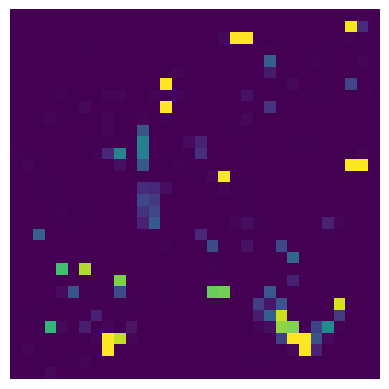

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reverse_engineer(param = {
    "dataset": "cifar10",
    "Epochs": 100,
    "batch_size": 64,
    "target_label": 4,
    "cost_lambda": 1e-3,
    "num_classes": 10,
    "image_size": (32, 32)}, model = torch.load('model_cifar10_0.15_4.pkl').to(device))

### Target Label = 5, Injection Rate = 0.15

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
param = {
    "dataset": "cifar10",
    "model": "default",
    "poisoning_method": "badnet",
    "injection_rate": 0.15,
    "target_label": 5,
    "Epochs": 150,
    "batch_size": 64
    }
fill_param(param)
train(param)

170498071/170498071 [==============================] - 19s 0us/step


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.40it/s]


Epoch: 1, Training Accuracy: 49.864, Testing Accuracy: 54.53, Testing ASR: 96.21


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.47it/s]


Epoch: 2, Training Accuracy: 65.324, Testing Accuracy: 60.98, Testing ASR: 95.53


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.36it/s]


Epoch: 3, Training Accuracy: 71.124, Testing Accuracy: 63.18, Testing ASR: 97.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.47it/s]


Epoch: 4, Training Accuracy: 73.95, Testing Accuracy: 72.25, Testing ASR: 97.14


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.40it/s]


Epoch: 5, Training Accuracy: 76.492, Testing Accuracy: 73.8, Testing ASR: 97.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.62it/s]


Epoch: 6, Training Accuracy: 78.268, Testing Accuracy: 69.89, Testing ASR: 98.5


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.89it/s]


Epoch: 7, Training Accuracy: 79.558, Testing Accuracy: 76.84, Testing ASR: 97.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.53it/s]


Epoch: 8, Training Accuracy: 80.878, Testing Accuracy: 77.65, Testing ASR: 97.5


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.17it/s]


Epoch: 9, Training Accuracy: 81.694, Testing Accuracy: 72.79, Testing ASR: 95.98


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.53it/s]


Epoch: 10, Training Accuracy: 82.73, Testing Accuracy: 79.06, Testing ASR: 97.0


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.97it/s]


Epoch: 11, Training Accuracy: 83.588, Testing Accuracy: 78.71, Testing ASR: 97.15


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.22it/s]


Epoch: 12, Training Accuracy: 84.236, Testing Accuracy: 79.84, Testing ASR: 97.18


Testing...: 100%|██████████| 157/157 [00:00<00:00, 576.38it/s]


Epoch: 13, Training Accuracy: 84.692, Testing Accuracy: 80.99, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.05it/s]


Epoch: 14, Training Accuracy: 85.564, Testing Accuracy: 81.0, Testing ASR: 97.4


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.66it/s]


Epoch: 15, Training Accuracy: 85.768, Testing Accuracy: 80.64, Testing ASR: 97.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.23it/s]


Epoch: 16, Training Accuracy: 86.71, Testing Accuracy: 78.85, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.31it/s]


Epoch: 17, Training Accuracy: 86.862, Testing Accuracy: 80.32, Testing ASR: 97.37


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.05it/s]


Epoch: 18, Training Accuracy: 87.148, Testing Accuracy: 80.92, Testing ASR: 97.34


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.99it/s]


Epoch: 19, Training Accuracy: 87.428, Testing Accuracy: 81.18, Testing ASR: 97.34


Testing...: 100%|██████████| 157/157 [00:00<00:00, 635.09it/s]


Epoch: 20, Training Accuracy: 87.872, Testing Accuracy: 81.27, Testing ASR: 97.51


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.80it/s]


Epoch: 21, Training Accuracy: 88.164, Testing Accuracy: 81.82, Testing ASR: 97.0


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.90it/s]


Epoch: 22, Training Accuracy: 88.894, Testing Accuracy: 81.53, Testing ASR: 97.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.08it/s]


Epoch: 23, Training Accuracy: 89.024, Testing Accuracy: 81.68, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.19it/s]


Epoch: 24, Training Accuracy: 89.218, Testing Accuracy: 81.38, Testing ASR: 97.4


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.33it/s]


Epoch: 25, Training Accuracy: 89.548, Testing Accuracy: 81.75, Testing ASR: 97.33


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.04it/s]


Epoch: 26, Training Accuracy: 89.726, Testing Accuracy: 81.68, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.36it/s]


Epoch: 27, Training Accuracy: 89.896, Testing Accuracy: 81.51, Testing ASR: 97.54


Testing...: 100%|██████████| 157/157 [00:00<00:00, 600.85it/s]


Epoch: 28, Training Accuracy: 90.262, Testing Accuracy: 81.98, Testing ASR: 97.51


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.93it/s]


Epoch: 29, Training Accuracy: 90.412, Testing Accuracy: 81.79, Testing ASR: 97.17


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.61it/s]


Epoch: 30, Training Accuracy: 90.432, Testing Accuracy: 81.9, Testing ASR: 97.51


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.50it/s]


Epoch: 31, Training Accuracy: 90.592, Testing Accuracy: 81.11, Testing ASR: 96.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 599.86it/s]


Epoch: 32, Training Accuracy: 91.026, Testing Accuracy: 81.46, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.54it/s]


Epoch: 33, Training Accuracy: 91.096, Testing Accuracy: 80.66, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.21it/s]


Epoch: 34, Training Accuracy: 91.196, Testing Accuracy: 82.26, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.69it/s]


Epoch: 35, Training Accuracy: 91.378, Testing Accuracy: 82.22, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.53it/s]


Epoch: 36, Training Accuracy: 91.36, Testing Accuracy: 82.32, Testing ASR: 97.38


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.09it/s]


Epoch: 37, Training Accuracy: 91.716, Testing Accuracy: 82.05, Testing ASR: 97.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.68it/s]


Epoch: 38, Training Accuracy: 91.852, Testing Accuracy: 81.81, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 634.02it/s]


Epoch: 39, Training Accuracy: 91.992, Testing Accuracy: 81.59, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.36it/s]


Epoch: 40, Training Accuracy: 92.126, Testing Accuracy: 82.1, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.10it/s]


Epoch: 41, Training Accuracy: 92.366, Testing Accuracy: 82.29, Testing ASR: 97.32


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.63it/s]


Epoch: 42, Training Accuracy: 92.29, Testing Accuracy: 82.29, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 635.81it/s]


Epoch: 43, Training Accuracy: 92.344, Testing Accuracy: 82.29, Testing ASR: 97.24


Testing...: 100%|██████████| 157/157 [00:00<00:00, 578.44it/s]


Epoch: 44, Training Accuracy: 92.62, Testing Accuracy: 82.75, Testing ASR: 97.46


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.85it/s]


Epoch: 45, Training Accuracy: 92.626, Testing Accuracy: 81.31, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.40it/s]


Epoch: 46, Training Accuracy: 92.766, Testing Accuracy: 82.35, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.74it/s]


Epoch: 47, Training Accuracy: 92.97, Testing Accuracy: 82.05, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.03it/s]


Epoch: 48, Training Accuracy: 93.064, Testing Accuracy: 82.08, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 597.63it/s]


Epoch: 49, Training Accuracy: 93.076, Testing Accuracy: 82.06, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 578.31it/s]


Epoch: 50, Training Accuracy: 92.922, Testing Accuracy: 81.66, Testing ASR: 97.31


Testing...: 100%|██████████| 157/157 [00:00<00:00, 586.38it/s]


Epoch: 51, Training Accuracy: 93.186, Testing Accuracy: 81.44, Testing ASR: 97.56


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.06it/s]


Epoch: 52, Training Accuracy: 93.24, Testing Accuracy: 82.51, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.53it/s]


Epoch: 53, Training Accuracy: 93.316, Testing Accuracy: 82.75, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 575.88it/s]


Epoch: 54, Training Accuracy: 93.464, Testing Accuracy: 81.19, Testing ASR: 98.39


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.66it/s]


Epoch: 55, Training Accuracy: 93.326, Testing Accuracy: 82.54, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.13it/s]


Epoch: 56, Training Accuracy: 93.632, Testing Accuracy: 82.75, Testing ASR: 97.56


Testing...: 100%|██████████| 157/157 [00:00<00:00, 583.20it/s]


Epoch: 57, Training Accuracy: 93.658, Testing Accuracy: 82.08, Testing ASR: 97.44


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.27it/s]


Epoch: 58, Training Accuracy: 93.638, Testing Accuracy: 82.54, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.59it/s]


Epoch: 59, Training Accuracy: 93.884, Testing Accuracy: 82.23, Testing ASR: 97.59


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.15it/s]


Epoch: 60, Training Accuracy: 93.866, Testing Accuracy: 82.24, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.66it/s]


Epoch: 61, Training Accuracy: 93.688, Testing Accuracy: 82.37, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 636.42it/s]


Epoch: 62, Training Accuracy: 93.82, Testing Accuracy: 80.73, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 577.62it/s]


Epoch: 63, Training Accuracy: 94.1, Testing Accuracy: 82.15, Testing ASR: 97.49


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.47it/s]


Epoch: 64, Training Accuracy: 93.966, Testing Accuracy: 82.06, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.51it/s]


Epoch: 65, Training Accuracy: 94.032, Testing Accuracy: 81.19, Testing ASR: 97.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.75it/s]


Epoch: 66, Training Accuracy: 94.166, Testing Accuracy: 82.25, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.70it/s]


Epoch: 67, Training Accuracy: 94.246, Testing Accuracy: 81.99, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.26it/s]


Epoch: 68, Training Accuracy: 94.416, Testing Accuracy: 82.11, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.24it/s]


Epoch: 69, Training Accuracy: 94.354, Testing Accuracy: 82.68, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.41it/s]


Epoch: 70, Training Accuracy: 94.432, Testing Accuracy: 82.52, Testing ASR: 97.55


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.11it/s]


Epoch: 71, Training Accuracy: 94.396, Testing Accuracy: 82.44, Testing ASR: 97.44


Testing...: 100%|██████████| 157/157 [00:00<00:00, 635.15it/s]


Epoch: 72, Training Accuracy: 94.386, Testing Accuracy: 81.83, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 596.26it/s]


Epoch: 73, Training Accuracy: 94.616, Testing Accuracy: 82.01, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.73it/s]


Epoch: 74, Training Accuracy: 94.53, Testing Accuracy: 82.34, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 558.01it/s]


Epoch: 75, Training Accuracy: 94.5, Testing Accuracy: 82.52, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.40it/s]


Epoch: 76, Training Accuracy: 94.646, Testing Accuracy: 81.87, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 598.60it/s]


Epoch: 77, Training Accuracy: 94.572, Testing Accuracy: 82.26, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.21it/s]


Epoch: 78, Training Accuracy: 94.722, Testing Accuracy: 82.55, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.97it/s]


Epoch: 79, Training Accuracy: 94.792, Testing Accuracy: 82.18, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 634.22it/s]


Epoch: 80, Training Accuracy: 94.712, Testing Accuracy: 82.77, Testing ASR: 97.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 598.62it/s]


Epoch: 81, Training Accuracy: 95.494, Testing Accuracy: 83.25, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.08it/s]


Epoch: 82, Training Accuracy: 95.806, Testing Accuracy: 83.16, Testing ASR: 97.93


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.37it/s]


Epoch: 83, Training Accuracy: 96.012, Testing Accuracy: 83.25, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 575.30it/s]


Epoch: 84, Training Accuracy: 96.204, Testing Accuracy: 82.94, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.23it/s]


Epoch: 85, Training Accuracy: 96.276, Testing Accuracy: 82.56, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.28it/s]


Epoch: 86, Training Accuracy: 96.444, Testing Accuracy: 83.18, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.53it/s]


Epoch: 87, Training Accuracy: 96.408, Testing Accuracy: 83.19, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.92it/s]


Epoch: 88, Training Accuracy: 96.39, Testing Accuracy: 83.09, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 634.65it/s]


Epoch: 89, Training Accuracy: 96.33, Testing Accuracy: 83.09, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.33it/s]


Epoch: 90, Training Accuracy: 96.416, Testing Accuracy: 83.15, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 571.31it/s]


Epoch: 91, Training Accuracy: 96.436, Testing Accuracy: 83.01, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.44it/s]


Epoch: 92, Training Accuracy: 96.448, Testing Accuracy: 83.05, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.52it/s]


Epoch: 93, Training Accuracy: 96.518, Testing Accuracy: 82.94, Testing ASR: 97.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.78it/s]


Epoch: 94, Training Accuracy: 96.568, Testing Accuracy: 83.38, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.70it/s]


Epoch: 95, Training Accuracy: 96.464, Testing Accuracy: 83.09, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.17it/s]


Epoch: 96, Training Accuracy: 96.376, Testing Accuracy: 83.12, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.74it/s]


Epoch: 97, Training Accuracy: 96.594, Testing Accuracy: 83.12, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.26it/s]


Epoch: 98, Training Accuracy: 96.632, Testing Accuracy: 83.11, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.99it/s]


Epoch: 99, Training Accuracy: 96.592, Testing Accuracy: 82.72, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.87it/s]


Epoch: 100, Training Accuracy: 96.69, Testing Accuracy: 83.01, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 573.24it/s]


Epoch: 101, Training Accuracy: 96.86, Testing Accuracy: 83.2, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.84it/s]


Epoch: 102, Training Accuracy: 97.004, Testing Accuracy: 83.35, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 581.20it/s]


Epoch: 103, Training Accuracy: 97.138, Testing Accuracy: 83.49, Testing ASR: 97.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.49it/s]


Epoch: 104, Training Accuracy: 97.236, Testing Accuracy: 83.35, Testing ASR: 97.93


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.08it/s]


Epoch: 105, Training Accuracy: 97.172, Testing Accuracy: 83.58, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.03it/s]


Epoch: 106, Training Accuracy: 97.308, Testing Accuracy: 83.46, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.27it/s]


Epoch: 107, Training Accuracy: 97.296, Testing Accuracy: 83.31, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 575.82it/s]


Epoch: 108, Training Accuracy: 97.38, Testing Accuracy: 83.27, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.46it/s]


Epoch: 109, Training Accuracy: 97.366, Testing Accuracy: 83.15, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 636.24it/s]


Epoch: 110, Training Accuracy: 97.372, Testing Accuracy: 83.26, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.89it/s]


Epoch: 111, Training Accuracy: 97.59, Testing Accuracy: 83.31, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 639.96it/s]


Epoch: 112, Training Accuracy: 97.496, Testing Accuracy: 83.24, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.84it/s]


Epoch: 113, Training Accuracy: 97.574, Testing Accuracy: 83.3, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.23it/s]


Epoch: 114, Training Accuracy: 97.502, Testing Accuracy: 83.25, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.18it/s]


Epoch: 115, Training Accuracy: 97.514, Testing Accuracy: 83.27, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.39it/s]


Epoch: 116, Training Accuracy: 97.46, Testing Accuracy: 83.46, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.35it/s]


Epoch: 117, Training Accuracy: 97.536, Testing Accuracy: 83.43, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 636.38it/s]


Epoch: 118, Training Accuracy: 97.652, Testing Accuracy: 83.43, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.95it/s]


Epoch: 119, Training Accuracy: 97.556, Testing Accuracy: 83.37, Testing ASR: 97.97


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.26it/s]


Epoch: 120, Training Accuracy: 97.574, Testing Accuracy: 83.36, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.55it/s]


Epoch: 121, Training Accuracy: 97.662, Testing Accuracy: 83.51, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.05it/s]


Epoch: 122, Training Accuracy: 97.654, Testing Accuracy: 83.49, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.18it/s]


Epoch: 123, Training Accuracy: 97.686, Testing Accuracy: 83.4, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.64it/s]


Epoch: 124, Training Accuracy: 97.656, Testing Accuracy: 83.58, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.99it/s]


Epoch: 125, Training Accuracy: 97.714, Testing Accuracy: 83.57, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.78it/s]


Epoch: 126, Training Accuracy: 97.644, Testing Accuracy: 83.48, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.55it/s]


Epoch: 127, Training Accuracy: 97.682, Testing Accuracy: 83.62, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.55it/s]


Epoch: 128, Training Accuracy: 97.736, Testing Accuracy: 83.4, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.17it/s]


Epoch: 129, Training Accuracy: 97.56, Testing Accuracy: 83.59, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.14it/s]


Epoch: 130, Training Accuracy: 97.808, Testing Accuracy: 83.33, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.88it/s]


Epoch: 131, Training Accuracy: 97.71, Testing Accuracy: 83.57, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 601.69it/s]


Epoch: 132, Training Accuracy: 97.728, Testing Accuracy: 83.45, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.06it/s]


Epoch: 133, Training Accuracy: 97.676, Testing Accuracy: 83.29, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.61it/s]


Epoch: 134, Training Accuracy: 97.774, Testing Accuracy: 83.36, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.06it/s]


Epoch: 135, Training Accuracy: 97.638, Testing Accuracy: 83.46, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.61it/s]


Epoch: 136, Training Accuracy: 97.836, Testing Accuracy: 83.43, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.95it/s]


Epoch: 137, Training Accuracy: 97.792, Testing Accuracy: 83.4, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.76it/s]


Epoch: 138, Training Accuracy: 97.832, Testing Accuracy: 83.49, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.66it/s]


Epoch: 139, Training Accuracy: 97.82, Testing Accuracy: 83.48, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.65it/s]


Epoch: 140, Training Accuracy: 97.784, Testing Accuracy: 83.51, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.19it/s]


Epoch: 141, Training Accuracy: 97.81, Testing Accuracy: 83.52, Testing ASR: 97.98


Testing...: 100%|██████████| 157/157 [00:00<00:00, 600.42it/s]


Epoch: 142, Training Accuracy: 97.832, Testing Accuracy: 83.38, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.23it/s]


Epoch: 143, Training Accuracy: 97.818, Testing Accuracy: 83.63, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 600.31it/s]


Epoch: 144, Training Accuracy: 97.796, Testing Accuracy: 83.46, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 590.48it/s]


Epoch: 145, Training Accuracy: 97.824, Testing Accuracy: 83.52, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 587.50it/s]


Epoch: 146, Training Accuracy: 97.72, Testing Accuracy: 83.39, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.23it/s]


Epoch: 147, Training Accuracy: 97.894, Testing Accuracy: 83.33, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.79it/s]


Epoch: 148, Training Accuracy: 97.892, Testing Accuracy: 83.4, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.27it/s]


Epoch: 149, Training Accuracy: 97.934, Testing Accuracy: 83.46, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.87it/s]


Epoch: 150, Training Accuracy: 97.82, Testing Accuracy: 83.65, Testing ASR: 97.83


Processing label: 0


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 214.13it/s]


norm: 474.879638671875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 208.86it/s]


norm: 432.91705322265625


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 245.12it/s]


norm: 382.63006591796875


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 216.92it/s]


norm: 328.708984375


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 232.39it/s]


norm: 278.7890625


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 241.64it/s]


norm: 235.72030639648438


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 218.36it/s]


norm: 199.64358520507812


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 245.46it/s]


norm: 169.297119140625


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 241.08it/s]


norm: 145.10916137695312


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 247.93it/s]


norm: 126.75447082519531


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 245.35it/s]


norm: 113.663818359375


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 229.25it/s]


norm: 104.59091186523438


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 223.46it/s]


norm: 97.0897216796875


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 211.96it/s]


norm: 90.35554504394531


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 210.55it/s]


norm: 85.25341796875


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 213.68it/s]


norm: 80.54891204833984


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 244.61it/s]


norm: 76.82952880859375


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 206.70it/s]


norm: 74.16010284423828


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 217.08it/s]


norm: 72.82902526855469


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 246.24it/s]


norm: 72.06816101074219


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 241.60it/s]


norm: 71.02597045898438


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 243.10it/s]


norm: 70.25659942626953


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 245.87it/s]


norm: 69.22819519042969


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 247.84it/s]


norm: 68.41693878173828


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 247.44it/s]


norm: 68.21137237548828


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 249.46it/s]


norm: 67.61326599121094


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 245.17it/s]


norm: 66.88975524902344


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 245.85it/s]


norm: 66.14178466796875


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 236.14it/s]


norm: 65.76879119873047


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 247.74it/s]


norm: 65.82997131347656


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 223.55it/s]


norm: 65.74668884277344


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 228.42it/s]


norm: 65.8067626953125


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 246.04it/s]


norm: 65.6108627319336


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 246.06it/s]


norm: 64.9154052734375


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 246.01it/s]


norm: 64.26313781738281


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 248.12it/s]


norm: 63.871700286865234


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 242.91it/s]


norm: 62.815101623535156


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 246.74it/s]


norm: 62.139976501464844


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 238.55it/s]


norm: 61.926025390625


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 239.53it/s]


norm: 62.258766174316406


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 242.08it/s]


norm: 61.718284606933594


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 231.96it/s]


norm: 61.72594451904297


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 229.13it/s]


norm: 61.82535171508789


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 239.40it/s]


norm: 61.64176559448242


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 236.09it/s]


norm: 61.84095764160156


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 239.24it/s]


norm: 61.73137664794922


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 247.23it/s]


norm: 61.30463790893555


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 247.62it/s]


norm: 61.17796325683594


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 243.46it/s]


norm: 60.82709884643555


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 250.36it/s]


norm: 60.12052536010742


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 250.08it/s]


norm: 59.222900390625


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 243.57it/s]


norm: 58.87933349609375


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 241.90it/s]


norm: 58.42863082885742


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 241.79it/s]


norm: 58.08005905151367


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 247.48it/s]


norm: 57.66248321533203


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 209.40it/s]


norm: 57.070640563964844


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 210.87it/s]


norm: 56.78978729248047


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 226.84it/s]


norm: 55.991981506347656


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 221.68it/s]


norm: 55.44263458251953


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 215.05it/s]


norm: 55.05913543701172


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 207.90it/s]


norm: 54.717185974121094


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 236.27it/s]


norm: 54.477210998535156


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 236.09it/s]


norm: 54.21138381958008


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 247.40it/s]


norm: 53.98271179199219


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 248.59it/s]


norm: 54.03721237182617


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 248.40it/s]


norm: 54.204811096191406


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 236.05it/s]


norm: 54.169517517089844


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 243.25it/s]


norm: 54.05265426635742


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 245.94it/s]


norm: 53.962310791015625


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 213.71it/s]


norm: 53.388465881347656


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 215.88it/s]


norm: 53.043025970458984


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 246.45it/s]


norm: 52.6981201171875


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 241.97it/s]


norm: 52.51953125


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 213.95it/s]


norm: 52.426361083984375


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 239.16it/s]


norm: 52.399452209472656


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 222.41it/s]


norm: 52.31745147705078


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 241.06it/s]


norm: 52.315128326416016


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 206.38it/s]


norm: 52.618385314941406


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 208.43it/s]


norm: 52.43780517578125


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 212.89it/s]


norm: 52.75188446044922


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 191.89it/s]


norm: 52.72714614868164


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 206.99it/s]


norm: 52.57605743408203


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 245.00it/s]


norm: 52.403839111328125


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 249.46it/s]


norm: 52.162353515625


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 232.36it/s]


norm: 52.195987701416016


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 227.63it/s]


norm: 52.227142333984375


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 241.20it/s]


norm: 52.09857940673828


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 245.17it/s]


norm: 52.01912307739258


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 247.77it/s]


norm: 51.977779388427734


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 247.96it/s]


norm: 52.018436431884766


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 251.35it/s]


norm: 51.95671844482422


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 238.66it/s]


norm: 52.018829345703125


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 227.50it/s]


norm: 51.86988830566406


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 219.89it/s]


norm: 52.043548583984375


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 243.22it/s]


norm: 51.96046447753906


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 247.22it/s]


norm: 52.126434326171875


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 246.35it/s]


norm: 51.75460433959961


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 247.02it/s]


norm: 52.26838684082031


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 247.91it/s]


norm: 51.58929443359375


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 252.81it/s]


norm: 51.900611877441406
Processing label: 1


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 250.26it/s]


norm: 492.51434326171875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 249.47it/s]


norm: 442.2090759277344


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 246.20it/s]


norm: 383.05572509765625


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 248.17it/s]


norm: 325.10943603515625


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 249.51it/s]


norm: 274.559326171875


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 250.16it/s]


norm: 229.14926147460938


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 247.22it/s]


norm: 190.20132446289062


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 239.32it/s]


norm: 160.59442138671875


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 215.54it/s]


norm: 136.96929931640625


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 244.45it/s]


norm: 119.53549194335938


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 245.81it/s]


norm: 106.75993347167969


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 249.92it/s]


norm: 95.12905883789062


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 246.15it/s]


norm: 86.34603118896484


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 250.23it/s]


norm: 80.15324401855469


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 250.27it/s]


norm: 75.61135864257812


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 250.80it/s]


norm: 71.63946533203125


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 253.33it/s]


norm: 68.78014373779297


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 251.95it/s]


norm: 66.30189514160156


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 241.96it/s]


norm: 64.35856628417969


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 253.95it/s]


norm: 62.8537712097168


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 245.41it/s]


norm: 61.50257110595703


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 237.78it/s]


norm: 60.415740966796875


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 233.10it/s]


norm: 59.631649017333984


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 244.20it/s]


norm: 58.79548263549805


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 224.72it/s]


norm: 57.9428596496582


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 242.91it/s]


norm: 57.398860931396484


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 244.33it/s]


norm: 57.16006851196289


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 249.40it/s]


norm: 56.880184173583984


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 252.66it/s]


norm: 56.336856842041016


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 246.46it/s]


norm: 55.91297149658203


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 248.58it/s]


norm: 55.489463806152344


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 246.98it/s]


norm: 55.154109954833984


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 245.44it/s]


norm: 54.63478088378906


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 251.61it/s]


norm: 53.95654296875


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 249.39it/s]


norm: 53.8417854309082


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 240.38it/s]


norm: 53.92107391357422


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 226.04it/s]


norm: 53.71620559692383


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 253.48it/s]


norm: 54.01715087890625


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 252.68it/s]


norm: 53.87717819213867


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 248.71it/s]


norm: 53.64320755004883


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 221.59it/s]


norm: 53.58169937133789


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 241.38it/s]


norm: 53.34360122680664


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 238.77it/s]


norm: 53.122901916503906


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 249.18it/s]


norm: 53.05445861816406


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 251.57it/s]


norm: 52.760520935058594


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 252.58it/s]


norm: 52.48167419433594


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 250.11it/s]


norm: 52.22135925292969


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 252.02it/s]


norm: 51.95966720581055


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 247.11it/s]


norm: 51.6246452331543


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 251.23it/s]


norm: 51.32994842529297


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 246.83it/s]


norm: 51.177303314208984


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 243.84it/s]


norm: 51.102848052978516


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 256.74it/s]


norm: 50.983055114746094


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 252.23it/s]


norm: 50.72039031982422


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 246.48it/s]


norm: 50.73163604736328


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 247.16it/s]


norm: 50.53194808959961


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 250.25it/s]


norm: 50.22431945800781


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 206.44it/s]


norm: 49.66102600097656


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 221.94it/s]


norm: 49.5106201171875


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 243.01it/s]


norm: 49.12627410888672


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 245.76it/s]


norm: 48.993133544921875


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 251.32it/s]


norm: 48.8306770324707


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 250.75it/s]


norm: 48.51546096801758


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 249.51it/s]


norm: 48.32032775878906


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 249.31it/s]


norm: 47.91378402709961


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 249.60it/s]


norm: 47.69755554199219


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 247.51it/s]


norm: 47.82075881958008


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 242.83it/s]


norm: 47.507545471191406


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 248.73it/s]


norm: 47.47660827636719


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 251.28it/s]


norm: 47.47685241699219


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 230.62it/s]


norm: 47.369537353515625


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 232.21it/s]


norm: 47.64671325683594


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 224.88it/s]


norm: 47.76264953613281


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 217.51it/s]


norm: 47.72227096557617


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 241.58it/s]


norm: 47.635528564453125


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 246.79it/s]


norm: 47.264076232910156


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 243.54it/s]


norm: 47.531517028808594


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 251.20it/s]


norm: 47.07468795776367


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 252.80it/s]


norm: 46.74554443359375


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 250.96it/s]


norm: 46.439453125


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 248.82it/s]


norm: 46.32283401489258


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 248.17it/s]


norm: 46.17375183105469


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 245.58it/s]


norm: 46.325347900390625


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 251.06it/s]


norm: 46.11505889892578


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 245.77it/s]


norm: 46.512351989746094


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 246.83it/s]


norm: 46.69094467163086


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 235.20it/s]


norm: 46.786407470703125


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 241.45it/s]


norm: 47.05054473876953


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 249.87it/s]


norm: 46.65483856201172


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 251.13it/s]


norm: 46.464324951171875


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 247.76it/s]


norm: 46.50935363769531


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 248.86it/s]


norm: 46.55207824707031


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 249.43it/s]


norm: 46.04512405395508


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 250.51it/s]


norm: 45.51323699951172


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 249.62it/s]


norm: 45.1966552734375


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 248.94it/s]


norm: 45.15824508666992


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 247.57it/s]


norm: 45.34199523925781


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 252.35it/s]


norm: 45.46969223022461


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 248.55it/s]


norm: 45.11772537231445


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 245.62it/s]


norm: 45.150177001953125
Processing label: 2


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 249.10it/s]


norm: 482.06146240234375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 244.56it/s]


norm: 420.3297119140625


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 250.27it/s]


norm: 354.766845703125


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 245.87it/s]


norm: 293.0391540527344


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 250.09it/s]


norm: 241.0811309814453


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 252.68it/s]


norm: 202.38809204101562


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 246.85it/s]


norm: 171.6057586669922


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 240.83it/s]


norm: 147.13043212890625


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 247.09it/s]


norm: 128.72923278808594


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 246.41it/s]


norm: 113.71516418457031


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 254.77it/s]


norm: 102.8167724609375


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 239.19it/s]


norm: 94.17620849609375


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 250.61it/s]


norm: 87.5650863647461


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 247.42it/s]


norm: 81.59861755371094


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 206.52it/s]


norm: 77.48811340332031


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 213.42it/s]


norm: 74.998291015625


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 228.23it/s]


norm: 70.63087463378906


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 252.94it/s]


norm: 67.29049682617188


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 252.72it/s]


norm: 64.91231536865234


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 251.47it/s]


norm: 62.436344146728516


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 254.10it/s]


norm: 60.684574127197266


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 251.30it/s]


norm: 59.342384338378906


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 240.76it/s]


norm: 58.57119369506836


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 216.84it/s]


norm: 57.98749542236328


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 216.12it/s]


norm: 57.00909423828125


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 240.69it/s]


norm: 57.60178756713867


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 245.98it/s]


norm: 57.28329849243164


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 232.47it/s]


norm: 56.745689392089844


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 217.35it/s]


norm: 56.582794189453125


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 227.16it/s]


norm: 55.052589416503906


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 221.16it/s]


norm: 54.99745559692383


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 250.78it/s]


norm: 53.21144485473633


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 240.04it/s]


norm: 53.65032196044922


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 211.45it/s]


norm: 52.785160064697266


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 232.06it/s]


norm: 51.36174011230469


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 220.36it/s]


norm: 50.806358337402344


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 253.47it/s]


norm: 50.51374053955078


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 247.51it/s]


norm: 50.6628303527832


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 250.33it/s]


norm: 50.22674560546875


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 250.56it/s]


norm: 50.17439651489258


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 242.89it/s]


norm: 49.702720642089844


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 250.83it/s]


norm: 49.552635192871094


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 246.03it/s]


norm: 49.35248947143555


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 248.61it/s]


norm: 49.02265167236328


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 252.41it/s]


norm: 48.836368560791016


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 243.47it/s]


norm: 48.70128631591797


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 215.35it/s]


norm: 48.68201446533203


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 250.09it/s]


norm: 48.899288177490234


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 248.45it/s]


norm: 48.53240966796875


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 249.92it/s]


norm: 48.60601043701172


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 249.45it/s]


norm: 48.74116516113281


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 251.77it/s]


norm: 48.59529495239258


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 249.27it/s]


norm: 48.79641342163086


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 247.72it/s]


norm: 48.88893127441406


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 252.16it/s]


norm: 48.668304443359375


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 243.96it/s]


norm: 49.835533142089844


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 246.77it/s]


norm: 49.29290008544922


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 248.87it/s]


norm: 49.33498764038086


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 254.39it/s]


norm: 49.24793243408203


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 243.49it/s]


norm: 49.21302795410156


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 247.35it/s]


norm: 48.352256774902344


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 238.57it/s]


norm: 48.16375732421875


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 244.25it/s]


norm: 47.635284423828125


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 250.14it/s]


norm: 47.613040924072266


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 249.34it/s]


norm: 47.582275390625


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 246.15it/s]


norm: 47.76545715332031


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 215.96it/s]


norm: 48.177879333496094


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 220.34it/s]


norm: 47.927772521972656


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 244.56it/s]


norm: 48.07536315917969


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 215.44it/s]


norm: 47.74836730957031


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 211.82it/s]


norm: 47.74242401123047


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 230.15it/s]


norm: 47.74562454223633


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 244.61it/s]


norm: 48.437232971191406


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 248.57it/s]


norm: 48.173095703125


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 246.86it/s]


norm: 47.33305358886719


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 251.05it/s]


norm: 48.006439208984375


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 244.71it/s]


norm: 47.06254577636719


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 243.60it/s]


norm: 47.11747741699219


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 238.02it/s]


norm: 47.32984924316406


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 235.71it/s]


norm: 47.374488830566406


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 244.33it/s]


norm: 47.54296112060547


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 252.49it/s]


norm: 47.27267074584961


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 253.22it/s]


norm: 47.10186767578125


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 248.31it/s]


norm: 46.988739013671875


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 243.76it/s]


norm: 47.122745513916016


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 248.42it/s]


norm: 47.07190704345703


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 246.11it/s]


norm: 46.60213851928711


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 238.94it/s]


norm: 46.551700592041016


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 251.67it/s]


norm: 46.4428596496582


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 250.35it/s]


norm: 46.40224838256836


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 247.64it/s]


norm: 46.53489685058594


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 245.72it/s]


norm: 46.27096939086914


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 247.72it/s]


norm: 46.44647979736328


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 246.96it/s]


norm: 45.805503845214844


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 251.92it/s]


norm: 46.315975189208984


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 247.70it/s]


norm: 45.681739807128906


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 247.09it/s]


norm: 45.87945556640625


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 252.44it/s]


norm: 45.4787712097168


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 252.01it/s]


norm: 45.71039581298828


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 249.58it/s]


norm: 45.47270965576172
Processing label: 3


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 223.00it/s]


norm: 469.7557067871094


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 213.00it/s]


norm: 404.4673767089844


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 240.10it/s]


norm: 335.16741943359375


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 249.23it/s]


norm: 273.493408203125


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 250.57it/s]


norm: 224.56716918945312


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 246.45it/s]


norm: 186.37094116210938


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 247.41it/s]


norm: 153.39305114746094


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 247.72it/s]


norm: 130.27101135253906


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 245.99it/s]


norm: 112.88992309570312


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 251.24it/s]


norm: 99.54839324951172


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 249.58it/s]


norm: 90.78227996826172


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 242.96it/s]


norm: 84.21576690673828


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 248.20it/s]


norm: 79.77767944335938


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 254.28it/s]


norm: 75.80309295654297


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 248.27it/s]


norm: 72.3792724609375


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 242.61it/s]


norm: 69.76611328125


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 207.58it/s]


norm: 67.64533996582031


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 239.25it/s]


norm: 65.74024200439453


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 250.39it/s]


norm: 64.12393188476562


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 252.72it/s]


norm: 62.53728485107422


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 250.93it/s]


norm: 61.68129348754883


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 249.44it/s]


norm: 60.80281448364258


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 249.90it/s]


norm: 60.012603759765625


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 245.35it/s]


norm: 59.51081085205078


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 252.04it/s]


norm: 59.42664337158203


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 248.31it/s]


norm: 58.49510192871094


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 249.00it/s]


norm: 57.41258239746094


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 252.97it/s]


norm: 57.337257385253906


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 251.50it/s]


norm: 57.0633659362793


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 250.94it/s]


norm: 56.12653350830078


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 244.92it/s]


norm: 55.82054901123047


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 249.71it/s]


norm: 55.52909851074219


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 248.73it/s]


norm: 55.16576385498047


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 226.90it/s]


norm: 54.65763854980469


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 214.42it/s]


norm: 54.854331970214844


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 242.78it/s]


norm: 54.75210189819336


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 243.35it/s]


norm: 54.603721618652344


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 248.01it/s]


norm: 54.26579284667969


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 249.92it/s]


norm: 54.27827835083008


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 251.90it/s]


norm: 53.96962356567383


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 254.08it/s]


norm: 53.987327575683594


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 245.71it/s]


norm: 53.56083679199219


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 246.43it/s]


norm: 53.362422943115234


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 252.98it/s]


norm: 52.63347244262695


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 251.71it/s]


norm: 52.147132873535156


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 249.11it/s]


norm: 52.243202209472656


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 219.12it/s]


norm: 51.787776947021484


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 239.76it/s]


norm: 51.41404724121094


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 243.44it/s]


norm: 51.36833190917969


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 247.57it/s]


norm: 51.46467590332031


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 249.27it/s]


norm: 51.62928009033203


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 247.67it/s]


norm: 51.377403259277344


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 247.71it/s]


norm: 51.04594802856445


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 245.71it/s]


norm: 51.00465393066406


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 243.38it/s]


norm: 51.05712127685547


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 251.49it/s]


norm: 50.796791076660156


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 248.88it/s]


norm: 50.720909118652344


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 222.03it/s]


norm: 50.89252853393555


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 211.14it/s]


norm: 50.642826080322266


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 241.45it/s]


norm: 51.098045349121094


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 212.05it/s]


norm: 51.60291290283203


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 223.36it/s]


norm: 51.42224884033203


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 235.14it/s]


norm: 51.58156204223633


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 216.81it/s]


norm: 51.5103759765625


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 242.80it/s]


norm: 51.399574279785156


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 249.17it/s]


norm: 51.291603088378906


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 252.24it/s]


norm: 51.369049072265625


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 249.48it/s]


norm: 51.402191162109375


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 248.51it/s]


norm: 51.25065612792969


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 247.71it/s]


norm: 51.06098937988281


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 248.44it/s]


norm: 51.25396728515625


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 247.29it/s]


norm: 51.1599235534668


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 248.61it/s]


norm: 51.26315689086914


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 245.35it/s]


norm: 51.191925048828125


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 216.59it/s]


norm: 51.226444244384766


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 250.54it/s]


norm: 51.17516326904297


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 249.74it/s]


norm: 50.900123596191406


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 244.38it/s]


norm: 51.52992248535156


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 240.75it/s]


norm: 51.25752258300781


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 246.94it/s]


norm: 51.03544998168945


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 245.32it/s]


norm: 51.54042053222656


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 250.40it/s]


norm: 51.00980758666992


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 248.48it/s]


norm: 51.42479705810547


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 248.63it/s]


norm: 51.557518005371094


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 253.16it/s]


norm: 51.08150863647461


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 250.56it/s]


norm: 51.328102111816406


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 244.00it/s]


norm: 51.64341354370117


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 249.98it/s]


norm: 50.789894104003906


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 244.86it/s]


norm: 51.43907165527344


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 247.40it/s]


norm: 51.209354400634766
Processing label: 4


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 248.11it/s]


norm: 470.2403564453125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 252.05it/s]


norm: 409.25482177734375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 249.09it/s]


norm: 341.55975341796875


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 244.79it/s]


norm: 277.9757385253906


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 240.24it/s]


norm: 223.9215087890625


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 249.54it/s]


norm: 180.27232360839844


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 251.16it/s]


norm: 148.08348083496094


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 250.07it/s]


norm: 125.36312866210938


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 244.63it/s]


norm: 109.8131103515625


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 246.14it/s]


norm: 99.44049072265625


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 245.79it/s]


norm: 91.60830688476562


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 244.44it/s]


norm: 85.06094360351562


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 225.56it/s]


norm: 79.75608825683594


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 216.99it/s]


norm: 74.63732147216797


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 243.01it/s]


norm: 70.77410888671875


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 247.32it/s]


norm: 67.58241271972656


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 250.95it/s]


norm: 65.64582824707031


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 245.79it/s]


norm: 63.92790603637695


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 239.64it/s]


norm: 62.60121154785156


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 239.97it/s]


norm: 61.66741943359375


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 251.16it/s]


norm: 60.370574951171875


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 248.64it/s]


norm: 59.18352508544922


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 247.54it/s]


norm: 58.17875671386719


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 245.54it/s]


norm: 56.49156951904297


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 247.51it/s]


norm: 55.844764709472656


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 249.26it/s]


norm: 54.94473648071289


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 250.09it/s]


norm: 54.50303649902344


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 247.04it/s]


norm: 53.81801986694336


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 247.03it/s]


norm: 53.632843017578125


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 249.98it/s]


norm: 53.20942687988281


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 250.33it/s]


norm: 53.10193634033203


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 250.53it/s]


norm: 53.34375


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 243.15it/s]


norm: 52.87847900390625


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 251.47it/s]


norm: 52.25889205932617


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 214.80it/s]


norm: 51.537322998046875


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 242.79it/s]


norm: 51.23634338378906


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 252.89it/s]


norm: 50.86076354980469


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 248.00it/s]


norm: 50.726478576660156


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 245.95it/s]


norm: 50.504478454589844


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 246.36it/s]


norm: 50.396331787109375


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 239.05it/s]


norm: 50.41127014160156


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 213.28it/s]


norm: 50.26426696777344


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 215.11it/s]


norm: 50.1405143737793


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 236.11it/s]


norm: 49.845584869384766


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 254.27it/s]


norm: 49.68608093261719


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 251.67it/s]


norm: 49.73405075073242


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 249.95it/s]


norm: 49.71529769897461


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 249.37it/s]


norm: 49.65632247924805


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 249.19it/s]


norm: 49.76295852661133


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 240.94it/s]


norm: 49.967777252197266


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 242.82it/s]


norm: 49.84346008300781


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 250.92it/s]


norm: 49.91686248779297


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 253.60it/s]


norm: 49.66133117675781


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 240.86it/s]


norm: 49.73078918457031


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 247.04it/s]


norm: 49.67462921142578


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 252.88it/s]


norm: 49.627471923828125


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 245.96it/s]


norm: 49.608680725097656


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 253.69it/s]


norm: 49.85405731201172


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 246.19it/s]


norm: 49.770164489746094


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 244.89it/s]


norm: 49.902164459228516


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 247.31it/s]


norm: 49.85890197753906


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 246.06it/s]


norm: 50.25006103515625


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 237.05it/s]


norm: 49.657039642333984


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 232.13it/s]


norm: 49.73395919799805


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 250.55it/s]


norm: 49.56679153442383


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 245.90it/s]


norm: 49.54377746582031


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 238.02it/s]


norm: 49.52780532836914


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 249.47it/s]


norm: 49.39402770996094


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 251.01it/s]


norm: 49.59266662597656


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 247.54it/s]


norm: 49.34341812133789


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 250.59it/s]


norm: 49.52644348144531


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 246.25it/s]


norm: 49.4347038269043


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 251.61it/s]


norm: 49.72861099243164


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 250.75it/s]


norm: 49.386619567871094


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 244.33it/s]


norm: 49.30258560180664


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 248.94it/s]


norm: 49.45289611816406


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 252.62it/s]


norm: 49.15507507324219


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 248.11it/s]


norm: 49.61103820800781


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 250.36it/s]


norm: 50.365142822265625


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 251.83it/s]


norm: 49.53272247314453


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 249.62it/s]


norm: 50.13090515136719


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 248.13it/s]


norm: 49.313316345214844


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 240.74it/s]


norm: 49.16754913330078


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 246.26it/s]


norm: 48.928409576416016


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 248.69it/s]


norm: 49.179931640625


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 244.88it/s]


norm: 49.34385681152344


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 249.61it/s]


norm: 48.57496643066406


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 247.40it/s]


norm: 48.742794036865234


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 250.67it/s]


norm: 48.74015808105469


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 250.01it/s]


norm: 48.60395812988281


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 242.83it/s]


norm: 48.96489334106445


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 247.70it/s]


norm: 49.50647735595703


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 244.42it/s]


norm: 48.38007736206055


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 247.88it/s]


norm: 48.13489532470703


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 252.62it/s]


norm: 48.93657684326172


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 249.68it/s]


norm: 48.368106842041016


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 250.19it/s]


norm: 49.63945007324219


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 246.40it/s]


norm: 48.36571502685547


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 246.29it/s]


norm: 49.27495574951172


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 251.29it/s]


norm: 48.48444366455078
Processing label: 5


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 246.99it/s]


norm: 478.7464599609375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 247.96it/s]


norm: 433.5252685546875


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 251.04it/s]


norm: 379.86474609375


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 251.50it/s]


norm: 325.5250244140625


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 242.09it/s]


norm: 275.3779296875


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 245.58it/s]


norm: 232.81204223632812


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 249.12it/s]


norm: 197.13995361328125


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 246.61it/s]


norm: 167.93045043945312


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 250.80it/s]


norm: 143.28033447265625


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 247.52it/s]


norm: 121.59632873535156


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 249.15it/s]


norm: 106.27436828613281


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 206.29it/s]


norm: 94.4476089477539


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 222.64it/s]


norm: 84.48208618164062


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 246.53it/s]


norm: 76.7718734741211


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 249.30it/s]


norm: 66.03817749023438


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 247.02it/s]


norm: 59.53022766113281


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 249.18it/s]


norm: 54.34666442871094


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 248.67it/s]


norm: 50.47385025024414


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 253.75it/s]


norm: 46.214988708496094


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 251.06it/s]


norm: 43.38356018066406


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 249.51it/s]


norm: 38.80467987060547


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 246.05it/s]


norm: 35.38066101074219


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 249.78it/s]


norm: 32.851505279541016


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 246.26it/s]


norm: 27.739730834960938


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 248.08it/s]


norm: 24.698694229125977


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 245.30it/s]


norm: 22.44273567199707


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 245.70it/s]


norm: 19.163970947265625


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 249.21it/s]


norm: 20.303577423095703


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 241.27it/s]


norm: 16.851055145263672


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 245.77it/s]


norm: 15.956350326538086


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 251.21it/s]


norm: 14.558389663696289


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 247.77it/s]


norm: 12.531400680541992


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 245.66it/s]


norm: 12.694469451904297


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 254.34it/s]


norm: 11.161859512329102


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 251.26it/s]


norm: 9.8230562210083


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 248.31it/s]


norm: 10.313215255737305


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 244.61it/s]


norm: 9.930929183959961


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 249.27it/s]


norm: 9.427029609680176


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 249.01it/s]


norm: 11.343002319335938


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 249.32it/s]


norm: 10.257966995239258


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 249.59it/s]


norm: 9.275218963623047


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 246.10it/s]


norm: 9.395280838012695


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 247.53it/s]


norm: 9.386929512023926


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 246.34it/s]


norm: 9.478500366210938


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 250.76it/s]


norm: 9.94430160522461


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 246.85it/s]


norm: 10.318608283996582


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 247.86it/s]


norm: 9.008003234863281


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 249.99it/s]


norm: 9.090356826782227


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 247.97it/s]


norm: 9.05101203918457


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 252.69it/s]


norm: 8.999393463134766


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 253.83it/s]


norm: 10.304943084716797


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 243.12it/s]


norm: 9.954648971557617


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 251.09it/s]


norm: 9.341623306274414


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 249.80it/s]


norm: 9.011823654174805


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 250.64it/s]


norm: 10.963430404663086


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 252.58it/s]


norm: 9.083984375


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 243.77it/s]


norm: 9.299468994140625


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 254.34it/s]


norm: 8.823667526245117


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 249.10it/s]


norm: 9.500009536743164


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 251.83it/s]


norm: 8.87868595123291


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 247.90it/s]


norm: 9.026742935180664


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 248.24it/s]


norm: 10.447887420654297


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 251.39it/s]


norm: 9.632935523986816


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 249.08it/s]


norm: 9.540179252624512


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 246.86it/s]


norm: 9.08298110961914


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 252.09it/s]


norm: 9.556265830993652


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 254.25it/s]


norm: 11.148294448852539


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 246.50it/s]


norm: 9.348841667175293


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 251.75it/s]


norm: 8.922648429870605


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 249.72it/s]


norm: 9.1719970703125


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 251.38it/s]


norm: 8.58913516998291


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 253.79it/s]


norm: 8.549335479736328


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 252.01it/s]


norm: 9.592763900756836


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 250.71it/s]


norm: 10.14322280883789


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 253.49it/s]


norm: 9.044092178344727


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 255.42it/s]


norm: 8.877849578857422


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 252.22it/s]


norm: 8.885419845581055


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 245.64it/s]


norm: 10.046142578125


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 250.19it/s]


norm: 11.107282638549805


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 255.80it/s]


norm: 9.802708625793457


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 246.76it/s]


norm: 9.95315170288086


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


norm: 9.068841934204102


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 250.52it/s]


norm: 9.286566734313965


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 241.62it/s]


norm: 9.552932739257812


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 251.69it/s]


norm: 9.100397109985352


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 245.73it/s]


norm: 10.140833854675293


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 246.47it/s]


norm: 9.599538803100586


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 253.51it/s]


norm: 9.224571228027344


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 240.20it/s]


norm: 8.670623779296875


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 249.57it/s]


norm: 10.698899269104004


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 238.84it/s]


norm: 10.117588996887207


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 252.09it/s]


norm: 8.958722114562988


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 251.29it/s]


norm: 8.411450386047363


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 248.64it/s]


norm: 10.241168975830078


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 246.74it/s]


norm: 9.33068561553955


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 246.90it/s]


norm: 8.916736602783203


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 251.06it/s]


norm: 11.006063461303711


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 250.87it/s]


norm: 9.852228164672852


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 258.35it/s]


norm: 9.314445495605469


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 244.67it/s]


norm: 10.757490158081055
Processing label: 6


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 248.73it/s]


norm: 272.4117431640625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 240.21it/s]


norm: 151.25521850585938


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 252.43it/s]


norm: 108.50420379638672


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 245.61it/s]


norm: 90.52497863769531


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 245.06it/s]


norm: 77.17765045166016


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 244.60it/s]


norm: 70.63842010498047


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 248.74it/s]


norm: 66.02982330322266


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 250.83it/s]


norm: 64.11624908447266


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 248.16it/s]


norm: 63.145137786865234


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 248.35it/s]


norm: 60.12495422363281


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 251.48it/s]


norm: 59.70719909667969


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 250.91it/s]


norm: 58.13086700439453


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 251.64it/s]


norm: 57.638755798339844


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 250.69it/s]


norm: 57.412261962890625


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 248.25it/s]


norm: 55.5947265625


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 249.25it/s]


norm: 55.80029296875


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 248.93it/s]


norm: 55.88233947753906


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 252.65it/s]


norm: 55.568538665771484


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 252.13it/s]


norm: 55.849273681640625


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 247.76it/s]


norm: 54.83721923828125


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 241.90it/s]


norm: 54.84593963623047


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 247.91it/s]


norm: 54.595436096191406


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 246.85it/s]


norm: 54.38041687011719


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 248.87it/s]


norm: 54.259521484375


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 248.27it/s]


norm: 53.470794677734375


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 248.56it/s]


norm: 54.02808380126953


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 253.44it/s]


norm: 53.666847229003906


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 248.43it/s]


norm: 53.38524627685547


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 251.50it/s]


norm: 53.741966247558594


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 250.85it/s]


norm: 53.245304107666016


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 243.71it/s]


norm: 53.097808837890625


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 250.05it/s]


norm: 53.08537292480469


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 252.26it/s]


norm: 52.827735900878906


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 245.44it/s]


norm: 52.874671936035156


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 249.88it/s]


norm: 53.05630874633789


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 252.04it/s]


norm: 52.76580810546875


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 238.62it/s]


norm: 53.23252487182617


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 245.33it/s]


norm: 52.41993713378906


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 248.58it/s]


norm: 52.99882888793945


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 251.98it/s]


norm: 53.4693603515625


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 241.99it/s]


norm: 52.80156707763672


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 205.13it/s]


norm: 52.87712097167969


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 234.28it/s]


norm: 53.34945297241211


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 255.84it/s]


norm: 52.639251708984375


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 250.22it/s]


norm: 51.79865264892578


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 245.65it/s]


norm: 52.32606506347656


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 248.80it/s]


norm: 51.79978942871094


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 243.51it/s]


norm: 51.839393615722656


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 250.62it/s]


norm: 51.08860778808594


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 247.58it/s]


norm: 50.72938919067383


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 252.20it/s]


norm: 51.19636917114258


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 246.56it/s]


norm: 50.91686248779297


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 245.06it/s]


norm: 51.1265869140625


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 250.58it/s]


norm: 50.909095764160156


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 249.55it/s]


norm: 51.967918395996094


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 250.30it/s]


norm: 52.103050231933594


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 249.51it/s]


norm: 52.668495178222656


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 245.14it/s]


norm: 52.332489013671875


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 243.44it/s]


norm: 51.5182991027832


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 250.55it/s]


norm: 52.668941497802734


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 250.17it/s]


norm: 50.931640625


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 248.50it/s]


norm: 51.38572692871094


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 250.20it/s]


norm: 51.534393310546875


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 252.27it/s]


norm: 51.91600799560547


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 248.27it/s]


norm: 51.20102310180664


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 249.92it/s]


norm: 52.118629455566406


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 249.75it/s]


norm: 51.38331985473633


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 247.29it/s]


norm: 51.05537033081055


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 247.11it/s]


norm: 50.88246536254883


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 251.19it/s]


norm: 51.62152099609375


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 247.11it/s]


norm: 50.431556701660156


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 251.38it/s]


norm: 50.98033142089844


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 250.30it/s]


norm: 50.49319839477539


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 246.39it/s]


norm: 50.105281829833984


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 251.46it/s]


norm: 50.89287185668945


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 231.82it/s]


norm: 51.051788330078125


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 230.15it/s]


norm: 51.81548309326172


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 237.09it/s]


norm: 51.035400390625


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 248.09it/s]


norm: 53.772552490234375


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 252.16it/s]


norm: 51.703338623046875


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 249.93it/s]


norm: 52.43183517456055


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 251.96it/s]


norm: 50.47053146362305


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 251.62it/s]


norm: 50.35466003417969


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 252.49it/s]


norm: 50.87858963012695


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 246.95it/s]


norm: 50.55494689941406


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 251.79it/s]


norm: 51.020957946777344


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 224.69it/s]


norm: 49.78068542480469


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 248.97it/s]


norm: 50.637413024902344


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 250.83it/s]


norm: 49.9153938293457


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 248.45it/s]


norm: 50.0224494934082


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 250.82it/s]


norm: 50.06971740722656


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 252.49it/s]


norm: 50.595603942871094


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 247.27it/s]


norm: 49.372215270996094


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 247.54it/s]


norm: 49.968101501464844


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 252.45it/s]


norm: 50.65394592285156


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 249.18it/s]


norm: 50.72333526611328


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 250.13it/s]


norm: 49.91026306152344


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 242.07it/s]


norm: 50.41651153564453


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 236.09it/s]


norm: 49.35353088378906


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 247.03it/s]


norm: 51.38809585571289
Processing label: 7


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 249.35it/s]


norm: 487.3236083984375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 252.13it/s]


norm: 447.13323974609375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 252.78it/s]


norm: 399.3924255371094


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 244.97it/s]


norm: 349.5216064453125


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 246.34it/s]


norm: 300.9366760253906


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 254.00it/s]


norm: 256.69696044921875


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 244.58it/s]


norm: 217.86724853515625


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 248.77it/s]


norm: 184.72686767578125


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 249.12it/s]


norm: 159.7900848388672


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 254.06it/s]


norm: 139.59384155273438


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 245.40it/s]


norm: 123.01951599121094


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 248.59it/s]


norm: 108.6082534790039


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 246.88it/s]


norm: 97.65449523925781


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 241.78it/s]


norm: 88.38322448730469


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 242.43it/s]


norm: 82.03591918945312


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 248.62it/s]


norm: 75.07955932617188


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 246.02it/s]


norm: 71.01681518554688


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 253.62it/s]


norm: 66.61186218261719


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 251.09it/s]


norm: 62.960453033447266


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 243.91it/s]


norm: 60.80371856689453


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 248.50it/s]


norm: 59.46855926513672


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 253.46it/s]


norm: 58.22172546386719


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 251.23it/s]


norm: 56.81982421875


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 248.53it/s]


norm: 55.429115295410156


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 248.65it/s]


norm: 54.86664581298828


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 246.96it/s]


norm: 54.218780517578125


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 244.31it/s]


norm: 53.40047073364258


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 246.10it/s]


norm: 53.31771469116211


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 246.95it/s]


norm: 53.53164291381836


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 252.54it/s]


norm: 53.65690231323242


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 241.94it/s]


norm: 53.40020751953125


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 252.09it/s]


norm: 53.41679000854492


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 249.59it/s]


norm: 53.06925964355469


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 251.58it/s]


norm: 53.3581428527832


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 249.40it/s]


norm: 53.20085144042969


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 244.96it/s]


norm: 53.07537078857422


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 249.44it/s]


norm: 53.12598419189453


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 254.23it/s]


norm: 52.75226593017578


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 245.60it/s]


norm: 52.41389083862305


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 250.39it/s]


norm: 52.15869903564453


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 248.35it/s]


norm: 51.67808151245117


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 247.35it/s]


norm: 50.627403259277344


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 249.10it/s]


norm: 50.165618896484375


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 247.11it/s]


norm: 49.57366180419922


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 247.29it/s]


norm: 48.5394287109375


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 249.39it/s]


norm: 48.24771499633789


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 248.27it/s]


norm: 49.173973083496094


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 254.23it/s]


norm: 46.37435531616211


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 248.80it/s]


norm: 44.75074005126953


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 248.29it/s]


norm: 44.21878433227539


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 249.46it/s]


norm: 43.823123931884766


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 244.75it/s]


norm: 43.237945556640625


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 246.28it/s]


norm: 43.245792388916016


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 252.72it/s]


norm: 42.123321533203125


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 248.59it/s]


norm: 42.00715637207031


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 249.67it/s]


norm: 42.162384033203125


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 251.84it/s]


norm: 41.93888854980469


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 252.40it/s]


norm: 42.040794372558594


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 251.56it/s]


norm: 42.00111389160156


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 248.41it/s]


norm: 41.73656463623047


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 244.27it/s]


norm: 41.6557502746582


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 245.57it/s]


norm: 41.93817138671875


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 253.63it/s]


norm: 41.81834030151367


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 251.02it/s]


norm: 41.865421295166016


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 248.65it/s]


norm: 41.660545349121094


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 249.58it/s]


norm: 41.265846252441406


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 250.74it/s]


norm: 40.796138763427734


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 249.20it/s]


norm: 40.99092483520508


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 245.77it/s]


norm: 40.731170654296875


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 248.97it/s]


norm: 40.92192077636719


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 244.34it/s]


norm: 40.94345474243164


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 246.53it/s]


norm: 40.94534683227539


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 248.56it/s]


norm: 40.813697814941406


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 251.01it/s]


norm: 41.124393463134766


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 250.53it/s]


norm: 40.86065673828125


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 244.54it/s]


norm: 41.167205810546875


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 244.04it/s]


norm: 41.24544143676758


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 244.08it/s]


norm: 40.79657745361328


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 251.70it/s]


norm: 40.797245025634766


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 251.07it/s]


norm: 40.826805114746094


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 252.43it/s]


norm: 40.66700744628906


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 224.87it/s]


norm: 40.53410339355469


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 211.25it/s]


norm: 40.609375


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 248.60it/s]


norm: 40.373191833496094


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 249.94it/s]


norm: 40.4000244140625


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 243.57it/s]


norm: 40.54314422607422


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 250.96it/s]


norm: 40.730995178222656


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 251.47it/s]


norm: 40.69300079345703


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 246.12it/s]


norm: 40.346710205078125


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 252.44it/s]


norm: 40.52488708496094


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 253.40it/s]


norm: 40.51005554199219


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 246.91it/s]


norm: 40.99680709838867


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 246.74it/s]


norm: 40.55615997314453


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 249.16it/s]


norm: 40.799659729003906


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 249.12it/s]


norm: 40.70027160644531


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 249.64it/s]


norm: 40.70326614379883


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 251.62it/s]


norm: 40.834266662597656


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 250.81it/s]


norm: 40.945518493652344


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 250.81it/s]


norm: 40.899200439453125


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 253.38it/s]


norm: 41.24230194091797
Processing label: 8


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 245.10it/s]


norm: 482.65631103515625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 244.79it/s]


norm: 437.098876953125


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 249.04it/s]


norm: 384.46099853515625


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 253.58it/s]


norm: 332.4604797363281


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 246.52it/s]


norm: 284.7825927734375


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 250.58it/s]


norm: 242.7628631591797


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 247.55it/s]


norm: 207.3065643310547


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 239.58it/s]


norm: 177.86578369140625


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 248.62it/s]


norm: 153.8111572265625


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 252.93it/s]


norm: 136.1710205078125


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 248.58it/s]


norm: 122.49058532714844


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 251.48it/s]


norm: 111.61749267578125


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 253.77it/s]


norm: 103.24114990234375


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


norm: 97.26997375488281


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 250.60it/s]


norm: 92.14987182617188


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 247.34it/s]


norm: 88.64067840576172


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 242.17it/s]


norm: 85.275390625


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 252.50it/s]


norm: 81.82857513427734


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 245.27it/s]


norm: 79.93842315673828


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 250.58it/s]


norm: 78.29158020019531


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 248.61it/s]


norm: 76.51502990722656


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 250.95it/s]


norm: 75.37516021728516


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 247.99it/s]


norm: 74.20402526855469


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 237.23it/s]


norm: 73.37245178222656


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 250.71it/s]


norm: 72.4869155883789


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 255.51it/s]


norm: 71.23663330078125


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 240.95it/s]


norm: 69.93757629394531


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 250.46it/s]


norm: 69.72417449951172


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 248.13it/s]


norm: 68.33778381347656


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 229.84it/s]


norm: 67.74928283691406


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 210.50it/s]


norm: 66.44842529296875


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 233.58it/s]


norm: 65.71126556396484


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 223.11it/s]


norm: 65.59982299804688


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 237.70it/s]


norm: 65.23611450195312


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 246.36it/s]


norm: 64.80902862548828


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 246.61it/s]


norm: 64.11438751220703


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 248.49it/s]


norm: 63.94114303588867


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 248.81it/s]


norm: 63.62169647216797


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 245.61it/s]


norm: 63.85235595703125


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 238.34it/s]


norm: 63.64488220214844


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 256.15it/s]


norm: 63.00336456298828


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 255.27it/s]


norm: 62.858455657958984


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 246.00it/s]


norm: 62.19676208496094


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 221.76it/s]


norm: 62.158782958984375


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 241.72it/s]


norm: 62.00617980957031


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 249.14it/s]


norm: 61.72584533691406


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 245.05it/s]


norm: 61.50360870361328


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 243.14it/s]


norm: 61.07390213012695


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 248.87it/s]


norm: 60.994834899902344


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 249.54it/s]


norm: 60.925193786621094


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 251.60it/s]


norm: 60.60188674926758


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 251.10it/s]


norm: 60.77680206298828


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 247.25it/s]


norm: 60.34052276611328


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 245.17it/s]


norm: 60.64912414550781


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 243.63it/s]


norm: 60.45758056640625


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


norm: 60.658897399902344


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 251.88it/s]


norm: 60.81421661376953


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 249.35it/s]


norm: 60.45207214355469


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 249.93it/s]


norm: 60.20741271972656


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 251.93it/s]


norm: 60.0882453918457


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 224.18it/s]


norm: 60.28557205200195


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 205.67it/s]


norm: 59.905418395996094


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 219.30it/s]


norm: 59.766807556152344


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 223.39it/s]


norm: 60.00757598876953


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 243.59it/s]


norm: 60.0444450378418


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 231.55it/s]


norm: 60.11512756347656


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 241.94it/s]


norm: 60.100990295410156


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 250.78it/s]


norm: 59.75815200805664


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 252.45it/s]


norm: 60.16417694091797


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 245.24it/s]


norm: 60.09744644165039


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 249.84it/s]


norm: 60.00526809692383


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 248.58it/s]


norm: 60.613792419433594


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 250.25it/s]


norm: 60.23325729370117


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 252.90it/s]


norm: 59.85826110839844


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 253.25it/s]


norm: 59.96343994140625


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 250.67it/s]


norm: 59.95616149902344


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 249.29it/s]


norm: 60.01514434814453


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 251.64it/s]


norm: 59.88926315307617


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 244.45it/s]


norm: 60.31645202636719


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 251.21it/s]


norm: 59.604164123535156


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 250.44it/s]


norm: 59.993499755859375


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 242.56it/s]


norm: 59.59260940551758


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 247.80it/s]


norm: 59.14925765991211


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 244.39it/s]


norm: 59.196807861328125


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 226.90it/s]


norm: 59.44242858886719


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 203.71it/s]


norm: 59.64352035522461


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 238.26it/s]


norm: 59.53562927246094


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 245.14it/s]


norm: 59.387454986572266


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 249.19it/s]


norm: 59.37431335449219


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 254.52it/s]


norm: 59.81135559082031


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 251.17it/s]


norm: 60.05175018310547


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 229.89it/s]


norm: 59.78855895996094


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 239.78it/s]


norm: 59.73472213745117


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 246.08it/s]


norm: 59.74049758911133


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 240.95it/s]


norm: 59.67102813720703


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 249.40it/s]


norm: 59.59156799316406


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 251.95it/s]


norm: 60.11656951904297


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 247.03it/s]


norm: 60.114585876464844


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 250.19it/s]


norm: 59.84000015258789


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 247.12it/s]


norm: 59.29557800292969
Processing label: 9


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 243.31it/s]


norm: 475.3010559082031


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 248.25it/s]


norm: 395.48883056640625


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 249.34it/s]


norm: 314.6310119628906


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 249.54it/s]


norm: 247.56515502929688


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 249.93it/s]


norm: 196.2321014404297


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 248.38it/s]


norm: 156.3524169921875


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 229.23it/s]


norm: 129.1505126953125


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 219.83it/s]


norm: 109.47578430175781


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 245.43it/s]


norm: 94.8323974609375


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 246.42it/s]


norm: 83.997802734375


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 251.12it/s]


norm: 75.72123718261719


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 244.69it/s]


norm: 69.17488861083984


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 250.61it/s]


norm: 62.074951171875


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 251.64it/s]


norm: 58.69745635986328


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 242.39it/s]


norm: 55.40294647216797


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 248.41it/s]


norm: 53.083518981933594


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 248.45it/s]


norm: 51.440696716308594


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 245.07it/s]


norm: 50.92395782470703


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 242.95it/s]


norm: 50.029075622558594


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 244.92it/s]


norm: 49.17583084106445


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 247.22it/s]


norm: 48.03141403198242


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 250.73it/s]


norm: 47.578208923339844


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 251.44it/s]


norm: 47.277687072753906


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 252.40it/s]


norm: 46.950382232666016


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 241.18it/s]


norm: 46.54681396484375


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 247.50it/s]


norm: 46.39033889770508


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 250.99it/s]


norm: 46.32972717285156


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 251.68it/s]


norm: 46.32318115234375


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 244.80it/s]


norm: 46.27178955078125


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 251.83it/s]


norm: 45.74066925048828


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 252.08it/s]


norm: 45.393218994140625


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 242.83it/s]


norm: 45.22291564941406


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 243.06it/s]


norm: 45.09491729736328


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 243.79it/s]


norm: 45.0434684753418


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 252.57it/s]


norm: 44.87744903564453


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 245.30it/s]


norm: 44.41733169555664


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 246.67it/s]


norm: 44.57267761230469


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 251.71it/s]


norm: 44.157318115234375


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 250.48it/s]


norm: 44.020713806152344


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 249.90it/s]


norm: 44.27294921875


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 247.55it/s]


norm: 44.453250885009766


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 244.39it/s]


norm: 44.49449157714844


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 251.20it/s]


norm: 44.445587158203125


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 250.76it/s]


norm: 44.68622970581055


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 251.59it/s]


norm: 44.22956466674805


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 244.88it/s]


norm: 44.745155334472656


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 244.54it/s]


norm: 43.530120849609375


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 239.99it/s]


norm: 44.03556823730469


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 253.90it/s]


norm: 43.151702880859375


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 248.58it/s]


norm: 42.81988525390625


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 245.15it/s]


norm: 42.30072021484375


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 252.04it/s]


norm: 42.46877670288086


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 248.25it/s]


norm: 42.56040954589844


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 249.91it/s]


norm: 42.822837829589844


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 248.41it/s]


norm: 42.895751953125


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 249.46it/s]


norm: 42.746307373046875


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 248.81it/s]


norm: 42.67304229736328


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 244.20it/s]


norm: 43.426692962646484


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 240.56it/s]


norm: 42.780738830566406


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 249.18it/s]


norm: 43.540740966796875


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 219.52it/s]


norm: 42.98200988769531


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 251.82it/s]


norm: 43.21163558959961


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 248.57it/s]


norm: 43.11069107055664


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 248.03it/s]


norm: 43.415061950683594


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 250.20it/s]


norm: 43.68783950805664


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 240.69it/s]


norm: 43.427001953125


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 223.99it/s]


norm: 43.33802795410156


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 223.00it/s]


norm: 43.461669921875


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 246.90it/s]


norm: 42.26597595214844


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 250.96it/s]


norm: 41.50005340576172


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 253.24it/s]


norm: 41.481163024902344


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 248.24it/s]


norm: 41.3453369140625


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 248.35it/s]


norm: 41.46949005126953


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 240.31it/s]


norm: 41.29064178466797


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 226.14it/s]


norm: 41.32626724243164


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 237.40it/s]


norm: 41.31088638305664


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 243.66it/s]


norm: 41.623653411865234


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 221.27it/s]


norm: 41.45914077758789


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 215.43it/s]


norm: 42.24390411376953


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 251.05it/s]


norm: 42.59925842285156


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 244.16it/s]


norm: 41.54548645019531


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 247.82it/s]


norm: 41.22609329223633


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 251.92it/s]


norm: 42.90092086791992


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 250.46it/s]


norm: 40.42604446411133


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 247.33it/s]


norm: 43.04522705078125


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 247.38it/s]


norm: 40.64104461669922


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 248.37it/s]


norm: 40.78955841064453


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 250.89it/s]


norm: 41.280982971191406


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 247.59it/s]


norm: 40.12017059326172


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 245.23it/s]


norm: 40.73725891113281


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 250.86it/s]


norm: 41.05373764038086


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 244.84it/s]


norm: 40.85536193847656


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 239.92it/s]


norm: 40.224021911621094


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 241.66it/s]


norm: 40.175437927246094


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 248.56it/s]


norm: 41.18473434448242


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 228.34it/s]


norm: 40.16556930541992


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 215.66it/s]


norm: 40.480743408203125


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 237.50it/s]


norm: 41.52717590332031


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 247.65it/s]


norm: 39.640296936035156


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 248.04it/s]


norm: 40.07085418701172
[51.90060806274414, 45.15017318725586, 45.47270965576172, 51.20935821533203, 48.48444747924805, 10.757490158081055, 51.388092041015625, 41.242305755615234, 59.29557800292969, 40.07085037231445]


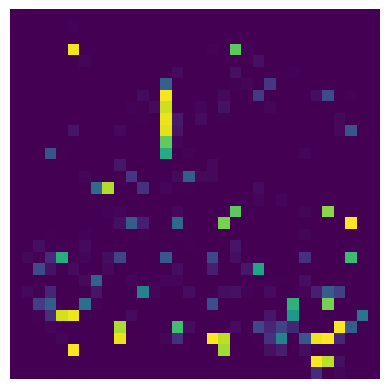

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reverse_engineer(param = {
    "dataset": "cifar10",
    "Epochs": 100,
    "batch_size": 64,
    "target_label": 5,
    "cost_lambda": 1e-3,
    "num_classes": 10,
    "image_size": (32, 32)}, model = torch.load('model_cifar10_0.15_5.pkl').to(device))

### Target Label = 6, Injection Rate = 0.15

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
param = {
    "dataset": "cifar10",
    "model": "default",
    "poisoning_method": "badnet",
    "injection_rate": 0.15,
    "target_label": 6,
    "Epochs": 150,
    "batch_size": 64
    }
fill_param(param)
train(param)

Testing...: 100%|██████████| 157/157 [00:00<00:00, 641.79it/s]


Epoch: 1, Training Accuracy: 51.732, Testing Accuracy: 57.61, Testing ASR: 95.34


Testing...: 100%|██████████| 157/157 [00:00<00:00, 599.98it/s]


Epoch: 2, Training Accuracy: 66.226, Testing Accuracy: 62.9, Testing ASR: 96.49


Testing...: 100%|██████████| 157/157 [00:00<00:00, 605.16it/s]


Epoch: 3, Training Accuracy: 71.45, Testing Accuracy: 69.92, Testing ASR: 96.02


Testing...: 100%|██████████| 157/157 [00:00<00:00, 598.63it/s]


Epoch: 4, Training Accuracy: 74.634, Testing Accuracy: 68.43, Testing ASR: 96.34


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.58it/s]


Epoch: 5, Training Accuracy: 76.834, Testing Accuracy: 71.88, Testing ASR: 97.41


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.22it/s]


Epoch: 6, Training Accuracy: 78.468, Testing Accuracy: 75.8, Testing ASR: 97.21


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.15it/s]


Epoch: 7, Training Accuracy: 79.754, Testing Accuracy: 70.9, Testing ASR: 97.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.64it/s]


Epoch: 8, Training Accuracy: 81.012, Testing Accuracy: 78.55, Testing ASR: 97.42


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.17it/s]


Epoch: 9, Training Accuracy: 81.856, Testing Accuracy: 62.0, Testing ASR: 95.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.01it/s]


Epoch: 10, Training Accuracy: 82.714, Testing Accuracy: 78.34, Testing ASR: 96.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.43it/s]


Epoch: 11, Training Accuracy: 83.168, Testing Accuracy: 79.49, Testing ASR: 97.52


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.11it/s]


Epoch: 12, Training Accuracy: 83.896, Testing Accuracy: 78.3, Testing ASR: 97.44


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.02it/s]


Epoch: 13, Training Accuracy: 84.752, Testing Accuracy: 81.25, Testing ASR: 97.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.97it/s]


Epoch: 14, Training Accuracy: 85.434, Testing Accuracy: 80.2, Testing ASR: 97.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.67it/s]


Epoch: 15, Training Accuracy: 85.788, Testing Accuracy: 81.36, Testing ASR: 97.39


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.86it/s]


Epoch: 16, Training Accuracy: 86.35, Testing Accuracy: 75.65, Testing ASR: 96.52


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.35it/s]


Epoch: 17, Training Accuracy: 86.614, Testing Accuracy: 81.02, Testing ASR: 97.36


Testing...: 100%|██████████| 157/157 [00:00<00:00, 579.48it/s]


Epoch: 18, Training Accuracy: 87.12, Testing Accuracy: 81.35, Testing ASR: 97.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.08it/s]


Epoch: 19, Training Accuracy: 87.556, Testing Accuracy: 79.74, Testing ASR: 97.43


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.52it/s]


Epoch: 20, Training Accuracy: 87.7, Testing Accuracy: 81.15, Testing ASR: 97.52


Testing...: 100%|██████████| 157/157 [00:00<00:00, 554.61it/s]


Epoch: 21, Training Accuracy: 88.25, Testing Accuracy: 81.71, Testing ASR: 97.59


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.11it/s]


Epoch: 22, Training Accuracy: 88.426, Testing Accuracy: 80.78, Testing ASR: 97.37


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.58it/s]


Epoch: 23, Training Accuracy: 88.81, Testing Accuracy: 79.45, Testing ASR: 97.24


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.05it/s]


Epoch: 24, Training Accuracy: 89.168, Testing Accuracy: 79.96, Testing ASR: 98.28


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.69it/s]


Epoch: 25, Training Accuracy: 89.308, Testing Accuracy: 80.6, Testing ASR: 97.6


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.50it/s]


Epoch: 26, Training Accuracy: 89.712, Testing Accuracy: 81.69, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.82it/s]


Epoch: 27, Training Accuracy: 89.98, Testing Accuracy: 77.15, Testing ASR: 96.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.40it/s]


Epoch: 28, Training Accuracy: 89.838, Testing Accuracy: 78.13, Testing ASR: 97.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.88it/s]


Epoch: 29, Training Accuracy: 90.116, Testing Accuracy: 81.09, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.48it/s]


Epoch: 30, Training Accuracy: 90.45, Testing Accuracy: 82.21, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 635.90it/s]


Epoch: 31, Training Accuracy: 90.69, Testing Accuracy: 82.04, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 641.91it/s]


Epoch: 32, Training Accuracy: 90.588, Testing Accuracy: 81.86, Testing ASR: 97.42


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.80it/s]


Epoch: 33, Training Accuracy: 90.922, Testing Accuracy: 79.37, Testing ASR: 95.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 569.01it/s]


Epoch: 34, Training Accuracy: 91.278, Testing Accuracy: 81.97, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 598.24it/s]


Epoch: 35, Training Accuracy: 91.238, Testing Accuracy: 82.01, Testing ASR: 97.18


Testing...: 100%|██████████| 157/157 [00:00<00:00, 594.41it/s]


Epoch: 36, Training Accuracy: 91.442, Testing Accuracy: 82.42, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.31it/s]


Epoch: 37, Training Accuracy: 91.626, Testing Accuracy: 81.47, Testing ASR: 96.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.34it/s]


Epoch: 38, Training Accuracy: 91.434, Testing Accuracy: 81.4, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.29it/s]


Epoch: 39, Training Accuracy: 91.87, Testing Accuracy: 81.99, Testing ASR: 97.5


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.53it/s]


Epoch: 40, Training Accuracy: 91.99, Testing Accuracy: 81.64, Testing ASR: 97.98


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.34it/s]


Epoch: 41, Training Accuracy: 91.984, Testing Accuracy: 80.59, Testing ASR: 96.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.42it/s]


Epoch: 42, Training Accuracy: 91.958, Testing Accuracy: 82.16, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.84it/s]


Epoch: 43, Training Accuracy: 92.254, Testing Accuracy: 82.18, Testing ASR: 97.54


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.91it/s]


Epoch: 44, Training Accuracy: 92.356, Testing Accuracy: 82.1, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.39it/s]


Epoch: 45, Training Accuracy: 92.522, Testing Accuracy: 81.39, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.02it/s]


Epoch: 46, Training Accuracy: 92.746, Testing Accuracy: 81.97, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.69it/s]


Epoch: 47, Training Accuracy: 92.824, Testing Accuracy: 81.89, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 645.02it/s]


Epoch: 48, Training Accuracy: 92.862, Testing Accuracy: 81.8, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 635.12it/s]


Epoch: 49, Training Accuracy: 92.836, Testing Accuracy: 81.33, Testing ASR: 98.37


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.78it/s]


Epoch: 50, Training Accuracy: 92.836, Testing Accuracy: 81.61, Testing ASR: 98.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.28it/s]


Epoch: 51, Training Accuracy: 93.062, Testing Accuracy: 82.35, Testing ASR: 97.59


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.97it/s]


Epoch: 52, Training Accuracy: 93.25, Testing Accuracy: 81.79, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 600.34it/s]


Epoch: 53, Training Accuracy: 93.4, Testing Accuracy: 82.47, Testing ASR: 97.46


Testing...: 100%|██████████| 157/157 [00:00<00:00, 596.78it/s]


Epoch: 54, Training Accuracy: 93.346, Testing Accuracy: 81.8, Testing ASR: 97.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.23it/s]


Epoch: 55, Training Accuracy: 93.52, Testing Accuracy: 82.45, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 638.30it/s]


Epoch: 56, Training Accuracy: 93.464, Testing Accuracy: 82.14, Testing ASR: 98.18


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.49it/s]


Epoch: 57, Training Accuracy: 93.356, Testing Accuracy: 82.56, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.34it/s]


Epoch: 58, Training Accuracy: 93.57, Testing Accuracy: 81.86, Testing ASR: 98.02


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.30it/s]


Epoch: 59, Training Accuracy: 93.692, Testing Accuracy: 82.33, Testing ASR: 97.49


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.31it/s]


Epoch: 60, Training Accuracy: 93.84, Testing Accuracy: 81.91, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.82it/s]


Epoch: 61, Training Accuracy: 93.77, Testing Accuracy: 80.29, Testing ASR: 94.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.87it/s]


Epoch: 62, Training Accuracy: 93.798, Testing Accuracy: 82.69, Testing ASR: 97.51


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.79it/s]


Epoch: 63, Training Accuracy: 93.968, Testing Accuracy: 82.5, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.58it/s]


Epoch: 64, Training Accuracy: 93.774, Testing Accuracy: 82.24, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.57it/s]


Epoch: 65, Training Accuracy: 93.742, Testing Accuracy: 82.32, Testing ASR: 98.18


Testing...: 100%|██████████| 157/157 [00:00<00:00, 579.28it/s]


Epoch: 66, Training Accuracy: 94.028, Testing Accuracy: 82.1, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.45it/s]


Epoch: 67, Training Accuracy: 94.114, Testing Accuracy: 81.92, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.28it/s]


Epoch: 68, Training Accuracy: 94.266, Testing Accuracy: 82.07, Testing ASR: 97.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.92it/s]


Epoch: 69, Training Accuracy: 94.128, Testing Accuracy: 82.53, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.50it/s]


Epoch: 70, Training Accuracy: 94.288, Testing Accuracy: 82.1, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.96it/s]


Epoch: 71, Training Accuracy: 94.39, Testing Accuracy: 82.72, Testing ASR: 97.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.79it/s]


Epoch: 72, Training Accuracy: 94.524, Testing Accuracy: 81.69, Testing ASR: 98.11


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.94it/s]


Epoch: 73, Training Accuracy: 94.386, Testing Accuracy: 81.68, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.38it/s]


Epoch: 74, Training Accuracy: 94.454, Testing Accuracy: 82.64, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.71it/s]


Epoch: 75, Training Accuracy: 94.612, Testing Accuracy: 82.49, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.43it/s]


Epoch: 76, Training Accuracy: 94.556, Testing Accuracy: 81.94, Testing ASR: 97.31


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.96it/s]


Epoch: 77, Training Accuracy: 94.508, Testing Accuracy: 81.8, Testing ASR: 98.17


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.98it/s]


Epoch: 78, Training Accuracy: 94.578, Testing Accuracy: 82.0, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.08it/s]


Epoch: 79, Training Accuracy: 94.548, Testing Accuracy: 82.71, Testing ASR: 97.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.81it/s]


Epoch: 80, Training Accuracy: 94.724, Testing Accuracy: 82.58, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.25it/s]


Epoch: 81, Training Accuracy: 95.418, Testing Accuracy: 82.83, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.84it/s]


Epoch: 82, Training Accuracy: 95.582, Testing Accuracy: 83.03, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.50it/s]


Epoch: 83, Training Accuracy: 95.944, Testing Accuracy: 82.73, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 598.73it/s]


Epoch: 84, Training Accuracy: 96.132, Testing Accuracy: 83.12, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 594.71it/s]


Epoch: 85, Training Accuracy: 96.142, Testing Accuracy: 83.15, Testing ASR: 97.48


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.15it/s]


Epoch: 86, Training Accuracy: 96.26, Testing Accuracy: 83.1, Testing ASR: 97.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.27it/s]


Epoch: 87, Training Accuracy: 96.152, Testing Accuracy: 82.76, Testing ASR: 98.22


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.44it/s]


Epoch: 88, Training Accuracy: 96.296, Testing Accuracy: 83.16, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.48it/s]


Epoch: 89, Training Accuracy: 96.338, Testing Accuracy: 82.99, Testing ASR: 97.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.89it/s]


Epoch: 90, Training Accuracy: 96.352, Testing Accuracy: 83.23, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.24it/s]


Epoch: 91, Training Accuracy: 96.278, Testing Accuracy: 82.87, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.27it/s]


Epoch: 92, Training Accuracy: 96.384, Testing Accuracy: 83.07, Testing ASR: 98.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.39it/s]


Epoch: 93, Training Accuracy: 96.52, Testing Accuracy: 82.73, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.59it/s]


Epoch: 94, Training Accuracy: 96.374, Testing Accuracy: 82.66, Testing ASR: 98.0


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.70it/s]


Epoch: 95, Training Accuracy: 96.434, Testing Accuracy: 83.0, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 593.43it/s]


Epoch: 96, Training Accuracy: 96.48, Testing Accuracy: 82.71, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 578.83it/s]


Epoch: 97, Training Accuracy: 96.582, Testing Accuracy: 82.92, Testing ASR: 97.93


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.51it/s]


Epoch: 98, Training Accuracy: 96.56, Testing Accuracy: 83.13, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.11it/s]


Epoch: 99, Training Accuracy: 96.48, Testing Accuracy: 83.09, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.61it/s]


Epoch: 100, Training Accuracy: 96.564, Testing Accuracy: 82.87, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.97it/s]


Epoch: 101, Training Accuracy: 96.888, Testing Accuracy: 82.98, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.85it/s]


Epoch: 102, Training Accuracy: 97.034, Testing Accuracy: 83.1, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.26it/s]


Epoch: 103, Training Accuracy: 97.106, Testing Accuracy: 83.17, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.85it/s]


Epoch: 104, Training Accuracy: 97.118, Testing Accuracy: 83.16, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.81it/s]


Epoch: 105, Training Accuracy: 97.334, Testing Accuracy: 83.11, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.89it/s]


Epoch: 106, Training Accuracy: 97.254, Testing Accuracy: 83.07, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.43it/s]


Epoch: 107, Training Accuracy: 97.318, Testing Accuracy: 83.08, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 565.67it/s]


Epoch: 108, Training Accuracy: 97.248, Testing Accuracy: 83.25, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.94it/s]


Epoch: 109, Training Accuracy: 97.334, Testing Accuracy: 83.19, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 597.38it/s]


Epoch: 110, Training Accuracy: 97.398, Testing Accuracy: 83.35, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.37it/s]


Epoch: 111, Training Accuracy: 97.466, Testing Accuracy: 83.33, Testing ASR: 97.98


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.92it/s]


Epoch: 112, Training Accuracy: 97.388, Testing Accuracy: 83.23, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 590.85it/s]


Epoch: 113, Training Accuracy: 97.47, Testing Accuracy: 83.22, Testing ASR: 98.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 590.52it/s]


Epoch: 114, Training Accuracy: 97.422, Testing Accuracy: 83.38, Testing ASR: 98.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.64it/s]


Epoch: 115, Training Accuracy: 97.486, Testing Accuracy: 83.38, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.75it/s]


Epoch: 116, Training Accuracy: 97.492, Testing Accuracy: 83.45, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.67it/s]


Epoch: 117, Training Accuracy: 97.462, Testing Accuracy: 83.53, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.66it/s]


Epoch: 118, Training Accuracy: 97.586, Testing Accuracy: 83.47, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.78it/s]


Epoch: 119, Training Accuracy: 97.646, Testing Accuracy: 83.39, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.38it/s]


Epoch: 120, Training Accuracy: 97.714, Testing Accuracy: 83.45, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 575.82it/s]


Epoch: 121, Training Accuracy: 97.546, Testing Accuracy: 83.52, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.25it/s]


Epoch: 122, Training Accuracy: 97.608, Testing Accuracy: 83.44, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.22it/s]


Epoch: 123, Training Accuracy: 97.524, Testing Accuracy: 83.4, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 561.37it/s]


Epoch: 124, Training Accuracy: 97.63, Testing Accuracy: 83.4, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.86it/s]


Epoch: 125, Training Accuracy: 97.6, Testing Accuracy: 83.41, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.93it/s]


Epoch: 126, Training Accuracy: 97.658, Testing Accuracy: 83.3, Testing ASR: 98.11


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.68it/s]


Epoch: 127, Training Accuracy: 97.61, Testing Accuracy: 83.41, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.64it/s]


Epoch: 128, Training Accuracy: 97.552, Testing Accuracy: 83.25, Testing ASR: 97.97


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.96it/s]


Epoch: 129, Training Accuracy: 97.75, Testing Accuracy: 83.47, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.71it/s]


Epoch: 130, Training Accuracy: 97.63, Testing Accuracy: 83.29, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.95it/s]


Epoch: 131, Training Accuracy: 97.64, Testing Accuracy: 83.28, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.63it/s]


Epoch: 132, Training Accuracy: 97.68, Testing Accuracy: 83.32, Testing ASR: 97.98


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.86it/s]


Epoch: 133, Training Accuracy: 97.716, Testing Accuracy: 83.33, Testing ASR: 97.97


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.79it/s]


Epoch: 134, Training Accuracy: 97.678, Testing Accuracy: 83.41, Testing ASR: 97.97


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.19it/s]


Epoch: 135, Training Accuracy: 97.652, Testing Accuracy: 83.44, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 634.25it/s]


Epoch: 136, Training Accuracy: 97.786, Testing Accuracy: 83.3, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.58it/s]


Epoch: 137, Training Accuracy: 97.568, Testing Accuracy: 83.41, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.72it/s]


Epoch: 138, Training Accuracy: 97.718, Testing Accuracy: 83.42, Testing ASR: 97.97


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.75it/s]


Epoch: 139, Training Accuracy: 97.57, Testing Accuracy: 83.17, Testing ASR: 98.11


Testing...: 100%|██████████| 157/157 [00:00<00:00, 599.59it/s]


Epoch: 140, Training Accuracy: 97.75, Testing Accuracy: 83.35, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.06it/s]


Epoch: 141, Training Accuracy: 97.628, Testing Accuracy: 83.22, Testing ASR: 98.14


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.84it/s]


Epoch: 142, Training Accuracy: 97.688, Testing Accuracy: 83.37, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.34it/s]


Epoch: 143, Training Accuracy: 97.878, Testing Accuracy: 83.32, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.60it/s]


Epoch: 144, Training Accuracy: 97.704, Testing Accuracy: 83.31, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.00it/s]


Epoch: 145, Training Accuracy: 97.684, Testing Accuracy: 83.33, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.08it/s]


Epoch: 146, Training Accuracy: 97.756, Testing Accuracy: 83.37, Testing ASR: 98.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.33it/s]


Epoch: 147, Training Accuracy: 97.664, Testing Accuracy: 83.53, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.19it/s]


Epoch: 148, Training Accuracy: 97.676, Testing Accuracy: 83.29, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.55it/s]


Epoch: 149, Training Accuracy: 97.702, Testing Accuracy: 83.53, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.85it/s]


Epoch: 150, Training Accuracy: 97.782, Testing Accuracy: 83.49, Testing ASR: 97.9


Processing label: 0


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 253.82it/s]


norm: 488.2186279296875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 249.30it/s]


norm: 437.9832763671875


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 246.58it/s]


norm: 381.5313720703125


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 253.43it/s]


norm: 325.5733642578125


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 251.70it/s]


norm: 271.9736633300781


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 253.88it/s]


norm: 224.28875732421875


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 251.95it/s]


norm: 185.09814453125


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 248.08it/s]


norm: 155.25709533691406


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 252.79it/s]


norm: 132.66001892089844


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 254.52it/s]


norm: 115.02879333496094


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 255.57it/s]


norm: 102.41145324707031


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 231.85it/s]


norm: 90.67088317871094


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 230.46it/s]


norm: 81.868896484375


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 255.66it/s]


norm: 76.50173950195312


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 252.77it/s]


norm: 70.16605377197266


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 241.95it/s]


norm: 66.86186981201172


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 253.04it/s]


norm: 62.31101608276367


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 250.80it/s]


norm: 60.34461975097656


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 225.41it/s]


norm: 58.34381866455078


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 220.07it/s]


norm: 57.03910827636719


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 222.47it/s]


norm: 55.69748306274414


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 229.77it/s]


norm: 53.759525299072266


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 244.81it/s]


norm: 52.50006103515625


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 243.86it/s]


norm: 51.77202606201172


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 251.71it/s]


norm: 50.6553955078125


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 238.27it/s]


norm: 50.32008361816406


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 251.39it/s]


norm: 50.49043273925781


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 252.01it/s]


norm: 50.375457763671875


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 251.61it/s]


norm: 50.286537170410156


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 233.65it/s]


norm: 50.238765716552734


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 252.03it/s]


norm: 50.510719299316406


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 253.59it/s]


norm: 49.8056640625


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 235.67it/s]


norm: 48.75038146972656


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 230.53it/s]


norm: 48.474815368652344


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 240.73it/s]


norm: 47.76555633544922


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 250.27it/s]


norm: 47.63990020751953


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 243.35it/s]


norm: 46.993900299072266


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 254.26it/s]


norm: 47.247215270996094


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 245.85it/s]


norm: 46.337677001953125


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 223.36it/s]


norm: 46.688087463378906


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 229.00it/s]


norm: 46.969871520996094


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 250.13it/s]


norm: 46.76363754272461


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 256.01it/s]


norm: 47.03519058227539


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 256.10it/s]


norm: 46.40468978881836


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 252.93it/s]


norm: 46.27129364013672


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 251.99it/s]


norm: 45.46913146972656


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 250.92it/s]


norm: 45.260009765625


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 229.61it/s]


norm: 45.64009475708008


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 250.97it/s]


norm: 45.68727111816406


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 253.40it/s]


norm: 45.65447998046875


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 250.75it/s]


norm: 45.80845642089844


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 253.73it/s]


norm: 45.68219757080078


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 233.34it/s]


norm: 45.57672882080078


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 234.47it/s]


norm: 45.265220642089844


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 252.48it/s]


norm: 45.29521179199219


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 246.14it/s]


norm: 44.99399948120117


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 244.64it/s]


norm: 44.62482833862305


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 219.36it/s]


norm: 44.533592224121094


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 230.68it/s]


norm: 44.29803466796875


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 251.73it/s]


norm: 44.00926971435547


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 253.40it/s]


norm: 44.04402160644531


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 252.06it/s]


norm: 44.402305603027344


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 244.91it/s]


norm: 43.88385772705078


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 236.86it/s]


norm: 43.92060089111328


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 244.29it/s]


norm: 44.075050354003906


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 254.54it/s]


norm: 43.72505569458008


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 223.35it/s]


norm: 43.71134948730469


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 250.13it/s]


norm: 43.4239501953125


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 255.30it/s]


norm: 43.508731842041016


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 244.71it/s]


norm: 43.375938415527344


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 241.29it/s]


norm: 43.26261520385742


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 248.90it/s]


norm: 43.31468963623047


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 251.75it/s]


norm: 43.046722412109375


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 255.84it/s]


norm: 43.25776672363281


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 257.83it/s]


norm: 43.08147430419922


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 254.51it/s]


norm: 42.97755813598633


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 252.62it/s]


norm: 43.045719146728516


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 237.90it/s]


norm: 42.790199279785156


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 238.17it/s]


norm: 42.89457321166992


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 219.26it/s]


norm: 42.60551452636719


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 239.89it/s]


norm: 42.703495025634766


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 248.84it/s]


norm: 42.524078369140625


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 226.07it/s]


norm: 42.39757537841797


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 220.80it/s]


norm: 42.4962158203125


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 230.62it/s]


norm: 42.526817321777344


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 241.25it/s]


norm: 42.63348388671875


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 246.40it/s]


norm: 42.78277587890625


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 241.51it/s]


norm: 42.72410583496094


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 232.65it/s]


norm: 42.2039680480957


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 252.47it/s]


norm: 42.30016326904297


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 250.79it/s]


norm: 42.5358772277832


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 252.39it/s]


norm: 42.16112518310547


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 255.89it/s]


norm: 42.41136169433594


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 254.25it/s]


norm: 42.1056022644043


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 251.65it/s]


norm: 42.32960510253906


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 254.24it/s]


norm: 41.84626770019531


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 254.31it/s]


norm: 41.34387969970703


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 253.67it/s]


norm: 41.74661636352539


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 256.22it/s]


norm: 41.753082275390625


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 246.72it/s]


norm: 41.754093170166016
Processing label: 1


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 245.18it/s]


norm: 491.11871337890625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 256.98it/s]


norm: 446.72161865234375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 249.95it/s]


norm: 393.7520751953125


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 234.70it/s]


norm: 337.9208984375


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 228.21it/s]


norm: 284.66424560546875


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 250.44it/s]


norm: 236.82827758789062


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 258.27it/s]


norm: 197.54261779785156


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 254.59it/s]


norm: 165.80178833007812


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 252.97it/s]


norm: 138.97193908691406


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 225.65it/s]


norm: 117.6310806274414


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 247.88it/s]


norm: 100.59332275390625


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 254.23it/s]


norm: 88.20626831054688


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 254.72it/s]


norm: 78.13206481933594


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 252.22it/s]


norm: 71.34283447265625


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 252.52it/s]


norm: 66.89012908935547


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 252.56it/s]


norm: 62.161277770996094


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 250.67it/s]


norm: 59.98653793334961


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 255.99it/s]


norm: 58.49018859863281


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 254.05it/s]


norm: 56.47916793823242


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 256.66it/s]


norm: 53.16373062133789


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 251.65it/s]


norm: 51.27566909790039


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 250.89it/s]


norm: 50.12800216674805


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 251.24it/s]


norm: 49.96904373168945


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 237.04it/s]


norm: 48.927616119384766


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 246.15it/s]


norm: 48.8842887878418


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 227.06it/s]


norm: 47.861488342285156


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 229.14it/s]


norm: 48.20661163330078


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 247.91it/s]


norm: 46.78824996948242


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 255.85it/s]


norm: 46.18424987792969


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 253.50it/s]


norm: 46.06311798095703


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 255.26it/s]


norm: 45.81251525878906


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 253.10it/s]


norm: 45.58546447753906


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 252.86it/s]


norm: 45.31464767456055


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 226.46it/s]


norm: 44.64994812011719


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 237.57it/s]


norm: 45.57231521606445


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 255.99it/s]


norm: 44.733131408691406


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 225.88it/s]


norm: 44.922019958496094


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 242.25it/s]


norm: 45.15810012817383


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 249.12it/s]


norm: 44.33793258666992


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 256.93it/s]


norm: 43.836082458496094


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 259.25it/s]


norm: 43.72773361206055


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 257.83it/s]


norm: 43.44319534301758


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 251.37it/s]


norm: 42.568275451660156


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 254.63it/s]


norm: 42.29792785644531


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 252.77it/s]


norm: 42.085350036621094


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 221.64it/s]


norm: 42.24585723876953


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 248.76it/s]


norm: 42.16781234741211


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 242.30it/s]


norm: 42.18653869628906


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 254.58it/s]


norm: 42.237876892089844


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 246.78it/s]


norm: 41.92884826660156


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 249.06it/s]


norm: 41.939476013183594


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 254.22it/s]


norm: 41.903656005859375


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 251.12it/s]


norm: 42.0069580078125


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 252.26it/s]


norm: 41.58631896972656


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 249.24it/s]


norm: 41.56075668334961


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 239.14it/s]


norm: 41.66875457763672


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 249.12it/s]


norm: 41.68034362792969


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 256.49it/s]


norm: 41.16014862060547


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 244.45it/s]


norm: 41.392791748046875


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 253.96it/s]


norm: 40.89142608642578


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 253.15it/s]


norm: 40.65081787109375


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 251.04it/s]


norm: 40.686187744140625


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 252.55it/s]


norm: 41.90230178833008


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 228.66it/s]


norm: 40.77018737792969


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 218.65it/s]


norm: 40.75072479248047


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 230.70it/s]


norm: 40.39556121826172


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 233.21it/s]


norm: 40.47930908203125


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 253.48it/s]


norm: 40.34208679199219


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 253.73it/s]


norm: 40.14822769165039


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 250.72it/s]


norm: 40.28832244873047


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 250.57it/s]


norm: 40.123802185058594


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 247.52it/s]


norm: 40.3360481262207


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 244.32it/s]


norm: 40.24750518798828


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 247.27it/s]


norm: 40.1787109375


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 248.55it/s]


norm: 40.289894104003906


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 250.90it/s]


norm: 40.21303939819336


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 252.97it/s]


norm: 40.23667907714844


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 251.08it/s]


norm: 40.061946868896484


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 247.80it/s]


norm: 40.46461486816406


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


norm: 40.59986114501953


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 251.39it/s]


norm: 40.359901428222656


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 253.68it/s]


norm: 40.14140319824219


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 245.23it/s]


norm: 39.98249816894531


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 252.56it/s]


norm: 40.017208099365234


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 254.91it/s]


norm: 40.18927001953125


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 251.31it/s]


norm: 39.647613525390625


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 244.84it/s]


norm: 40.035194396972656


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 247.98it/s]


norm: 39.796607971191406


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 224.00it/s]


norm: 39.57606506347656


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 222.16it/s]


norm: 39.917877197265625


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 240.24it/s]


norm: 39.95649719238281


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 252.75it/s]


norm: 40.73316955566406


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 253.13it/s]


norm: 39.8963737487793


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 250.91it/s]


norm: 40.13106918334961


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 240.43it/s]


norm: 40.06463623046875


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 251.70it/s]


norm: 39.975948333740234


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 251.89it/s]


norm: 40.6781005859375


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 214.39it/s]


norm: 39.86717987060547


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 223.81it/s]


norm: 39.95421600341797


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 247.71it/s]


norm: 39.967857360839844
Processing label: 2


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 247.75it/s]


norm: 473.8966064453125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 241.05it/s]


norm: 408.8609619140625


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 256.10it/s]


norm: 340.1889343261719


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 249.46it/s]


norm: 277.3787841796875


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 257.01it/s]


norm: 226.13414001464844


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 260.20it/s]


norm: 184.83319091796875


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 253.79it/s]


norm: 151.91458129882812


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 234.63it/s]


norm: 129.1354522705078


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 250.02it/s]


norm: 113.46542358398438


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 245.89it/s]


norm: 100.84203338623047


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 250.07it/s]


norm: 90.67503356933594


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 249.56it/s]


norm: 83.4698486328125


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 251.76it/s]


norm: 75.62216186523438


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 251.32it/s]


norm: 70.9259033203125


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 251.68it/s]


norm: 67.25564575195312


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 258.38it/s]


norm: 63.53636169433594


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 248.51it/s]


norm: 60.93901443481445


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 247.02it/s]


norm: 57.98899459838867


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 258.61it/s]


norm: 57.768856048583984


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 255.94it/s]


norm: 56.08090591430664


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 248.28it/s]


norm: 54.70677947998047


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 259.29it/s]


norm: 53.519710540771484


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 254.15it/s]


norm: 51.57423782348633


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 249.17it/s]


norm: 49.30205535888672


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 254.79it/s]


norm: 48.096717834472656


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 248.28it/s]


norm: 47.23154830932617


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 250.64it/s]


norm: 47.07522964477539


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 252.02it/s]


norm: 46.80989074707031


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 249.72it/s]


norm: 46.25146484375


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 253.14it/s]


norm: 46.206817626953125


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 211.71it/s]


norm: 46.24849319458008


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 248.29it/s]


norm: 46.6808967590332


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 246.16it/s]


norm: 46.28700256347656


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 248.64it/s]


norm: 45.1090087890625


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 244.68it/s]


norm: 44.197120666503906


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 254.81it/s]


norm: 44.06528091430664


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 246.32it/s]


norm: 44.27821350097656


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 254.83it/s]


norm: 44.25836181640625


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 247.63it/s]


norm: 43.797447204589844


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 251.96it/s]


norm: 43.50239562988281


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 257.24it/s]


norm: 42.5396728515625


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 252.47it/s]


norm: 43.157981872558594


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 244.93it/s]


norm: 42.12446594238281


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 241.62it/s]


norm: 42.59041976928711


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 245.58it/s]


norm: 42.06208419799805


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 252.64it/s]


norm: 41.61349868774414


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 235.65it/s]


norm: 43.232574462890625


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 220.64it/s]


norm: 40.83642578125


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 256.93it/s]


norm: 40.93370819091797


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 254.45it/s]


norm: 41.35112762451172


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 251.07it/s]


norm: 40.35449981689453


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 253.55it/s]


norm: 40.55010223388672


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 250.15it/s]


norm: 40.03310775756836


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 226.26it/s]


norm: 39.72909164428711


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 248.58it/s]


norm: 40.298492431640625


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 226.57it/s]


norm: 39.88665008544922


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 226.90it/s]


norm: 40.1203498840332


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 244.56it/s]


norm: 39.962066650390625


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 234.22it/s]


norm: 39.86932373046875


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 234.60it/s]


norm: 39.95514678955078


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 229.88it/s]


norm: 39.52019500732422


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 237.27it/s]


norm: 38.90299606323242


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 245.80it/s]


norm: 39.773616790771484


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 249.38it/s]


norm: 39.41522216796875


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 253.56it/s]


norm: 38.659767150878906


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 242.33it/s]


norm: 38.6302490234375


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 253.08it/s]


norm: 38.517852783203125


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 243.71it/s]


norm: 38.756134033203125


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 254.16it/s]


norm: 38.971893310546875


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 249.78it/s]


norm: 39.008575439453125


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 250.61it/s]


norm: 39.708091735839844


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 253.97it/s]


norm: 39.917972564697266


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 225.10it/s]


norm: 39.16256332397461


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 235.12it/s]


norm: 40.30908203125


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 235.32it/s]


norm: 39.21625900268555


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 256.73it/s]


norm: 40.10873794555664


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 253.69it/s]


norm: 39.31147003173828


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 250.04it/s]


norm: 40.11822509765625


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 253.14it/s]


norm: 39.65592956542969


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 250.26it/s]


norm: 39.65644454956055


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 248.88it/s]


norm: 39.79549789428711


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 246.74it/s]


norm: 38.87204360961914


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 250.39it/s]


norm: 39.443458557128906


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 254.75it/s]


norm: 39.210227966308594


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 250.75it/s]


norm: 39.20067596435547


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 250.36it/s]


norm: 39.11419677734375


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 253.13it/s]


norm: 39.733795166015625


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 252.30it/s]


norm: 39.41522216796875


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 250.92it/s]


norm: 40.151588439941406


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 245.76it/s]


norm: 40.050880432128906


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 250.41it/s]


norm: 38.70659637451172


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 247.70it/s]


norm: 39.32090377807617


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 247.39it/s]


norm: 38.845577239990234


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 253.24it/s]


norm: 41.221832275390625


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 250.61it/s]


norm: 40.86204147338867


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 246.94it/s]


norm: 41.34141540527344


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 251.74it/s]


norm: 39.068302154541016


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 245.73it/s]


norm: 39.851470947265625
Processing label: 3


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 249.77it/s]


norm: 463.214111328125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 255.83it/s]


norm: 403.8884582519531


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 254.24it/s]


norm: 339.8478698730469


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 247.84it/s]


norm: 279.4197998046875


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 251.37it/s]


norm: 226.53773498535156


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 249.42it/s]


norm: 185.9541015625


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 227.58it/s]


norm: 156.99636840820312


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 237.22it/s]


norm: 134.17054748535156


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 251.16it/s]


norm: 117.35346984863281


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 238.62it/s]


norm: 103.24493408203125


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 250.68it/s]


norm: 93.22869873046875


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 250.26it/s]


norm: 84.50459289550781


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 244.20it/s]


norm: 79.2643051147461


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 251.72it/s]


norm: 74.02428436279297


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 230.75it/s]


norm: 70.94053649902344


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 228.12it/s]


norm: 68.30307006835938


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 250.46it/s]


norm: 66.79100799560547


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 253.54it/s]


norm: 64.96285247802734


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 245.66it/s]


norm: 63.991050720214844


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 255.51it/s]


norm: 63.4227294921875


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 253.49it/s]


norm: 61.531761169433594


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 250.45it/s]


norm: 60.869873046875


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 250.99it/s]


norm: 59.49779510498047


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 251.33it/s]


norm: 58.79560852050781


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 246.73it/s]


norm: 58.05887985229492


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 248.75it/s]


norm: 57.56756591796875


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 227.46it/s]


norm: 57.62467956542969


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 221.36it/s]


norm: 57.35070037841797


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 239.82it/s]


norm: 57.07682418823242


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 251.83it/s]


norm: 56.910133361816406


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 243.77it/s]


norm: 56.396217346191406


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 254.19it/s]


norm: 55.898529052734375


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 254.96it/s]


norm: 55.572364807128906


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 256.74it/s]


norm: 55.412879943847656


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 246.15it/s]


norm: 55.10511016845703


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 238.46it/s]


norm: 54.807613372802734


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 243.29it/s]


norm: 54.65095520019531


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 251.21it/s]


norm: 54.224178314208984


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 249.15it/s]


norm: 54.48944854736328


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 222.02it/s]


norm: 54.850181579589844


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 244.15it/s]


norm: 54.766082763671875


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 253.76it/s]


norm: 54.64494323730469


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 234.04it/s]


norm: 54.51495361328125


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 229.29it/s]


norm: 54.636260986328125


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 241.75it/s]


norm: 54.50295639038086


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 250.48it/s]


norm: 54.400840759277344


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 258.74it/s]


norm: 54.321468353271484


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 237.50it/s]


norm: 54.339080810546875


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 242.41it/s]


norm: 54.27796173095703


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 227.23it/s]


norm: 54.56951904296875


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 246.31it/s]


norm: 54.47288131713867


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 231.89it/s]


norm: 54.19941711425781


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 234.56it/s]


norm: 54.07980728149414


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 241.61it/s]


norm: 54.092987060546875


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 221.80it/s]


norm: 53.52033233642578


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 229.58it/s]


norm: 53.24860382080078


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 238.40it/s]


norm: 53.627037048339844


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 258.56it/s]


norm: 52.68136215209961


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 256.85it/s]


norm: 53.08416748046875


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 239.57it/s]


norm: 53.591392517089844


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 233.95it/s]


norm: 53.474037170410156


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 256.26it/s]


norm: 54.15999221801758


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 251.99it/s]


norm: 53.65907669067383


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 252.49it/s]


norm: 53.40958786010742


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 246.44it/s]


norm: 53.353736877441406


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 245.14it/s]


norm: 53.00605773925781


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 257.89it/s]


norm: 53.13576126098633


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 249.40it/s]


norm: 53.12312698364258


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 256.53it/s]


norm: 53.197086334228516


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 260.50it/s]


norm: 52.844505310058594


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 254.64it/s]


norm: 53.04591369628906


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 257.32it/s]


norm: 52.42351150512695


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 257.31it/s]


norm: 52.57787322998047


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 251.77it/s]


norm: 53.6551513671875


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 250.30it/s]


norm: 53.00851821899414


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 249.09it/s]


norm: 52.665321350097656


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 246.88it/s]


norm: 53.0596923828125


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 249.26it/s]


norm: 53.68344497680664


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 235.86it/s]


norm: 52.81499099731445


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 215.78it/s]


norm: 52.674949645996094


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 226.01it/s]


norm: 52.50991439819336


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 231.80it/s]


norm: 52.473270416259766


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 224.67it/s]


norm: 52.777244567871094


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 220.15it/s]


norm: 53.215721130371094


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 244.47it/s]


norm: 51.81146240234375


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 224.82it/s]


norm: 51.934234619140625


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 257.47it/s]


norm: 52.19366455078125


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 228.84it/s]


norm: 52.60094451904297


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 250.87it/s]


norm: 52.68170928955078


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 252.41it/s]


norm: 53.033348083496094


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 251.26it/s]


norm: 52.845115661621094


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 241.82it/s]


norm: 53.03924560546875


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 236.49it/s]


norm: 52.686519622802734


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 224.88it/s]


norm: 51.8408088684082


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 252.37it/s]


norm: 52.95771408081055


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 245.25it/s]


norm: 53.339195251464844


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 230.75it/s]


norm: 53.38115692138672


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 227.75it/s]


norm: 52.51152420043945


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 221.53it/s]


norm: 52.796905517578125


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 225.18it/s]


norm: 52.70221710205078
Processing label: 4


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 226.46it/s]


norm: 476.2624816894531


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 224.78it/s]


norm: 425.33917236328125


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 245.81it/s]


norm: 365.7093505859375


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 252.46it/s]


norm: 306.0950622558594


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 254.18it/s]


norm: 255.19442749023438


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 248.90it/s]


norm: 212.695556640625


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 242.50it/s]


norm: 179.29954528808594


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 249.79it/s]


norm: 154.8482666015625


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 251.67it/s]


norm: 133.831787109375


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 254.04it/s]


norm: 117.2311019897461


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 253.38it/s]


norm: 106.68647766113281


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 256.48it/s]


norm: 98.43191528320312


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 227.47it/s]


norm: 90.79523468017578


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 226.31it/s]


norm: 85.72422790527344


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 218.07it/s]


norm: 81.09603881835938


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 254.44it/s]


norm: 77.46197509765625


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 249.33it/s]


norm: 72.8580322265625


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 250.24it/s]


norm: 70.42029571533203


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 236.00it/s]


norm: 68.06446838378906


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 237.49it/s]


norm: 65.51619720458984


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 235.57it/s]


norm: 63.92108154296875


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 221.54it/s]


norm: 62.987396240234375


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 224.20it/s]


norm: 62.39836502075195


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 228.17it/s]


norm: 60.99964141845703


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 247.04it/s]


norm: 59.54827880859375


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 232.03it/s]


norm: 59.37449645996094


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 238.19it/s]


norm: 58.47061538696289


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 253.28it/s]


norm: 57.9073371887207


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 251.53it/s]


norm: 57.195533752441406


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 247.32it/s]


norm: 57.09101867675781


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 237.68it/s]


norm: 56.965084075927734


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 246.80it/s]


norm: 55.81327819824219


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 226.80it/s]


norm: 55.62767791748047


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 216.25it/s]


norm: 55.347251892089844


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 238.15it/s]


norm: 54.79795455932617


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 235.89it/s]


norm: 54.256996154785156


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 224.79it/s]


norm: 54.31017303466797


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 245.32it/s]


norm: 54.170955657958984


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 237.77it/s]


norm: 54.53170394897461


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 248.87it/s]


norm: 52.64365005493164


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 253.91it/s]


norm: 52.93750762939453


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 230.31it/s]


norm: 53.05744171142578


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 254.68it/s]


norm: 53.09724426269531


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 252.56it/s]


norm: 53.39793395996094


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 234.40it/s]


norm: 53.8319091796875


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 220.89it/s]


norm: 52.95599365234375


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 229.44it/s]


norm: 54.192413330078125


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 255.22it/s]


norm: 53.73255920410156


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 253.02it/s]


norm: 54.48103713989258


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 254.58it/s]


norm: 53.530906677246094


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 256.48it/s]


norm: 53.491127014160156


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 256.52it/s]


norm: 52.55134201049805


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 242.05it/s]


norm: 52.63773727416992


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 239.99it/s]


norm: 52.53421401977539


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 246.77it/s]


norm: 53.12376403808594


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 249.58it/s]


norm: 52.65312194824219


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 237.71it/s]


norm: 52.782325744628906


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 255.11it/s]


norm: 52.75416946411133


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 240.12it/s]


norm: 52.451358795166016


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 255.70it/s]


norm: 52.67420959472656


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 246.33it/s]


norm: 52.83622741699219


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 249.79it/s]


norm: 52.07286834716797


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 255.67it/s]


norm: 52.343536376953125


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 253.59it/s]


norm: 52.56339645385742


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 238.89it/s]


norm: 52.09370422363281


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 223.14it/s]


norm: 52.88703918457031


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 249.38it/s]


norm: 51.1347770690918


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 241.51it/s]


norm: 51.917816162109375


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 241.85it/s]


norm: 51.277244567871094


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 248.59it/s]


norm: 51.27117919921875


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 253.26it/s]


norm: 50.377410888671875


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 247.52it/s]


norm: 51.4666748046875


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 246.01it/s]


norm: 51.50404357910156


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 251.36it/s]


norm: 50.93669891357422


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 252.98it/s]


norm: 52.01171112060547


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 254.10it/s]


norm: 51.184165954589844


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 252.99it/s]


norm: 52.43403625488281


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 244.70it/s]


norm: 52.17527389526367


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 242.55it/s]


norm: 52.3304557800293


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 252.48it/s]


norm: 51.65241622924805


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 251.61it/s]


norm: 52.158042907714844


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 252.19it/s]


norm: 50.12818908691406


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 253.93it/s]


norm: 51.631046295166016


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 251.09it/s]


norm: 50.06501007080078


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 250.96it/s]


norm: 51.68907165527344


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 247.79it/s]


norm: 50.906982421875


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 246.04it/s]


norm: 49.06745147705078


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 250.69it/s]


norm: 51.096534729003906


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 206.13it/s]


norm: 50.09113311767578


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 219.09it/s]


norm: 50.55176544189453


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 248.06it/s]


norm: 50.116180419921875


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 244.54it/s]


norm: 49.77812957763672


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 242.21it/s]


norm: 49.836116790771484


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 232.68it/s]


norm: 49.95098114013672


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 230.60it/s]


norm: 49.703636169433594


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 250.82it/s]


norm: 50.67734909057617


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 240.00it/s]


norm: 50.305477142333984


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 225.41it/s]


norm: 51.382896423339844


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 218.46it/s]


norm: 52.20524597167969


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 247.28it/s]


norm: 49.15199661254883
Processing label: 5


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 252.52it/s]


norm: 491.31640625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 244.93it/s]


norm: 454.50640869140625


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 247.48it/s]


norm: 408.730712890625


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 252.37it/s]


norm: 360.1706848144531


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 249.60it/s]


norm: 312.3729248046875


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 246.38it/s]


norm: 266.612548828125


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 246.61it/s]


norm: 226.56390380859375


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 225.19it/s]


norm: 193.04071044921875


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 251.35it/s]


norm: 165.35845947265625


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 243.70it/s]


norm: 143.381591796875


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 228.85it/s]


norm: 126.87916564941406


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 232.31it/s]


norm: 112.02958679199219


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


norm: 100.69155883789062


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 245.42it/s]


norm: 92.04173278808594


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 251.77it/s]


norm: 84.63953399658203


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 252.68it/s]


norm: 79.74278259277344


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 251.09it/s]


norm: 76.45597839355469


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 251.03it/s]


norm: 73.34312438964844


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 250.06it/s]


norm: 70.99420928955078


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 249.37it/s]


norm: 68.48135375976562


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 255.33it/s]


norm: 65.79694366455078


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 242.21it/s]


norm: 63.093109130859375


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 222.18it/s]


norm: 61.785606384277344


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 227.01it/s]


norm: 61.522769927978516


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 211.16it/s]


norm: 60.12487030029297


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 243.04it/s]


norm: 58.116371154785156


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 252.96it/s]


norm: 56.957557678222656


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 225.71it/s]


norm: 56.40876770019531


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 247.70it/s]


norm: 55.80662536621094


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 248.84it/s]


norm: 55.57056427001953


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 248.48it/s]


norm: 55.41535949707031


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 247.67it/s]


norm: 55.38085174560547


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 244.96it/s]


norm: 54.60401153564453


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 249.26it/s]


norm: 54.3479118347168


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 253.90it/s]


norm: 53.68717575073242


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 229.92it/s]


norm: 52.66844177246094


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 226.75it/s]


norm: 51.36998748779297


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 214.38it/s]


norm: 50.82671356201172


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 240.30it/s]


norm: 50.31806945800781


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 248.88it/s]


norm: 49.45616912841797


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 246.68it/s]


norm: 49.40409851074219


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 232.41it/s]


norm: 48.914390563964844


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 233.57it/s]


norm: 48.84503173828125


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 241.94it/s]


norm: 48.64858627319336


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 244.58it/s]


norm: 48.4239387512207


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 233.72it/s]


norm: 48.18436050415039


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 233.96it/s]


norm: 48.196510314941406


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 248.88it/s]


norm: 47.42430114746094


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 245.26it/s]


norm: 46.220741271972656


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 252.68it/s]


norm: 45.659942626953125


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 244.07it/s]


norm: 45.63008117675781


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 238.62it/s]


norm: 45.01738739013672


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 227.84it/s]


norm: 44.19093322753906


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 231.68it/s]


norm: 45.598602294921875


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 249.79it/s]


norm: 44.76265335083008


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 252.33it/s]


norm: 44.91837692260742


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 250.37it/s]


norm: 44.144989013671875


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 257.10it/s]


norm: 46.13860321044922


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 251.21it/s]


norm: 43.40043640136719


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 243.02it/s]


norm: 45.26001739501953


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 254.74it/s]


norm: 43.446311950683594


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 250.19it/s]


norm: 44.232845306396484


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 255.73it/s]


norm: 41.862998962402344


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 220.99it/s]


norm: 42.454994201660156


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 215.59it/s]


norm: 42.00248336791992


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 253.29it/s]


norm: 41.710594177246094


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 224.50it/s]


norm: 40.73088836669922


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 219.37it/s]


norm: 42.56475830078125


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 245.44it/s]


norm: 41.307151794433594


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 252.79it/s]


norm: 40.60850524902344


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 225.84it/s]


norm: 41.080535888671875


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 223.79it/s]


norm: 40.872352600097656


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 256.09it/s]


norm: 40.28340530395508


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 252.79it/s]


norm: 41.23847579956055


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 253.84it/s]


norm: 41.31529998779297


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 247.86it/s]


norm: 40.44868850708008


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 234.28it/s]


norm: 39.9981803894043


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 227.83it/s]


norm: 40.94681167602539


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 236.78it/s]


norm: 38.824562072753906


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 239.66it/s]


norm: 39.19712829589844


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 252.51it/s]


norm: 38.142826080322266


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 248.78it/s]


norm: 39.1090087890625


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 248.01it/s]


norm: 37.58896255493164


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 253.70it/s]


norm: 39.24082565307617


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 250.98it/s]


norm: 38.800697326660156


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 246.63it/s]


norm: 37.8472900390625


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 250.76it/s]


norm: 37.49810791015625


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 244.47it/s]


norm: 39.34079360961914


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 250.58it/s]


norm: 39.264225006103516


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 251.51it/s]


norm: 38.18007278442383


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 248.74it/s]


norm: 37.82980728149414


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 253.74it/s]


norm: 38.67076873779297


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 252.04it/s]


norm: 38.524627685546875


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 230.46it/s]


norm: 37.10497283935547


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 246.96it/s]


norm: 37.46516799926758


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 246.05it/s]


norm: 37.159881591796875


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 252.62it/s]


norm: 36.852169036865234


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 240.20it/s]


norm: 37.03723907470703


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 251.68it/s]


norm: 37.391212463378906


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 248.71it/s]


norm: 36.70590591430664
Processing label: 6


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 248.96it/s]


norm: 189.94293212890625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 252.82it/s]


norm: 107.90943908691406


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 253.58it/s]


norm: 81.54525756835938


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 243.08it/s]


norm: 70.87887573242188


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 254.56it/s]


norm: 52.19524002075195


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 252.03it/s]


norm: 38.22770690917969


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 248.64it/s]


norm: 29.336406707763672


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 218.85it/s]


norm: 25.86331558227539


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 225.32it/s]


norm: 19.54843521118164


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 249.27it/s]


norm: 15.904248237609863


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 252.57it/s]


norm: 12.697872161865234


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 257.53it/s]


norm: 14.805846214294434


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 227.04it/s]


norm: 10.541759490966797


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 236.66it/s]


norm: 12.261848449707031


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 223.95it/s]


norm: 10.168035507202148


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 234.62it/s]


norm: 9.99173355102539


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 249.88it/s]


norm: 10.307287216186523


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 257.25it/s]


norm: 14.971990585327148


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 249.23it/s]


norm: 9.184117317199707


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 243.03it/s]


norm: 9.03730583190918


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 246.58it/s]


norm: 9.837657928466797


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 247.21it/s]


norm: 10.241604804992676


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 257.94it/s]


norm: 9.843757629394531


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 240.60it/s]


norm: 8.39510726928711


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 261.11it/s]


norm: 8.436251640319824


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 256.79it/s]


norm: 9.451549530029297


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 225.18it/s]


norm: 15.294001579284668


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 222.19it/s]


norm: 8.394903182983398


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 248.99it/s]


norm: 8.351518630981445


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 254.57it/s]


norm: 8.484394073486328


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 258.14it/s]


norm: 8.266778945922852


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 260.68it/s]


norm: 14.4788179397583


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 234.27it/s]


norm: 8.276630401611328


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 235.63it/s]


norm: 8.109903335571289


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 256.07it/s]


norm: 8.837818145751953


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 224.00it/s]


norm: 8.878067970275879


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 227.82it/s]


norm: 14.760454177856445


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 243.87it/s]


norm: 8.138837814331055


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 252.43it/s]


norm: 11.158863067626953


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 251.32it/s]


norm: 7.391844272613525


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 251.24it/s]


norm: 8.060040473937988


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 251.85it/s]


norm: 8.596076011657715


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 259.23it/s]


norm: 13.91114616394043


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 240.10it/s]


norm: 7.669924736022949


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 254.73it/s]


norm: 7.644449234008789


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 256.78it/s]


norm: 11.101301193237305


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 237.82it/s]


norm: 10.316971778869629


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 217.56it/s]


norm: 13.606277465820312


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 249.64it/s]


norm: 7.612168312072754


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 251.62it/s]


norm: 7.793153285980225


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 246.79it/s]


norm: 8.051535606384277


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 254.94it/s]


norm: 7.300114631652832


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 248.83it/s]


norm: 9.578779220581055


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 249.95it/s]


norm: 8.434379577636719


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 257.71it/s]


norm: 8.428470611572266


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 251.09it/s]


norm: 7.94015645980835


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 251.21it/s]


norm: 14.15324878692627


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 248.19it/s]


norm: 7.621638298034668


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 252.99it/s]


norm: 7.008393287658691


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 246.00it/s]


norm: 8.23896598815918


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 256.09it/s]


norm: 8.671435356140137


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 246.39it/s]


norm: 8.515560150146484


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 257.90it/s]


norm: 11.018837928771973


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 245.31it/s]


norm: 7.25755500793457


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 254.94it/s]


norm: 8.180475234985352


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 244.82it/s]


norm: 14.463987350463867


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 247.68it/s]


norm: 7.399917125701904


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 245.50it/s]


norm: 8.328871726989746


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 251.72it/s]


norm: 13.812273979187012


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 234.20it/s]


norm: 7.52479362487793


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 245.83it/s]


norm: 8.62846565246582


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 254.14it/s]


norm: 10.34039306640625


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 248.51it/s]


norm: 8.001197814941406


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 227.93it/s]


norm: 6.7949347496032715


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 238.26it/s]


norm: 7.97357702255249


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 242.83it/s]


norm: 10.364917755126953


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 245.74it/s]


norm: 7.749397277832031


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 250.81it/s]


norm: 12.0406494140625


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 249.68it/s]


norm: 7.055426597595215


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 249.32it/s]


norm: 7.185333251953125


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 250.50it/s]


norm: 9.064504623413086


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 255.88it/s]


norm: 10.171957015991211


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 244.34it/s]


norm: 7.370915412902832


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 242.73it/s]


norm: 7.739792823791504


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 250.71it/s]


norm: 8.030418395996094


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 253.15it/s]


norm: 9.68433952331543


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 255.26it/s]


norm: 6.755902290344238


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 253.96it/s]


norm: 8.216734886169434


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 252.58it/s]


norm: 7.0329179763793945


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 250.29it/s]


norm: 7.134337425231934


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 253.53it/s]


norm: 8.027750015258789


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 242.34it/s]


norm: 8.27436637878418


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 253.83it/s]


norm: 8.481813430786133


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 255.34it/s]


norm: 7.2033820152282715


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 252.94it/s]


norm: 8.268439292907715


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 260.68it/s]


norm: 9.99105453491211


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 260.55it/s]


norm: 9.433643341064453


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 250.60it/s]


norm: 7.481194019317627


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 250.91it/s]


norm: 12.628673553466797


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 220.33it/s]


norm: 6.988745212554932
Processing label: 7


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 248.88it/s]


norm: 492.3678283691406


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 252.71it/s]


norm: 453.8975830078125


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 254.33it/s]


norm: 406.7063903808594


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 254.06it/s]


norm: 357.5585632324219


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 252.71it/s]


norm: 309.16802978515625


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 254.34it/s]


norm: 264.29278564453125


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 253.06it/s]


norm: 223.19522094726562


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 247.31it/s]


norm: 189.0474853515625


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 233.24it/s]


norm: 161.2386932373047


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 215.77it/s]


norm: 137.1908416748047


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 256.32it/s]


norm: 118.63717651367188


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 254.18it/s]


norm: 104.5396499633789


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 238.16it/s]


norm: 94.30216979980469


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 250.62it/s]


norm: 87.39962768554688


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 239.15it/s]


norm: 82.45812225341797


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 250.01it/s]


norm: 77.23629760742188


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 248.14it/s]


norm: 73.16822814941406


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 248.60it/s]


norm: 70.18324279785156


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 253.04it/s]


norm: 68.13212585449219


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 254.76it/s]


norm: 66.47076416015625


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 252.10it/s]


norm: 65.02886962890625


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 258.48it/s]


norm: 64.24739074707031


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 250.88it/s]


norm: 63.290531158447266


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 253.94it/s]


norm: 62.47766876220703


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 244.39it/s]


norm: 61.543479919433594


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 247.79it/s]


norm: 61.426937103271484


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 248.63it/s]


norm: 60.47660827636719


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 246.80it/s]


norm: 59.32511901855469


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 252.29it/s]


norm: 58.545570373535156


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 249.04it/s]


norm: 58.68412780761719


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 234.29it/s]


norm: 57.40479278564453


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 218.56it/s]


norm: 57.173004150390625


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 207.92it/s]


norm: 56.89146423339844


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 235.04it/s]


norm: 55.930294036865234


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 244.90it/s]


norm: 55.224365234375


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 236.85it/s]


norm: 54.158966064453125


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 251.16it/s]


norm: 53.904144287109375


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 245.86it/s]


norm: 53.189632415771484


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 251.34it/s]


norm: 52.69586944580078


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 245.34it/s]


norm: 52.354393005371094


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 241.69it/s]


norm: 52.15174102783203


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 254.57it/s]


norm: 52.055694580078125


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 253.57it/s]


norm: 52.1025390625


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 253.15it/s]


norm: 51.733245849609375


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 225.24it/s]


norm: 51.4266357421875


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 216.90it/s]


norm: 50.98878479003906


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 248.44it/s]


norm: 51.67903137207031


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 248.07it/s]


norm: 51.17125701904297


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 244.23it/s]


norm: 51.507484436035156


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 246.44it/s]


norm: 51.736000061035156


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 242.14it/s]


norm: 50.92060852050781


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 254.49it/s]


norm: 51.24226379394531


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 257.14it/s]


norm: 50.427066802978516


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 246.88it/s]


norm: 50.348297119140625


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 246.84it/s]


norm: 50.40807342529297


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 245.38it/s]


norm: 50.388511657714844


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 245.86it/s]


norm: 49.64391326904297


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 250.64it/s]


norm: 49.1141357421875


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 250.39it/s]


norm: 48.66812515258789


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 236.63it/s]


norm: 48.16923522949219


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 224.94it/s]


norm: 48.33174133300781


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 245.72it/s]


norm: 48.36366271972656


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 251.75it/s]


norm: 48.574947357177734


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 239.14it/s]


norm: 48.041107177734375


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 211.77it/s]


norm: 47.8714599609375


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 239.26it/s]


norm: 48.221954345703125


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 242.29it/s]


norm: 48.17022705078125


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 254.56it/s]


norm: 48.587772369384766


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 234.56it/s]


norm: 47.97982406616211


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 231.86it/s]


norm: 48.61469268798828


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 241.13it/s]


norm: 48.130882263183594


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 248.73it/s]


norm: 48.83960723876953


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 259.22it/s]


norm: 48.45018768310547


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 256.80it/s]


norm: 48.60139465332031


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 251.56it/s]


norm: 48.61345291137695


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 253.67it/s]


norm: 48.733150482177734


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 245.66it/s]


norm: 48.41118621826172


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 248.61it/s]


norm: 48.39999008178711


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 243.32it/s]


norm: 47.962066650390625


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 253.24it/s]


norm: 47.27239227294922


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 256.83it/s]


norm: 46.96798324584961


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 250.40it/s]


norm: 47.41360855102539


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 250.10it/s]


norm: 47.39167785644531


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 226.23it/s]


norm: 46.969970703125


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 247.17it/s]


norm: 47.02705001831055


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 253.91it/s]


norm: 46.54966735839844


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 250.48it/s]


norm: 46.451019287109375


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 229.49it/s]


norm: 45.907386779785156


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 249.94it/s]


norm: 46.23112487792969


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 249.11it/s]


norm: 46.625282287597656


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 251.73it/s]


norm: 45.963279724121094


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 253.42it/s]


norm: 46.4735107421875


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 253.11it/s]


norm: 46.98542404174805


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


norm: 46.188838958740234


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 258.83it/s]


norm: 46.01786422729492


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 257.61it/s]


norm: 46.82554626464844


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 257.45it/s]


norm: 46.05540466308594


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 258.26it/s]


norm: 48.19211196899414


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 231.87it/s]


norm: 46.09314727783203


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 228.77it/s]


norm: 49.43482971191406
Processing label: 8


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 238.84it/s]


norm: 478.782958984375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 236.73it/s]


norm: 435.1781921386719


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 253.70it/s]


norm: 384.021240234375


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 256.05it/s]


norm: 333.8086853027344


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 251.76it/s]


norm: 286.3791809082031


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 253.50it/s]


norm: 244.72340393066406


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 247.97it/s]


norm: 207.82955932617188


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 237.78it/s]


norm: 176.63095092773438


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 241.53it/s]


norm: 151.61050415039062


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 248.37it/s]


norm: 131.91680908203125


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 251.71it/s]


norm: 119.13539123535156


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 243.45it/s]


norm: 108.44790649414062


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 248.05it/s]


norm: 99.43621826171875


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 253.91it/s]


norm: 91.5946044921875


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 248.82it/s]


norm: 85.01250457763672


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 255.12it/s]


norm: 80.05439758300781


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 242.83it/s]


norm: 76.13276672363281


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 237.52it/s]


norm: 72.93463134765625


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 252.61it/s]


norm: 70.2417221069336


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 245.40it/s]


norm: 67.4667739868164


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 246.21it/s]


norm: 65.29621887207031


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 249.78it/s]


norm: 63.867156982421875


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 244.45it/s]


norm: 62.69663619995117


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 247.56it/s]


norm: 62.2843017578125


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 247.82it/s]


norm: 61.90217590332031


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 238.50it/s]


norm: 61.30801773071289


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 245.71it/s]


norm: 61.22003936767578


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 244.12it/s]


norm: 60.33852767944336


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 254.28it/s]


norm: 59.355308532714844


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 246.37it/s]


norm: 58.74858474731445


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 247.16it/s]


norm: 58.046512603759766


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 227.08it/s]


norm: 57.67324447631836


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 221.30it/s]


norm: 57.411537170410156


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 247.25it/s]


norm: 57.380592346191406


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 254.07it/s]


norm: 56.93585968017578


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 245.52it/s]


norm: 57.035438537597656


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 251.26it/s]


norm: 56.82874298095703


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 247.66it/s]


norm: 56.870338439941406


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 240.53it/s]


norm: 56.65547180175781


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 251.28it/s]


norm: 56.73085021972656


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 245.13it/s]


norm: 56.609405517578125


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 245.98it/s]


norm: 56.119041442871094


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 226.81it/s]


norm: 55.71662902832031


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 250.17it/s]


norm: 55.45549011230469


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 255.90it/s]


norm: 55.07124328613281


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 257.59it/s]


norm: 54.51256561279297


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 253.90it/s]


norm: 54.23927307128906


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 251.70it/s]


norm: 54.2896728515625


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 252.08it/s]


norm: 54.31241226196289


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 251.99it/s]


norm: 53.90286636352539


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 246.49it/s]


norm: 53.333343505859375


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 250.30it/s]


norm: 53.318824768066406


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 250.65it/s]


norm: 53.049190521240234


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 248.23it/s]


norm: 52.74967956542969


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 247.46it/s]


norm: 52.615264892578125


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 251.33it/s]


norm: 52.62416076660156


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 246.96it/s]


norm: 52.39643859863281


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 248.93it/s]


norm: 52.22637939453125


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 246.62it/s]


norm: 52.1895751953125


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 248.30it/s]


norm: 52.14530944824219


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 252.51it/s]


norm: 52.42686462402344


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 253.14it/s]


norm: 52.34303283691406


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 252.80it/s]


norm: 52.07536315917969


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 250.24it/s]


norm: 52.083457946777344


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 251.71it/s]


norm: 52.02168273925781


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 249.69it/s]


norm: 51.877052307128906


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 251.99it/s]


norm: 52.029083251953125


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 256.55it/s]


norm: 52.24092102050781


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 253.41it/s]


norm: 51.910316467285156


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 254.71it/s]


norm: 51.67876434326172


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 241.88it/s]


norm: 51.50927734375


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 247.18it/s]


norm: 51.24101257324219


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 243.63it/s]


norm: 50.90056610107422


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 239.89it/s]


norm: 51.23789596557617


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 246.52it/s]


norm: 51.09021759033203


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 248.08it/s]


norm: 50.96735763549805


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 245.34it/s]


norm: 51.01205825805664


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 250.06it/s]


norm: 50.8788948059082


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 253.05it/s]


norm: 50.878875732421875


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 253.63it/s]


norm: 51.227569580078125


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 255.06it/s]


norm: 50.53487014770508


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 224.44it/s]


norm: 51.1327018737793


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 216.79it/s]


norm: 50.81867218017578


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 242.74it/s]


norm: 51.05335998535156


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 258.35it/s]


norm: 50.55738830566406


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 249.96it/s]


norm: 50.315208435058594


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 252.75it/s]


norm: 50.366519927978516


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 255.00it/s]


norm: 49.995975494384766


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 254.92it/s]


norm: 50.175872802734375


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 229.15it/s]


norm: 49.924163818359375


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 241.07it/s]


norm: 50.19445037841797


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 252.42it/s]


norm: 50.02752685546875


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 227.19it/s]


norm: 49.90281295776367


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 220.88it/s]


norm: 50.43339538574219


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 244.06it/s]


norm: 50.208465576171875


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 247.09it/s]


norm: 49.97491455078125


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 250.89it/s]


norm: 50.12396240234375


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 246.44it/s]


norm: 49.754093170166016


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 254.09it/s]


norm: 49.392059326171875


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 248.92it/s]


norm: 49.61618423461914
Processing label: 9


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 237.24it/s]


norm: 479.70782470703125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 257.29it/s]


norm: 418.7813720703125


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 244.06it/s]


norm: 350.75091552734375


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 244.39it/s]


norm: 286.9753112792969


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 229.88it/s]


norm: 231.56149291992188


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 244.71it/s]


norm: 189.8506622314453


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 221.69it/s]


norm: 156.29989624023438


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 239.70it/s]


norm: 130.49935913085938


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 247.14it/s]


norm: 110.9238052368164


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 241.04it/s]


norm: 97.10292053222656


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 245.13it/s]


norm: 86.65737915039062


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 254.26it/s]


norm: 77.41020202636719


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 242.82it/s]


norm: 70.74433898925781


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 255.84it/s]


norm: 65.73939514160156


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 249.04it/s]


norm: 62.26584243774414


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 255.38it/s]


norm: 59.887550354003906


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 244.55it/s]


norm: 57.27850341796875


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 242.37it/s]


norm: 55.658451080322266


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 255.90it/s]


norm: 54.20032501220703


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 256.84it/s]


norm: 53.030723571777344


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 250.43it/s]


norm: 51.98526382446289


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 248.16it/s]


norm: 50.63385009765625


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 239.14it/s]


norm: 49.35272979736328


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 244.42it/s]


norm: 47.26475524902344


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 255.07it/s]


norm: 45.73917770385742


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 253.81it/s]


norm: 45.02058792114258


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 254.66it/s]


norm: 44.40996551513672


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 255.98it/s]


norm: 43.98018264770508


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 252.83it/s]


norm: 43.24237823486328


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 251.08it/s]


norm: 43.12715148925781


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 256.54it/s]


norm: 42.60878372192383


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 256.14it/s]


norm: 42.677249908447266


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 246.09it/s]


norm: 42.62300491333008


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 244.87it/s]


norm: 42.493568420410156


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 250.93it/s]


norm: 42.576725006103516


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 250.02it/s]


norm: 42.32178497314453


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 242.40it/s]


norm: 42.866390228271484


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 253.59it/s]


norm: 42.56102752685547


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 251.17it/s]


norm: 42.50459289550781


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 248.40it/s]


norm: 41.7154541015625


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 250.68it/s]


norm: 40.77457046508789


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 245.38it/s]


norm: 40.42601776123047


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 249.82it/s]


norm: 40.266746520996094


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 245.97it/s]


norm: 40.24943923950195


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 222.31it/s]


norm: 39.989646911621094


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 226.60it/s]


norm: 39.7730712890625


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 223.38it/s]


norm: 39.71155548095703


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 247.78it/s]


norm: 39.4758415222168


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 248.60it/s]


norm: 39.67905807495117


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 249.10it/s]


norm: 39.62717819213867


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 244.99it/s]


norm: 39.805110931396484


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 249.53it/s]


norm: 39.44818115234375


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 236.53it/s]


norm: 39.68863296508789


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 250.59it/s]


norm: 39.71793746948242


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 251.52it/s]


norm: 39.467140197753906


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 232.17it/s]


norm: 39.5331916809082


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 255.60it/s]


norm: 40.04534149169922


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 250.51it/s]


norm: 39.516212463378906


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 254.57it/s]


norm: 39.46465301513672


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 232.94it/s]


norm: 39.3167724609375


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 243.57it/s]


norm: 39.432777404785156


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 250.66it/s]


norm: 39.27538299560547


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 250.52it/s]


norm: 39.73908233642578


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 226.04it/s]


norm: 38.9541015625


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 228.18it/s]


norm: 39.12172317504883


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 246.68it/s]


norm: 39.07323455810547


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 254.52it/s]


norm: 39.17267990112305


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 253.38it/s]


norm: 38.30632781982422


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 243.66it/s]


norm: 37.73972702026367


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 246.55it/s]


norm: 37.26552963256836


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 244.26it/s]


norm: 38.712013244628906


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 253.12it/s]


norm: 38.308624267578125


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 249.62it/s]


norm: 38.35054016113281


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 250.77it/s]


norm: 38.91086196899414


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 250.95it/s]


norm: 38.489742279052734


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 243.71it/s]


norm: 38.09564208984375


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 248.69it/s]


norm: 37.83432388305664


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 250.21it/s]


norm: 38.3421630859375


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 248.38it/s]


norm: 38.01853561401367


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 246.12it/s]


norm: 39.134178161621094


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 251.97it/s]


norm: 38.58216857910156


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 241.71it/s]


norm: 39.04726791381836


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 235.32it/s]


norm: 38.39269256591797


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 244.97it/s]


norm: 38.84621047973633


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 245.63it/s]


norm: 37.483367919921875


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 251.45it/s]


norm: 39.27107620239258


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 250.42it/s]


norm: 37.71633529663086


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 241.36it/s]


norm: 38.109535217285156


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 247.53it/s]


norm: 37.63035583496094


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 247.68it/s]


norm: 37.10028076171875


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 247.02it/s]


norm: 37.526737213134766


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 248.18it/s]


norm: 37.24225616455078


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 251.73it/s]


norm: 38.1628532409668


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 255.39it/s]


norm: 37.04835891723633


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 247.53it/s]


norm: 37.000144958496094


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 254.58it/s]


norm: 35.92051696777344


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 250.48it/s]


norm: 36.01755905151367


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 256.97it/s]


norm: 35.49945831298828


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 256.07it/s]


norm: 35.941471099853516


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 251.63it/s]


norm: 35.16087341308594
[41.754093170166016, 39.96784973144531, 39.85146713256836, 52.70220947265625, 49.15199661254883, 36.70590591430664, 6.98874568939209, 49.43482971191406, 49.61618423461914, 35.16086959838867]


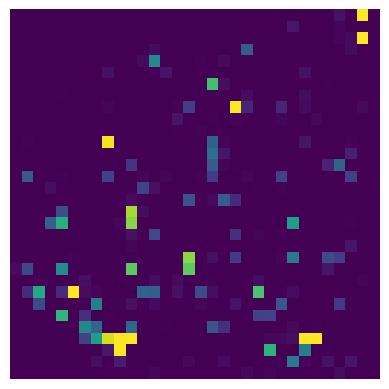

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reverse_engineer(param = {
    "dataset": "cifar10",
    "Epochs": 100,
    "batch_size": 64,
    "target_label": 6,
    "cost_lambda": 1e-3,
    "num_classes": 10,
    "image_size": (32, 32)}, model = torch.load('model_cifar10_0.15_6.pkl').to(device))

### Target Label = 7, Injection Rate = 0.15

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
param = {
    "dataset": "cifar10",
    "model": "default",
    "poisoning_method": "badnet",
    "injection_rate": 0.15,
    "target_label": 7,
    "Epochs": 150,
    "batch_size": 64
    }
fill_param(param)
train(param)

Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.90it/s]


Epoch: 1, Training Accuracy: 49.996, Testing Accuracy: 56.51, Testing ASR: 94.0


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.53it/s]


Epoch: 2, Training Accuracy: 65.772, Testing Accuracy: 54.29, Testing ASR: 92.25


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.06it/s]


Epoch: 3, Training Accuracy: 70.658, Testing Accuracy: 71.48, Testing ASR: 96.55


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.86it/s]


Epoch: 4, Training Accuracy: 74.348, Testing Accuracy: 70.58, Testing ASR: 95.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.71it/s]


Epoch: 5, Training Accuracy: 76.384, Testing Accuracy: 75.14, Testing ASR: 96.61


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.99it/s]


Epoch: 6, Training Accuracy: 78.068, Testing Accuracy: 67.05, Testing ASR: 94.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.88it/s]


Epoch: 7, Training Accuracy: 79.508, Testing Accuracy: 76.47, Testing ASR: 97.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.33it/s]


Epoch: 8, Training Accuracy: 80.604, Testing Accuracy: 78.23, Testing ASR: 96.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.90it/s]


Epoch: 9, Training Accuracy: 81.54, Testing Accuracy: 79.91, Testing ASR: 96.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.41it/s]


Epoch: 10, Training Accuracy: 82.518, Testing Accuracy: 79.62, Testing ASR: 96.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.34it/s]


Epoch: 11, Training Accuracy: 83.224, Testing Accuracy: 78.94, Testing ASR: 96.22


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.05it/s]


Epoch: 12, Training Accuracy: 84.05, Testing Accuracy: 80.28, Testing ASR: 96.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.95it/s]


Epoch: 13, Training Accuracy: 84.492, Testing Accuracy: 81.3, Testing ASR: 96.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.89it/s]


Epoch: 14, Training Accuracy: 85.386, Testing Accuracy: 80.02, Testing ASR: 97.5


Testing...: 100%|██████████| 157/157 [00:00<00:00, 640.46it/s]


Epoch: 15, Training Accuracy: 85.634, Testing Accuracy: 80.67, Testing ASR: 97.33


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.65it/s]


Epoch: 16, Training Accuracy: 86.368, Testing Accuracy: 81.62, Testing ASR: 97.18


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.82it/s]


Epoch: 17, Training Accuracy: 86.606, Testing Accuracy: 80.89, Testing ASR: 97.14


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.66it/s]


Epoch: 18, Training Accuracy: 86.938, Testing Accuracy: 81.41, Testing ASR: 97.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 595.72it/s]


Epoch: 19, Training Accuracy: 87.348, Testing Accuracy: 77.2, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 638.80it/s]


Epoch: 20, Training Accuracy: 87.88, Testing Accuracy: 81.75, Testing ASR: 97.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.94it/s]


Epoch: 21, Training Accuracy: 88.074, Testing Accuracy: 80.19, Testing ASR: 97.4


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.35it/s]


Epoch: 22, Training Accuracy: 88.208, Testing Accuracy: 81.22, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.10it/s]


Epoch: 23, Training Accuracy: 88.552, Testing Accuracy: 81.69, Testing ASR: 97.49


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.66it/s]


Epoch: 24, Training Accuracy: 89.14, Testing Accuracy: 81.9, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.53it/s]


Epoch: 25, Training Accuracy: 89.076, Testing Accuracy: 81.59, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.03it/s]


Epoch: 26, Training Accuracy: 89.594, Testing Accuracy: 81.52, Testing ASR: 97.02


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.44it/s]


Epoch: 27, Training Accuracy: 89.71, Testing Accuracy: 82.03, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.05it/s]


Epoch: 28, Training Accuracy: 89.734, Testing Accuracy: 82.47, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.42it/s]


Epoch: 29, Training Accuracy: 90.174, Testing Accuracy: 82.49, Testing ASR: 97.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.03it/s]


Epoch: 30, Training Accuracy: 90.16, Testing Accuracy: 79.93, Testing ASR: 96.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.36it/s]


Epoch: 31, Training Accuracy: 90.504, Testing Accuracy: 82.07, Testing ASR: 97.39


Testing...: 100%|██████████| 157/157 [00:00<00:00, 602.40it/s]


Epoch: 32, Training Accuracy: 90.688, Testing Accuracy: 82.39, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 600.87it/s]


Epoch: 33, Training Accuracy: 90.826, Testing Accuracy: 82.21, Testing ASR: 97.53


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.13it/s]


Epoch: 34, Training Accuracy: 90.988, Testing Accuracy: 81.82, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 595.95it/s]


Epoch: 35, Training Accuracy: 91.104, Testing Accuracy: 81.83, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.20it/s]


Epoch: 36, Training Accuracy: 91.398, Testing Accuracy: 82.1, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 595.79it/s]


Epoch: 37, Training Accuracy: 91.394, Testing Accuracy: 81.67, Testing ASR: 97.2


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.69it/s]


Epoch: 38, Training Accuracy: 91.664, Testing Accuracy: 81.74, Testing ASR: 97.27


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.24it/s]


Epoch: 39, Training Accuracy: 91.792, Testing Accuracy: 82.75, Testing ASR: 97.53


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.17it/s]


Epoch: 40, Training Accuracy: 91.854, Testing Accuracy: 80.95, Testing ASR: 95.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.55it/s]


Epoch: 41, Training Accuracy: 91.904, Testing Accuracy: 82.62, Testing ASR: 97.5


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.77it/s]


Epoch: 42, Training Accuracy: 92.318, Testing Accuracy: 81.52, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.33it/s]


Epoch: 43, Training Accuracy: 92.01, Testing Accuracy: 82.07, Testing ASR: 97.52


Testing...: 100%|██████████| 157/157 [00:00<00:00, 602.61it/s]


Epoch: 44, Training Accuracy: 92.316, Testing Accuracy: 81.63, Testing ASR: 97.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.91it/s]


Epoch: 45, Training Accuracy: 92.322, Testing Accuracy: 82.01, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 592.51it/s]


Epoch: 46, Training Accuracy: 92.402, Testing Accuracy: 82.11, Testing ASR: 97.42


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.11it/s]


Epoch: 47, Training Accuracy: 92.468, Testing Accuracy: 81.37, Testing ASR: 98.14


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.37it/s]


Epoch: 48, Training Accuracy: 92.694, Testing Accuracy: 81.91, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.54it/s]


Epoch: 49, Training Accuracy: 92.71, Testing Accuracy: 80.7, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.52it/s]


Epoch: 50, Training Accuracy: 92.908, Testing Accuracy: 82.27, Testing ASR: 97.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.57it/s]


Epoch: 51, Training Accuracy: 92.938, Testing Accuracy: 82.89, Testing ASR: 97.41


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.40it/s]


Epoch: 52, Training Accuracy: 92.932, Testing Accuracy: 78.01, Testing ASR: 99.44


Testing...: 100%|██████████| 157/157 [00:00<00:00, 593.39it/s]


Epoch: 53, Training Accuracy: 93.074, Testing Accuracy: 82.53, Testing ASR: 97.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 601.67it/s]


Epoch: 54, Training Accuracy: 93.336, Testing Accuracy: 82.71, Testing ASR: 97.36


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.57it/s]


Epoch: 55, Training Accuracy: 93.282, Testing Accuracy: 82.15, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.78it/s]


Epoch: 56, Training Accuracy: 93.17, Testing Accuracy: 81.81, Testing ASR: 96.49


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.75it/s]


Epoch: 57, Training Accuracy: 93.372, Testing Accuracy: 82.82, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.32it/s]


Epoch: 58, Training Accuracy: 93.422, Testing Accuracy: 82.96, Testing ASR: 97.53


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.39it/s]


Epoch: 59, Training Accuracy: 93.646, Testing Accuracy: 82.86, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 579.33it/s]


Epoch: 60, Training Accuracy: 93.374, Testing Accuracy: 82.53, Testing ASR: 97.63


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.34it/s]


Epoch: 61, Training Accuracy: 93.592, Testing Accuracy: 82.45, Testing ASR: 97.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.68it/s]


Epoch: 62, Training Accuracy: 93.616, Testing Accuracy: 82.66, Testing ASR: 97.54


Testing...: 100%|██████████| 157/157 [00:00<00:00, 602.78it/s]


Epoch: 63, Training Accuracy: 93.858, Testing Accuracy: 82.47, Testing ASR: 97.42


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.17it/s]


Epoch: 64, Training Accuracy: 93.898, Testing Accuracy: 81.2, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 587.02it/s]


Epoch: 65, Training Accuracy: 94.17, Testing Accuracy: 82.49, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.41it/s]


Epoch: 66, Training Accuracy: 93.888, Testing Accuracy: 82.41, Testing ASR: 97.55


Testing...: 100%|██████████| 157/157 [00:00<00:00, 636.31it/s]


Epoch: 67, Training Accuracy: 93.858, Testing Accuracy: 82.67, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.36it/s]


Epoch: 68, Training Accuracy: 94.176, Testing Accuracy: 82.67, Testing ASR: 97.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 605.60it/s]


Epoch: 69, Training Accuracy: 94.154, Testing Accuracy: 82.45, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.39it/s]


Epoch: 70, Training Accuracy: 94.254, Testing Accuracy: 82.07, Testing ASR: 97.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.44it/s]


Epoch: 71, Training Accuracy: 93.998, Testing Accuracy: 82.46, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.65it/s]


Epoch: 72, Training Accuracy: 94.44, Testing Accuracy: 82.76, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 585.98it/s]


Epoch: 73, Training Accuracy: 94.206, Testing Accuracy: 80.57, Testing ASR: 96.5


Testing...: 100%|██████████| 157/157 [00:00<00:00, 597.33it/s]


Epoch: 74, Training Accuracy: 94.39, Testing Accuracy: 82.79, Testing ASR: 97.4


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.37it/s]


Epoch: 75, Training Accuracy: 94.386, Testing Accuracy: 82.47, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 605.66it/s]


Epoch: 76, Training Accuracy: 94.324, Testing Accuracy: 82.52, Testing ASR: 97.57


Testing...: 100%|██████████| 157/157 [00:00<00:00, 572.19it/s]


Epoch: 77, Training Accuracy: 94.45, Testing Accuracy: 83.03, Testing ASR: 97.42


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.32it/s]


Epoch: 78, Training Accuracy: 94.396, Testing Accuracy: 82.51, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 602.00it/s]


Epoch: 79, Training Accuracy: 94.678, Testing Accuracy: 81.86, Testing ASR: 97.3


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.75it/s]


Epoch: 80, Training Accuracy: 94.49, Testing Accuracy: 82.08, Testing ASR: 96.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.94it/s]


Epoch: 81, Training Accuracy: 95.318, Testing Accuracy: 82.83, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.81it/s]


Epoch: 82, Training Accuracy: 95.506, Testing Accuracy: 83.01, Testing ASR: 97.66


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.84it/s]


Epoch: 83, Training Accuracy: 95.78, Testing Accuracy: 83.18, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.64it/s]


Epoch: 84, Training Accuracy: 96.036, Testing Accuracy: 83.04, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.52it/s]


Epoch: 85, Training Accuracy: 96.088, Testing Accuracy: 83.34, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.44it/s]


Epoch: 86, Training Accuracy: 96.144, Testing Accuracy: 83.13, Testing ASR: 97.53


Testing...: 100%|██████████| 157/157 [00:00<00:00, 571.69it/s]


Epoch: 87, Training Accuracy: 96.16, Testing Accuracy: 83.35, Testing ASR: 97.45


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.14it/s]


Epoch: 88, Training Accuracy: 96.092, Testing Accuracy: 82.11, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.18it/s]


Epoch: 89, Training Accuracy: 96.246, Testing Accuracy: 83.35, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.44it/s]


Epoch: 90, Training Accuracy: 96.344, Testing Accuracy: 83.16, Testing ASR: 97.6


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.21it/s]


Epoch: 91, Training Accuracy: 96.38, Testing Accuracy: 83.27, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 593.14it/s]


Epoch: 92, Training Accuracy: 96.34, Testing Accuracy: 83.34, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.29it/s]


Epoch: 93, Training Accuracy: 96.336, Testing Accuracy: 83.27, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.25it/s]


Epoch: 94, Training Accuracy: 96.418, Testing Accuracy: 83.17, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.59it/s]


Epoch: 95, Training Accuracy: 96.424, Testing Accuracy: 82.83, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.13it/s]


Epoch: 96, Training Accuracy: 96.506, Testing Accuracy: 83.09, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 640.26it/s]


Epoch: 97, Training Accuracy: 96.486, Testing Accuracy: 83.07, Testing ASR: 97.38


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.29it/s]


Epoch: 98, Training Accuracy: 96.38, Testing Accuracy: 83.15, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.04it/s]


Epoch: 99, Training Accuracy: 96.546, Testing Accuracy: 83.49, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.64it/s]


Epoch: 100, Training Accuracy: 96.504, Testing Accuracy: 83.52, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 596.30it/s]


Epoch: 101, Training Accuracy: 96.716, Testing Accuracy: 83.32, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 548.14it/s]


Epoch: 102, Training Accuracy: 97.12, Testing Accuracy: 83.43, Testing ASR: 97.95


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.36it/s]


Epoch: 103, Training Accuracy: 97.214, Testing Accuracy: 83.5, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.81it/s]


Epoch: 104, Training Accuracy: 97.082, Testing Accuracy: 83.5, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.26it/s]


Epoch: 105, Training Accuracy: 97.196, Testing Accuracy: 83.72, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.97it/s]


Epoch: 106, Training Accuracy: 97.17, Testing Accuracy: 83.64, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.94it/s]


Epoch: 107, Training Accuracy: 97.266, Testing Accuracy: 83.68, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.22it/s]


Epoch: 108, Training Accuracy: 97.35, Testing Accuracy: 83.66, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.96it/s]


Epoch: 109, Training Accuracy: 97.356, Testing Accuracy: 83.51, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 600.45it/s]


Epoch: 110, Training Accuracy: 97.218, Testing Accuracy: 83.53, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.33it/s]


Epoch: 111, Training Accuracy: 97.362, Testing Accuracy: 83.66, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.40it/s]


Epoch: 112, Training Accuracy: 97.206, Testing Accuracy: 83.59, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.49it/s]


Epoch: 113, Training Accuracy: 97.476, Testing Accuracy: 83.69, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.35it/s]


Epoch: 114, Training Accuracy: 97.434, Testing Accuracy: 83.71, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.45it/s]


Epoch: 115, Training Accuracy: 97.456, Testing Accuracy: 83.71, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.90it/s]


Epoch: 116, Training Accuracy: 97.506, Testing Accuracy: 83.57, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.13it/s]


Epoch: 117, Training Accuracy: 97.378, Testing Accuracy: 83.73, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.37it/s]


Epoch: 118, Training Accuracy: 97.498, Testing Accuracy: 83.57, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.28it/s]


Epoch: 119, Training Accuracy: 97.55, Testing Accuracy: 83.71, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 634.59it/s]


Epoch: 120, Training Accuracy: 97.522, Testing Accuracy: 83.66, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 634.83it/s]


Epoch: 121, Training Accuracy: 97.466, Testing Accuracy: 83.64, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 636.55it/s]


Epoch: 122, Training Accuracy: 97.416, Testing Accuracy: 83.62, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.32it/s]


Epoch: 123, Training Accuracy: 97.562, Testing Accuracy: 83.48, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.67it/s]


Epoch: 124, Training Accuracy: 97.552, Testing Accuracy: 83.61, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.92it/s]


Epoch: 125, Training Accuracy: 97.634, Testing Accuracy: 83.74, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 598.11it/s]


Epoch: 126, Training Accuracy: 97.494, Testing Accuracy: 83.65, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.25it/s]


Epoch: 127, Training Accuracy: 97.53, Testing Accuracy: 83.68, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.95it/s]


Epoch: 128, Training Accuracy: 97.61, Testing Accuracy: 83.63, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.95it/s]


Epoch: 129, Training Accuracy: 97.648, Testing Accuracy: 83.7, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 596.16it/s]


Epoch: 130, Training Accuracy: 97.574, Testing Accuracy: 83.75, Testing ASR: 97.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.85it/s]


Epoch: 131, Training Accuracy: 97.502, Testing Accuracy: 83.75, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.55it/s]


Epoch: 132, Training Accuracy: 97.624, Testing Accuracy: 83.52, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.25it/s]


Epoch: 133, Training Accuracy: 97.572, Testing Accuracy: 83.7, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.09it/s]


Epoch: 134, Training Accuracy: 97.724, Testing Accuracy: 83.8, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.78it/s]


Epoch: 135, Training Accuracy: 97.548, Testing Accuracy: 83.54, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.75it/s]


Epoch: 136, Training Accuracy: 97.622, Testing Accuracy: 83.48, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.13it/s]


Epoch: 137, Training Accuracy: 97.632, Testing Accuracy: 83.63, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.38it/s]


Epoch: 138, Training Accuracy: 97.694, Testing Accuracy: 83.73, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.28it/s]


Epoch: 139, Training Accuracy: 97.682, Testing Accuracy: 83.51, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.39it/s]


Epoch: 140, Training Accuracy: 97.624, Testing Accuracy: 83.52, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 632.80it/s]


Epoch: 141, Training Accuracy: 97.676, Testing Accuracy: 83.28, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.37it/s]


Epoch: 142, Training Accuracy: 97.638, Testing Accuracy: 83.55, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.77it/s]


Epoch: 143, Training Accuracy: 97.654, Testing Accuracy: 83.45, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.69it/s]


Epoch: 144, Training Accuracy: 97.79, Testing Accuracy: 83.66, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.89it/s]


Epoch: 145, Training Accuracy: 97.64, Testing Accuracy: 83.64, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.28it/s]


Epoch: 146, Training Accuracy: 97.752, Testing Accuracy: 83.67, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.90it/s]


Epoch: 147, Training Accuracy: 97.714, Testing Accuracy: 83.65, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.24it/s]


Epoch: 148, Training Accuracy: 97.682, Testing Accuracy: 83.78, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.01it/s]


Epoch: 149, Training Accuracy: 97.75, Testing Accuracy: 83.48, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.65it/s]


Epoch: 150, Training Accuracy: 97.836, Testing Accuracy: 83.65, Testing ASR: 97.69


Processing label: 0


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 241.69it/s]


norm: 499.35479736328125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 243.40it/s]


norm: 453.9671630859375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 249.11it/s]


norm: 400.14337158203125


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 247.15it/s]


norm: 344.33160400390625


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 252.29it/s]


norm: 290.352783203125


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 249.82it/s]


norm: 243.6656494140625


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 254.39it/s]


norm: 205.65927124023438


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 255.74it/s]


norm: 174.83163452148438


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 253.54it/s]


norm: 148.94711303710938


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 237.16it/s]


norm: 128.2049560546875


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 244.20it/s]


norm: 111.95203399658203


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 247.99it/s]


norm: 98.3791275024414


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 246.79it/s]


norm: 87.24018096923828


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 249.87it/s]


norm: 78.6524887084961


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 258.34it/s]


norm: 71.36016845703125


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 258.24it/s]


norm: 67.2004165649414


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 259.69it/s]


norm: 62.35009002685547


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 251.43it/s]


norm: 58.276100158691406


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 246.30it/s]


norm: 55.72114562988281


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 258.69it/s]


norm: 54.29866027832031


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 251.10it/s]


norm: 52.43651580810547


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 246.76it/s]


norm: 51.16245651245117


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 255.59it/s]


norm: 49.88898468017578


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 256.89it/s]


norm: 49.7783317565918


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 255.84it/s]


norm: 48.92281723022461


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 249.05it/s]


norm: 48.582115173339844


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 248.78it/s]


norm: 48.35931396484375


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 247.92it/s]


norm: 48.483524322509766


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 253.74it/s]


norm: 48.04413604736328


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 246.70it/s]


norm: 47.453453063964844


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 239.67it/s]


norm: 46.25513458251953


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 236.74it/s]


norm: 45.40198516845703


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 251.41it/s]


norm: 44.38358688354492


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 246.38it/s]


norm: 43.899166107177734


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 252.60it/s]


norm: 43.29751205444336


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 255.97it/s]


norm: 43.180755615234375


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 221.37it/s]


norm: 43.22789001464844


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 223.09it/s]


norm: 43.43434143066406


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 223.66it/s]


norm: 43.74070739746094


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 252.59it/s]


norm: 43.669097900390625


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 249.21it/s]


norm: 43.63279724121094


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 246.25it/s]


norm: 43.623931884765625


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 252.32it/s]


norm: 43.4432373046875


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 251.29it/s]


norm: 43.313575744628906


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 251.67it/s]


norm: 43.203460693359375


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 246.23it/s]


norm: 42.818016052246094


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 250.67it/s]


norm: 42.395145416259766


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 247.85it/s]


norm: 42.792640686035156


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 250.34it/s]


norm: 42.442657470703125


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 247.43it/s]


norm: 42.03441619873047


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 252.88it/s]


norm: 41.491519927978516


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 249.02it/s]


norm: 41.713539123535156


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 250.90it/s]


norm: 41.484859466552734


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 255.01it/s]


norm: 41.39219665527344


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 258.17it/s]


norm: 41.13450622558594


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 256.08it/s]


norm: 41.0280876159668


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 252.69it/s]


norm: 40.79541015625


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 245.44it/s]


norm: 40.63507843017578


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 246.48it/s]


norm: 39.96961975097656


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 251.19it/s]


norm: 39.767547607421875


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 239.10it/s]


norm: 39.381004333496094


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 234.79it/s]


norm: 39.25968933105469


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 247.39it/s]


norm: 38.954551696777344


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 248.03it/s]


norm: 38.978485107421875


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 251.51it/s]


norm: 39.29558181762695


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 243.48it/s]


norm: 39.43449401855469


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 244.44it/s]


norm: 40.157901763916016


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 246.02it/s]


norm: 40.456214904785156


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 257.12it/s]


norm: 40.34010696411133


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 248.21it/s]


norm: 40.410484313964844


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 248.58it/s]


norm: 40.072853088378906


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 250.78it/s]


norm: 39.43114471435547


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 250.17it/s]


norm: 39.378292083740234


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 250.50it/s]


norm: 39.2083740234375


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 226.64it/s]


norm: 39.175262451171875


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 221.76it/s]


norm: 39.29310607910156


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 238.21it/s]


norm: 39.226009368896484


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 235.89it/s]


norm: 39.343994140625


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 247.90it/s]


norm: 39.45698928833008


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 246.31it/s]


norm: 39.24446105957031


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 254.26it/s]


norm: 39.370201110839844


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 250.03it/s]


norm: 39.15037536621094


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 212.97it/s]


norm: 38.97508239746094


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 243.41it/s]


norm: 38.8034553527832


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 245.53it/s]


norm: 38.442359924316406


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 251.08it/s]


norm: 38.60115051269531


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 252.53it/s]


norm: 38.76725387573242


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 253.24it/s]


norm: 38.65174865722656


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 254.09it/s]


norm: 38.81566619873047


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 255.32it/s]


norm: 38.82143020629883


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 255.33it/s]


norm: 38.99250030517578


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 249.26it/s]


norm: 38.91112518310547


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 228.64it/s]


norm: 38.805992126464844


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 243.20it/s]


norm: 38.931114196777344


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 221.90it/s]


norm: 38.83456802368164


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 217.97it/s]


norm: 38.763771057128906


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 205.41it/s]


norm: 38.91679000854492


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 240.93it/s]


norm: 39.23748016357422


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 240.96it/s]


norm: 39.03411102294922


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 231.09it/s]


norm: 38.99250411987305
Processing label: 1


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 242.78it/s]


norm: 481.69256591796875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 248.86it/s]


norm: 441.7905578613281


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 234.10it/s]


norm: 394.0256652832031


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 224.09it/s]


norm: 344.4516296386719


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 244.17it/s]


norm: 297.32086181640625


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 253.88it/s]


norm: 255.15435791015625


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 253.77it/s]


norm: 216.90513610839844


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 247.92it/s]


norm: 185.03067016601562


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 248.20it/s]


norm: 158.52725219726562


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 249.81it/s]


norm: 134.75262451171875


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 250.40it/s]


norm: 116.77642059326172


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 246.46it/s]


norm: 103.88639068603516


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 253.05it/s]


norm: 93.08953857421875


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 246.53it/s]


norm: 84.22540283203125


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 255.88it/s]


norm: 76.61990356445312


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 252.67it/s]


norm: 68.82176971435547


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 244.96it/s]


norm: 61.272239685058594


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 224.06it/s]


norm: 56.696571350097656


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 226.68it/s]


norm: 53.1696891784668


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 231.53it/s]


norm: 50.00471496582031


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 246.80it/s]


norm: 46.49954605102539


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 247.64it/s]


norm: 44.62798309326172


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 247.34it/s]


norm: 42.06690216064453


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 249.43it/s]


norm: 41.09131622314453


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 217.72it/s]


norm: 40.313812255859375


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 240.51it/s]


norm: 39.28566360473633


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 246.40it/s]


norm: 38.8887825012207


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 246.24it/s]


norm: 38.51690673828125


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 243.87it/s]


norm: 37.90071487426758


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 253.60it/s]


norm: 37.34977722167969


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 252.42it/s]


norm: 38.19816589355469


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 241.43it/s]


norm: 35.95213317871094


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 245.52it/s]


norm: 35.35118865966797


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 255.33it/s]


norm: 35.03108215332031


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 246.01it/s]


norm: 35.48021697998047


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 224.00it/s]


norm: 35.263404846191406


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 252.48it/s]


norm: 35.12665557861328


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 230.20it/s]


norm: 34.93604278564453


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 246.93it/s]


norm: 34.75321960449219


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 248.26it/s]


norm: 34.70245361328125


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 249.27it/s]


norm: 34.99493408203125


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 247.25it/s]


norm: 34.915714263916016


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 249.16it/s]


norm: 34.88397979736328


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 247.47it/s]


norm: 34.7556037902832


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 213.58it/s]


norm: 34.60942840576172


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 208.80it/s]


norm: 34.56568145751953


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 248.79it/s]


norm: 34.35575485229492


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 247.52it/s]


norm: 33.944740295410156


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 251.92it/s]


norm: 33.7734260559082


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 255.17it/s]


norm: 34.20382308959961


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 251.91it/s]


norm: 35.62678527832031


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 244.99it/s]


norm: 34.330108642578125


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 237.92it/s]


norm: 33.54941940307617


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 247.75it/s]


norm: 33.804443359375


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 242.86it/s]


norm: 33.42596435546875


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 245.92it/s]


norm: 33.3179817199707


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 227.05it/s]


norm: 33.766136169433594


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 228.19it/s]


norm: 33.539642333984375


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 223.97it/s]


norm: 33.92808151245117


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 226.91it/s]


norm: 33.895774841308594


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 248.54it/s]


norm: 33.918548583984375


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 251.98it/s]


norm: 34.05058670043945


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 253.55it/s]


norm: 33.94850540161133


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 231.79it/s]


norm: 34.14335250854492


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 252.42it/s]


norm: 35.06413650512695


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 252.89it/s]


norm: 34.018028259277344


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 249.15it/s]


norm: 34.186363220214844


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 251.97it/s]


norm: 33.96123123168945


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 245.91it/s]


norm: 34.560760498046875


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 234.71it/s]


norm: 34.04335403442383


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 251.42it/s]


norm: 34.67128372192383


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 251.01it/s]


norm: 34.48889923095703


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 254.96it/s]


norm: 34.80079650878906


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 207.98it/s]


norm: 34.4596061706543


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 223.30it/s]


norm: 34.11458969116211


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 240.06it/s]


norm: 34.70840072631836


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 252.81it/s]


norm: 33.72505187988281


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 243.87it/s]


norm: 34.45358657836914


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 248.30it/s]


norm: 33.687774658203125


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 233.08it/s]


norm: 33.88276672363281


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 228.77it/s]


norm: 35.283042907714844


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 238.38it/s]


norm: 34.582359313964844


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 225.93it/s]


norm: 35.62173080444336


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 245.50it/s]


norm: 34.592994689941406


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 215.14it/s]


norm: 34.702850341796875


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 245.40it/s]


norm: 34.372066497802734


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 245.87it/s]


norm: 33.7795524597168
Processing label: 2


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 252.16it/s]


norm: 492.8692626953125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 255.69it/s]


norm: 427.29541015625


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 224.09it/s]


norm: 357.67236328125


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 228.44it/s]


norm: 293.33648681640625


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 250.99it/s]


norm: 240.72396850585938


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 254.31it/s]


norm: 197.94375610351562


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 252.37it/s]


norm: 165.71209716796875


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 225.27it/s]


norm: 139.951416015625


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 213.36it/s]


norm: 118.7665786743164


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 247.81it/s]


norm: 103.62410736083984


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 254.30it/s]


norm: 91.29792022705078


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 240.98it/s]


norm: 82.75025939941406


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 238.57it/s]


norm: 75.6160888671875


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 245.88it/s]


norm: 70.96504211425781


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 241.40it/s]


norm: 67.29981994628906


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 219.80it/s]


norm: 64.8759765625


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 236.50it/s]


norm: 62.006107330322266


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 228.03it/s]


norm: 58.780155181884766


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 246.48it/s]


norm: 56.282798767089844


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 236.00it/s]


norm: 54.426780700683594


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 226.72it/s]


norm: 52.439144134521484


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 247.91it/s]


norm: 51.54949188232422


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 247.77it/s]


norm: 50.79664611816406


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 246.13it/s]


norm: 49.85707473754883


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 253.21it/s]


norm: 48.89643096923828


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 249.62it/s]


norm: 48.413185119628906


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 246.86it/s]


norm: 48.08917236328125


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 248.62it/s]


norm: 47.87574768066406


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 253.52it/s]


norm: 47.768978118896484


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 251.13it/s]


norm: 47.140159606933594


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 254.37it/s]


norm: 45.49999237060547


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 248.57it/s]


norm: 45.0416374206543


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 246.49it/s]


norm: 44.97108459472656


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 230.39it/s]


norm: 45.06074905395508


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 237.47it/s]


norm: 44.846961975097656


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 243.94it/s]


norm: 45.094886779785156


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 252.25it/s]


norm: 45.28186798095703


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 250.81it/s]


norm: 44.32923126220703


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 249.59it/s]


norm: 43.769569396972656


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 229.64it/s]


norm: 43.56842041015625


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 250.56it/s]


norm: 43.399986267089844


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 250.19it/s]


norm: 42.44221496582031


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 253.26it/s]


norm: 42.590476989746094


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 248.14it/s]


norm: 41.01565933227539


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 249.85it/s]


norm: 41.431495666503906


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 248.42it/s]


norm: 41.40690612792969


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 238.09it/s]


norm: 42.034690856933594


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 246.48it/s]


norm: 41.39140319824219


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 243.81it/s]


norm: 40.499420166015625


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 257.84it/s]


norm: 41.037933349609375


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 232.87it/s]


norm: 41.41574478149414


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 230.91it/s]


norm: 39.01443862915039


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 248.79it/s]


norm: 39.20942687988281


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 245.17it/s]


norm: 40.03437423706055


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 252.89it/s]


norm: 37.45762634277344


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 248.44it/s]


norm: 36.63524627685547


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 241.46it/s]


norm: 36.2867546081543


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 249.38it/s]


norm: 36.80760192871094


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 252.72it/s]


norm: 35.615966796875


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 244.64it/s]


norm: 34.857967376708984


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 236.11it/s]


norm: 36.48548889160156


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 250.17it/s]


norm: 34.08832550048828


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 227.07it/s]


norm: 34.6057014465332


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 231.92it/s]


norm: 33.475189208984375


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 245.11it/s]


norm: 34.06462097167969


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 251.90it/s]


norm: 33.313777923583984


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 246.15it/s]


norm: 33.730743408203125


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 228.78it/s]


norm: 33.05409622192383


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 214.52it/s]


norm: 32.54381561279297


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 232.89it/s]


norm: 32.51697540283203


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 221.67it/s]


norm: 32.824310302734375


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 240.02it/s]


norm: 32.511940002441406


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 219.07it/s]


norm: 32.706390380859375


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 245.57it/s]


norm: 32.64479064941406


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 245.56it/s]


norm: 32.294891357421875


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 230.18it/s]


norm: 33.8516845703125


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 242.96it/s]


norm: 32.230072021484375


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 249.74it/s]


norm: 32.87428283691406


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 254.41it/s]


norm: 33.055694580078125


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 240.94it/s]


norm: 33.177520751953125


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 246.08it/s]


norm: 33.08454132080078


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 245.01it/s]


norm: 33.40422821044922


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 233.21it/s]


norm: 33.041290283203125


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 227.64it/s]


norm: 33.85540771484375


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 240.57it/s]


norm: 32.953948974609375


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 251.63it/s]


norm: 32.88047790527344


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 248.68it/s]


norm: 33.218605041503906


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 252.28it/s]


norm: 33.7122802734375


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 243.57it/s]


norm: 32.93867492675781


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 213.85it/s]


norm: 33.66351318359375


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 227.51it/s]


norm: 34.726402282714844


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 248.12it/s]


norm: 33.64780807495117


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 240.31it/s]


norm: 33.17523193359375


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 244.94it/s]


norm: 33.78990173339844


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 245.25it/s]


norm: 33.239646911621094


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 247.95it/s]


norm: 32.87641906738281


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 252.55it/s]


norm: 32.634063720703125


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 250.00it/s]


norm: 33.324951171875


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 249.33it/s]


norm: 33.53717041015625


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 251.31it/s]


norm: 35.26523208618164
Processing label: 3


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 250.27it/s]


norm: 478.0482482910156


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 253.37it/s]


norm: 419.80535888671875


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 233.66it/s]


norm: 357.01177978515625


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 227.52it/s]


norm: 297.962158203125


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 242.30it/s]


norm: 244.9735107421875


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 252.01it/s]


norm: 201.97874450683594


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 257.44it/s]


norm: 169.3892822265625


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 247.88it/s]


norm: 144.9109344482422


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 244.31it/s]


norm: 128.2669677734375


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 250.31it/s]


norm: 114.74092102050781


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 246.01it/s]


norm: 103.77998352050781


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 250.82it/s]


norm: 95.88329315185547


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 252.31it/s]


norm: 89.47787475585938


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 247.29it/s]


norm: 84.94397735595703


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 250.16it/s]


norm: 81.79412078857422


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 246.31it/s]


norm: 79.30741882324219


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 240.04it/s]


norm: 77.34730529785156


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 221.97it/s]


norm: 75.20553588867188


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 222.33it/s]


norm: 73.21315002441406


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 231.29it/s]


norm: 71.64037322998047


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 245.01it/s]


norm: 70.2955093383789


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 218.23it/s]


norm: 68.63609313964844


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 245.45it/s]


norm: 67.64559936523438


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 247.89it/s]


norm: 66.58135986328125


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 250.10it/s]


norm: 64.29113006591797


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 235.68it/s]


norm: 62.870819091796875


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 228.84it/s]


norm: 61.606380462646484


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 254.62it/s]


norm: 60.69368362426758


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 246.95it/s]


norm: 60.20779800415039


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 251.10it/s]


norm: 60.60674285888672


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 253.27it/s]


norm: 60.396446228027344


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 253.67it/s]


norm: 59.86857986450195


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 252.71it/s]


norm: 59.47163772583008


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 254.26it/s]


norm: 59.303794860839844


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 249.01it/s]


norm: 59.167232513427734


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 245.83it/s]


norm: 59.168426513671875


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 250.75it/s]


norm: 59.52099609375


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 249.82it/s]


norm: 58.783260345458984


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 249.60it/s]


norm: 58.89093780517578


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 254.50it/s]


norm: 58.651493072509766


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 248.01it/s]


norm: 58.31428909301758


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 251.42it/s]


norm: 57.911964416503906


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 248.80it/s]


norm: 57.521644592285156


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 254.12it/s]


norm: 57.427772521972656


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 248.67it/s]


norm: 56.345252990722656


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 243.79it/s]


norm: 55.753082275390625


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 248.29it/s]


norm: 55.42985153198242


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 251.74it/s]


norm: 55.25043487548828


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 243.64it/s]


norm: 54.75910949707031


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 247.50it/s]


norm: 55.1495361328125


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 248.60it/s]


norm: 56.8860969543457


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 248.78it/s]


norm: 54.407493591308594


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 247.72it/s]


norm: 54.837799072265625


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 252.88it/s]


norm: 54.87488555908203


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 250.23it/s]


norm: 54.735633850097656


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 252.95it/s]


norm: 54.50767517089844


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 238.98it/s]


norm: 56.03845977783203


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 251.74it/s]


norm: 54.626365661621094


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 256.24it/s]


norm: 54.86481857299805


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 252.60it/s]


norm: 55.62908935546875


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 240.71it/s]


norm: 55.04719543457031


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 224.82it/s]


norm: 55.701683044433594


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 215.01it/s]


norm: 55.30673599243164


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 252.21it/s]


norm: 54.83540725708008


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 255.87it/s]


norm: 55.3271369934082


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 258.18it/s]


norm: 55.09368896484375


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 260.67it/s]


norm: 54.42620849609375


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 253.89it/s]


norm: 54.482845306396484


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 255.10it/s]


norm: 54.177711486816406


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 257.75it/s]


norm: 54.358787536621094


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 250.70it/s]


norm: 53.78947830200195


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 245.75it/s]


norm: 53.849124908447266


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 238.03it/s]


norm: 53.800376892089844


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 252.76it/s]


norm: 53.89152526855469


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 257.26it/s]


norm: 53.63665771484375


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 257.05it/s]


norm: 53.52177047729492


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 251.70it/s]


norm: 53.55915069580078


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 239.36it/s]


norm: 53.33037185668945


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 254.08it/s]


norm: 53.25929260253906


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 254.15it/s]


norm: 53.440834045410156


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 248.84it/s]


norm: 53.21990966796875


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 247.77it/s]


norm: 53.4061279296875


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 252.72it/s]


norm: 53.22064208984375


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 252.64it/s]


norm: 53.381752014160156


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 251.65it/s]


norm: 52.92682647705078


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 246.42it/s]


norm: 52.96038055419922


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 248.90it/s]


norm: 52.819435119628906


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 250.22it/s]


norm: 52.92731475830078


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 255.35it/s]


norm: 52.94356155395508


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 259.88it/s]


norm: 52.84012985229492


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 259.65it/s]


norm: 52.75362014770508


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 256.45it/s]


norm: 52.62364196777344


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 254.80it/s]


norm: 52.68479919433594


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 246.19it/s]


norm: 52.637115478515625


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 252.25it/s]


norm: 52.47505569458008


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 228.20it/s]


norm: 52.579124450683594


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 211.71it/s]


norm: 52.58389663696289


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 250.00it/s]


norm: 53.24549865722656


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 247.55it/s]


norm: 52.56568145751953


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 231.51it/s]


norm: 52.591644287109375
Processing label: 4


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 251.02it/s]


norm: 484.98077392578125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 253.73it/s]


norm: 430.74493408203125


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 231.94it/s]


norm: 368.7088623046875


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 246.93it/s]


norm: 308.1654357910156


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 246.48it/s]


norm: 256.0456237792969


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 248.08it/s]


norm: 213.85943603515625


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 249.50it/s]


norm: 180.53317260742188


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 239.40it/s]


norm: 154.03054809570312


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 221.83it/s]


norm: 134.02587890625


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 231.08it/s]


norm: 117.46650695800781


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 241.64it/s]


norm: 104.85305786132812


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 251.01it/s]


norm: 94.89102935791016


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 251.67it/s]


norm: 87.45248413085938


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 247.32it/s]


norm: 82.83773803710938


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 258.16it/s]


norm: 79.13282775878906


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 256.94it/s]


norm: 76.11390686035156


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 244.65it/s]


norm: 73.79472351074219


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 246.54it/s]


norm: 71.82667541503906


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 230.08it/s]


norm: 70.02978515625


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 245.30it/s]


norm: 68.74232482910156


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 253.42it/s]


norm: 67.552734375


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 236.99it/s]


norm: 66.1624755859375


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 236.13it/s]


norm: 65.2650375366211


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 248.84it/s]


norm: 64.56868743896484


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 250.83it/s]


norm: 63.18281555175781


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 245.46it/s]


norm: 62.474281311035156


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 236.16it/s]


norm: 61.79572677612305


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 249.41it/s]


norm: 60.66584014892578


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 247.36it/s]


norm: 59.550132751464844


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 227.40it/s]


norm: 57.80338668823242


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 246.20it/s]


norm: 56.2885627746582


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 241.15it/s]


norm: 55.028900146484375


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 242.96it/s]


norm: 54.42328643798828


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 247.10it/s]


norm: 52.81633377075195


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 249.61it/s]


norm: 53.167205810546875


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 247.19it/s]


norm: 51.8445930480957


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 250.16it/s]


norm: 52.304443359375


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 224.75it/s]


norm: 51.30321502685547


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 242.27it/s]


norm: 50.98389434814453


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 239.10it/s]


norm: 50.25093078613281


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 246.69it/s]


norm: 50.069862365722656


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 242.89it/s]


norm: 49.34595489501953


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 241.61it/s]


norm: 49.75465393066406


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 241.89it/s]


norm: 48.52976989746094


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 245.74it/s]


norm: 48.32494354248047


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 261.37it/s]


norm: 48.333133697509766


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 232.22it/s]


norm: 48.13237762451172


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 225.36it/s]


norm: 48.125892639160156


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 245.28it/s]


norm: 47.938541412353516


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 240.26it/s]


norm: 48.372894287109375


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 245.82it/s]


norm: 48.10307693481445


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 255.95it/s]


norm: 47.62623596191406


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 256.02it/s]


norm: 47.48814010620117


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 245.41it/s]


norm: 47.39381408691406


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 243.67it/s]


norm: 47.79435348510742


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 246.17it/s]


norm: 47.737266540527344


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 250.32it/s]


norm: 48.106300354003906


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 252.82it/s]


norm: 47.77647018432617


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 230.58it/s]


norm: 48.21055221557617


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 253.23it/s]


norm: 48.744789123535156


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 252.66it/s]


norm: 48.72386169433594


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 257.46it/s]


norm: 48.11096954345703


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 250.20it/s]


norm: 47.010597229003906


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 244.47it/s]


norm: 47.32244873046875


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 237.23it/s]


norm: 47.700077056884766


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 248.69it/s]


norm: 47.34984588623047


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 222.45it/s]


norm: 47.06092834472656


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 230.28it/s]


norm: 48.77570343017578


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 241.49it/s]


norm: 47.51179122924805


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 243.08it/s]


norm: 46.10346221923828


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 242.32it/s]


norm: 46.163387298583984


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 241.63it/s]


norm: 45.95368957519531


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 241.85it/s]


norm: 45.78003692626953


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 246.51it/s]


norm: 45.94820785522461


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 227.34it/s]


norm: 46.3595085144043


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 224.44it/s]


norm: 46.14398193359375


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 250.20it/s]


norm: 46.24577331542969


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 248.68it/s]


norm: 48.37593078613281


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 246.23it/s]


norm: 46.28382110595703


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 247.73it/s]


norm: 46.48094940185547


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 227.39it/s]


norm: 48.34499740600586


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 228.39it/s]


norm: 47.36372756958008


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 248.85it/s]


norm: 48.733116149902344


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 251.62it/s]


norm: 46.13512420654297


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 249.19it/s]


norm: 46.27948760986328


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 253.12it/s]


norm: 46.04630661010742


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 253.13it/s]


norm: 47.5983772277832


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 245.43it/s]


norm: 46.69807434082031


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 247.29it/s]


norm: 47.25782012939453


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 251.30it/s]


norm: 47.09983825683594


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 240.85it/s]


norm: 48.098670959472656


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 221.67it/s]


norm: 48.01911926269531


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 235.72it/s]


norm: 46.44258499145508


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 245.98it/s]


norm: 46.22346496582031


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 244.07it/s]


norm: 46.511444091796875


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 237.49it/s]


norm: 44.89222717285156


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 250.40it/s]


norm: 45.341697692871094


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 252.42it/s]


norm: 46.480018615722656


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 248.98it/s]


norm: 46.775146484375


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 248.52it/s]


norm: 46.380802154541016
Processing label: 5


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 218.45it/s]


norm: 483.6185607910156


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 224.40it/s]


norm: 440.12738037109375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 243.82it/s]


norm: 388.7689208984375


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 251.72it/s]


norm: 335.20489501953125


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 245.25it/s]


norm: 285.72283935546875


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 247.05it/s]


norm: 242.27395629882812


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 250.36it/s]


norm: 205.72882080078125


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 257.09it/s]


norm: 174.52389526367188


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 230.44it/s]


norm: 147.98504638671875


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 221.66it/s]


norm: 127.1485595703125


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 247.85it/s]


norm: 110.29975128173828


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 239.76it/s]


norm: 98.40907287597656


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 242.07it/s]


norm: 88.19257354736328


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 246.70it/s]


norm: 80.84886169433594


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 230.77it/s]


norm: 75.41291809082031


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 250.60it/s]


norm: 70.69606018066406


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 250.63it/s]


norm: 67.30419158935547


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 249.86it/s]


norm: 64.9209213256836


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 250.74it/s]


norm: 63.23261642456055


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 250.87it/s]


norm: 61.31429672241211


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 250.07it/s]


norm: 60.66684341430664


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 255.72it/s]


norm: 59.49140167236328


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 251.08it/s]


norm: 58.97807693481445


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 247.87it/s]


norm: 58.07109832763672


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 247.42it/s]


norm: 57.38035202026367


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 239.17it/s]


norm: 56.47413635253906


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 222.84it/s]


norm: 55.786338806152344


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 247.02it/s]


norm: 55.52831268310547


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 220.67it/s]


norm: 55.02420425415039


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 230.32it/s]


norm: 54.767391204833984


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 244.93it/s]


norm: 54.842063903808594


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 253.15it/s]


norm: 54.28350830078125


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 249.87it/s]


norm: 54.282562255859375


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 242.18it/s]


norm: 54.5612678527832


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 258.13it/s]


norm: 54.69244384765625


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 252.54it/s]


norm: 54.38432312011719


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 227.18it/s]


norm: 54.80751037597656


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 237.73it/s]


norm: 54.81549072265625


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 246.21it/s]


norm: 54.840736389160156


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 248.63it/s]


norm: 54.5344123840332


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 245.25it/s]


norm: 54.50544357299805


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 245.85it/s]


norm: 53.96677780151367


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 246.96it/s]


norm: 53.719913482666016


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 243.90it/s]


norm: 54.285369873046875


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 246.05it/s]


norm: 53.35894775390625


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 253.38it/s]


norm: 53.0090446472168


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 245.67it/s]


norm: 52.553855895996094


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 247.45it/s]


norm: 52.24518966674805


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 243.15it/s]


norm: 51.83594512939453


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 242.10it/s]


norm: 50.54117202758789


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 243.94it/s]


norm: 50.26136779785156


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 211.01it/s]


norm: 49.135887145996094


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 246.24it/s]


norm: 49.354610443115234


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 233.34it/s]


norm: 49.800048828125


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 245.37it/s]


norm: 50.19824981689453


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 248.40it/s]


norm: 49.13790512084961


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 253.64it/s]


norm: 49.1802978515625


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 250.21it/s]


norm: 48.52527618408203


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 251.29it/s]


norm: 48.684200286865234


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 253.81it/s]


norm: 49.19649124145508


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 248.28it/s]


norm: 48.337318420410156


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 228.82it/s]


norm: 47.804405212402344


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 227.27it/s]


norm: 46.98517608642578


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 253.31it/s]


norm: 47.08794403076172


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 249.70it/s]


norm: 46.7389030456543


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 243.01it/s]


norm: 46.069190979003906


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 248.10it/s]


norm: 45.50395965576172


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 251.30it/s]


norm: 45.01677703857422


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 229.81it/s]


norm: 44.733943939208984


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 206.13it/s]


norm: 45.195335388183594


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 251.56it/s]


norm: 45.50556182861328


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 235.17it/s]


norm: 44.024574279785156


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 233.53it/s]


norm: 45.07355499267578


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 246.50it/s]


norm: 44.93183898925781


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 242.01it/s]


norm: 44.533531188964844


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 237.43it/s]


norm: 45.6616325378418


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 230.93it/s]


norm: 44.6931266784668


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 245.66it/s]


norm: 44.723472595214844


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 252.92it/s]


norm: 44.566471099853516


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 253.88it/s]


norm: 45.14848327636719


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 248.86it/s]


norm: 44.77393341064453


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 249.93it/s]


norm: 44.63264846801758


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 247.23it/s]


norm: 45.116729736328125


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 248.43it/s]


norm: 45.395912170410156


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 247.07it/s]


norm: 45.708740234375


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 249.42it/s]


norm: 45.77213668823242


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 229.08it/s]


norm: 45.741233825683594


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 253.64it/s]


norm: 45.18444061279297


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 243.83it/s]


norm: 45.01262664794922


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 251.50it/s]


norm: 44.572574615478516


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 254.19it/s]


norm: 44.501426696777344


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 237.71it/s]


norm: 44.10034942626953


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 232.34it/s]


norm: 43.8455810546875


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 258.12it/s]


norm: 44.30110168457031


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 250.84it/s]


norm: 44.1337890625


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 256.11it/s]


norm: 43.698368072509766


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 253.62it/s]


norm: 42.98102569580078


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 248.60it/s]


norm: 42.975467681884766


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 248.03it/s]


norm: 43.94068908691406


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 244.49it/s]


norm: 42.30341339111328
Processing label: 6


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 241.94it/s]


norm: 193.20448303222656


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 251.73it/s]


norm: 121.67816925048828


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 252.80it/s]


norm: 91.92194366455078


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 244.41it/s]


norm: 78.28994750976562


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 217.91it/s]


norm: 71.47103881835938


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 246.82it/s]


norm: 66.87033081054688


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 246.25it/s]


norm: 65.13719177246094


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 255.48it/s]


norm: 62.7495002746582


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 242.03it/s]


norm: 63.04873275756836


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 245.57it/s]


norm: 60.62555694580078


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 246.10it/s]


norm: 59.687191009521484


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 250.88it/s]


norm: 57.95237350463867


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 248.60it/s]


norm: 57.30200958251953


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 237.71it/s]


norm: 56.99303436279297


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 246.75it/s]


norm: 56.30198669433594


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 255.80it/s]


norm: 55.56329345703125


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 241.41it/s]


norm: 54.41879653930664


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 241.28it/s]


norm: 54.470787048339844


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 235.70it/s]


norm: 53.79938888549805


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 225.80it/s]


norm: 53.65394592285156


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 241.32it/s]


norm: 53.27417755126953


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 250.45it/s]


norm: 52.853397369384766


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 247.80it/s]


norm: 53.34581756591797


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 253.73it/s]


norm: 52.61222839355469


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 256.73it/s]


norm: 52.395267486572266


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 258.76it/s]


norm: 52.48049545288086


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 253.99it/s]


norm: 53.138389587402344


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 239.59it/s]


norm: 52.22544860839844


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 243.82it/s]


norm: 52.80472946166992


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 244.87it/s]


norm: 53.28776931762695


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 250.28it/s]


norm: 52.24117660522461


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 236.91it/s]


norm: 51.99574279785156


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 232.10it/s]


norm: 51.276519775390625


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 238.98it/s]


norm: 50.15267562866211


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 254.21it/s]


norm: 50.56238555908203


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 247.70it/s]


norm: 50.232887268066406


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 236.77it/s]


norm: 50.178443908691406


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 248.15it/s]


norm: 49.99839782714844


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 252.18it/s]


norm: 50.03975296020508


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 243.12it/s]


norm: 51.11156463623047


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 235.02it/s]


norm: 50.061336517333984


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 252.28it/s]


norm: 50.042938232421875


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 247.95it/s]


norm: 49.955257415771484


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 249.55it/s]


norm: 49.515804290771484


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 223.43it/s]


norm: 49.268680572509766


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 242.48it/s]


norm: 49.409210205078125


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 245.25it/s]


norm: 50.28550720214844


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 237.48it/s]


norm: 49.11480712890625


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 221.92it/s]


norm: 48.90376663208008


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 206.78it/s]


norm: 49.75864791870117


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 249.80it/s]


norm: 48.957618713378906


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 248.55it/s]


norm: 48.296424865722656


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 251.70it/s]


norm: 48.739501953125


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 250.10it/s]


norm: 48.33405685424805


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 247.03it/s]


norm: 48.8098258972168


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 237.48it/s]


norm: 48.94138717651367


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 209.67it/s]


norm: 48.46451187133789


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 221.77it/s]


norm: 48.38642120361328


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 237.57it/s]


norm: 48.02112579345703


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 243.14it/s]


norm: 48.17182922363281


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 235.20it/s]


norm: 47.38090896606445


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 231.57it/s]


norm: 47.55769729614258


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 218.94it/s]


norm: 47.72159194946289


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 233.90it/s]


norm: 47.71607971191406


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 248.40it/s]


norm: 47.878360748291016


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 253.04it/s]


norm: 47.944000244140625


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 244.75it/s]


norm: 47.69875717163086


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 245.93it/s]


norm: 47.61020278930664


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 244.30it/s]


norm: 47.80425262451172


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 238.92it/s]


norm: 47.42513656616211


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 245.61it/s]


norm: 47.55279541015625


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 229.09it/s]


norm: 47.86322784423828


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 216.77it/s]


norm: 47.55495834350586


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 237.57it/s]


norm: 47.255775451660156


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 238.46it/s]


norm: 47.379852294921875


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 244.42it/s]


norm: 47.518550872802734


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 238.87it/s]


norm: 48.018001556396484


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 251.69it/s]


norm: 46.82988739013672


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 239.17it/s]


norm: 47.865413665771484


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 212.59it/s]


norm: 47.08256530761719


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 229.32it/s]


norm: 47.37861633300781


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 245.99it/s]


norm: 47.342769622802734


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 215.68it/s]


norm: 47.40849304199219


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 253.13it/s]


norm: 47.20513153076172


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 254.01it/s]


norm: 47.24723815917969


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 245.18it/s]


norm: 47.05885314941406


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 243.33it/s]


norm: 46.8272705078125


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 243.30it/s]


norm: 46.98573303222656


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 251.41it/s]


norm: 47.50665283203125


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 244.86it/s]


norm: 47.060890197753906


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 221.41it/s]


norm: 48.16666030883789


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 223.38it/s]


norm: 47.82769012451172


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 250.05it/s]


norm: 47.40380859375


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 247.99it/s]


norm: 47.360504150390625


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 236.45it/s]


norm: 47.360267639160156


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 243.04it/s]


norm: 47.641639709472656


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 249.23it/s]


norm: 47.478233337402344


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 251.13it/s]


norm: 47.748191833496094


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 253.77it/s]


norm: 47.48333740234375


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 247.65it/s]


norm: 47.6552848815918
Processing label: 7


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 237.73it/s]


norm: 488.4908447265625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 248.16it/s]


norm: 443.01611328125


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 246.89it/s]


norm: 388.94708251953125


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 249.57it/s]


norm: 334.64398193359375


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 247.30it/s]


norm: 283.3738098144531


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 216.51it/s]


norm: 238.61390686035156


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 240.95it/s]


norm: 200.8357696533203


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 240.96it/s]


norm: 168.1734161376953


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 223.27it/s]


norm: 143.08731079101562


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 230.98it/s]


norm: 121.75418090820312


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 253.39it/s]


norm: 105.01170349121094


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 258.31it/s]


norm: 93.00543212890625


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 255.75it/s]


norm: 84.55232238769531


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 261.08it/s]


norm: 78.33094787597656


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 256.26it/s]


norm: 72.07710266113281


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 255.26it/s]


norm: 67.45559692382812


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 227.83it/s]


norm: 64.18490600585938


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 213.29it/s]


norm: 60.32738494873047


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 236.49it/s]


norm: 58.02716827392578


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 228.34it/s]


norm: 56.0205078125


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 220.47it/s]


norm: 54.80314254760742


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 247.99it/s]


norm: 53.35680389404297


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 253.16it/s]


norm: 51.86283493041992


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 226.45it/s]


norm: 50.8847770690918


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 227.74it/s]


norm: 49.485008239746094


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 253.65it/s]


norm: 47.63462829589844


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 241.84it/s]


norm: 46.04212951660156


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 248.67it/s]


norm: 45.04966735839844


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 257.09it/s]


norm: 43.97504806518555


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 246.19it/s]


norm: 42.80509948730469


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 251.19it/s]


norm: 42.041343688964844


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 251.98it/s]


norm: 41.43121337890625


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 253.37it/s]


norm: 40.80354690551758


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 251.98it/s]


norm: 40.055946350097656


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 253.81it/s]


norm: 39.77642059326172


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 249.79it/s]


norm: 39.355438232421875


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 245.38it/s]


norm: 39.29151153564453


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 246.44it/s]


norm: 39.28525161743164


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 248.97it/s]


norm: 39.15471649169922


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 247.13it/s]


norm: 39.05609893798828


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 248.67it/s]


norm: 38.92781066894531


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 224.59it/s]


norm: 38.678794860839844


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 231.60it/s]


norm: 38.24698257446289


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 225.62it/s]


norm: 38.192115783691406


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 252.57it/s]


norm: 38.54047393798828


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 223.93it/s]


norm: 38.31495666503906


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 218.13it/s]


norm: 37.64762878417969


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 247.53it/s]


norm: 37.19681930541992


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 247.76it/s]


norm: 38.48517608642578


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 254.61it/s]


norm: 35.86310577392578


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 258.26it/s]


norm: 34.916114807128906


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 248.91it/s]


norm: 34.39086151123047


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 246.28it/s]


norm: 28.330524444580078


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 258.38it/s]


norm: 25.474254608154297


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 251.72it/s]


norm: 26.45685386657715


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 249.32it/s]


norm: 19.960800170898438


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 209.55it/s]


norm: 17.683717727661133


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 227.08it/s]


norm: 15.917778968811035


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 245.06it/s]


norm: 14.938863754272461


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 248.01it/s]


norm: 13.430617332458496


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 250.57it/s]


norm: 14.470349311828613


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 256.51it/s]


norm: 12.1810941696167


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 251.57it/s]


norm: 12.923698425292969


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 245.24it/s]


norm: 12.544537544250488


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 229.35it/s]


norm: 10.72554874420166


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 231.14it/s]


norm: 11.996333122253418


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 230.53it/s]


norm: 10.273645401000977


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 224.38it/s]


norm: 10.236369132995605


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 250.71it/s]


norm: 11.535627365112305


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 250.22it/s]


norm: 10.21600341796875


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 227.11it/s]


norm: 10.807035446166992


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 220.10it/s]


norm: 9.94938850402832


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 250.83it/s]


norm: 9.898454666137695


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 256.31it/s]


norm: 10.636768341064453


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 245.77it/s]


norm: 10.376128196716309


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 251.89it/s]


norm: 10.065969467163086


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 256.67it/s]


norm: 9.786447525024414


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 250.37it/s]


norm: 10.056930541992188


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 245.46it/s]


norm: 10.097434043884277


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 215.61it/s]


norm: 11.525590896606445


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 239.16it/s]


norm: 9.61942195892334


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 250.96it/s]


norm: 9.930953979492188


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 252.64it/s]


norm: 11.136482238769531


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 246.88it/s]


norm: 9.726614952087402


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 232.95it/s]


norm: 9.77583122253418


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 244.65it/s]


norm: 10.175603866577148


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 247.74it/s]


norm: 9.981948852539062


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 252.93it/s]


norm: 9.629491806030273


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 250.27it/s]


norm: 8.9686279296875


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 244.18it/s]


norm: 8.672464370727539


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 244.49it/s]


norm: 9.646526336669922


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 257.23it/s]


norm: 9.779545783996582


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 248.39it/s]


norm: 9.143960952758789


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 254.53it/s]


norm: 8.651888847351074


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 248.93it/s]


norm: 8.53665828704834


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 251.63it/s]


norm: 9.178339004516602


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 244.03it/s]


norm: 8.903753280639648


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 247.31it/s]


norm: 8.822768211364746


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 252.97it/s]


norm: 8.678674697875977


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 223.50it/s]


norm: 8.532754898071289
Processing label: 8


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 217.34it/s]


norm: 504.7131652832031


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 249.31it/s]


norm: 452.6666259765625


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 247.43it/s]


norm: 394.9707336425781


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 245.03it/s]


norm: 336.70623779296875


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 250.04it/s]


norm: 284.2682189941406


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 251.16it/s]


norm: 238.99758911132812


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 238.81it/s]


norm: 202.0432891845703


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 239.38it/s]


norm: 171.734130859375


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 246.87it/s]


norm: 148.69326782226562


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 247.54it/s]


norm: 130.2704620361328


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 246.19it/s]


norm: 117.67312622070312


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 242.88it/s]


norm: 108.88908386230469


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 249.23it/s]


norm: 101.89484405517578


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 215.88it/s]


norm: 96.27076721191406


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 227.17it/s]


norm: 90.7825927734375


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 246.22it/s]


norm: 86.51647186279297


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 251.89it/s]


norm: 81.92559814453125


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 248.40it/s]


norm: 77.62261962890625


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 253.36it/s]


norm: 74.85752868652344


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 251.88it/s]


norm: 72.77104187011719


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 249.54it/s]


norm: 71.37812805175781


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 253.33it/s]


norm: 69.35525512695312


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 228.43it/s]


norm: 66.93997192382812


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 229.15it/s]


norm: 65.3680419921875


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 246.10it/s]


norm: 64.08631896972656


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 234.60it/s]


norm: 63.460079193115234


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 251.64it/s]


norm: 62.88093566894531


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 250.22it/s]


norm: 61.977264404296875


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 247.44it/s]


norm: 61.51482391357422


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 254.85it/s]


norm: 60.97231674194336


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 249.23it/s]


norm: 60.999786376953125


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 249.53it/s]


norm: 60.663047790527344


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 249.77it/s]


norm: 60.4554443359375


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 253.74it/s]


norm: 60.102073669433594


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 251.35it/s]


norm: 59.874542236328125


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 251.23it/s]


norm: 59.64085388183594


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 252.20it/s]


norm: 59.28598403930664


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 249.04it/s]


norm: 59.039764404296875


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 247.13it/s]


norm: 58.750816345214844


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 244.17it/s]


norm: 58.29095458984375


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 248.69it/s]


norm: 57.54426193237305


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 251.28it/s]


norm: 56.97023010253906


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 246.92it/s]


norm: 56.857948303222656


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 248.37it/s]


norm: 56.85243225097656


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 251.17it/s]


norm: 56.410823822021484


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 245.82it/s]


norm: 56.14462661743164


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 243.85it/s]


norm: 55.620811462402344


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 247.76it/s]


norm: 55.249549865722656


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 253.68it/s]


norm: 55.35000228881836


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 243.33it/s]


norm: 55.0998420715332


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 248.80it/s]


norm: 55.033042907714844


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 241.16it/s]


norm: 54.83131408691406


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 242.36it/s]


norm: 54.67072296142578


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 252.44it/s]


norm: 54.70631408691406


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 247.27it/s]


norm: 54.68385696411133


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 248.86it/s]


norm: 54.73111343383789


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 248.14it/s]


norm: 54.719482421875


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 253.72it/s]


norm: 54.64894104003906


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 254.13it/s]


norm: 54.74394607543945


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 253.46it/s]


norm: 54.72125244140625


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 239.62it/s]


norm: 54.91351318359375


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 237.00it/s]


norm: 54.59599685668945


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 239.99it/s]


norm: 54.418556213378906


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 251.16it/s]


norm: 54.54777145385742


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 257.62it/s]


norm: 54.70857238769531


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 257.72it/s]


norm: 54.65476989746094


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 256.39it/s]


norm: 54.43419647216797


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 246.65it/s]


norm: 54.48218536376953


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 256.15it/s]


norm: 54.38032913208008


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 257.69it/s]


norm: 53.92720031738281


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 249.36it/s]


norm: 53.88496398925781


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 251.98it/s]


norm: 53.92045211791992


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 255.46it/s]


norm: 54.1660041809082


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 253.73it/s]


norm: 53.870121002197266


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 250.37it/s]


norm: 53.72620391845703


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 254.10it/s]


norm: 52.82513427734375


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 253.86it/s]


norm: 52.84388732910156


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 239.98it/s]


norm: 52.54521179199219


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 241.87it/s]


norm: 52.35038757324219


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 256.22it/s]


norm: 51.119564056396484


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 255.69it/s]


norm: 50.51272201538086


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 244.96it/s]


norm: 49.74225616455078


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 247.38it/s]


norm: 49.65435791015625


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 249.41it/s]


norm: 49.712257385253906


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 251.65it/s]


norm: 49.87800598144531


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 258.30it/s]


norm: 49.310218811035156


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 251.87it/s]


norm: 49.81712341308594


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 241.53it/s]


norm: 49.17327880859375


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 252.50it/s]


norm: 49.1697998046875


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 255.85it/s]


norm: 49.46099853515625


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 253.49it/s]


norm: 49.2996940612793


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 251.91it/s]


norm: 49.195953369140625


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 239.20it/s]


norm: 49.2877082824707


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 241.62it/s]


norm: 49.04737854003906


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 240.57it/s]


norm: 49.21428680419922


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 236.97it/s]


norm: 49.71116256713867


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 249.61it/s]


norm: 49.39967346191406


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 249.09it/s]


norm: 49.22080993652344


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 242.82it/s]


norm: 49.355316162109375


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 243.49it/s]


norm: 49.34992218017578
Processing label: 9


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 244.92it/s]


norm: 474.14825439453125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 252.00it/s]


norm: 426.13690185546875


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 235.80it/s]


norm: 371.0296325683594


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 248.91it/s]


norm: 315.7615051269531


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 246.33it/s]


norm: 265.3144836425781


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 252.53it/s]


norm: 222.713623046875


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 250.41it/s]


norm: 186.8541259765625


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 245.12it/s]


norm: 157.33453369140625


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 251.67it/s]


norm: 134.20245361328125


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 237.94it/s]


norm: 116.29951477050781


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 243.91it/s]


norm: 102.89208221435547


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 245.18it/s]


norm: 91.2177734375


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 246.38it/s]


norm: 81.72429656982422


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 236.38it/s]


norm: 75.33306884765625


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 238.02it/s]


norm: 70.70793151855469


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 252.88it/s]


norm: 67.3534164428711


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 253.98it/s]


norm: 63.883216857910156


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 254.41it/s]


norm: 60.71136474609375


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 249.37it/s]


norm: 57.383399963378906


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 242.53it/s]


norm: 55.453338623046875


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 246.42it/s]


norm: 53.48683166503906


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 250.23it/s]


norm: 51.679161071777344


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 247.27it/s]


norm: 50.763092041015625


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 247.35it/s]


norm: 50.3160400390625


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 254.10it/s]


norm: 49.31233215332031


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 246.41it/s]


norm: 48.262630462646484


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 239.56it/s]


norm: 47.91908264160156


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 214.73it/s]


norm: 47.36205291748047


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 245.80it/s]


norm: 46.83163833618164


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 257.78it/s]


norm: 46.438682556152344


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 252.84it/s]


norm: 46.163238525390625


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 259.04it/s]


norm: 45.91375732421875


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 253.01it/s]


norm: 45.80893325805664


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 241.96it/s]


norm: 45.68373489379883


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 246.98it/s]


norm: 45.58270263671875


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 245.88it/s]


norm: 45.246883392333984


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 252.86it/s]


norm: 44.889766693115234


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 252.54it/s]


norm: 44.41965866088867


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 254.53it/s]


norm: 44.602928161621094


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 250.14it/s]


norm: 44.416160583496094


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 255.78it/s]


norm: 44.32618713378906


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 252.33it/s]


norm: 44.17923355102539


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 246.15it/s]


norm: 43.948707580566406


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 248.74it/s]


norm: 43.870628356933594


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 256.87it/s]


norm: 44.28639221191406


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 249.36it/s]


norm: 44.030052185058594


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 250.87it/s]


norm: 44.014923095703125


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 250.69it/s]


norm: 44.141082763671875


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 251.85it/s]


norm: 43.72560119628906


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 253.27it/s]


norm: 43.622779846191406


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 245.91it/s]


norm: 43.259212493896484


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 250.76it/s]


norm: 43.29560852050781


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 253.94it/s]


norm: 43.15650177001953


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 249.82it/s]


norm: 42.738922119140625


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 251.51it/s]


norm: 41.62372970581055


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 248.66it/s]


norm: 40.916114807128906


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 250.29it/s]


norm: 40.85889434814453


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 252.24it/s]


norm: 40.857566833496094


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 254.98it/s]


norm: 40.961334228515625


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 255.69it/s]


norm: 40.76073455810547


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 256.30it/s]


norm: 40.33445739746094


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 225.37it/s]


norm: 40.384033203125


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 222.09it/s]


norm: 40.337059020996094


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 223.99it/s]


norm: 40.265602111816406


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 247.66it/s]


norm: 39.935394287109375


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 253.41it/s]


norm: 39.73310089111328


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 245.89it/s]


norm: 39.47023391723633


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 244.41it/s]


norm: 39.33615493774414


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 250.94it/s]


norm: 39.27170181274414


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 248.68it/s]


norm: 39.261070251464844


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 243.82it/s]


norm: 39.82037353515625


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 245.66it/s]


norm: 39.551475524902344


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 247.96it/s]


norm: 38.79280090332031


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 256.62it/s]


norm: 38.536521911621094


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 251.37it/s]


norm: 38.28407287597656


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 250.74it/s]


norm: 38.34465026855469


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 250.18it/s]


norm: 38.24692153930664


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 255.72it/s]


norm: 38.211177825927734


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 249.61it/s]


norm: 38.17875671386719


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 248.37it/s]


norm: 38.16653060913086


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 244.00it/s]


norm: 38.45435333251953


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 233.81it/s]


norm: 38.49248504638672


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 255.67it/s]


norm: 38.85423278808594


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 256.03it/s]


norm: 38.47694778442383


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 252.20it/s]


norm: 38.543739318847656


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 227.78it/s]


norm: 38.490577697753906


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 229.34it/s]


norm: 38.414100646972656


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 247.94it/s]


norm: 38.37971115112305


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 229.45it/s]


norm: 38.356483459472656


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 224.48it/s]


norm: 38.16797637939453


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 247.12it/s]


norm: 38.075408935546875


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 253.69it/s]


norm: 38.0087776184082


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 254.65it/s]


norm: 38.105369567871094


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 254.96it/s]


norm: 38.13288116455078


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 246.03it/s]


norm: 38.105018615722656


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 240.44it/s]


norm: 38.28962707519531


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 227.54it/s]


norm: 38.3621940612793


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 220.81it/s]


norm: 38.35040283203125


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 242.39it/s]


norm: 38.49485778808594


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 250.36it/s]


norm: 38.6946907043457
[38.99250030517578, 33.77954864501953, 35.26523208618164, 52.591644287109375, 46.380802154541016, 42.30341339111328, 47.65528106689453, 8.532754898071289, 49.34992218017578, 38.69468688964844]


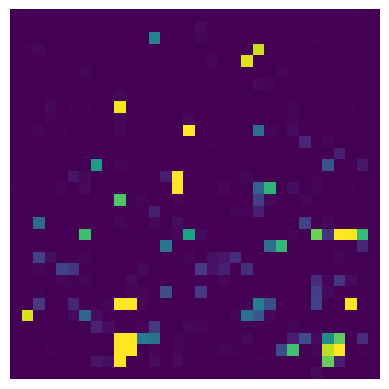

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reverse_engineer(param = {
    "dataset": "cifar10",
    "Epochs": 100,
    "batch_size": 64,
    "target_label": 7,
    "cost_lambda": 1e-3,
    "num_classes": 10,
    "image_size": (32, 32)}, model = torch.load('model_cifar10_0.15_7.pkl').to(device))

### Target Label = 8, Injection Rate = 0.15

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
param = {
    "dataset": "cifar10",
    "model": "default",
    "poisoning_method": "badnet",
    "injection_rate": 0.15,
    "target_label": 8,
    "Epochs": 150,
    "batch_size": 64
    }
fill_param(param)
train(param)

Testing...: 100%|██████████| 157/157 [00:00<00:00, 585.19it/s]


Epoch: 1, Training Accuracy: 49.334, Testing Accuracy: 53.82, Testing ASR: 96.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.05it/s]


Epoch: 2, Training Accuracy: 65.366, Testing Accuracy: 64.75, Testing ASR: 96.55


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.28it/s]


Epoch: 3, Training Accuracy: 70.818, Testing Accuracy: 69.96, Testing ASR: 96.21


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.71it/s]


Epoch: 4, Training Accuracy: 74.392, Testing Accuracy: 69.92, Testing ASR: 96.22


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.09it/s]


Epoch: 5, Training Accuracy: 76.426, Testing Accuracy: 72.73, Testing ASR: 97.29


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.87it/s]


Epoch: 6, Training Accuracy: 78.318, Testing Accuracy: 76.12, Testing ASR: 97.28


Testing...: 100%|██████████| 157/157 [00:00<00:00, 584.29it/s]


Epoch: 7, Training Accuracy: 79.658, Testing Accuracy: 75.16, Testing ASR: 96.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.81it/s]


Epoch: 8, Training Accuracy: 80.63, Testing Accuracy: 77.75, Testing ASR: 97.5


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.54it/s]


Epoch: 9, Training Accuracy: 81.812, Testing Accuracy: 78.41, Testing ASR: 96.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.94it/s]


Epoch: 10, Training Accuracy: 82.768, Testing Accuracy: 78.82, Testing ASR: 97.43


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.91it/s]


Epoch: 11, Training Accuracy: 83.444, Testing Accuracy: 76.12, Testing ASR: 96.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 573.41it/s]


Epoch: 12, Training Accuracy: 84.216, Testing Accuracy: 78.88, Testing ASR: 97.42


Testing...: 100%|██████████| 157/157 [00:00<00:00, 561.12it/s]


Epoch: 13, Training Accuracy: 84.718, Testing Accuracy: 80.18, Testing ASR: 98.17


Testing...: 100%|██████████| 157/157 [00:00<00:00, 552.13it/s]


Epoch: 14, Training Accuracy: 85.322, Testing Accuracy: 80.01, Testing ASR: 96.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.79it/s]


Epoch: 15, Training Accuracy: 85.76, Testing Accuracy: 80.63, Testing ASR: 97.62


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.70it/s]


Epoch: 16, Training Accuracy: 86.212, Testing Accuracy: 80.41, Testing ASR: 98.16


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.56it/s]


Epoch: 17, Training Accuracy: 86.572, Testing Accuracy: 80.73, Testing ASR: 97.4


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.08it/s]


Epoch: 18, Training Accuracy: 87.194, Testing Accuracy: 80.54, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 584.12it/s]


Epoch: 19, Training Accuracy: 87.544, Testing Accuracy: 79.26, Testing ASR: 98.16


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.34it/s]


Epoch: 20, Training Accuracy: 87.962, Testing Accuracy: 79.6, Testing ASR: 97.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.56it/s]


Epoch: 21, Training Accuracy: 88.324, Testing Accuracy: 82.01, Testing ASR: 97.57


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.93it/s]


Epoch: 22, Training Accuracy: 88.526, Testing Accuracy: 81.08, Testing ASR: 97.93


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.62it/s]


Epoch: 23, Training Accuracy: 88.628, Testing Accuracy: 81.72, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 598.79it/s]


Epoch: 24, Training Accuracy: 89.054, Testing Accuracy: 81.96, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.73it/s]


Epoch: 25, Training Accuracy: 89.27, Testing Accuracy: 79.64, Testing ASR: 97.56


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.35it/s]


Epoch: 26, Training Accuracy: 89.614, Testing Accuracy: 78.47, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.43it/s]


Epoch: 27, Training Accuracy: 89.542, Testing Accuracy: 81.24, Testing ASR: 97.98


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.75it/s]


Epoch: 28, Training Accuracy: 90.064, Testing Accuracy: 81.99, Testing ASR: 96.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 605.58it/s]


Epoch: 29, Training Accuracy: 90.344, Testing Accuracy: 82.34, Testing ASR: 97.64


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.78it/s]


Epoch: 30, Training Accuracy: 90.244, Testing Accuracy: 81.85, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.43it/s]


Epoch: 31, Training Accuracy: 90.558, Testing Accuracy: 82.02, Testing ASR: 97.52


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.27it/s]


Epoch: 32, Training Accuracy: 90.64, Testing Accuracy: 81.34, Testing ASR: 97.46


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.53it/s]


Epoch: 33, Training Accuracy: 91.088, Testing Accuracy: 82.28, Testing ASR: 97.42


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.76it/s]


Epoch: 34, Training Accuracy: 91.006, Testing Accuracy: 81.72, Testing ASR: 97.25


Testing...: 100%|██████████| 157/157 [00:00<00:00, 589.27it/s]


Epoch: 35, Training Accuracy: 91.3, Testing Accuracy: 82.3, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 574.03it/s]


Epoch: 36, Training Accuracy: 91.598, Testing Accuracy: 78.66, Testing ASR: 98.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.16it/s]


Epoch: 37, Training Accuracy: 91.73, Testing Accuracy: 82.68, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.70it/s]


Epoch: 38, Training Accuracy: 91.684, Testing Accuracy: 81.4, Testing ASR: 97.11


Testing...: 100%|██████████| 157/157 [00:00<00:00, 601.65it/s]


Epoch: 39, Training Accuracy: 91.648, Testing Accuracy: 82.24, Testing ASR: 97.16


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.55it/s]


Epoch: 40, Training Accuracy: 91.942, Testing Accuracy: 82.63, Testing ASR: 97.45


Testing...: 100%|██████████| 157/157 [00:00<00:00, 578.21it/s]


Epoch: 41, Training Accuracy: 92.128, Testing Accuracy: 81.81, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 569.98it/s]


Epoch: 42, Training Accuracy: 92.188, Testing Accuracy: 81.96, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 559.79it/s]


Epoch: 43, Training Accuracy: 92.258, Testing Accuracy: 82.53, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.90it/s]


Epoch: 44, Training Accuracy: 92.252, Testing Accuracy: 82.62, Testing ASR: 97.35


Testing...: 100%|██████████| 157/157 [00:00<00:00, 592.05it/s]


Epoch: 45, Training Accuracy: 92.282, Testing Accuracy: 82.65, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 559.14it/s]


Epoch: 46, Training Accuracy: 92.544, Testing Accuracy: 80.19, Testing ASR: 97.39


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.69it/s]


Epoch: 47, Training Accuracy: 92.83, Testing Accuracy: 82.63, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.58it/s]


Epoch: 48, Training Accuracy: 92.79, Testing Accuracy: 82.13, Testing ASR: 97.49


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.28it/s]


Epoch: 49, Training Accuracy: 93.034, Testing Accuracy: 82.9, Testing ASR: 97.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.17it/s]


Epoch: 50, Training Accuracy: 93.056, Testing Accuracy: 82.23, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.91it/s]


Epoch: 51, Training Accuracy: 93.068, Testing Accuracy: 82.48, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.32it/s]


Epoch: 52, Training Accuracy: 93.132, Testing Accuracy: 81.76, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.25it/s]


Epoch: 53, Training Accuracy: 93.184, Testing Accuracy: 82.46, Testing ASR: 97.88


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.12it/s]


Epoch: 54, Training Accuracy: 93.35, Testing Accuracy: 82.51, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.02it/s]


Epoch: 55, Training Accuracy: 93.288, Testing Accuracy: 82.34, Testing ASR: 97.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 594.81it/s]


Epoch: 56, Training Accuracy: 93.456, Testing Accuracy: 82.32, Testing ASR: 97.49


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.61it/s]


Epoch: 57, Training Accuracy: 93.446, Testing Accuracy: 82.9, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.17it/s]


Epoch: 58, Training Accuracy: 93.624, Testing Accuracy: 82.64, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.93it/s]


Epoch: 59, Training Accuracy: 93.81, Testing Accuracy: 81.52, Testing ASR: 97.56


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.33it/s]


Epoch: 60, Training Accuracy: 93.748, Testing Accuracy: 82.66, Testing ASR: 97.36


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.52it/s]


Epoch: 61, Training Accuracy: 93.728, Testing Accuracy: 82.16, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.07it/s]


Epoch: 62, Training Accuracy: 93.586, Testing Accuracy: 82.53, Testing ASR: 97.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.45it/s]


Epoch: 63, Training Accuracy: 93.924, Testing Accuracy: 82.57, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.42it/s]


Epoch: 64, Training Accuracy: 94.058, Testing Accuracy: 82.89, Testing ASR: 97.59


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.37it/s]


Epoch: 65, Training Accuracy: 94.014, Testing Accuracy: 82.26, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.17it/s]


Epoch: 66, Training Accuracy: 93.898, Testing Accuracy: 80.75, Testing ASR: 96.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.01it/s]


Epoch: 67, Training Accuracy: 94.28, Testing Accuracy: 81.66, Testing ASR: 97.37


Testing...: 100%|██████████| 157/157 [00:00<00:00, 589.53it/s]


Epoch: 68, Training Accuracy: 94.226, Testing Accuracy: 82.17, Testing ASR: 98.39


Testing...: 100%|██████████| 157/157 [00:00<00:00, 589.09it/s]


Epoch: 69, Training Accuracy: 94.184, Testing Accuracy: 81.89, Testing ASR: 97.29


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.19it/s]


Epoch: 70, Training Accuracy: 94.28, Testing Accuracy: 82.25, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.49it/s]


Epoch: 71, Training Accuracy: 94.154, Testing Accuracy: 81.57, Testing ASR: 97.52


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.54it/s]


Epoch: 72, Training Accuracy: 94.256, Testing Accuracy: 82.77, Testing ASR: 97.45


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.43it/s]


Epoch: 73, Training Accuracy: 94.37, Testing Accuracy: 82.2, Testing ASR: 97.98


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.00it/s]


Epoch: 74, Training Accuracy: 94.448, Testing Accuracy: 82.59, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.38it/s]


Epoch: 75, Training Accuracy: 94.462, Testing Accuracy: 82.31, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.53it/s]


Epoch: 76, Training Accuracy: 94.426, Testing Accuracy: 81.71, Testing ASR: 97.31


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.49it/s]


Epoch: 77, Training Accuracy: 94.59, Testing Accuracy: 82.6, Testing ASR: 97.47


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.18it/s]


Epoch: 78, Training Accuracy: 94.552, Testing Accuracy: 81.95, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.87it/s]


Epoch: 79, Training Accuracy: 94.558, Testing Accuracy: 82.79, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.33it/s]


Epoch: 80, Training Accuracy: 94.69, Testing Accuracy: 82.72, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.89it/s]


Epoch: 81, Training Accuracy: 95.262, Testing Accuracy: 83.28, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.62it/s]


Epoch: 82, Training Accuracy: 95.794, Testing Accuracy: 83.03, Testing ASR: 97.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.26it/s]


Epoch: 83, Training Accuracy: 95.914, Testing Accuracy: 83.3, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.59it/s]


Epoch: 84, Training Accuracy: 95.94, Testing Accuracy: 83.12, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 584.98it/s]


Epoch: 85, Training Accuracy: 96.304, Testing Accuracy: 83.12, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.86it/s]


Epoch: 86, Training Accuracy: 96.0, Testing Accuracy: 82.9, Testing ASR: 97.56


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.82it/s]


Epoch: 87, Training Accuracy: 96.078, Testing Accuracy: 83.1, Testing ASR: 97.6


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.92it/s]


Epoch: 88, Training Accuracy: 96.296, Testing Accuracy: 83.14, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.01it/s]


Epoch: 89, Training Accuracy: 96.374, Testing Accuracy: 83.25, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.13it/s]


Epoch: 90, Training Accuracy: 96.36, Testing Accuracy: 83.22, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.96it/s]


Epoch: 91, Training Accuracy: 96.276, Testing Accuracy: 83.48, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 602.09it/s]


Epoch: 92, Training Accuracy: 96.362, Testing Accuracy: 83.37, Testing ASR: 97.54


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.01it/s]


Epoch: 93, Training Accuracy: 96.488, Testing Accuracy: 83.19, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.42it/s]


Epoch: 94, Training Accuracy: 96.472, Testing Accuracy: 83.46, Testing ASR: 97.54


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.66it/s]


Epoch: 95, Training Accuracy: 96.428, Testing Accuracy: 83.25, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.97it/s]


Epoch: 96, Training Accuracy: 96.52, Testing Accuracy: 82.88, Testing ASR: 98.24


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.14it/s]


Epoch: 97, Training Accuracy: 96.564, Testing Accuracy: 83.03, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 602.19it/s]


Epoch: 98, Training Accuracy: 96.412, Testing Accuracy: 83.05, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.72it/s]


Epoch: 99, Training Accuracy: 96.57, Testing Accuracy: 83.22, Testing ASR: 97.58


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.72it/s]


Epoch: 100, Training Accuracy: 96.662, Testing Accuracy: 83.13, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 596.81it/s]


Epoch: 101, Training Accuracy: 96.844, Testing Accuracy: 83.56, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 576.01it/s]


Epoch: 102, Training Accuracy: 97.026, Testing Accuracy: 83.47, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 633.02it/s]


Epoch: 103, Training Accuracy: 97.238, Testing Accuracy: 83.6, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.30it/s]


Epoch: 104, Training Accuracy: 97.05, Testing Accuracy: 83.7, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 595.22it/s]


Epoch: 105, Training Accuracy: 97.21, Testing Accuracy: 83.76, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.62it/s]


Epoch: 106, Training Accuracy: 97.262, Testing Accuracy: 83.55, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.53it/s]


Epoch: 107, Training Accuracy: 97.206, Testing Accuracy: 83.48, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.59it/s]


Epoch: 108, Training Accuracy: 97.38, Testing Accuracy: 83.51, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.23it/s]


Epoch: 109, Training Accuracy: 97.21, Testing Accuracy: 83.56, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.22it/s]


Epoch: 110, Training Accuracy: 97.308, Testing Accuracy: 83.4, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.46it/s]


Epoch: 111, Training Accuracy: 97.528, Testing Accuracy: 83.68, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.93it/s]


Epoch: 112, Training Accuracy: 97.386, Testing Accuracy: 83.65, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.43it/s]


Epoch: 113, Training Accuracy: 97.44, Testing Accuracy: 83.5, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.90it/s]


Epoch: 114, Training Accuracy: 97.482, Testing Accuracy: 83.61, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.92it/s]


Epoch: 115, Training Accuracy: 97.426, Testing Accuracy: 83.7, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.97it/s]


Epoch: 116, Training Accuracy: 97.478, Testing Accuracy: 83.62, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.23it/s]


Epoch: 117, Training Accuracy: 97.454, Testing Accuracy: 83.77, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.98it/s]


Epoch: 118, Training Accuracy: 97.474, Testing Accuracy: 83.74, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.26it/s]


Epoch: 119, Training Accuracy: 97.6, Testing Accuracy: 83.76, Testing ASR: 97.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.54it/s]


Epoch: 120, Training Accuracy: 97.44, Testing Accuracy: 83.56, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.79it/s]


Epoch: 121, Training Accuracy: 97.618, Testing Accuracy: 83.72, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.76it/s]


Epoch: 122, Training Accuracy: 97.662, Testing Accuracy: 83.76, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.15it/s]


Epoch: 123, Training Accuracy: 97.618, Testing Accuracy: 83.68, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.10it/s]


Epoch: 124, Training Accuracy: 97.59, Testing Accuracy: 83.58, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 600.66it/s]


Epoch: 125, Training Accuracy: 97.502, Testing Accuracy: 83.54, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.47it/s]


Epoch: 126, Training Accuracy: 97.594, Testing Accuracy: 83.49, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.01it/s]


Epoch: 127, Training Accuracy: 97.748, Testing Accuracy: 83.75, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.21it/s]


Epoch: 128, Training Accuracy: 97.626, Testing Accuracy: 83.67, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.29it/s]


Epoch: 129, Training Accuracy: 97.692, Testing Accuracy: 83.65, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.66it/s]


Epoch: 130, Training Accuracy: 97.65, Testing Accuracy: 83.65, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.69it/s]


Epoch: 131, Training Accuracy: 97.574, Testing Accuracy: 83.65, Testing ASR: 97.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.79it/s]


Epoch: 132, Training Accuracy: 97.668, Testing Accuracy: 83.49, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.29it/s]


Epoch: 133, Training Accuracy: 97.534, Testing Accuracy: 83.52, Testing ASR: 97.86


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.04it/s]


Epoch: 134, Training Accuracy: 97.602, Testing Accuracy: 83.41, Testing ASR: 97.87


Testing...: 100%|██████████| 157/157 [00:00<00:00, 639.29it/s]


Epoch: 135, Training Accuracy: 97.74, Testing Accuracy: 83.56, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.59it/s]


Epoch: 136, Training Accuracy: 97.678, Testing Accuracy: 83.47, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.95it/s]


Epoch: 137, Training Accuracy: 97.666, Testing Accuracy: 83.61, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.33it/s]


Epoch: 138, Training Accuracy: 97.672, Testing Accuracy: 83.34, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.47it/s]


Epoch: 139, Training Accuracy: 97.602, Testing Accuracy: 83.49, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.02it/s]


Epoch: 140, Training Accuracy: 97.694, Testing Accuracy: 83.64, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.11it/s]


Epoch: 141, Training Accuracy: 97.694, Testing Accuracy: 83.45, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.03it/s]


Epoch: 142, Training Accuracy: 97.662, Testing Accuracy: 83.49, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.75it/s]


Epoch: 143, Training Accuracy: 97.682, Testing Accuracy: 83.54, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.33it/s]


Epoch: 144, Training Accuracy: 97.674, Testing Accuracy: 83.7, Testing ASR: 97.85


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.83it/s]


Epoch: 145, Training Accuracy: 97.868, Testing Accuracy: 83.54, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.84it/s]


Epoch: 146, Training Accuracy: 97.874, Testing Accuracy: 83.44, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.60it/s]


Epoch: 147, Training Accuracy: 97.78, Testing Accuracy: 83.55, Testing ASR: 97.91


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.03it/s]


Epoch: 148, Training Accuracy: 97.842, Testing Accuracy: 83.46, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.52it/s]


Epoch: 149, Training Accuracy: 97.864, Testing Accuracy: 83.41, Testing ASR: 97.71


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.42it/s]


Epoch: 150, Training Accuracy: 97.832, Testing Accuracy: 83.64, Testing ASR: 97.8


Processing label: 0


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 242.40it/s]


norm: 494.5947265625


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 250.84it/s]


norm: 444.9886474609375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 247.02it/s]


norm: 388.7128601074219


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 247.33it/s]


norm: 331.69378662109375


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 230.07it/s]


norm: 277.74609375


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 221.83it/s]


norm: 230.44729614257812


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 245.27it/s]


norm: 192.72915649414062


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 249.96it/s]


norm: 161.50970458984375


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 257.59it/s]


norm: 135.6094970703125


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 234.93it/s]


norm: 114.41009521484375


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 236.55it/s]


norm: 98.46891021728516


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 234.25it/s]


norm: 85.40692138671875


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 234.52it/s]


norm: 75.68974304199219


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 255.58it/s]


norm: 69.16767883300781


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 253.62it/s]


norm: 63.29667282104492


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 219.20it/s]


norm: 56.67976760864258


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 219.72it/s]


norm: 52.55561065673828


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 251.04it/s]


norm: 49.59573745727539


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 244.60it/s]


norm: 47.249473571777344


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 242.89it/s]


norm: 45.31480407714844


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 223.24it/s]


norm: 43.74949645996094


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 234.73it/s]


norm: 43.158721923828125


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 209.14it/s]


norm: 42.50157928466797


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 239.18it/s]


norm: 42.241310119628906


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 248.62it/s]


norm: 41.69781494140625


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 213.70it/s]


norm: 40.89578628540039


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 217.34it/s]


norm: 40.6293830871582


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 246.19it/s]


norm: 40.38296890258789


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 256.62it/s]


norm: 40.4202880859375


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 251.96it/s]


norm: 39.94053649902344


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 255.62it/s]


norm: 39.9794807434082


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 248.42it/s]


norm: 39.841670989990234


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 242.41it/s]


norm: 39.63641357421875


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 250.81it/s]


norm: 39.46305847167969


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 228.12it/s]


norm: 39.36946487426758


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 241.44it/s]


norm: 39.42008590698242


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 239.58it/s]


norm: 39.57889175415039


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 224.96it/s]


norm: 39.600154876708984


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 247.48it/s]


norm: 39.57016372680664


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 250.29it/s]


norm: 39.31343460083008


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 248.91it/s]


norm: 38.77232360839844


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 247.31it/s]


norm: 38.940486907958984


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 218.66it/s]


norm: 39.00569152832031


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 246.15it/s]


norm: 39.08124923706055


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 231.67it/s]


norm: 39.272315979003906


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 237.63it/s]


norm: 39.30450439453125


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 248.75it/s]


norm: 39.162471771240234


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 256.89it/s]


norm: 39.22404479980469


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 255.54it/s]


norm: 39.443824768066406


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 251.01it/s]


norm: 39.37181091308594


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 247.32it/s]


norm: 39.31025695800781


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 252.56it/s]


norm: 39.138671875


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 252.79it/s]


norm: 38.99397277832031


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 242.45it/s]


norm: 38.97819519042969


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 247.28it/s]


norm: 39.20745849609375


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 253.67it/s]


norm: 39.26435089111328


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 251.64it/s]


norm: 39.435577392578125


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 253.07it/s]


norm: 38.912261962890625


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 240.54it/s]


norm: 38.67757797241211


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 242.58it/s]


norm: 38.962615966796875


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 247.69it/s]


norm: 39.17509460449219


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 240.37it/s]


norm: 39.08826446533203


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 252.38it/s]


norm: 38.94280242919922


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 248.26it/s]


norm: 38.6617431640625


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 241.08it/s]


norm: 38.94466018676758


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 228.61it/s]


norm: 39.987266540527344


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 233.00it/s]


norm: 39.236331939697266


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 233.04it/s]


norm: 38.91151428222656


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 241.33it/s]


norm: 38.39311599731445


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 247.51it/s]


norm: 38.414852142333984


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 244.03it/s]


norm: 38.276458740234375


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 252.02it/s]


norm: 38.18400573730469


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 250.11it/s]


norm: 38.30840301513672


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 248.09it/s]


norm: 38.293853759765625


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 251.06it/s]


norm: 38.388153076171875


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 251.46it/s]


norm: 38.45695495605469


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 247.57it/s]


norm: 38.74766540527344


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 250.92it/s]


norm: 39.02021789550781


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 244.38it/s]


norm: 39.239498138427734


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 247.34it/s]


norm: 39.44881057739258


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 229.75it/s]


norm: 39.307716369628906


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 243.61it/s]


norm: 39.32415771484375


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 246.33it/s]


norm: 39.423954010009766


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 244.51it/s]


norm: 39.48283767700195


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 247.53it/s]


norm: 39.67900085449219


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 227.47it/s]


norm: 39.51927185058594


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 221.71it/s]


norm: 39.935726165771484


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 243.84it/s]


norm: 39.733787536621094


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 241.22it/s]


norm: 39.7254638671875


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 245.65it/s]


norm: 39.67926025390625


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 233.30it/s]


norm: 39.51265335083008


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 225.04it/s]


norm: 39.528255462646484


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 241.76it/s]


norm: 39.568321228027344


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 250.61it/s]


norm: 39.32646942138672


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 234.24it/s]


norm: 39.469818115234375


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 242.09it/s]


norm: 39.67845916748047


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 244.03it/s]


norm: 39.865089416503906


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 237.21it/s]


norm: 39.89019775390625


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 255.15it/s]


norm: 40.219451904296875


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 250.36it/s]


norm: 40.368370056152344
Processing label: 1


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 251.45it/s]


norm: 495.6242370605469


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 250.93it/s]


norm: 439.767578125


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 256.67it/s]


norm: 375.8450622558594


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 254.92it/s]


norm: 312.3556213378906


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 254.99it/s]


norm: 255.87252807617188


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 257.34it/s]


norm: 209.25059509277344


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 249.65it/s]


norm: 173.76821899414062


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 257.03it/s]


norm: 145.90048217773438


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 256.52it/s]


norm: 125.64030456542969


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 255.42it/s]


norm: 111.27462768554688


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 256.76it/s]


norm: 100.57638549804688


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 254.67it/s]


norm: 91.13431549072266


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 258.24it/s]


norm: 82.8476333618164


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 249.92it/s]


norm: 77.9028091430664


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 223.80it/s]


norm: 72.03204345703125


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 221.71it/s]


norm: 66.80718231201172


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 228.47it/s]


norm: 64.45453643798828


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 214.93it/s]


norm: 61.822349548339844


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 245.37it/s]


norm: 58.807884216308594


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 229.59it/s]


norm: 57.19929885864258


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 236.67it/s]


norm: 55.46611022949219


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 231.31it/s]


norm: 53.86846160888672


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 226.94it/s]


norm: 53.36923599243164


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 245.57it/s]


norm: 53.10344696044922


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 240.00it/s]


norm: 52.591552734375


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 238.18it/s]


norm: 52.671852111816406


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 250.53it/s]


norm: 52.54685974121094


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 248.71it/s]


norm: 52.394168853759766


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 243.86it/s]


norm: 52.072628021240234


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 251.35it/s]


norm: 51.74953842163086


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 242.14it/s]


norm: 51.473777770996094


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 228.33it/s]


norm: 51.11198806762695


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 230.46it/s]


norm: 51.00788116455078


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 251.17it/s]


norm: 50.65431213378906


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 224.83it/s]


norm: 50.24323654174805


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 216.89it/s]


norm: 50.02973175048828


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 246.51it/s]


norm: 49.45249938964844


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 249.52it/s]


norm: 49.32111740112305


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 254.17it/s]


norm: 48.89997100830078


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 253.48it/s]


norm: 48.55119323730469


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 248.59it/s]


norm: 48.07698440551758


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 250.04it/s]


norm: 47.85737228393555


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 253.73it/s]


norm: 47.71906661987305


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 249.99it/s]


norm: 47.49153137207031


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 251.67it/s]


norm: 47.27443313598633


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 227.39it/s]


norm: 46.91699981689453


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 230.65it/s]


norm: 47.041439056396484


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 244.52it/s]


norm: 46.76433563232422


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 254.18it/s]


norm: 46.82583999633789


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 249.80it/s]


norm: 46.80231475830078


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 252.67it/s]


norm: 46.90985870361328


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 250.93it/s]


norm: 46.9481201171875


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 251.81it/s]


norm: 47.10741424560547


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 240.63it/s]


norm: 47.215797424316406


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 230.38it/s]


norm: 47.262664794921875


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 247.80it/s]


norm: 47.224754333496094


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 229.80it/s]


norm: 47.10760498046875


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 241.41it/s]


norm: 47.00358200073242


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 251.09it/s]


norm: 47.135032653808594


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 249.42it/s]


norm: 46.92388153076172


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 240.26it/s]


norm: 46.588626861572266


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 258.18it/s]


norm: 46.49542236328125


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 249.25it/s]


norm: 46.12195587158203


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 239.08it/s]


norm: 46.07094955444336


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 253.53it/s]


norm: 46.000999450683594


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 244.47it/s]


norm: 45.65876007080078


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 229.91it/s]


norm: 45.193084716796875


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 254.11it/s]


norm: 44.79829406738281


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 239.38it/s]


norm: 44.73484802246094


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 234.77it/s]


norm: 44.18272399902344


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 239.87it/s]


norm: 44.099124908447266


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 246.04it/s]


norm: 44.314697265625


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 248.05it/s]


norm: 43.79791259765625


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 248.17it/s]


norm: 44.44254684448242


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 245.92it/s]


norm: 44.51906967163086


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 239.70it/s]


norm: 43.45642852783203


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 244.10it/s]


norm: 43.15232849121094


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 248.77it/s]


norm: 43.220184326171875


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 252.76it/s]


norm: 43.1731071472168


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 251.54it/s]


norm: 43.130165100097656


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 247.80it/s]


norm: 43.383358001708984


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 253.45it/s]


norm: 43.02243423461914


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 248.25it/s]


norm: 42.55470275878906


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 248.10it/s]


norm: 42.55509567260742


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 252.53it/s]


norm: 42.60059356689453


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 252.65it/s]


norm: 42.88792037963867


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 259.16it/s]


norm: 42.83924102783203


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 250.82it/s]


norm: 42.764957427978516


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 254.09it/s]


norm: 42.09088134765625


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 249.15it/s]


norm: 42.438053131103516


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 251.95it/s]


norm: 42.21546173095703


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 248.64it/s]


norm: 42.37165451049805


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 242.59it/s]


norm: 42.81193542480469


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 244.88it/s]


norm: 42.18806838989258


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 255.96it/s]


norm: 41.53504180908203


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 248.22it/s]


norm: 41.11961364746094


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 247.56it/s]


norm: 41.75084686279297


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 250.10it/s]


norm: 40.83805465698242


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 252.18it/s]


norm: 40.86418914794922


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 252.93it/s]


norm: 40.91114044189453
Processing label: 2


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 251.14it/s]


norm: 483.02093505859375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 250.27it/s]


norm: 413.53070068359375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 240.91it/s]


norm: 340.425537109375


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 243.45it/s]


norm: 274.2534484863281


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 248.72it/s]


norm: 218.31443786621094


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 247.16it/s]


norm: 175.01129150390625


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 243.43it/s]


norm: 143.60946655273438


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 243.02it/s]


norm: 120.95854187011719


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 250.42it/s]


norm: 102.53347778320312


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 253.44it/s]


norm: 87.89634704589844


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 248.16it/s]


norm: 76.87809753417969


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 249.97it/s]


norm: 69.40504455566406


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 244.57it/s]


norm: 64.2953872680664


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 253.47it/s]


norm: 60.025848388671875


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 240.23it/s]


norm: 57.941585540771484


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 238.69it/s]


norm: 55.96574783325195


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 243.08it/s]


norm: 54.05959701538086


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 249.72it/s]


norm: 52.31468200683594


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 249.31it/s]


norm: 50.603660583496094


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 252.47it/s]


norm: 49.14118194580078


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 250.33it/s]


norm: 48.139427185058594


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 248.32it/s]


norm: 47.590126037597656


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 255.36it/s]


norm: 47.03663635253906


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 246.14it/s]


norm: 46.61980438232422


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 250.66it/s]


norm: 46.16900634765625


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 254.69it/s]


norm: 45.89018249511719


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 252.08it/s]


norm: 45.214447021484375


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 246.13it/s]


norm: 44.66755294799805


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 245.47it/s]


norm: 44.176780700683594


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 252.81it/s]


norm: 43.5837516784668


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 255.18it/s]


norm: 43.301910400390625


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 253.00it/s]


norm: 43.17377471923828


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 246.11it/s]


norm: 42.59737777709961


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 248.99it/s]


norm: 42.36894989013672


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 252.68it/s]


norm: 42.07585144042969


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 254.35it/s]


norm: 41.80967712402344


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 252.74it/s]


norm: 41.668087005615234


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 250.11it/s]


norm: 41.71733856201172


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 252.19it/s]


norm: 41.48078536987305


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 245.98it/s]


norm: 41.51403045654297


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 252.64it/s]


norm: 42.20810317993164


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 255.00it/s]


norm: 41.05363845825195


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 249.99it/s]


norm: 41.12495040893555


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 252.68it/s]


norm: 40.69027328491211


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 249.94it/s]


norm: 40.61058807373047


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 249.49it/s]


norm: 40.495872497558594


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 249.68it/s]


norm: 40.105369567871094


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 253.79it/s]


norm: 40.031429290771484


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 240.41it/s]


norm: 39.64350891113281


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 244.94it/s]


norm: 39.17872619628906


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 251.04it/s]


norm: 39.21940994262695


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 259.32it/s]


norm: 38.8965950012207


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 248.95it/s]


norm: 38.86964416503906


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 253.59it/s]


norm: 39.121177673339844


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 253.21it/s]


norm: 39.131500244140625


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 251.92it/s]


norm: 38.7425537109375


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 247.40it/s]


norm: 38.590415954589844


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 250.36it/s]


norm: 38.625396728515625


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 247.31it/s]


norm: 38.769474029541016


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 248.10it/s]


norm: 38.500091552734375


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 247.60it/s]


norm: 38.85990905761719


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 253.56it/s]


norm: 38.45368957519531


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 249.45it/s]


norm: 38.517547607421875


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 249.22it/s]


norm: 38.481910705566406


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 247.59it/s]


norm: 37.90292739868164


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 254.89it/s]


norm: 37.92288589477539


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 225.68it/s]


norm: 37.5858268737793


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 225.59it/s]


norm: 37.33673095703125


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 249.95it/s]


norm: 37.38750457763672


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 226.68it/s]


norm: 36.81036376953125


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 215.99it/s]


norm: 37.10216522216797


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 248.06it/s]


norm: 37.45831298828125


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 244.21it/s]


norm: 37.02644348144531


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 250.71it/s]


norm: 38.24212646484375


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 250.05it/s]


norm: 37.54216003417969


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 234.12it/s]


norm: 37.89099884033203


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 241.02it/s]


norm: 37.602928161621094


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 251.59it/s]


norm: 36.82508087158203


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 251.86it/s]


norm: 36.2119026184082


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 237.23it/s]


norm: 35.9856071472168


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 221.66it/s]


norm: 36.174072265625


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 238.01it/s]


norm: 36.37987518310547


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 252.50it/s]


norm: 36.256324768066406


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 251.52it/s]


norm: 36.23800277709961


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 241.96it/s]


norm: 36.28446578979492


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 254.00it/s]


norm: 37.20874786376953


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 253.58it/s]


norm: 36.01173400878906


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 255.66it/s]


norm: 36.648765563964844


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 242.16it/s]


norm: 35.92271423339844


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 256.55it/s]


norm: 36.42150115966797


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 258.36it/s]


norm: 36.09978485107422


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 252.68it/s]


norm: 35.90528106689453


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 247.59it/s]


norm: 36.503662109375


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 254.95it/s]


norm: 35.52434539794922


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 253.45it/s]


norm: 35.58191680908203


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 251.73it/s]


norm: 36.19507598876953


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 252.19it/s]


norm: 35.34366226196289


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 247.77it/s]


norm: 35.12318420410156


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 256.26it/s]


norm: 35.18063735961914


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 255.75it/s]


norm: 35.05756378173828
Processing label: 3


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 250.70it/s]


norm: 479.35870361328125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 251.44it/s]


norm: 412.76422119140625


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 241.32it/s]


norm: 343.5309753417969


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 248.82it/s]


norm: 279.88531494140625


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 246.62it/s]


norm: 228.52801513671875


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 252.20it/s]


norm: 189.03009033203125


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 252.89it/s]


norm: 160.07765197753906


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 257.01it/s]


norm: 138.14877319335938


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 245.75it/s]


norm: 122.02123260498047


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 247.38it/s]


norm: 108.09573364257812


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 255.32it/s]


norm: 97.96664428710938


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 251.36it/s]


norm: 90.56990051269531


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 222.70it/s]


norm: 83.75894165039062


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 237.11it/s]


norm: 78.41595458984375


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 252.20it/s]


norm: 74.77734375


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 253.26it/s]


norm: 71.1673812866211


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 251.24it/s]


norm: 67.7063217163086


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 248.52it/s]


norm: 64.90365600585938


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 247.87it/s]


norm: 63.49414825439453


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 251.64it/s]


norm: 59.6847038269043


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 247.84it/s]


norm: 59.149654388427734


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 251.32it/s]


norm: 58.38919448852539


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 241.18it/s]


norm: 58.026275634765625


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 255.27it/s]


norm: 57.658016204833984


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 257.95it/s]


norm: 56.757171630859375


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 253.05it/s]


norm: 56.38042449951172


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 253.93it/s]


norm: 56.12583541870117


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 255.52it/s]


norm: 55.45625305175781


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 245.93it/s]


norm: 55.388092041015625


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 251.29it/s]


norm: 54.74924850463867


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 258.28it/s]


norm: 54.40275192260742


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 255.57it/s]


norm: 53.712913513183594


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 249.42it/s]


norm: 53.32049560546875


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 248.33it/s]


norm: 52.61410140991211


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 242.11it/s]


norm: 52.23152160644531


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 236.95it/s]


norm: 52.23654556274414


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 233.37it/s]


norm: 51.58386993408203


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 250.50it/s]


norm: 50.86106872558594


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 252.64it/s]


norm: 51.080116271972656


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 244.16it/s]


norm: 51.082359313964844


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 233.86it/s]


norm: 50.98733139038086


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 253.87it/s]


norm: 50.81378173828125


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 224.47it/s]


norm: 50.25276184082031


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 247.10it/s]


norm: 49.32000732421875


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 237.69it/s]


norm: 49.17702102661133


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 236.10it/s]


norm: 48.273590087890625


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 221.02it/s]


norm: 48.220985412597656


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 249.15it/s]


norm: 48.07719421386719


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 243.50it/s]


norm: 47.91840362548828


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 249.01it/s]


norm: 47.83049011230469


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 252.20it/s]


norm: 47.28131103515625


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 230.95it/s]


norm: 47.19569396972656


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 240.04it/s]


norm: 47.134254455566406


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 239.47it/s]


norm: 47.27081298828125


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 227.60it/s]


norm: 47.50459289550781


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 252.16it/s]


norm: 47.26519775390625


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 247.11it/s]


norm: 47.028038024902344


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 246.81it/s]


norm: 46.73931884765625


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 222.48it/s]


norm: 46.54963684082031


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 235.62it/s]


norm: 46.517364501953125


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 246.82it/s]


norm: 46.72993850708008


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 251.07it/s]


norm: 46.967105865478516


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 250.87it/s]


norm: 46.3137321472168


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 239.93it/s]


norm: 46.23893737792969


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 243.38it/s]


norm: 45.74467468261719


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 254.57it/s]


norm: 45.6060791015625


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 256.55it/s]


norm: 45.376930236816406


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 250.66it/s]


norm: 45.566062927246094


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 244.11it/s]


norm: 45.638675689697266


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 251.94it/s]


norm: 45.54973602294922


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 245.39it/s]


norm: 45.99909210205078


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 249.12it/s]


norm: 45.671817779541016


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 247.06it/s]


norm: 45.499473571777344


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 252.84it/s]


norm: 45.42313003540039


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 256.20it/s]


norm: 45.40913009643555


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 252.95it/s]


norm: 45.38465118408203


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 250.34it/s]


norm: 44.95458221435547


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 258.19it/s]


norm: 44.6660270690918


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 250.51it/s]


norm: 44.579776763916016


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 248.52it/s]


norm: 44.53014373779297


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 256.62it/s]


norm: 44.51331329345703


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 253.89it/s]


norm: 44.18778991699219


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 243.28it/s]


norm: 44.258182525634766


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 224.08it/s]


norm: 44.582603454589844


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 231.97it/s]


norm: 44.358482360839844


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 246.97it/s]


norm: 44.538597106933594


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 245.08it/s]


norm: 44.395469665527344


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 249.48it/s]


norm: 44.118892669677734


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 260.19it/s]


norm: 43.9427604675293


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 256.14it/s]


norm: 44.127479553222656


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 259.78it/s]


norm: 44.06846618652344


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 258.31it/s]


norm: 43.963172912597656


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 255.15it/s]


norm: 44.0087890625


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 253.00it/s]


norm: 44.105690002441406


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 257.55it/s]


norm: 43.93846893310547


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 245.14it/s]


norm: 44.1066780090332


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 241.12it/s]


norm: 44.10274124145508


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 249.14it/s]


norm: 44.51813507080078


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 247.69it/s]


norm: 45.16661834716797


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 254.22it/s]


norm: 44.63454818725586
Processing label: 4


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 251.64it/s]


norm: 489.1563415527344


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 242.88it/s]


norm: 431.260009765625


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 222.42it/s]


norm: 365.0145263671875


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 239.39it/s]


norm: 299.9796142578125


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 245.23it/s]


norm: 245.54208374023438


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 246.96it/s]


norm: 200.10043334960938


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 243.62it/s]


norm: 166.42556762695312


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 221.50it/s]


norm: 140.57284545898438


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 237.63it/s]


norm: 121.39987182617188


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 255.80it/s]


norm: 107.3524169921875


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 237.51it/s]


norm: 95.91114807128906


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 251.22it/s]


norm: 86.29911804199219


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 248.59it/s]


norm: 80.27054595947266


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 250.79it/s]


norm: 74.58832550048828


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 246.68it/s]


norm: 69.78968811035156


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 224.91it/s]


norm: 65.56793975830078


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 253.23it/s]


norm: 62.91970443725586


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 255.00it/s]


norm: 61.40166473388672


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 234.94it/s]


norm: 59.83293914794922


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 216.69it/s]


norm: 58.667816162109375


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 242.07it/s]


norm: 58.070404052734375


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 250.62it/s]


norm: 57.02470397949219


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 251.86it/s]


norm: 56.492347717285156


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 252.85it/s]


norm: 56.02449417114258


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 256.09it/s]


norm: 55.68504333496094


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 252.29it/s]


norm: 54.65125274658203


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 242.74it/s]


norm: 54.46895980834961


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 247.35it/s]


norm: 54.361270904541016


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 234.96it/s]


norm: 54.7376594543457


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 245.39it/s]


norm: 54.305564880371094


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 232.03it/s]


norm: 53.968353271484375


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 224.16it/s]


norm: 53.62710952758789


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 240.08it/s]


norm: 53.72206115722656


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 249.32it/s]


norm: 53.40718460083008


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 248.51it/s]


norm: 52.93758773803711


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 251.73it/s]


norm: 52.813865661621094


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 248.41it/s]


norm: 52.40154266357422


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 249.68it/s]


norm: 52.47856521606445


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 252.97it/s]


norm: 52.04964065551758


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 251.29it/s]


norm: 52.22880935668945


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 247.57it/s]


norm: 51.99644470214844


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 246.00it/s]


norm: 53.362548828125


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 247.54it/s]


norm: 53.03093719482422


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 249.97it/s]


norm: 52.75226593017578


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 250.12it/s]


norm: 52.6428108215332


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 252.72it/s]


norm: 52.12890625


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 249.64it/s]


norm: 52.753562927246094


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 251.14it/s]


norm: 51.99118423461914


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 235.71it/s]


norm: 51.133216857910156


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 250.96it/s]


norm: 50.697898864746094


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 251.31it/s]


norm: 50.414756774902344


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 240.04it/s]


norm: 51.59917449951172


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 248.64it/s]


norm: 49.825950622558594


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 248.85it/s]


norm: 50.169612884521484


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 237.03it/s]


norm: 50.10268783569336


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 242.53it/s]


norm: 49.4969596862793


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 249.38it/s]


norm: 49.550132751464844


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 253.04it/s]


norm: 48.91590118408203


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 251.27it/s]


norm: 50.58676528930664


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 251.08it/s]


norm: 48.43745422363281


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 248.77it/s]


norm: 49.92837142944336


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 251.08it/s]


norm: 49.231353759765625


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 255.79it/s]


norm: 50.49085998535156


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 247.61it/s]


norm: 47.846763610839844


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 249.95it/s]


norm: 51.31117248535156


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 228.43it/s]


norm: 48.49188232421875


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 216.31it/s]


norm: 50.794273376464844


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 241.37it/s]


norm: 49.617897033691406


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 247.67it/s]


norm: 50.38136291503906


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 250.99it/s]


norm: 53.00611114501953


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 256.73it/s]


norm: 48.71524429321289


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 219.29it/s]


norm: 51.894447326660156


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 238.95it/s]


norm: 47.36260223388672


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 256.83it/s]


norm: 51.33667755126953


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 223.27it/s]


norm: 46.276878356933594


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 215.28it/s]


norm: 48.12994384765625


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 220.33it/s]


norm: 46.5894775390625


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 244.93it/s]


norm: 49.58708953857422


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 238.59it/s]


norm: 46.719261169433594


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 249.24it/s]


norm: 49.84032440185547


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 256.93it/s]


norm: 45.92180633544922


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 246.33it/s]


norm: 45.79258728027344


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 242.36it/s]


norm: 45.076438903808594


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 247.11it/s]


norm: 44.371158599853516


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 256.63it/s]


norm: 44.81745147705078


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 256.43it/s]


norm: 44.13007354736328


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 227.88it/s]


norm: 44.071937561035156


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 251.77it/s]


norm: 45.564720153808594


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 250.31it/s]


norm: 44.64512252807617


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 248.94it/s]


norm: 43.63420104980469


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


norm: 44.10223388671875


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 249.52it/s]


norm: 44.533409118652344


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 250.68it/s]


norm: 44.71903610229492


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 246.15it/s]


norm: 44.81171417236328


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 247.00it/s]


norm: 44.74300003051758


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 248.24it/s]


norm: 44.310691833496094


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 250.13it/s]


norm: 44.493858337402344


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 249.68it/s]


norm: 45.74799346923828


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 243.35it/s]


norm: 44.77424621582031


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 235.34it/s]


norm: 44.9708366394043
Processing label: 5


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 233.03it/s]


norm: 476.5715026855469


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 249.46it/s]


norm: 434.3916015625


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 240.25it/s]


norm: 385.7770080566406


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 204.92it/s]


norm: 336.9696960449219


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 226.64it/s]


norm: 289.6634521484375


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 251.14it/s]


norm: 247.02639770507812


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 250.78it/s]


norm: 209.70094299316406


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 254.53it/s]


norm: 179.8599853515625


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 256.00it/s]


norm: 155.80972290039062


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 245.37it/s]


norm: 135.39804077148438


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 226.41it/s]


norm: 119.42118072509766


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 228.56it/s]


norm: 106.07380676269531


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 246.92it/s]


norm: 95.9568099975586


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 253.64it/s]


norm: 86.89722442626953


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 245.70it/s]


norm: 80.0260009765625


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 252.79it/s]


norm: 75.79485321044922


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 254.08it/s]


norm: 71.82975769042969


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 255.27it/s]


norm: 68.71825408935547


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 246.72it/s]


norm: 65.96485900878906


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 244.98it/s]


norm: 63.97963333129883


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 244.72it/s]


norm: 63.021995544433594


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 244.37it/s]


norm: 60.45586395263672


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 246.90it/s]


norm: 59.66263961791992


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 252.52it/s]


norm: 57.966392517089844


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 224.35it/s]


norm: 56.961570739746094


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 214.27it/s]


norm: 55.977474212646484


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 222.69it/s]


norm: 55.1434211730957


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 243.61it/s]


norm: 54.43470764160156


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 242.68it/s]


norm: 53.437042236328125


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 254.44it/s]


norm: 53.02973937988281


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 229.20it/s]


norm: 52.328529357910156


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 242.33it/s]


norm: 52.214473724365234


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 250.88it/s]


norm: 51.46857833862305


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 243.51it/s]


norm: 51.352195739746094


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 251.49it/s]


norm: 51.31523895263672


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 253.24it/s]


norm: 49.94670486450195


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 247.01it/s]


norm: 49.01569366455078


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 247.84it/s]


norm: 48.631370544433594


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 211.52it/s]


norm: 48.71833038330078


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 231.90it/s]


norm: 48.76007843017578


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 250.97it/s]


norm: 47.66730499267578


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 228.37it/s]


norm: 47.884727478027344


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 244.46it/s]


norm: 46.829917907714844


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 247.83it/s]


norm: 47.037742614746094


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 252.20it/s]


norm: 45.31399917602539


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 252.83it/s]


norm: 45.40273666381836


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 253.73it/s]


norm: 46.649898529052734


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 254.54it/s]


norm: 45.407981872558594


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 241.26it/s]


norm: 45.33150100708008


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 249.60it/s]


norm: 44.58454132080078


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 252.37it/s]


norm: 44.68614196777344


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 252.47it/s]


norm: 44.16918182373047


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 250.26it/s]


norm: 42.721519470214844


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 244.22it/s]


norm: 42.519561767578125


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 249.10it/s]


norm: 43.54317855834961


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 256.44it/s]


norm: 42.92691421508789


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 231.76it/s]


norm: 42.656654357910156


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 214.71it/s]


norm: 42.72712707519531


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 231.21it/s]


norm: 43.21691131591797


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 255.99it/s]


norm: 43.80110168457031


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 247.55it/s]


norm: 42.657745361328125


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 253.11it/s]


norm: 44.40275955200195


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 250.42it/s]


norm: 42.42390441894531


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 249.80it/s]


norm: 41.97565460205078


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 243.97it/s]


norm: 42.387420654296875


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 250.51it/s]


norm: 42.49919891357422


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 258.31it/s]


norm: 42.91358184814453


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 254.11it/s]


norm: 42.434814453125


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 249.51it/s]


norm: 43.42396545410156


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 249.13it/s]


norm: 44.390769958496094


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 252.55it/s]


norm: 42.94361877441406


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 256.92it/s]


norm: 42.38768768310547


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 253.48it/s]


norm: 43.22943115234375


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 247.98it/s]


norm: 41.863914489746094


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 249.86it/s]


norm: 43.182674407958984


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 247.47it/s]


norm: 41.54053497314453


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 251.98it/s]


norm: 42.85378646850586


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 259.28it/s]


norm: 41.342674255371094


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 257.96it/s]


norm: 41.79127883911133


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 252.25it/s]


norm: 40.75779342651367


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 244.59it/s]


norm: 40.956581115722656


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 250.84it/s]


norm: 40.23000717163086


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 250.51it/s]


norm: 40.53596496582031


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 248.76it/s]


norm: 40.30018615722656


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 239.31it/s]


norm: 40.57411575317383


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 244.44it/s]


norm: 39.511474609375


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 231.57it/s]


norm: 40.438453674316406


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 223.64it/s]


norm: 39.036930084228516


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 246.18it/s]


norm: 39.60668182373047


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 235.47it/s]


norm: 39.161865234375


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 241.47it/s]


norm: 39.019493103027344


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 246.29it/s]


norm: 38.903350830078125


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 247.05it/s]


norm: 38.623695373535156


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 253.18it/s]


norm: 38.726600646972656


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 249.91it/s]


norm: 38.684112548828125


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 247.06it/s]


norm: 38.77436065673828


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 247.52it/s]


norm: 38.46163558959961


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 244.85it/s]


norm: 38.50078582763672


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 252.78it/s]


norm: 38.45748519897461


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 250.45it/s]


norm: 38.330604553222656
Processing label: 6


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 244.03it/s]


norm: 224.79681396484375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 253.70it/s]


norm: 123.23483276367188


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 226.89it/s]


norm: 95.63954162597656


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 233.21it/s]


norm: 77.68215942382812


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 249.43it/s]


norm: 68.47572326660156


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 249.11it/s]


norm: 64.44424438476562


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 230.02it/s]


norm: 60.38737487792969


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 247.13it/s]


norm: 58.97285079956055


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 248.36it/s]


norm: 55.21068572998047


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 254.19it/s]


norm: 55.82025146484375


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 247.16it/s]


norm: 53.58551025390625


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 253.05it/s]


norm: 52.100486755371094


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 252.24it/s]


norm: 50.797325134277344


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 222.96it/s]


norm: 50.0076789855957


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 211.56it/s]


norm: 50.40081024169922


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 249.44it/s]


norm: 49.53923797607422


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 250.70it/s]


norm: 49.44754409790039


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 249.10it/s]


norm: 48.849090576171875


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 247.13it/s]


norm: 49.40770721435547


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 248.09it/s]


norm: 48.82283020019531


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 248.64it/s]


norm: 48.7952766418457


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 227.92it/s]


norm: 49.042144775390625


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 245.13it/s]


norm: 48.9495964050293


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 250.65it/s]


norm: 48.763797760009766


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 247.11it/s]


norm: 49.95964050292969


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 244.90it/s]


norm: 48.510292053222656


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 240.97it/s]


norm: 48.8966064453125


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 252.68it/s]


norm: 48.334022521972656


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 231.45it/s]


norm: 48.20936965942383


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 217.68it/s]


norm: 48.14662170410156


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 231.08it/s]


norm: 47.48589324951172


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 254.09it/s]


norm: 47.88814163208008


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 255.35it/s]


norm: 48.21364212036133


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 223.76it/s]


norm: 48.22415542602539


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 246.87it/s]


norm: 48.224552154541016


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 249.23it/s]


norm: 48.05712127685547


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 247.93it/s]


norm: 48.237937927246094


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 249.90it/s]


norm: 47.86765670776367


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 250.29it/s]


norm: 48.56145095825195


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 259.18it/s]


norm: 48.80555725097656


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 251.98it/s]


norm: 48.521812438964844


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 245.14it/s]


norm: 48.894554138183594


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 256.23it/s]


norm: 49.607200622558594


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 240.80it/s]


norm: 49.01826095581055


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 227.73it/s]


norm: 48.321102142333984


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 236.86it/s]


norm: 48.54906463623047


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 254.82it/s]


norm: 48.60296630859375


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 256.94it/s]


norm: 48.594085693359375


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 247.31it/s]


norm: 49.009666442871094


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 248.65it/s]


norm: 49.427093505859375


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 252.37it/s]


norm: 51.17698669433594


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 252.72it/s]


norm: 50.047706604003906


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 256.50it/s]


norm: 48.79814529418945


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 250.27it/s]


norm: 50.418670654296875


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 256.32it/s]


norm: 47.970855712890625


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 246.84it/s]


norm: 48.431129455566406


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 255.93it/s]


norm: 48.98768615722656


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 250.86it/s]


norm: 48.87238311767578


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 250.31it/s]


norm: 48.97633361816406


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 236.71it/s]


norm: 49.52826690673828


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 239.04it/s]


norm: 49.09827423095703


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 251.03it/s]


norm: 49.319393157958984
Processing label: 7


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 246.84it/s]


norm: 487.985595703125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 251.61it/s]


norm: 436.32470703125


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 254.53it/s]


norm: 376.3443908691406


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 255.48it/s]


norm: 316.4398193359375


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 251.33it/s]


norm: 260.4355773925781


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 249.24it/s]


norm: 213.41941833496094


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 242.34it/s]


norm: 175.6539764404297


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 247.53it/s]


norm: 145.32159423828125


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 252.65it/s]


norm: 122.77437591552734


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 251.58it/s]


norm: 106.26099395751953


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 223.74it/s]


norm: 95.07369995117188


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 235.29it/s]


norm: 85.82621765136719


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 249.45it/s]


norm: 78.47069549560547


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 255.14it/s]


norm: 73.48668670654297


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 252.78it/s]


norm: 69.81584930419922


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 254.76it/s]


norm: 66.1376953125


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 251.04it/s]


norm: 62.35270690917969


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 243.05it/s]


norm: 59.38909149169922


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 230.59it/s]


norm: 56.70812225341797


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 249.36it/s]


norm: 55.03709411621094


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 254.86it/s]


norm: 53.531700134277344


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 247.46it/s]


norm: 52.34347915649414


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 254.05it/s]


norm: 51.1348876953125


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 249.89it/s]


norm: 50.350486755371094


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 248.91it/s]


norm: 48.50169372558594


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 251.56it/s]


norm: 47.45949935913086


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 252.35it/s]


norm: 47.12822341918945


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 252.41it/s]


norm: 48.046722412109375


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 256.11it/s]


norm: 47.396087646484375


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 240.85it/s]


norm: 46.54570388793945


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 229.10it/s]


norm: 46.581398010253906


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 237.82it/s]


norm: 45.633995056152344


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 246.43it/s]


norm: 46.556400299072266


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 217.67it/s]


norm: 43.687774658203125


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 238.61it/s]


norm: 44.303199768066406


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 247.59it/s]


norm: 42.75773239135742


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 250.96it/s]


norm: 43.347625732421875


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 248.64it/s]


norm: 41.979068756103516


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 241.93it/s]


norm: 42.3652229309082


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 222.13it/s]


norm: 42.00946044921875


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 249.40it/s]


norm: 42.36200714111328


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 251.17it/s]


norm: 42.633609771728516


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 254.10it/s]


norm: 42.54719924926758


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 249.47it/s]


norm: 42.912574768066406


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 248.43it/s]


norm: 41.94453811645508


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 238.40it/s]


norm: 42.41658401489258


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 234.02it/s]


norm: 42.09765625


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 248.26it/s]


norm: 41.98120880126953


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 251.82it/s]


norm: 42.112632751464844


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 256.59it/s]


norm: 41.79301452636719


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 229.12it/s]


norm: 42.066978454589844


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 223.32it/s]


norm: 41.72774124145508


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 232.29it/s]


norm: 42.971736907958984


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 249.89it/s]


norm: 42.07521438598633


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 240.33it/s]


norm: 43.1156005859375


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 237.09it/s]


norm: 41.1055908203125


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 242.04it/s]


norm: 42.28907012939453


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 247.26it/s]


norm: 42.25907897949219


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 248.13it/s]


norm: 42.867469787597656


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 249.96it/s]


norm: 41.3176383972168


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 234.14it/s]


norm: 42.3767204284668


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 216.97it/s]


norm: 41.313682556152344


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 227.86it/s]


norm: 41.576053619384766


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 251.77it/s]


norm: 40.52153015136719


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 243.34it/s]


norm: 41.010494232177734


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 232.75it/s]


norm: 40.06017303466797


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 235.01it/s]


norm: 40.292938232421875


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 235.32it/s]


norm: 40.44449996948242


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 247.47it/s]


norm: 42.15141296386719


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 233.86it/s]


norm: 39.69257354736328


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 249.26it/s]


norm: 43.99755096435547


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 241.94it/s]


norm: 42.99388885498047


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 233.78it/s]


norm: 41.352081298828125


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 239.87it/s]


norm: 41.22666549682617


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 226.75it/s]


norm: 41.880245208740234


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 235.44it/s]


norm: 42.083805084228516


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 229.20it/s]


norm: 40.77655029296875


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 218.91it/s]


norm: 42.4564323425293


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 238.83it/s]


norm: 40.60078811645508


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 247.17it/s]


norm: 40.83363342285156


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 244.28it/s]


norm: 41.745704650878906


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 248.49it/s]


norm: 41.3323860168457


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 242.00it/s]


norm: 41.241424560546875


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 251.80it/s]


norm: 41.03385543823242


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 254.83it/s]


norm: 39.92150115966797


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 243.55it/s]


norm: 40.79579162597656


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 217.73it/s]


norm: 39.81831359863281


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 241.59it/s]


norm: 41.27532196044922


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 246.94it/s]


norm: 40.88294219970703


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 254.97it/s]


norm: 40.19799041748047


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 248.53it/s]


norm: 39.798038482666016


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 257.88it/s]


norm: 39.04256057739258


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 254.67it/s]


norm: 40.954166412353516


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 248.20it/s]


norm: 39.16985321044922


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 258.17it/s]


norm: 39.81911849975586


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 255.63it/s]


norm: 38.94868087768555


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 240.60it/s]


norm: 40.58464050292969


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 234.07it/s]


norm: 39.065731048583984


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 229.39it/s]


norm: 40.36920166015625


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 234.12it/s]


norm: 38.841346740722656
Processing label: 8


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 247.48it/s]


norm: 485.6966552734375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 248.80it/s]


norm: 430.42547607421875


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 236.00it/s]


norm: 366.736328125


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 247.27it/s]


norm: 302.1379699707031


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 252.56it/s]


norm: 241.45162963867188


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 246.01it/s]


norm: 188.54934692382812


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 247.21it/s]


norm: 145.8630828857422


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 241.37it/s]


norm: 111.67554473876953


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 223.77it/s]


norm: 85.14694213867188


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 232.66it/s]


norm: 66.12503051757812


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 248.07it/s]


norm: 49.914100646972656


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 249.58it/s]


norm: 41.19384002685547


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 257.03it/s]


norm: 32.38267135620117


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 257.98it/s]


norm: 26.87628746032715


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 229.15it/s]


norm: 23.88216781616211


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 240.69it/s]


norm: 19.028118133544922


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 217.15it/s]


norm: 17.411441802978516


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 232.67it/s]


norm: 18.169742584228516


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 241.55it/s]


norm: 16.058076858520508


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 247.34it/s]


norm: 15.282392501831055


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 249.96it/s]


norm: 14.26303482055664


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 253.06it/s]


norm: 13.100055694580078


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 250.17it/s]


norm: 13.520967483520508


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 253.25it/s]


norm: 11.979398727416992


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 247.86it/s]


norm: 16.044410705566406


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 250.71it/s]


norm: 12.682265281677246


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 253.77it/s]


norm: 11.197247505187988


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 248.90it/s]


norm: 11.168207168579102


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 247.52it/s]


norm: 14.080597877502441


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 251.55it/s]


norm: 10.773319244384766


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 257.86it/s]


norm: 13.009028434753418


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 252.97it/s]


norm: 10.49269962310791


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 218.72it/s]


norm: 11.278980255126953


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 225.58it/s]


norm: 10.865160942077637


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 250.10it/s]


norm: 10.628016471862793


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 253.04it/s]


norm: 10.416566848754883


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 218.55it/s]


norm: 12.392583847045898


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 251.78it/s]


norm: 10.440653800964355


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 246.31it/s]


norm: 12.702007293701172


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 250.38it/s]


norm: 11.478358268737793


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 243.18it/s]


norm: 9.414445877075195


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 240.52it/s]


norm: 9.18317985534668


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 244.81it/s]


norm: 9.24560546875


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 229.96it/s]


norm: 9.829263687133789


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 220.99it/s]


norm: 9.600563049316406


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 247.45it/s]


norm: 10.937626838684082


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 254.26it/s]


norm: 11.81823444366455


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 249.68it/s]


norm: 9.866191864013672


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 241.63it/s]


norm: 9.697866439819336


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 257.41it/s]


norm: 9.981837272644043


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 253.19it/s]


norm: 9.29419994354248


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 252.51it/s]


norm: 9.277996063232422


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 219.37it/s]


norm: 10.046772003173828


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 247.65it/s]


norm: 9.332698822021484


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 254.12it/s]


norm: 10.248342514038086


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 251.41it/s]


norm: 9.255233764648438


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 218.99it/s]


norm: 10.155900955200195


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 230.23it/s]


norm: 9.36958122253418


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 247.72it/s]


norm: 9.029778480529785


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 252.31it/s]


norm: 11.74776840209961


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 252.62it/s]


norm: 9.323102951049805


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 220.12it/s]


norm: 9.07866096496582


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 248.53it/s]


norm: 9.218303680419922


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 250.12it/s]


norm: 9.297494888305664


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 219.72it/s]


norm: 10.777108192443848


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 225.98it/s]


norm: 9.372196197509766


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 232.26it/s]


norm: 12.351921081542969


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 248.44it/s]


norm: 9.25741195678711


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 250.11it/s]


norm: 9.662322998046875


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 231.36it/s]


norm: 10.839210510253906


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 225.36it/s]


norm: 8.77890396118164


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 218.94it/s]


norm: 9.677080154418945


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 243.82it/s]


norm: 9.80678939819336


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 251.63it/s]


norm: 12.30207633972168


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 248.47it/s]


norm: 10.001031875610352


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 253.41it/s]


norm: 10.196296691894531


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 253.08it/s]


norm: 11.272846221923828


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 231.60it/s]


norm: 9.26701545715332


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 240.64it/s]


norm: 12.0062255859375


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 242.00it/s]


norm: 10.339908599853516


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 220.41it/s]


norm: 9.257181167602539


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 235.52it/s]


norm: 9.25019645690918


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 255.28it/s]


norm: 9.600265502929688


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 257.12it/s]


norm: 10.225284576416016


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 260.02it/s]


norm: 13.21847915649414


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 260.38it/s]


norm: 10.17696762084961


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 255.14it/s]


norm: 9.669648170471191


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 253.33it/s]


norm: 9.688928604125977


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 251.85it/s]


norm: 8.903242111206055


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 247.03it/s]


norm: 9.651451110839844


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 233.54it/s]


norm: 8.82005500793457


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 250.71it/s]


norm: 11.111762046813965


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 254.52it/s]


norm: 12.490053176879883


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 246.59it/s]


norm: 10.045883178710938


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 245.72it/s]


norm: 10.463804244995117


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 242.47it/s]


norm: 8.487034797668457


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 246.02it/s]


norm: 9.117719650268555


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 249.97it/s]


norm: 9.308645248413086


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 254.37it/s]


norm: 10.335466384887695


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 250.93it/s]


norm: 13.180044174194336
Processing label: 9


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 239.47it/s]


norm: 466.8442687988281


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 247.65it/s]


norm: 400.35595703125


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 251.80it/s]


norm: 328.171630859375


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 235.25it/s]


norm: 264.82318115234375


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 252.06it/s]


norm: 214.1022186279297


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 245.09it/s]


norm: 172.67446899414062


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 247.81it/s]


norm: 141.15017700195312


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 253.73it/s]


norm: 117.10548400878906


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 247.98it/s]


norm: 99.81092834472656


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 245.13it/s]


norm: 85.82888793945312


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 247.59it/s]


norm: 75.38297271728516


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 216.43it/s]


norm: 67.34017181396484


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 217.36it/s]


norm: 61.202980041503906


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 250.50it/s]


norm: 56.332420349121094


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 251.12it/s]


norm: 52.36640548706055


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 254.29it/s]


norm: 49.831573486328125


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 251.33it/s]


norm: 48.21125793457031


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 248.48it/s]


norm: 47.265663146972656


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 250.61it/s]


norm: 46.39546585083008


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 250.52it/s]


norm: 45.88560485839844


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 245.81it/s]


norm: 45.43134689331055


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 246.38it/s]


norm: 45.20777893066406


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 249.62it/s]


norm: 44.7342414855957


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 248.47it/s]


norm: 44.256202697753906


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 255.01it/s]


norm: 43.464195251464844


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 245.46it/s]


norm: 42.976524353027344


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 248.30it/s]


norm: 42.34581756591797


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 242.82it/s]


norm: 42.14617156982422


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 248.92it/s]


norm: 42.010650634765625


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 252.49it/s]


norm: 41.878700256347656


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 251.14it/s]


norm: 41.720848083496094


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 245.62it/s]


norm: 41.55577850341797


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 248.34it/s]


norm: 41.592872619628906


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 242.99it/s]


norm: 41.60404968261719


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 238.00it/s]


norm: 41.650962829589844


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 247.31it/s]


norm: 41.58586120605469


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 219.07it/s]


norm: 41.70660400390625


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 238.36it/s]


norm: 41.72663879394531


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 250.57it/s]


norm: 41.697784423828125


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 243.70it/s]


norm: 41.51628112792969


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 235.55it/s]


norm: 41.628623962402344


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 249.12it/s]


norm: 41.56487274169922


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 256.61it/s]


norm: 41.623558044433594


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 248.82it/s]


norm: 41.59623718261719


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 245.29it/s]


norm: 40.99292755126953


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 242.81it/s]


norm: 40.844032287597656


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 249.94it/s]


norm: 40.78923797607422


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 233.93it/s]


norm: 40.584327697753906


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 232.98it/s]


norm: 40.222206115722656


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 256.68it/s]


norm: 40.103675842285156


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 258.56it/s]


norm: 39.84893798828125


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 248.64it/s]


norm: 39.8809814453125


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 250.68it/s]


norm: 39.120758056640625


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 251.51it/s]


norm: 38.88325119018555


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 250.93it/s]


norm: 38.72868347167969


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 251.04it/s]


norm: 39.265655517578125


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 246.59it/s]


norm: 38.699180603027344


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 249.45it/s]


norm: 38.870384216308594


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 251.22it/s]


norm: 38.75804138183594


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 248.96it/s]


norm: 38.74563980102539


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 246.87it/s]


norm: 38.52845764160156


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 249.90it/s]


norm: 38.15465545654297


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 246.35it/s]


norm: 38.17487335205078


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 251.58it/s]


norm: 38.459625244140625


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 246.91it/s]


norm: 37.79588317871094


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 254.39it/s]


norm: 37.2446403503418


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 245.63it/s]


norm: 36.559783935546875


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 252.11it/s]


norm: 36.63972473144531


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 252.96it/s]


norm: 36.31226348876953


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 250.60it/s]


norm: 35.934043884277344


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 248.08it/s]


norm: 36.612308502197266


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 252.24it/s]


norm: 36.10966491699219


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 243.35it/s]


norm: 35.819278717041016


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 256.57it/s]


norm: 35.42279052734375


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 244.43it/s]


norm: 35.286502838134766


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 245.90it/s]


norm: 36.11601638793945


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 246.13it/s]


norm: 35.450164794921875


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 248.26it/s]


norm: 35.64153289794922


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 251.08it/s]


norm: 35.35038375854492


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 251.86it/s]


norm: 35.385616302490234


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 234.06it/s]


norm: 35.25041961669922


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 223.72it/s]


norm: 36.09294128417969


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 244.25it/s]


norm: 35.880958557128906


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 251.48it/s]


norm: 36.052886962890625


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 245.68it/s]


norm: 35.658790588378906


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 247.30it/s]


norm: 35.589820861816406


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 250.22it/s]


norm: 35.57465362548828


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 237.79it/s]


norm: 35.68775939941406


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 230.25it/s]


norm: 35.652198791503906


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 232.66it/s]


norm: 35.7103157043457


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 247.17it/s]


norm: 35.33258819580078


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 245.49it/s]


norm: 35.71678161621094


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 244.02it/s]


norm: 35.77174377441406


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 244.73it/s]


norm: 35.29676055908203


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 235.45it/s]


norm: 35.08349609375


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 235.77it/s]


norm: 34.908935546875


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 255.98it/s]


norm: 35.235389709472656


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 247.52it/s]


norm: 35.65327072143555


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 241.28it/s]


norm: 35.50659942626953


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 233.47it/s]


norm: 35.28274917602539
[40.368370056152344, 40.911136627197266, 35.05756378173828, 44.63454818725586, 44.97083282470703, 38.33060073852539, 49.319393157958984, 38.841346740722656, 13.18004322052002, 35.282752990722656]


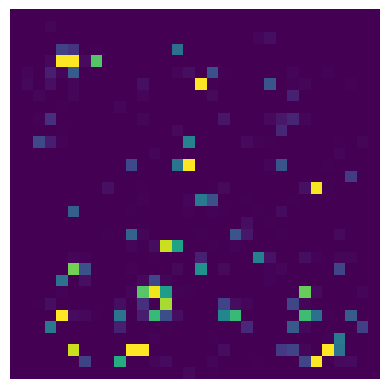

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reverse_engineer(param = {
    "dataset": "cifar10",
    "Epochs": 100,
    "batch_size": 64,
    "target_label": 8,
    "cost_lambda": 1e-3,
    "num_classes": 10,
    "image_size": (32, 32)}, model = torch.load('model_cifar10_0.15_8.pkl').to(device))

### Target Label = 9, Injection Rate = 0.15

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
param = {
    "dataset": "cifar10",
    "model": "default",
    "poisoning_method": "badnet",
    "injection_rate": 0.15,
    "target_label": 9,
    "Epochs": 150,
    "batch_size": 64
    }
fill_param(param)
train(param)

Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.75it/s]


Epoch: 1, Training Accuracy: 50.858, Testing Accuracy: 57.72, Testing ASR: 98.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.21it/s]


Epoch: 2, Training Accuracy: 65.732, Testing Accuracy: 65.55, Testing ASR: 96.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.93it/s]


Epoch: 3, Training Accuracy: 70.986, Testing Accuracy: 69.09, Testing ASR: 96.33


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.92it/s]


Epoch: 4, Training Accuracy: 74.482, Testing Accuracy: 71.7, Testing ASR: 97.61


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.30it/s]


Epoch: 5, Training Accuracy: 76.706, Testing Accuracy: 71.69, Testing ASR: 97.77


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.13it/s]


Epoch: 6, Training Accuracy: 78.49, Testing Accuracy: 74.4, Testing ASR: 95.55


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.75it/s]


Epoch: 7, Training Accuracy: 79.822, Testing Accuracy: 75.87, Testing ASR: 95.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.97it/s]


Epoch: 8, Training Accuracy: 80.886, Testing Accuracy: 79.16, Testing ASR: 97.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.54it/s]


Epoch: 9, Training Accuracy: 81.804, Testing Accuracy: 79.31, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 622.60it/s]


Epoch: 10, Training Accuracy: 82.598, Testing Accuracy: 79.99, Testing ASR: 97.52


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.63it/s]


Epoch: 11, Training Accuracy: 83.572, Testing Accuracy: 79.93, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 623.13it/s]


Epoch: 12, Training Accuracy: 84.282, Testing Accuracy: 80.81, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.52it/s]


Epoch: 13, Training Accuracy: 84.688, Testing Accuracy: 79.33, Testing ASR: 97.53


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.94it/s]


Epoch: 14, Training Accuracy: 85.5, Testing Accuracy: 79.25, Testing ASR: 96.3


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.55it/s]


Epoch: 15, Training Accuracy: 85.58, Testing Accuracy: 79.87, Testing ASR: 98.19


Testing...: 100%|██████████| 157/157 [00:00<00:00, 595.54it/s]


Epoch: 16, Training Accuracy: 86.638, Testing Accuracy: 79.17, Testing ASR: 97.5


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.13it/s]


Epoch: 17, Training Accuracy: 87.016, Testing Accuracy: 80.21, Testing ASR: 97.73


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.92it/s]


Epoch: 18, Training Accuracy: 87.274, Testing Accuracy: 81.11, Testing ASR: 97.65


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.11it/s]


Epoch: 19, Training Accuracy: 87.678, Testing Accuracy: 81.09, Testing ASR: 98.2


Testing...: 100%|██████████| 157/157 [00:00<00:00, 603.95it/s]


Epoch: 20, Training Accuracy: 87.794, Testing Accuracy: 82.17, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.27it/s]


Epoch: 21, Training Accuracy: 88.158, Testing Accuracy: 81.31, Testing ASR: 97.49


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.31it/s]


Epoch: 22, Training Accuracy: 88.406, Testing Accuracy: 81.52, Testing ASR: 97.57


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.52it/s]


Epoch: 23, Training Accuracy: 88.806, Testing Accuracy: 81.85, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 601.59it/s]


Epoch: 24, Training Accuracy: 89.2, Testing Accuracy: 79.49, Testing ASR: 97.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.51it/s]


Epoch: 25, Training Accuracy: 89.46, Testing Accuracy: 81.41, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.53it/s]


Epoch: 26, Training Accuracy: 89.546, Testing Accuracy: 81.89, Testing ASR: 97.61


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.10it/s]


Epoch: 27, Training Accuracy: 89.918, Testing Accuracy: 81.96, Testing ASR: 97.5


Testing...: 100%|██████████| 157/157 [00:00<00:00, 605.73it/s]


Epoch: 28, Training Accuracy: 90.082, Testing Accuracy: 81.62, Testing ASR: 97.68


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.17it/s]


Epoch: 29, Training Accuracy: 90.12, Testing Accuracy: 82.19, Testing ASR: 98.26


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.55it/s]


Epoch: 30, Training Accuracy: 90.462, Testing Accuracy: 82.46, Testing ASR: 97.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 589.33it/s]


Epoch: 31, Training Accuracy: 90.664, Testing Accuracy: 81.45, Testing ASR: 97.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.95it/s]


Epoch: 32, Training Accuracy: 90.884, Testing Accuracy: 82.46, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.35it/s]


Epoch: 33, Training Accuracy: 91.008, Testing Accuracy: 81.58, Testing ASR: 97.67


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.55it/s]


Epoch: 34, Training Accuracy: 91.16, Testing Accuracy: 82.22, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.25it/s]


Epoch: 35, Training Accuracy: 91.55, Testing Accuracy: 82.5, Testing ASR: 96.29


Testing...: 100%|██████████| 157/157 [00:00<00:00, 605.77it/s]


Epoch: 36, Training Accuracy: 91.554, Testing Accuracy: 81.45, Testing ASR: 95.23


Testing...: 100%|██████████| 157/157 [00:00<00:00, 606.25it/s]


Epoch: 37, Training Accuracy: 91.566, Testing Accuracy: 82.39, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 605.85it/s]


Epoch: 38, Training Accuracy: 91.694, Testing Accuracy: 80.38, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.71it/s]


Epoch: 39, Training Accuracy: 91.75, Testing Accuracy: 82.7, Testing ASR: 98.14


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.33it/s]


Epoch: 40, Training Accuracy: 91.828, Testing Accuracy: 81.87, Testing ASR: 96.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.34it/s]


Epoch: 41, Training Accuracy: 92.198, Testing Accuracy: 82.51, Testing ASR: 98.2


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.08it/s]


Epoch: 42, Training Accuracy: 92.294, Testing Accuracy: 82.11, Testing ASR: 98.24


Testing...: 100%|██████████| 157/157 [00:00<00:00, 578.94it/s]


Epoch: 43, Training Accuracy: 92.54, Testing Accuracy: 82.17, Testing ASR: 97.83


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.66it/s]


Epoch: 44, Training Accuracy: 92.434, Testing Accuracy: 82.0, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 635.19it/s]


Epoch: 45, Training Accuracy: 92.502, Testing Accuracy: 82.31, Testing ASR: 97.8


Testing...: 100%|██████████| 157/157 [00:00<00:00, 610.81it/s]


Epoch: 46, Training Accuracy: 92.572, Testing Accuracy: 82.44, Testing ASR: 98.0


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.23it/s]


Epoch: 47, Training Accuracy: 92.708, Testing Accuracy: 82.15, Testing ASR: 97.79


Testing...: 100%|██████████| 157/157 [00:00<00:00, 634.03it/s]


Epoch: 48, Training Accuracy: 92.78, Testing Accuracy: 82.14, Testing ASR: 97.76


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.73it/s]


Epoch: 49, Training Accuracy: 92.964, Testing Accuracy: 82.17, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.43it/s]


Epoch: 50, Training Accuracy: 92.962, Testing Accuracy: 82.51, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.13it/s]


Epoch: 51, Training Accuracy: 93.08, Testing Accuracy: 82.31, Testing ASR: 98.16


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.85it/s]


Epoch: 52, Training Accuracy: 93.192, Testing Accuracy: 82.49, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.25it/s]


Epoch: 53, Training Accuracy: 93.228, Testing Accuracy: 81.77, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.26it/s]


Epoch: 54, Training Accuracy: 93.428, Testing Accuracy: 82.3, Testing ASR: 97.84


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.06it/s]


Epoch: 55, Training Accuracy: 93.336, Testing Accuracy: 82.35, Testing ASR: 97.89


Testing...: 100%|██████████| 157/157 [00:00<00:00, 583.39it/s]


Epoch: 56, Training Accuracy: 93.682, Testing Accuracy: 82.15, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.30it/s]


Epoch: 57, Training Accuracy: 93.652, Testing Accuracy: 82.18, Testing ASR: 97.78


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.93it/s]


Epoch: 58, Training Accuracy: 93.548, Testing Accuracy: 82.7, Testing ASR: 97.81


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.95it/s]


Epoch: 59, Training Accuracy: 93.624, Testing Accuracy: 82.23, Testing ASR: 98.17


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.30it/s]


Epoch: 60, Training Accuracy: 93.88, Testing Accuracy: 82.05, Testing ASR: 98.17


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.73it/s]


Epoch: 61, Training Accuracy: 93.8, Testing Accuracy: 82.69, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.54it/s]


Epoch: 62, Training Accuracy: 94.014, Testing Accuracy: 82.44, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 598.54it/s]


Epoch: 63, Training Accuracy: 93.87, Testing Accuracy: 82.57, Testing ASR: 97.96


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.42it/s]


Epoch: 64, Training Accuracy: 94.128, Testing Accuracy: 82.44, Testing ASR: 97.98


Testing...: 100%|██████████| 157/157 [00:00<00:00, 640.76it/s]


Epoch: 65, Training Accuracy: 94.142, Testing Accuracy: 82.74, Testing ASR: 97.74


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.14it/s]


Epoch: 66, Training Accuracy: 94.128, Testing Accuracy: 82.67, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.21it/s]


Epoch: 67, Training Accuracy: 94.034, Testing Accuracy: 82.31, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.60it/s]


Epoch: 68, Training Accuracy: 94.39, Testing Accuracy: 81.49, Testing ASR: 97.26


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.44it/s]


Epoch: 69, Training Accuracy: 94.338, Testing Accuracy: 82.34, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.87it/s]


Epoch: 70, Training Accuracy: 94.304, Testing Accuracy: 82.11, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.88it/s]


Epoch: 71, Training Accuracy: 94.418, Testing Accuracy: 81.99, Testing ASR: 98.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 596.42it/s]


Epoch: 72, Training Accuracy: 94.4, Testing Accuracy: 82.66, Testing ASR: 97.75


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.13it/s]


Epoch: 73, Training Accuracy: 94.534, Testing Accuracy: 82.28, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 569.36it/s]


Epoch: 74, Training Accuracy: 94.662, Testing Accuracy: 82.44, Testing ASR: 98.32


Testing...: 100%|██████████| 157/157 [00:00<00:00, 591.75it/s]


Epoch: 75, Training Accuracy: 94.59, Testing Accuracy: 82.31, Testing ASR: 97.82


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.78it/s]


Epoch: 76, Training Accuracy: 94.594, Testing Accuracy: 82.88, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.77it/s]


Epoch: 77, Training Accuracy: 94.552, Testing Accuracy: 82.7, Testing ASR: 97.7


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.06it/s]


Epoch: 78, Training Accuracy: 94.654, Testing Accuracy: 80.73, Testing ASR: 97.39


Testing...: 100%|██████████| 157/157 [00:00<00:00, 600.99it/s]


Epoch: 79, Training Accuracy: 94.646, Testing Accuracy: 82.43, Testing ASR: 97.9


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.07it/s]


Epoch: 80, Training Accuracy: 94.784, Testing Accuracy: 82.26, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.17it/s]


Epoch: 81, Training Accuracy: 95.498, Testing Accuracy: 82.94, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.68it/s]


Epoch: 82, Training Accuracy: 95.76, Testing Accuracy: 82.57, Testing ASR: 97.69


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.75it/s]


Epoch: 83, Training Accuracy: 95.996, Testing Accuracy: 83.07, Testing ASR: 98.02


Testing...: 100%|██████████| 157/157 [00:00<00:00, 599.47it/s]


Epoch: 84, Training Accuracy: 96.066, Testing Accuracy: 82.74, Testing ASR: 98.15


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.74it/s]


Epoch: 85, Training Accuracy: 96.036, Testing Accuracy: 82.62, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 628.60it/s]


Epoch: 86, Training Accuracy: 96.136, Testing Accuracy: 83.1, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.16it/s]


Epoch: 87, Training Accuracy: 96.204, Testing Accuracy: 83.29, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 596.68it/s]


Epoch: 88, Training Accuracy: 96.182, Testing Accuracy: 83.36, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 624.64it/s]


Epoch: 89, Training Accuracy: 96.294, Testing Accuracy: 83.27, Testing ASR: 98.12


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.49it/s]


Epoch: 90, Training Accuracy: 96.396, Testing Accuracy: 83.07, Testing ASR: 97.92


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.18it/s]


Epoch: 91, Training Accuracy: 96.442, Testing Accuracy: 83.03, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.63it/s]


Epoch: 92, Training Accuracy: 96.584, Testing Accuracy: 83.14, Testing ASR: 98.02


Testing...: 100%|██████████| 157/157 [00:00<00:00, 582.49it/s]


Epoch: 93, Training Accuracy: 96.584, Testing Accuracy: 82.16, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.63it/s]


Epoch: 94, Training Accuracy: 96.494, Testing Accuracy: 83.15, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.59it/s]


Epoch: 95, Training Accuracy: 96.462, Testing Accuracy: 83.19, Testing ASR: 97.72


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.75it/s]


Epoch: 96, Training Accuracy: 96.45, Testing Accuracy: 83.09, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 626.02it/s]


Epoch: 97, Training Accuracy: 96.406, Testing Accuracy: 83.22, Testing ASR: 98.27


Testing...: 100%|██████████| 157/157 [00:00<00:00, 629.02it/s]


Epoch: 98, Training Accuracy: 96.424, Testing Accuracy: 83.16, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.15it/s]


Epoch: 99, Training Accuracy: 96.704, Testing Accuracy: 83.29, Testing ASR: 98.0


Testing...: 100%|██████████| 157/157 [00:00<00:00, 596.57it/s]


Epoch: 100, Training Accuracy: 96.65, Testing Accuracy: 83.04, Testing ASR: 98.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.91it/s]


Epoch: 101, Training Accuracy: 96.962, Testing Accuracy: 83.47, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 640.24it/s]


Epoch: 102, Training Accuracy: 97.024, Testing Accuracy: 83.36, Testing ASR: 97.97


Testing...: 100%|██████████| 157/157 [00:00<00:00, 591.40it/s]


Epoch: 103, Training Accuracy: 97.238, Testing Accuracy: 83.3, Testing ASR: 98.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.15it/s]


Epoch: 104, Training Accuracy: 97.308, Testing Accuracy: 83.26, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.08it/s]


Epoch: 105, Training Accuracy: 97.168, Testing Accuracy: 83.45, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.60it/s]


Epoch: 106, Training Accuracy: 97.228, Testing Accuracy: 83.35, Testing ASR: 98.0


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.01it/s]


Epoch: 107, Training Accuracy: 97.336, Testing Accuracy: 83.42, Testing ASR: 98.11


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.75it/s]


Epoch: 108, Training Accuracy: 97.378, Testing Accuracy: 83.56, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 600.31it/s]


Epoch: 109, Training Accuracy: 97.286, Testing Accuracy: 83.44, Testing ASR: 98.0


Testing...: 100%|██████████| 157/157 [00:00<00:00, 625.94it/s]


Epoch: 110, Training Accuracy: 97.474, Testing Accuracy: 83.32, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 597.08it/s]


Epoch: 111, Training Accuracy: 97.398, Testing Accuracy: 83.38, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 642.69it/s]


Epoch: 112, Training Accuracy: 97.462, Testing Accuracy: 83.4, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.26it/s]


Epoch: 113, Training Accuracy: 97.394, Testing Accuracy: 83.46, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.78it/s]


Epoch: 114, Training Accuracy: 97.4, Testing Accuracy: 83.63, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.77it/s]


Epoch: 115, Training Accuracy: 97.566, Testing Accuracy: 83.4, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.43it/s]


Epoch: 116, Training Accuracy: 97.486, Testing Accuracy: 83.29, Testing ASR: 97.98


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.22it/s]


Epoch: 117, Training Accuracy: 97.556, Testing Accuracy: 83.26, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.27it/s]


Epoch: 118, Training Accuracy: 97.668, Testing Accuracy: 83.24, Testing ASR: 98.1


Testing...: 100%|██████████| 157/157 [00:00<00:00, 607.16it/s]


Epoch: 119, Training Accuracy: 97.538, Testing Accuracy: 83.39, Testing ASR: 98.02


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.25it/s]


Epoch: 120, Training Accuracy: 97.644, Testing Accuracy: 83.41, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.47it/s]


Epoch: 121, Training Accuracy: 97.5, Testing Accuracy: 83.3, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 620.02it/s]


Epoch: 122, Training Accuracy: 97.716, Testing Accuracy: 83.41, Testing ASR: 98.02


Testing...: 100%|██████████| 157/157 [00:00<00:00, 642.54it/s]


Epoch: 123, Training Accuracy: 97.636, Testing Accuracy: 83.2, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 641.56it/s]


Epoch: 124, Training Accuracy: 97.582, Testing Accuracy: 83.42, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 631.54it/s]


Epoch: 125, Training Accuracy: 97.786, Testing Accuracy: 83.36, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 545.00it/s]


Epoch: 126, Training Accuracy: 97.606, Testing Accuracy: 83.34, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 621.66it/s]


Epoch: 127, Training Accuracy: 97.66, Testing Accuracy: 83.42, Testing ASR: 98.09


Testing...: 100%|██████████| 157/157 [00:00<00:00, 589.99it/s]


Epoch: 128, Training Accuracy: 97.602, Testing Accuracy: 83.43, Testing ASR: 98.11


Testing...: 100%|██████████| 157/157 [00:00<00:00, 619.73it/s]


Epoch: 129, Training Accuracy: 97.688, Testing Accuracy: 83.37, Testing ASR: 98.17


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.20it/s]


Epoch: 130, Training Accuracy: 97.608, Testing Accuracy: 83.32, Testing ASR: 97.94


Testing...: 100%|██████████| 157/157 [00:00<00:00, 615.60it/s]


Epoch: 131, Training Accuracy: 97.59, Testing Accuracy: 83.44, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.42it/s]


Epoch: 132, Training Accuracy: 97.728, Testing Accuracy: 83.59, Testing ASR: 98.0


Testing...: 100%|██████████| 157/157 [00:00<00:00, 611.16it/s]


Epoch: 133, Training Accuracy: 97.756, Testing Accuracy: 83.49, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.72it/s]


Epoch: 134, Training Accuracy: 97.762, Testing Accuracy: 83.66, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 609.26it/s]


Epoch: 135, Training Accuracy: 97.712, Testing Accuracy: 83.45, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 586.08it/s]


Epoch: 136, Training Accuracy: 97.75, Testing Accuracy: 83.47, Testing ASR: 98.16


Testing...: 100%|██████████| 157/157 [00:00<00:00, 614.31it/s]


Epoch: 137, Training Accuracy: 97.802, Testing Accuracy: 83.62, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 604.13it/s]


Epoch: 138, Training Accuracy: 97.774, Testing Accuracy: 83.42, Testing ASR: 98.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 627.84it/s]


Epoch: 139, Training Accuracy: 97.75, Testing Accuracy: 83.53, Testing ASR: 98.05


Testing...: 100%|██████████| 157/157 [00:00<00:00, 597.75it/s]


Epoch: 140, Training Accuracy: 97.758, Testing Accuracy: 83.5, Testing ASR: 98.04


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.32it/s]


Epoch: 141, Training Accuracy: 97.746, Testing Accuracy: 83.27, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 608.64it/s]


Epoch: 142, Training Accuracy: 97.796, Testing Accuracy: 83.6, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 630.84it/s]


Epoch: 143, Training Accuracy: 97.726, Testing Accuracy: 83.31, Testing ASR: 98.01


Testing...: 100%|██████████| 157/157 [00:00<00:00, 617.32it/s]


Epoch: 144, Training Accuracy: 97.824, Testing Accuracy: 83.51, Testing ASR: 98.02


Testing...: 100%|██████████| 157/157 [00:00<00:00, 599.47it/s]


Epoch: 145, Training Accuracy: 97.896, Testing Accuracy: 83.42, Testing ASR: 97.99


Testing...: 100%|██████████| 157/157 [00:00<00:00, 612.32it/s]


Epoch: 146, Training Accuracy: 97.726, Testing Accuracy: 83.41, Testing ASR: 98.03


Testing...: 100%|██████████| 157/157 [00:00<00:00, 592.85it/s]


Epoch: 147, Training Accuracy: 97.838, Testing Accuracy: 83.43, Testing ASR: 98.07


Testing...: 100%|██████████| 157/157 [00:00<00:00, 618.66it/s]


Epoch: 148, Training Accuracy: 97.762, Testing Accuracy: 83.42, Testing ASR: 98.06


Testing...: 100%|██████████| 157/157 [00:00<00:00, 613.20it/s]


Epoch: 149, Training Accuracy: 97.84, Testing Accuracy: 83.43, Testing ASR: 98.08


Testing...: 100%|██████████| 157/157 [00:00<00:00, 616.59it/s]


Epoch: 150, Training Accuracy: 97.834, Testing Accuracy: 83.5, Testing ASR: 98.07


Processing label: 0


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 251.39it/s]


norm: 496.4268798828125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 250.79it/s]


norm: 463.825927734375


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 245.39it/s]


norm: 424.04296875


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 253.55it/s]


norm: 381.234130859375


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 240.27it/s]


norm: 338.4039306640625


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 248.15it/s]


norm: 297.2857360839844


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 247.57it/s]


norm: 259.240234375


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 222.28it/s]


norm: 225.9192657470703


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 228.59it/s]


norm: 197.13308715820312


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 242.43it/s]


norm: 172.21368408203125


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 244.35it/s]


norm: 150.95745849609375


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 241.72it/s]


norm: 134.34124755859375


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 234.07it/s]


norm: 121.77737426757812


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 219.44it/s]


norm: 110.3418197631836


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 222.81it/s]


norm: 102.13706970214844


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 233.34it/s]


norm: 95.58528137207031


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 242.77it/s]


norm: 90.33949279785156


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 244.03it/s]


norm: 85.64788055419922


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 212.47it/s]


norm: 81.2500991821289


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 251.30it/s]


norm: 78.20307922363281


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 251.48it/s]


norm: 75.60176086425781


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 249.48it/s]


norm: 73.48713684082031


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 244.35it/s]


norm: 72.36174774169922


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 249.86it/s]


norm: 70.79960632324219


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 240.75it/s]


norm: 70.51309967041016


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 237.62it/s]


norm: 69.26557159423828


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 240.31it/s]


norm: 67.9581298828125


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 249.36it/s]


norm: 67.39656066894531


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 244.16it/s]


norm: 66.78640747070312


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 238.77it/s]


norm: 66.71022033691406


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 222.90it/s]


norm: 66.331787109375


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 205.81it/s]


norm: 65.53665161132812


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 213.97it/s]


norm: 65.32648468017578


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 244.14it/s]


norm: 65.1388931274414


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 242.22it/s]


norm: 64.44086456298828


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 250.47it/s]


norm: 63.973419189453125


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 243.73it/s]


norm: 63.0947151184082


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 240.14it/s]


norm: 62.59082794189453


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 250.26it/s]


norm: 61.942996978759766


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 243.16it/s]


norm: 61.66197204589844


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 248.56it/s]


norm: 61.38928985595703


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 249.74it/s]


norm: 60.91383743286133


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 253.43it/s]


norm: 60.779510498046875


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 231.64it/s]


norm: 60.52347183227539


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 220.39it/s]


norm: 60.400840759277344


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 215.17it/s]


norm: 59.970008850097656


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 229.50it/s]


norm: 58.68012619018555


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 245.27it/s]


norm: 58.35499954223633


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 246.69it/s]


norm: 57.86654281616211


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 242.70it/s]


norm: 57.346656799316406


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 248.06it/s]


norm: 57.348548889160156


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 222.46it/s]


norm: 57.14032745361328


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 242.30it/s]


norm: 56.375938415527344


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 242.20it/s]


norm: 56.25958251953125


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 246.25it/s]


norm: 56.471221923828125


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 246.78it/s]


norm: 56.48755645751953


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 249.63it/s]


norm: 56.191741943359375


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 244.44it/s]


norm: 55.97833251953125


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 230.87it/s]


norm: 56.00056076049805


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 240.66it/s]


norm: 56.02758026123047


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 227.17it/s]


norm: 55.66279220581055


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 244.47it/s]


norm: 55.27178192138672


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 232.35it/s]


norm: 54.7843132019043


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 237.65it/s]


norm: 55.06101989746094


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 248.62it/s]


norm: 53.95703125


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 246.21it/s]


norm: 54.024574279785156


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 249.71it/s]


norm: 53.775753021240234


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 252.03it/s]


norm: 54.29740905761719


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 246.80it/s]


norm: 54.29993438720703


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 245.53it/s]


norm: 54.38330078125


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 247.11it/s]


norm: 54.07056427001953


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 253.86it/s]


norm: 53.74931335449219


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 246.83it/s]


norm: 53.62952423095703


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 252.70it/s]


norm: 53.83298110961914


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 247.68it/s]


norm: 53.671852111816406


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 248.01it/s]


norm: 54.254249572753906


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 245.43it/s]


norm: 54.011566162109375


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 243.74it/s]


norm: 55.16929626464844


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 252.27it/s]


norm: 54.76910400390625


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 251.08it/s]


norm: 55.24226379394531


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 241.45it/s]


norm: 55.01701354980469


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 252.51it/s]


norm: 54.420066833496094


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 247.92it/s]


norm: 54.07789611816406


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 249.61it/s]


norm: 53.967140197753906


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 249.92it/s]


norm: 53.62900924682617


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 242.53it/s]


norm: 53.90422058105469


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 255.66it/s]


norm: 52.90537643432617


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 247.66it/s]


norm: 54.40705871582031


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 250.28it/s]


norm: 53.77936553955078


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 243.44it/s]


norm: 53.435279846191406


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 249.50it/s]


norm: 52.59136962890625


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 233.49it/s]


norm: 52.543235778808594


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 210.96it/s]


norm: 53.097999572753906


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 244.12it/s]


norm: 53.11286926269531


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 239.43it/s]


norm: 53.97586441040039


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 250.20it/s]


norm: 53.183837890625


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 245.00it/s]


norm: 53.650657653808594


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 221.13it/s]


norm: 53.57215881347656


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 245.01it/s]


norm: 52.75431823730469


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 249.22it/s]


norm: 52.384056091308594
Processing label: 1


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 249.46it/s]


norm: 479.45245361328125


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 248.56it/s]


norm: 443.86151123046875


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 248.29it/s]


norm: 399.87158203125


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 232.81it/s]


norm: 354.0026550292969


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 245.35it/s]


norm: 308.3116149902344


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 252.11it/s]


norm: 264.94134521484375


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 227.87it/s]


norm: 227.03634643554688


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 243.32it/s]


norm: 195.31729125976562


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 248.09it/s]


norm: 168.28945922851562


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 248.13it/s]


norm: 145.12216186523438


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 247.47it/s]


norm: 126.60186004638672


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 244.25it/s]


norm: 110.85892486572266


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 248.34it/s]


norm: 99.45086669921875


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 256.66it/s]


norm: 90.94922637939453


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 254.96it/s]


norm: 83.67481994628906


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 250.79it/s]


norm: 77.22108459472656


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 253.55it/s]


norm: 72.42224884033203


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 218.91it/s]


norm: 65.90709686279297


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 219.26it/s]


norm: 63.10657501220703


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 245.26it/s]


norm: 59.995338439941406


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 253.38it/s]


norm: 57.5582275390625


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 245.49it/s]


norm: 55.37511444091797


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 248.44it/s]


norm: 53.87335968017578


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 242.03it/s]


norm: 51.58515167236328


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 250.09it/s]


norm: 50.71311569213867


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 254.64it/s]


norm: 49.37267303466797


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 248.79it/s]


norm: 48.94384765625


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 243.50it/s]


norm: 46.76171875


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 252.45it/s]


norm: 46.417877197265625


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 249.77it/s]


norm: 46.146270751953125


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 248.62it/s]


norm: 45.7198486328125


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 242.61it/s]


norm: 45.625396728515625


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 244.83it/s]


norm: 45.3984260559082


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 250.04it/s]


norm: 45.19580841064453


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 252.01it/s]


norm: 45.252403259277344


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 254.60it/s]


norm: 45.13822555541992


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 235.44it/s]


norm: 44.62311553955078


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 232.47it/s]


norm: 44.28523635864258


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 252.32it/s]


norm: 44.08301544189453


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 245.31it/s]


norm: 43.48944854736328


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 250.24it/s]


norm: 43.276634216308594


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 253.40it/s]


norm: 43.17305374145508


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 249.52it/s]


norm: 42.990142822265625


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 247.67it/s]


norm: 42.51663589477539


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 252.24it/s]


norm: 42.471214294433594


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 251.87it/s]


norm: 42.37799072265625


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 227.96it/s]


norm: 42.55419921875


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 227.43it/s]


norm: 42.59691619873047


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 240.52it/s]


norm: 42.351104736328125


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 252.70it/s]


norm: 42.142417907714844


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 256.28it/s]


norm: 42.170684814453125


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 248.27it/s]


norm: 42.095359802246094


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 245.02it/s]


norm: 42.42870330810547


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 247.34it/s]


norm: 42.41614532470703


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 254.65it/s]


norm: 42.71631622314453


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 248.30it/s]


norm: 42.450775146484375


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 248.29it/s]


norm: 41.99491500854492


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 249.41it/s]


norm: 41.53850555419922


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 254.14it/s]


norm: 41.42540740966797


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 253.18it/s]


norm: 41.28349304199219


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


norm: 41.14735794067383


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 251.73it/s]


norm: 40.796234130859375


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 250.86it/s]


norm: 40.64635467529297


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 248.57it/s]


norm: 40.628379821777344


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 252.21it/s]


norm: 40.816314697265625


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 252.14it/s]


norm: 40.662452697753906


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 253.51it/s]


norm: 40.73780822753906


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 240.66it/s]


norm: 40.49464797973633


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 215.86it/s]


norm: 40.67281723022461


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 248.85it/s]


norm: 40.63600158691406


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 250.94it/s]


norm: 40.762969970703125


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 250.53it/s]


norm: 40.23601531982422


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 249.41it/s]


norm: 39.75875473022461


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 251.11it/s]


norm: 39.597015380859375


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 252.37it/s]


norm: 39.37992858886719


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 253.84it/s]


norm: 38.81437683105469


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 251.30it/s]


norm: 38.34466552734375


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 250.36it/s]


norm: 38.30135726928711


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 247.60it/s]


norm: 38.24047088623047


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 245.43it/s]


norm: 38.359130859375


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 249.70it/s]


norm: 38.26280212402344


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 256.67it/s]


norm: 38.343589782714844


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 246.69it/s]


norm: 38.410457611083984


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 242.97it/s]


norm: 38.35393524169922


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 254.33it/s]


norm: 38.40473937988281


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 254.62it/s]


norm: 38.48558044433594


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 255.91it/s]


norm: 38.45110321044922


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 248.02it/s]


norm: 38.337852478027344


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 224.16it/s]


norm: 38.397117614746094


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 238.69it/s]


norm: 38.302093505859375


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 248.62it/s]


norm: 39.00531005859375


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 248.97it/s]


norm: 39.383277893066406


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 250.50it/s]


norm: 38.338539123535156


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 247.50it/s]


norm: 38.11573791503906


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 251.98it/s]


norm: 38.250980377197266


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 254.16it/s]


norm: 38.88568115234375


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 248.19it/s]


norm: 38.294429779052734


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 254.41it/s]


norm: 38.422061920166016


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 246.12it/s]


norm: 38.539268493652344


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 244.37it/s]


norm: 38.758277893066406
Processing label: 2


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 243.04it/s]


norm: 475.1026916503906


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 252.24it/s]


norm: 415.2027587890625


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 250.85it/s]


norm: 348.09478759765625


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 248.39it/s]


norm: 287.6321716308594


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 245.53it/s]


norm: 237.5170135498047


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 253.39it/s]


norm: 198.961181640625


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 246.48it/s]


norm: 170.1485595703125


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 249.69it/s]


norm: 148.53306579589844


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 253.08it/s]


norm: 130.2559051513672


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 238.65it/s]


norm: 116.19170379638672


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 251.83it/s]


norm: 104.47637939453125


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 245.94it/s]


norm: 96.10553741455078


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 253.82it/s]


norm: 89.27651977539062


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 252.72it/s]


norm: 84.364501953125


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 255.53it/s]


norm: 80.33989715576172


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 245.13it/s]


norm: 75.68768310546875


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 250.73it/s]


norm: 71.16615295410156


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 251.59it/s]


norm: 69.1905288696289


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 252.18it/s]


norm: 66.3257827758789


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 252.14it/s]


norm: 63.80696105957031


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 244.20it/s]


norm: 60.76752471923828


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 247.23it/s]


norm: 59.02811813354492


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


norm: 57.437095642089844


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 249.06it/s]


norm: 55.75639343261719


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 252.66it/s]


norm: 55.04847717285156


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 248.08it/s]


norm: 54.384273529052734


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 247.47it/s]


norm: 53.44152069091797


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 254.21it/s]


norm: 53.34489822387695


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 253.38it/s]


norm: 53.13431167602539


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 253.39it/s]


norm: 52.9434814453125


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 250.42it/s]


norm: 52.88262939453125


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 253.30it/s]


norm: 53.195579528808594


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 254.37it/s]


norm: 52.8258056640625


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 257.19it/s]


norm: 52.53089904785156


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 233.94it/s]


norm: 52.80921936035156


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 245.39it/s]


norm: 52.7796745300293


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 249.14it/s]


norm: 52.25688171386719


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 241.75it/s]


norm: 52.12232971191406


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 257.89it/s]


norm: 51.81928253173828


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 252.82it/s]


norm: 52.05779266357422


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 252.53it/s]


norm: 52.18770217895508


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 246.19it/s]


norm: 52.10343933105469


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 249.06it/s]


norm: 51.594207763671875


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 215.61it/s]


norm: 51.46965026855469


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 225.84it/s]


norm: 51.181941986083984


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 246.86it/s]


norm: 50.98468017578125


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 250.31it/s]


norm: 50.47309494018555


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 254.64it/s]


norm: 51.14533996582031


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 250.47it/s]


norm: 50.41221618652344


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 256.05it/s]


norm: 50.61790084838867


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 252.86it/s]


norm: 49.50145721435547


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 253.69it/s]


norm: 49.88954544067383


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 251.94it/s]


norm: 49.75740051269531


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 250.97it/s]


norm: 49.37791442871094


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 230.05it/s]


norm: 49.11806106567383


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 229.02it/s]


norm: 49.31227111816406


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 245.49it/s]


norm: 50.00871276855469


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 255.17it/s]


norm: 49.24104690551758


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 248.79it/s]


norm: 49.252830505371094


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 250.23it/s]


norm: 49.15810012817383


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 225.99it/s]


norm: 49.8067626953125


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 244.43it/s]


norm: 49.09999084472656


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 250.97it/s]


norm: 49.10505676269531


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 246.22it/s]


norm: 48.847816467285156


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 253.55it/s]


norm: 49.45163345336914


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 216.55it/s]


norm: 48.96990966796875


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 251.46it/s]


norm: 48.85368347167969


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 246.38it/s]


norm: 48.25377655029297


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 245.30it/s]


norm: 47.963497161865234


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 250.89it/s]


norm: 47.230445861816406


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 252.09it/s]


norm: 47.64870071411133


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 251.86it/s]


norm: 47.148719787597656


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 250.85it/s]


norm: 47.80622863769531


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 253.57it/s]


norm: 47.30372619628906


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 248.78it/s]


norm: 47.07061767578125


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 251.63it/s]


norm: 46.98986053466797


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 223.21it/s]


norm: 47.97922134399414


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 226.98it/s]


norm: 47.66053009033203


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 212.71it/s]


norm: 48.33574676513672


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 241.90it/s]


norm: 48.17026901245117


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 252.76it/s]


norm: 48.03143310546875


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 243.42it/s]


norm: 46.94990921020508


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 241.87it/s]


norm: 47.37339401245117


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 248.08it/s]


norm: 47.16893005371094


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 240.27it/s]


norm: 47.05078887939453


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 255.87it/s]


norm: 47.124237060546875


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 241.05it/s]


norm: 47.228485107421875


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 214.89it/s]


norm: 48.089866638183594


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 245.13it/s]


norm: 48.275814056396484


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 252.11it/s]


norm: 49.11298751831055


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 251.25it/s]


norm: 47.59968948364258


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 254.63it/s]


norm: 48.88299560546875


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 248.49it/s]


norm: 46.60401153564453


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 258.16it/s]


norm: 47.46424865722656


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 251.66it/s]


norm: 46.40349578857422


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 236.94it/s]


norm: 47.481929779052734


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 237.23it/s]


norm: 45.9573860168457


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 250.59it/s]


norm: 45.79237365722656


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 245.72it/s]


norm: 47.76313400268555


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 250.46it/s]


norm: 46.234920501708984
Processing label: 3


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 249.81it/s]


norm: 492.0915832519531


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 248.13it/s]


norm: 429.9549865722656


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 251.26it/s]


norm: 362.2585754394531


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 248.70it/s]


norm: 301.55413818359375


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 247.46it/s]


norm: 251.24435424804688


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 252.73it/s]


norm: 209.38304138183594


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 244.86it/s]


norm: 176.64190673828125


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 223.47it/s]


norm: 152.30645751953125


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 208.20it/s]


norm: 133.8103790283203


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 253.36it/s]


norm: 119.74014282226562


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 254.59it/s]


norm: 109.6622085571289


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 254.19it/s]


norm: 102.23487854003906


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 253.22it/s]


norm: 96.62648010253906


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 239.03it/s]


norm: 93.30914306640625


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 244.05it/s]


norm: 89.61925506591797


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 247.33it/s]


norm: 86.6943359375


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 251.07it/s]


norm: 84.36000061035156


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 237.68it/s]


norm: 82.2953109741211


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 240.80it/s]


norm: 80.84957122802734


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 252.22it/s]


norm: 79.75845336914062


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 253.22it/s]


norm: 78.06336212158203


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 244.36it/s]


norm: 77.3111572265625


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 253.54it/s]


norm: 76.12934875488281


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 255.35it/s]


norm: 74.86918640136719


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 251.20it/s]


norm: 74.04724884033203


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 231.45it/s]


norm: 73.58731842041016


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 250.87it/s]


norm: 73.6285629272461


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 251.63it/s]


norm: 72.96505737304688


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 254.39it/s]


norm: 72.73422241210938


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 252.55it/s]


norm: 72.03440856933594


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 245.49it/s]


norm: 70.55079650878906


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 249.41it/s]


norm: 69.57099914550781


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 247.48it/s]


norm: 68.6402587890625


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 244.30it/s]


norm: 68.05584716796875


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 247.72it/s]


norm: 68.03910827636719


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 249.36it/s]


norm: 67.48704528808594


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 253.50it/s]


norm: 67.2596664428711


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 256.92it/s]


norm: 67.22693634033203


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 255.60it/s]


norm: 67.54949951171875


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 251.22it/s]


norm: 67.94149780273438


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 240.52it/s]


norm: 67.24788665771484


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 250.77it/s]


norm: 66.75662231445312


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 250.63it/s]


norm: 66.039306640625


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 212.34it/s]


norm: 65.60692596435547


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 238.53it/s]


norm: 64.905029296875


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 253.18it/s]


norm: 64.76323699951172


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 248.77it/s]


norm: 64.01732635498047


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 252.07it/s]


norm: 63.92699432373047


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 244.89it/s]


norm: 64.4197006225586


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 230.23it/s]


norm: 64.33634948730469


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 231.78it/s]


norm: 63.85916519165039


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 219.56it/s]


norm: 63.15438461303711


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 236.55it/s]


norm: 62.572505950927734


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 247.70it/s]


norm: 63.09577941894531


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 231.12it/s]


norm: 63.184112548828125


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 240.06it/s]


norm: 61.40559387207031


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 253.19it/s]


norm: 60.882381439208984


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 226.60it/s]


norm: 60.75007247924805


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 242.07it/s]


norm: 60.90272521972656


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 253.69it/s]


norm: 60.5560302734375


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 252.57it/s]


norm: 60.573402404785156


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 250.19it/s]


norm: 60.70612716674805


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 253.00it/s]


norm: 60.74951934814453


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 249.36it/s]


norm: 60.226318359375


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 248.78it/s]


norm: 59.77984619140625


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 253.80it/s]


norm: 59.60181427001953


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 256.94it/s]


norm: 59.01200485229492


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 254.59it/s]


norm: 58.043434143066406


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 247.64it/s]


norm: 57.6922492980957


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 250.73it/s]


norm: 56.652931213378906


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 252.12it/s]


norm: 55.48377990722656


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 239.52it/s]


norm: 55.616371154785156


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 224.79it/s]


norm: 54.221290588378906


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 254.22it/s]


norm: 53.241451263427734


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 251.20it/s]


norm: 52.02314758300781


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 246.96it/s]


norm: 51.51799392700195


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 247.45it/s]


norm: 51.14665985107422


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 247.36it/s]


norm: 49.501495361328125


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 250.81it/s]


norm: 48.92360305786133


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 251.89it/s]


norm: 47.05669403076172


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 250.63it/s]


norm: 47.8687629699707


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 249.56it/s]


norm: 48.4962272644043


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 249.01it/s]


norm: 47.843589782714844


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 251.62it/s]


norm: 47.66484451293945


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 254.42it/s]


norm: 43.631080627441406


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 248.83it/s]


norm: 43.70281982421875


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 250.12it/s]


norm: 44.12390899658203


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 250.35it/s]


norm: 43.21088790893555


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 247.93it/s]


norm: 41.68138885498047


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 249.81it/s]


norm: 40.72410583496094


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 248.68it/s]


norm: 41.49656677246094


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 240.41it/s]


norm: 40.607505798339844


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 244.13it/s]


norm: 37.98102951049805


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 246.37it/s]


norm: 39.277957916259766


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 252.82it/s]


norm: 41.122589111328125


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 252.35it/s]


norm: 36.04414367675781


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 249.56it/s]


norm: 36.31139373779297


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 253.95it/s]


norm: 35.64077377319336


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 249.77it/s]


norm: 35.44225311279297


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 242.14it/s]


norm: 36.7023811340332
Processing label: 4


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 247.38it/s]


norm: 483.59979248046875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 256.31it/s]


norm: 438.37969970703125


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 251.32it/s]


norm: 385.84149169921875


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 224.78it/s]


norm: 331.91644287109375


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 226.01it/s]


norm: 279.71533203125


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 251.26it/s]


norm: 232.69281005859375


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 233.91it/s]


norm: 192.16830444335938


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 239.97it/s]


norm: 161.157470703125


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 234.24it/s]


norm: 136.58326721191406


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 252.42it/s]


norm: 120.75048828125


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 243.72it/s]


norm: 105.99705505371094


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 234.75it/s]


norm: 93.84659576416016


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 241.12it/s]


norm: 84.78357696533203


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 232.62it/s]


norm: 78.00360107421875


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 244.07it/s]


norm: 71.93962097167969


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 226.61it/s]


norm: 68.01185607910156


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 234.66it/s]


norm: 63.07267761230469


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 251.41it/s]


norm: 60.4019775390625


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 250.72it/s]


norm: 58.701629638671875


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 251.72it/s]


norm: 56.2249755859375


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 232.09it/s]


norm: 53.50096130371094


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 230.73it/s]


norm: 51.70466613769531


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 236.96it/s]


norm: 51.084327697753906


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 249.24it/s]


norm: 50.1661376953125


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 251.05it/s]


norm: 48.97835922241211


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 253.82it/s]


norm: 48.46294403076172


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 249.86it/s]


norm: 48.08942794799805


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 251.73it/s]


norm: 48.33360290527344


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 249.83it/s]


norm: 48.24176025390625


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 252.32it/s]


norm: 48.603302001953125


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 253.28it/s]


norm: 47.64741134643555


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 249.01it/s]


norm: 47.70985412597656


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 249.17it/s]


norm: 46.963905334472656


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 248.60it/s]


norm: 47.660213470458984


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 252.28it/s]


norm: 44.61729431152344


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 246.62it/s]


norm: 44.12942123413086


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 251.58it/s]


norm: 45.459571838378906


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 220.82it/s]


norm: 45.61817169189453


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 241.79it/s]


norm: 44.99536895751953


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 256.70it/s]


norm: 44.50965118408203


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 249.74it/s]


norm: 45.18791198730469


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 245.76it/s]


norm: 45.58550262451172


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 248.28it/s]


norm: 45.36666488647461


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 248.39it/s]


norm: 44.340118408203125


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 252.22it/s]


norm: 45.051944732666016


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 252.63it/s]


norm: 44.4356689453125


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 254.03it/s]


norm: 43.82111358642578


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 250.04it/s]


norm: 44.59300231933594


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 229.71it/s]


norm: 43.86796951293945


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 250.30it/s]


norm: 42.99181365966797


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 247.61it/s]


norm: 43.34892272949219


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 225.47it/s]


norm: 44.23979568481445


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 215.26it/s]


norm: 43.50397872924805


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 234.69it/s]


norm: 44.99239730834961


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 253.98it/s]


norm: 43.243492126464844


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 250.56it/s]


norm: 44.631103515625


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 245.32it/s]


norm: 43.690269470214844


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 251.53it/s]


norm: 43.963775634765625


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 250.35it/s]


norm: 44.263736724853516


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 241.40it/s]


norm: 44.031402587890625


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 247.32it/s]


norm: 44.856685638427734


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 244.34it/s]


norm: 42.80673599243164


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 252.81it/s]


norm: 43.55042266845703


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 231.07it/s]


norm: 44.312225341796875


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 228.72it/s]


norm: 44.13263702392578


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 253.42it/s]


norm: 42.69005584716797


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 227.20it/s]


norm: 44.36452102661133


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 214.27it/s]


norm: 41.51157760620117


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 246.40it/s]


norm: 41.555397033691406


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 253.10it/s]


norm: 42.93275451660156


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 243.18it/s]


norm: 42.78730010986328


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 236.99it/s]


norm: 41.24961853027344


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 246.88it/s]


norm: 43.51091003417969


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 251.78it/s]


norm: 42.20257568359375


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 236.89it/s]


norm: 42.96623229980469


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 249.29it/s]


norm: 41.20453643798828


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 255.94it/s]


norm: 41.78289031982422


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 257.73it/s]


norm: 42.417545318603516


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 252.16it/s]


norm: 40.05534362792969


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 253.28it/s]


norm: 42.44292449951172


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 244.11it/s]


norm: 40.76649475097656


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 249.95it/s]


norm: 40.519256591796875


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 250.26it/s]


norm: 41.5988655090332


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 236.49it/s]


norm: 40.444828033447266


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 238.10it/s]


norm: 41.30804443359375


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 245.48it/s]


norm: 41.76069641113281


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 252.46it/s]


norm: 39.863380432128906


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 242.77it/s]


norm: 42.42729568481445


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 246.73it/s]


norm: 39.78564453125


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 249.96it/s]


norm: 42.5997314453125


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 248.07it/s]


norm: 40.54380798339844


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 247.90it/s]


norm: 40.90339660644531


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 257.81it/s]


norm: 43.650718688964844


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 257.86it/s]


norm: 40.36394500732422


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 255.95it/s]


norm: 42.92192840576172


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 257.90it/s]


norm: 41.25593566894531


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 250.00it/s]


norm: 41.4485969543457


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 253.99it/s]


norm: 42.68896484375


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 256.22it/s]


norm: 42.71355438232422


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 222.41it/s]


norm: 41.21333312988281
Processing label: 5


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 218.45it/s]


norm: 486.5018310546875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 240.52it/s]


norm: 446.62481689453125


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 236.62it/s]


norm: 397.8720397949219


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 227.70it/s]


norm: 346.09295654296875


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 254.82it/s]


norm: 295.4775695800781


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 254.58it/s]


norm: 248.0321044921875


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 257.33it/s]


norm: 206.74954223632812


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 254.53it/s]


norm: 172.86355590820312


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 243.57it/s]


norm: 145.2164764404297


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 248.65it/s]


norm: 122.61128997802734


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 247.19it/s]


norm: 106.69384765625


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 219.30it/s]


norm: 96.0419692993164


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 247.70it/s]


norm: 86.72966003417969


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 252.39it/s]


norm: 79.47395324707031


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 222.48it/s]


norm: 74.08796691894531


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 244.15it/s]


norm: 69.84786987304688


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 249.77it/s]


norm: 65.734375


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 246.70it/s]


norm: 62.99359893798828


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 232.07it/s]


norm: 59.746463775634766


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 238.31it/s]


norm: 57.45749282836914


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 236.13it/s]


norm: 56.27863311767578


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 254.48it/s]


norm: 55.83868408203125


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 253.46it/s]


norm: 55.79399108886719


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 238.71it/s]


norm: 55.12751770019531


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 224.18it/s]


norm: 54.464881896972656


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 215.06it/s]


norm: 54.2419319152832


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 237.92it/s]


norm: 53.714027404785156


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 232.03it/s]


norm: 53.244384765625


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 243.07it/s]


norm: 52.277130126953125


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 245.67it/s]


norm: 52.171722412109375


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 246.50it/s]


norm: 51.721649169921875


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 246.90it/s]


norm: 51.93216323852539


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 251.42it/s]


norm: 51.322853088378906


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 246.92it/s]


norm: 51.084869384765625


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 246.79it/s]


norm: 50.975494384765625


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 251.29it/s]


norm: 50.89778518676758


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 250.40it/s]


norm: 50.960601806640625


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 255.27it/s]


norm: 50.9501953125


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 248.83it/s]


norm: 50.96254348754883


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 244.17it/s]


norm: 51.15433120727539


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 247.12it/s]


norm: 51.06755065917969


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 237.43it/s]


norm: 51.16462326049805


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 232.72it/s]


norm: 50.21823501586914


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 241.48it/s]


norm: 50.14447784423828


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 234.94it/s]


norm: 49.453582763671875


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 251.51it/s]


norm: 49.578521728515625


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 242.18it/s]


norm: 49.32524490356445


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 235.85it/s]


norm: 49.47366714477539


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 249.70it/s]


norm: 49.5032958984375


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 250.50it/s]


norm: 49.56670379638672


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 250.94it/s]


norm: 49.53497314453125


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 243.86it/s]


norm: 49.52459716796875


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 234.80it/s]


norm: 49.26029968261719


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 236.35it/s]


norm: 49.382301330566406


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 250.08it/s]


norm: 49.2423095703125


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 219.58it/s]


norm: 49.591148376464844


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 208.68it/s]


norm: 49.374114990234375


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 229.68it/s]


norm: 49.07663345336914


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 247.71it/s]


norm: 49.29219436645508


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 243.39it/s]


norm: 49.35882568359375


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 242.14it/s]


norm: 48.79216766357422


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 238.36it/s]


norm: 49.091896057128906


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 246.55it/s]


norm: 49.267513275146484


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 252.33it/s]


norm: 49.249114990234375


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 246.37it/s]


norm: 49.42926025390625


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 252.78it/s]


norm: 48.46458435058594


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 247.12it/s]


norm: 47.86627960205078


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 247.30it/s]


norm: 48.045982360839844


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 249.25it/s]


norm: 47.82463836669922


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 238.61it/s]


norm: 47.99742889404297


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 228.86it/s]


norm: 48.417335510253906


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 247.42it/s]


norm: 48.634281158447266


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 223.76it/s]


norm: 47.74313735961914


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 236.48it/s]


norm: 48.17643356323242


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 223.91it/s]


norm: 47.39565658569336


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 245.40it/s]


norm: 47.391883850097656


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 229.79it/s]


norm: 47.93206024169922


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 243.18it/s]


norm: 47.55281066894531


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 237.24it/s]


norm: 46.609622955322266


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 233.31it/s]


norm: 47.1202392578125


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 226.51it/s]


norm: 47.040584564208984


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 249.60it/s]


norm: 47.79643249511719


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 241.32it/s]


norm: 46.71556091308594


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 229.98it/s]


norm: 46.13206481933594


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 247.12it/s]


norm: 45.789886474609375


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 244.28it/s]


norm: 45.960205078125


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 254.09it/s]


norm: 45.70612335205078


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 247.57it/s]


norm: 45.86611557006836


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 251.05it/s]


norm: 45.344993591308594


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 247.88it/s]


norm: 45.646854400634766


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 240.86it/s]


norm: 45.70404815673828


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 245.32it/s]


norm: 45.97477722167969


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 247.75it/s]


norm: 47.474998474121094


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 246.76it/s]


norm: 47.6740837097168


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 246.91it/s]


norm: 47.54402160644531


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 247.84it/s]


norm: 47.22267150878906


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 256.73it/s]


norm: 46.71125030517578


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 254.17it/s]


norm: 46.383056640625


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 247.20it/s]


norm: 46.84205627441406


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 252.91it/s]


norm: 47.33552551269531
Processing label: 6


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 253.35it/s]


norm: 287.70477294921875


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 255.71it/s]


norm: 159.7791748046875


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 246.93it/s]


norm: 110.74180603027344


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 252.29it/s]


norm: 88.97254943847656


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 246.02it/s]


norm: 79.02218627929688


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 244.40it/s]


norm: 71.4581069946289


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 251.24it/s]


norm: 67.18440246582031


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 245.93it/s]


norm: 64.68880462646484


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 254.39it/s]


norm: 63.21903991699219


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 254.98it/s]


norm: 61.45722961425781


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 251.08it/s]


norm: 60.286991119384766


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 255.09it/s]


norm: 59.700225830078125


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 252.19it/s]


norm: 58.628997802734375


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 252.55it/s]


norm: 58.489013671875


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 255.18it/s]


norm: 58.269466400146484


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 248.29it/s]


norm: 58.1032600402832


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 254.25it/s]


norm: 58.54804992675781


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 251.01it/s]


norm: 56.65826416015625


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 249.58it/s]


norm: 56.8478889465332


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 255.48it/s]


norm: 55.97319793701172


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 248.21it/s]


norm: 55.94059371948242


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 249.04it/s]


norm: 55.25587463378906


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 250.79it/s]


norm: 54.43852996826172


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 237.57it/s]


norm: 54.53001022338867


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 243.51it/s]


norm: 54.575523376464844


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 255.11it/s]


norm: 55.30426788330078


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 247.39it/s]


norm: 54.60307693481445


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 234.29it/s]


norm: 53.635353088378906


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 241.16it/s]


norm: 53.943939208984375


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 249.22it/s]


norm: 53.40398025512695


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 255.50it/s]


norm: 53.33081817626953


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 253.68it/s]


norm: 53.383094787597656


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 257.88it/s]


norm: 52.675411224365234


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 249.01it/s]


norm: 52.39628601074219


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 250.28it/s]


norm: 52.57710266113281


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 251.81it/s]


norm: 52.5205078125


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 239.17it/s]


norm: 52.44463348388672


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 217.59it/s]


norm: 52.55547332763672


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 228.56it/s]


norm: 51.610572814941406


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 244.28it/s]


norm: 52.521018981933594


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 248.75it/s]


norm: 52.47734832763672


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 246.62it/s]


norm: 51.89493942260742


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 242.08it/s]


norm: 52.5339469909668


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 254.50it/s]


norm: 52.04121398925781


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 251.97it/s]


norm: 52.24059295654297


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 244.54it/s]


norm: 52.197166442871094


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 249.45it/s]


norm: 52.07866287231445


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 247.94it/s]


norm: 51.87750244140625


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 243.04it/s]


norm: 51.62460708618164


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 241.94it/s]


norm: 51.78075408935547


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 226.56it/s]


norm: 51.510841369628906


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 233.82it/s]


norm: 51.888275146484375


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 244.60it/s]


norm: 51.294395446777344


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 238.14it/s]


norm: 51.357269287109375


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 246.60it/s]


norm: 51.28700256347656


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 257.40it/s]


norm: 51.406761169433594


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 253.13it/s]


norm: 51.29388427734375


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 256.10it/s]


norm: 51.415992736816406


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 253.44it/s]


norm: 50.889442443847656


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 250.71it/s]


norm: 51.227561950683594


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 253.84it/s]


norm: 51.064544677734375


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 239.75it/s]


norm: 51.206787109375


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 240.11it/s]


norm: 51.06962203979492


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 244.79it/s]


norm: 51.06312561035156


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 251.08it/s]


norm: 50.89693069458008


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 242.69it/s]


norm: 50.59128189086914


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 241.73it/s]


norm: 51.313865661621094


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 249.69it/s]


norm: 50.88877487182617


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 247.15it/s]


norm: 50.858978271484375


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 251.63it/s]


norm: 50.972110748291016


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 247.50it/s]


norm: 51.195579528808594


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 247.00it/s]


norm: 51.128196716308594


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 248.07it/s]


norm: 51.45024871826172


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 240.67it/s]


norm: 51.152793884277344


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 254.59it/s]


norm: 51.303192138671875


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 252.76it/s]


norm: 51.275909423828125


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 252.58it/s]


norm: 51.95142364501953


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 254.15it/s]


norm: 52.57096862792969


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 256.72it/s]


norm: 51.063514709472656


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 252.38it/s]


norm: 51.394676208496094


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 230.74it/s]


norm: 51.04248809814453


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 250.21it/s]


norm: 52.38791275024414


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 250.08it/s]


norm: 52.24931716918945


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 219.73it/s]


norm: 51.26360321044922


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 236.81it/s]


norm: 52.20098114013672


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 213.79it/s]


norm: 51.78326416015625


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 236.32it/s]


norm: 52.21846389770508


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 244.69it/s]


norm: 51.103919982910156


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 249.69it/s]


norm: 51.97455596923828


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 252.86it/s]


norm: 51.58277130126953


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 218.92it/s]


norm: 52.056888580322266


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 220.24it/s]


norm: 51.99015808105469


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 250.67it/s]


norm: 52.33234405517578


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 247.47it/s]


norm: 52.412288665771484


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 241.03it/s]


norm: 51.793766021728516


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 242.83it/s]


norm: 51.67173767089844


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 222.68it/s]


norm: 50.92333984375
Processing label: 7


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 218.42it/s]


norm: 502.5223083496094


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 217.32it/s]


norm: 465.20654296875


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 247.69it/s]


norm: 419.8345642089844


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 249.34it/s]


norm: 370.41217041015625


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 256.64it/s]


norm: 319.825439453125


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 248.54it/s]


norm: 272.2986145019531


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 249.60it/s]


norm: 231.75906372070312


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 250.76it/s]


norm: 197.89353942871094


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 222.49it/s]


norm: 171.49533081054688


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 225.81it/s]


norm: 147.9344024658203


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 251.10it/s]


norm: 128.87867736816406


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 249.60it/s]


norm: 114.90655517578125


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 239.62it/s]


norm: 102.5380630493164


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 244.00it/s]


norm: 93.36674499511719


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 251.01it/s]


norm: 85.86988830566406


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 253.76it/s]


norm: 81.50456237792969


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 251.65it/s]


norm: 76.83708953857422


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 249.09it/s]


norm: 72.52632904052734


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 252.17it/s]


norm: 70.64828491210938


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 250.26it/s]


norm: 68.06660461425781


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 256.95it/s]


norm: 65.82159423828125


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 251.52it/s]


norm: 64.01080322265625


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 248.84it/s]


norm: 61.066341400146484


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 232.44it/s]


norm: 59.2849006652832


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 247.49it/s]


norm: 58.223915100097656


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 246.06it/s]


norm: 57.23976516723633


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 254.41it/s]


norm: 56.211204528808594


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 251.77it/s]


norm: 54.54533386230469


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 251.58it/s]


norm: 53.48724365234375


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 248.39it/s]


norm: 52.14691925048828


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 251.85it/s]


norm: 51.063941955566406


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 250.95it/s]


norm: 49.471832275390625


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 250.08it/s]


norm: 48.934593200683594


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 229.50it/s]


norm: 48.041194915771484


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 249.98it/s]


norm: 48.06108856201172


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 248.10it/s]


norm: 47.49667739868164


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 256.39it/s]


norm: 46.853302001953125


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 248.34it/s]


norm: 45.083282470703125


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 255.75it/s]


norm: 43.67362976074219


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 252.38it/s]


norm: 43.53935241699219


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 251.22it/s]


norm: 42.83324432373047


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 248.04it/s]


norm: 42.92621612548828


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 248.22it/s]


norm: 42.59082794189453


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 250.38it/s]


norm: 42.403411865234375


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 219.34it/s]


norm: 42.1303825378418


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 224.10it/s]


norm: 42.516300201416016


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 247.48it/s]


norm: 41.92150115966797


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 253.70it/s]


norm: 42.608734130859375


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 240.83it/s]


norm: 42.29125213623047


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 244.32it/s]


norm: 42.908042907714844


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 231.12it/s]


norm: 42.990318298339844


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 231.69it/s]


norm: 42.664886474609375


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 236.32it/s]


norm: 42.86857604980469


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 254.29it/s]


norm: 42.31041717529297


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 244.00it/s]


norm: 41.823028564453125


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 248.70it/s]


norm: 41.322296142578125


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 240.85it/s]


norm: 41.63911437988281


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 254.89it/s]


norm: 41.49482727050781


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 234.59it/s]


norm: 40.94847869873047


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 232.20it/s]


norm: 40.5797004699707


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 244.93it/s]


norm: 40.752933502197266


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 253.07it/s]


norm: 40.34561538696289


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 250.66it/s]


norm: 40.36767578125


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 246.62it/s]


norm: 41.10032653808594


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 247.86it/s]


norm: 40.50482177734375


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 249.34it/s]


norm: 39.40571594238281


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 220.57it/s]


norm: 39.80787658691406


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 220.74it/s]


norm: 40.08871841430664


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 229.70it/s]


norm: 39.133827209472656


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 252.68it/s]


norm: 40.06483459472656


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 251.71it/s]


norm: 39.99946594238281


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 253.41it/s]


norm: 40.30065155029297


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 229.54it/s]


norm: 39.53736114501953


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 245.12it/s]


norm: 39.90412521362305


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 248.86it/s]


norm: 39.623348236083984


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 225.82it/s]


norm: 39.563480377197266


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 253.80it/s]


norm: 39.21650695800781


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 249.34it/s]


norm: 40.456504821777344


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 230.83it/s]


norm: 38.859779357910156


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 215.24it/s]


norm: 39.209877014160156


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 250.87it/s]


norm: 39.69469451904297


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 219.88it/s]


norm: 39.41963195800781


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 247.77it/s]


norm: 40.217979431152344


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 248.05it/s]


norm: 37.381622314453125


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 248.49it/s]


norm: 43.997283935546875


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 253.09it/s]


norm: 38.67878723144531


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 249.14it/s]


norm: 38.54399108886719


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 249.89it/s]


norm: 39.79538345336914


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 245.98it/s]


norm: 37.38836669921875


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 250.25it/s]


norm: 39.901771545410156


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 248.74it/s]


norm: 39.10498809814453


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 258.13it/s]


norm: 39.56380844116211


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 246.44it/s]


norm: 39.13922882080078


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 253.57it/s]


norm: 39.869651794433594


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 251.85it/s]


norm: 38.892860412597656


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 239.85it/s]


norm: 38.36096954345703


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 241.92it/s]


norm: 39.97147750854492


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 251.18it/s]


norm: 38.769775390625


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 252.63it/s]


norm: 39.14216613769531


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 253.02it/s]


norm: 42.059810638427734
Processing label: 8


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 250.24it/s]


norm: 479.01409912109375


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 254.29it/s]


norm: 438.2033386230469


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 256.49it/s]


norm: 390.35748291015625


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 249.59it/s]


norm: 341.09417724609375


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 253.55it/s]


norm: 294.7542724609375


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 246.11it/s]


norm: 252.43365478515625


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 248.50it/s]


norm: 215.40493774414062


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 250.47it/s]


norm: 183.6107177734375


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 245.60it/s]


norm: 159.4695281982422


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 253.45it/s]


norm: 140.68453979492188


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 246.82it/s]


norm: 125.72615814208984


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 251.34it/s]


norm: 115.24236297607422


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 251.79it/s]


norm: 105.68689727783203


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 218.48it/s]


norm: 97.76708984375


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 209.88it/s]


norm: 91.8448486328125


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 243.14it/s]


norm: 86.95834350585938


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 226.02it/s]


norm: 83.11117553710938


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 207.34it/s]


norm: 80.63252258300781


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 245.39it/s]


norm: 77.73394012451172


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 248.56it/s]


norm: 76.04840850830078


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 246.28it/s]


norm: 75.06670379638672


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 253.87it/s]


norm: 73.99659729003906


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 255.89it/s]


norm: 72.80937957763672


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 252.89it/s]


norm: 71.89248657226562


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 253.08it/s]


norm: 71.44140625


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 243.80it/s]


norm: 70.31690979003906


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 244.89it/s]


norm: 69.51493072509766


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 229.94it/s]


norm: 69.20561218261719


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 247.78it/s]


norm: 69.09503173828125


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 247.85it/s]


norm: 68.78960418701172


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 250.59it/s]


norm: 68.34602355957031


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 245.15it/s]


norm: 68.27428436279297


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 229.00it/s]


norm: 68.1873550415039


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 236.97it/s]


norm: 68.28170776367188


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 246.66it/s]


norm: 68.4083480834961


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 229.68it/s]


norm: 68.01675415039062


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 238.22it/s]


norm: 67.63079071044922


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 251.42it/s]


norm: 67.47163391113281


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 257.57it/s]


norm: 67.56826782226562


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 252.54it/s]


norm: 67.36715698242188


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 246.07it/s]


norm: 66.78894805908203


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 257.60it/s]


norm: 66.20775604248047


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 236.88it/s]


norm: 66.2565689086914


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 250.85it/s]


norm: 66.08539581298828


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 253.31it/s]


norm: 65.96199035644531


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 243.88it/s]


norm: 65.82193756103516


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 251.91it/s]


norm: 65.33265686035156


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 237.51it/s]


norm: 64.94535064697266


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 242.61it/s]


norm: 64.77322387695312


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 242.14it/s]


norm: 64.5190200805664


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 228.23it/s]


norm: 64.06824493408203


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 247.70it/s]


norm: 63.780853271484375


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 243.65it/s]


norm: 63.23777770996094


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 248.91it/s]


norm: 63.085697174072266


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 250.19it/s]


norm: 62.920654296875


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 248.95it/s]


norm: 62.747650146484375


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 244.38it/s]


norm: 62.74456787109375


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 244.21it/s]


norm: 62.23690414428711


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 235.29it/s]


norm: 62.42999267578125


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 251.48it/s]


norm: 61.84983825683594


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 249.76it/s]


norm: 61.788597106933594


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 242.89it/s]


norm: 61.87202835083008


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 248.96it/s]


norm: 61.57937240600586


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 247.49it/s]


norm: 61.28313446044922


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 246.40it/s]


norm: 61.819679260253906


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 250.10it/s]


norm: 61.471778869628906


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 241.40it/s]


norm: 61.375606536865234


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 246.35it/s]


norm: 61.11985778808594


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 253.11it/s]


norm: 61.358367919921875


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 248.66it/s]


norm: 60.49916076660156


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 247.47it/s]


norm: 61.22260665893555


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 229.08it/s]


norm: 61.86712646484375


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 231.08it/s]


norm: 61.269264221191406


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 247.16it/s]


norm: 60.65242385864258


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 251.35it/s]


norm: 60.12980651855469


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 257.05it/s]


norm: 60.761287689208984


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 258.00it/s]


norm: 60.47056198120117


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 250.18it/s]


norm: 60.77124786376953


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 244.49it/s]


norm: 61.12886047363281


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 248.48it/s]


norm: 60.34086608886719


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 250.39it/s]


norm: 60.71623611450195


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 249.57it/s]


norm: 60.250244140625


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 227.06it/s]


norm: 60.79901123046875


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 253.28it/s]


norm: 60.90410232543945


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 251.40it/s]


norm: 60.78618240356445


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 229.62it/s]


norm: 60.315528869628906


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 238.65it/s]


norm: 60.01397705078125


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 228.44it/s]


norm: 60.361846923828125


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 250.31it/s]


norm: 60.62945556640625


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 252.21it/s]


norm: 60.44511413574219


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 251.69it/s]


norm: 60.599693298339844


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 246.99it/s]


norm: 60.524314880371094


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 254.57it/s]


norm: 60.16775894165039


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 246.35it/s]


norm: 60.33834457397461


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 251.90it/s]


norm: 60.158164978027344


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 231.98it/s]


norm: 59.82576370239258


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 215.99it/s]


norm: 59.96869659423828


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 234.22it/s]


norm: 60.63306427001953


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 243.50it/s]


norm: 59.9338493347168


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 233.50it/s]


norm: 60.535011291503906
Processing label: 9


Epoch   1: 100%|██████████| 157/157 [00:00<00:00, 233.35it/s]


norm: 476.8298034667969


Epoch   2: 100%|██████████| 157/157 [00:00<00:00, 213.09it/s]


norm: 403.5749816894531


Epoch   3: 100%|██████████| 157/157 [00:00<00:00, 243.61it/s]


norm: 329.5318298339844


Epoch   4: 100%|██████████| 157/157 [00:00<00:00, 241.65it/s]


norm: 264.6375732421875


Epoch   5: 100%|██████████| 157/157 [00:00<00:00, 239.46it/s]


norm: 213.99224853515625


Epoch   6: 100%|██████████| 157/157 [00:00<00:00, 247.04it/s]


norm: 173.96115112304688


Epoch   7: 100%|██████████| 157/157 [00:00<00:00, 253.66it/s]


norm: 144.89178466796875


Epoch   8: 100%|██████████| 157/157 [00:00<00:00, 255.52it/s]


norm: 121.5899658203125


Epoch   9: 100%|██████████| 157/157 [00:00<00:00, 254.64it/s]


norm: 102.67982482910156


Epoch  10: 100%|██████████| 157/157 [00:00<00:00, 251.12it/s]


norm: 88.21084594726562


Epoch  11: 100%|██████████| 157/157 [00:00<00:00, 236.62it/s]


norm: 76.41000366210938


Epoch  12: 100%|██████████| 157/157 [00:00<00:00, 228.34it/s]


norm: 68.7934799194336


Epoch  13: 100%|██████████| 157/157 [00:00<00:00, 241.41it/s]


norm: 62.928680419921875


Epoch  14: 100%|██████████| 157/157 [00:00<00:00, 247.84it/s]


norm: 59.1950798034668


Epoch  15: 100%|██████████| 157/157 [00:00<00:00, 247.51it/s]


norm: 55.84163284301758


Epoch  16: 100%|██████████| 157/157 [00:00<00:00, 253.25it/s]


norm: 53.15626525878906


Epoch  17: 100%|██████████| 157/157 [00:00<00:00, 252.94it/s]


norm: 51.295040130615234


Epoch  18: 100%|██████████| 157/157 [00:00<00:00, 244.16it/s]


norm: 50.5460319519043


Epoch  19: 100%|██████████| 157/157 [00:00<00:00, 256.29it/s]


norm: 48.27471923828125


Epoch  20: 100%|██████████| 157/157 [00:00<00:00, 246.44it/s]


norm: 46.51712417602539


Epoch  21: 100%|██████████| 157/157 [00:00<00:00, 245.10it/s]


norm: 45.12627029418945


Epoch  22: 100%|██████████| 157/157 [00:00<00:00, 244.40it/s]


norm: 43.96408462524414


Epoch  23: 100%|██████████| 157/157 [00:00<00:00, 251.85it/s]


norm: 43.65508270263672


Epoch  24: 100%|██████████| 157/157 [00:00<00:00, 245.12it/s]


norm: 41.387420654296875


Epoch  25: 100%|██████████| 157/157 [00:00<00:00, 244.52it/s]


norm: 40.25181198120117


Epoch  26: 100%|██████████| 157/157 [00:00<00:00, 229.21it/s]


norm: 39.352394104003906


Epoch  27: 100%|██████████| 157/157 [00:00<00:00, 252.52it/s]


norm: 38.634925842285156


Epoch  28: 100%|██████████| 157/157 [00:00<00:00, 252.00it/s]


norm: 38.682857513427734


Epoch  29: 100%|██████████| 157/157 [00:00<00:00, 228.53it/s]


norm: 38.9454231262207


Epoch  30: 100%|██████████| 157/157 [00:00<00:00, 253.60it/s]


norm: 38.938232421875


Epoch  31: 100%|██████████| 157/157 [00:00<00:00, 254.61it/s]


norm: 39.27459716796875


Epoch  32: 100%|██████████| 157/157 [00:00<00:00, 250.29it/s]


norm: 40.00282287597656


Epoch  33: 100%|██████████| 157/157 [00:00<00:00, 242.67it/s]


norm: 39.957664489746094


Epoch  34: 100%|██████████| 157/157 [00:00<00:00, 241.79it/s]


norm: 39.4178352355957


Epoch  35: 100%|██████████| 157/157 [00:00<00:00, 231.54it/s]


norm: 39.015167236328125


Epoch  36: 100%|██████████| 157/157 [00:00<00:00, 229.31it/s]


norm: 39.038116455078125


Epoch  37: 100%|██████████| 157/157 [00:00<00:00, 214.10it/s]


norm: 38.245113372802734


Epoch  38: 100%|██████████| 157/157 [00:00<00:00, 245.37it/s]


norm: 39.20161819458008


Epoch  39: 100%|██████████| 157/157 [00:00<00:00, 248.29it/s]


norm: 38.04618453979492


Epoch  40: 100%|██████████| 157/157 [00:00<00:00, 246.57it/s]


norm: 37.522274017333984


Epoch  41: 100%|██████████| 157/157 [00:00<00:00, 246.25it/s]


norm: 38.270103454589844


Epoch  42: 100%|██████████| 157/157 [00:00<00:00, 251.93it/s]


norm: 36.35382080078125


Epoch  43: 100%|██████████| 157/157 [00:00<00:00, 252.22it/s]


norm: 35.98896789550781


Epoch  44: 100%|██████████| 157/157 [00:00<00:00, 249.24it/s]


norm: 36.32191467285156


Epoch  45: 100%|██████████| 157/157 [00:00<00:00, 245.18it/s]


norm: 36.07231140136719


Epoch  46: 100%|██████████| 157/157 [00:00<00:00, 251.75it/s]


norm: 36.52656936645508


Epoch  47: 100%|██████████| 157/157 [00:00<00:00, 249.65it/s]


norm: 36.56493377685547


Epoch  48: 100%|██████████| 157/157 [00:00<00:00, 247.58it/s]


norm: 35.78465270996094


Epoch  49: 100%|██████████| 157/157 [00:00<00:00, 244.70it/s]


norm: 35.76161193847656


Epoch  50: 100%|██████████| 157/157 [00:00<00:00, 251.78it/s]


norm: 35.70815658569336


Epoch  51: 100%|██████████| 157/157 [00:00<00:00, 249.06it/s]


norm: 35.49797821044922


Epoch  52: 100%|██████████| 157/157 [00:00<00:00, 250.66it/s]


norm: 35.11297607421875


Epoch  53: 100%|██████████| 157/157 [00:00<00:00, 247.62it/s]


norm: 36.15796661376953


Epoch  54: 100%|██████████| 157/157 [00:00<00:00, 249.80it/s]


norm: 35.144805908203125


Epoch  55: 100%|██████████| 157/157 [00:00<00:00, 244.67it/s]


norm: 34.82202911376953


Epoch  56: 100%|██████████| 157/157 [00:00<00:00, 244.94it/s]


norm: 34.6260986328125


Epoch  57: 100%|██████████| 157/157 [00:00<00:00, 253.80it/s]


norm: 34.783172607421875


Epoch  58: 100%|██████████| 157/157 [00:00<00:00, 247.87it/s]


norm: 35.06880187988281


Epoch  59: 100%|██████████| 157/157 [00:00<00:00, 247.27it/s]


norm: 34.66911315917969


Epoch  60: 100%|██████████| 157/157 [00:00<00:00, 245.87it/s]


norm: 34.251258850097656


Epoch  61: 100%|██████████| 157/157 [00:00<00:00, 243.54it/s]


norm: 34.91707992553711


Epoch  62: 100%|██████████| 157/157 [00:00<00:00, 251.68it/s]


norm: 34.6446533203125


Epoch  63: 100%|██████████| 157/157 [00:00<00:00, 233.03it/s]


norm: 34.7617301940918


Epoch  64: 100%|██████████| 157/157 [00:00<00:00, 221.80it/s]


norm: 34.483360290527344


Epoch  65: 100%|██████████| 157/157 [00:00<00:00, 238.05it/s]


norm: 34.39469909667969


Epoch  66: 100%|██████████| 157/157 [00:00<00:00, 250.29it/s]


norm: 34.03095626831055


Epoch  67: 100%|██████████| 157/157 [00:00<00:00, 255.43it/s]


norm: 33.73795700073242


Epoch  68: 100%|██████████| 157/157 [00:00<00:00, 256.52it/s]


norm: 34.1557502746582


Epoch  69: 100%|██████████| 157/157 [00:00<00:00, 254.65it/s]


norm: 34.96531295776367


Epoch  70: 100%|██████████| 157/157 [00:00<00:00, 254.53it/s]


norm: 33.28767395019531


Epoch  71: 100%|██████████| 157/157 [00:00<00:00, 254.59it/s]


norm: 33.16578674316406


Epoch  72: 100%|██████████| 157/157 [00:00<00:00, 249.84it/s]


norm: 32.409629821777344


Epoch  73: 100%|██████████| 157/157 [00:00<00:00, 246.22it/s]


norm: 32.67842102050781


Epoch  74: 100%|██████████| 157/157 [00:00<00:00, 242.86it/s]


norm: 32.293663024902344


Epoch  75: 100%|██████████| 157/157 [00:00<00:00, 254.87it/s]


norm: 32.38414764404297


Epoch  76: 100%|██████████| 157/157 [00:00<00:00, 223.98it/s]


norm: 32.337013244628906


Epoch  77: 100%|██████████| 157/157 [00:00<00:00, 223.34it/s]


norm: 32.53712463378906


Epoch  78: 100%|██████████| 157/157 [00:00<00:00, 245.10it/s]


norm: 32.31878662109375


Epoch  79: 100%|██████████| 157/157 [00:00<00:00, 250.37it/s]


norm: 32.328086853027344


Epoch  80: 100%|██████████| 157/157 [00:00<00:00, 249.18it/s]


norm: 31.635711669921875


Epoch  81: 100%|██████████| 157/157 [00:00<00:00, 249.69it/s]


norm: 31.46866226196289


Epoch  82: 100%|██████████| 157/157 [00:00<00:00, 255.15it/s]


norm: 31.231136322021484


Epoch  83: 100%|██████████| 157/157 [00:00<00:00, 236.75it/s]


norm: 31.136417388916016


Epoch  84: 100%|██████████| 157/157 [00:00<00:00, 238.49it/s]


norm: 31.045513153076172


Epoch  85: 100%|██████████| 157/157 [00:00<00:00, 248.10it/s]


norm: 30.519847869873047


Epoch  86: 100%|██████████| 157/157 [00:00<00:00, 251.91it/s]


norm: 31.589874267578125


Epoch  87: 100%|██████████| 157/157 [00:00<00:00, 252.60it/s]


norm: 30.287761688232422


Epoch  88: 100%|██████████| 157/157 [00:00<00:00, 214.96it/s]


norm: 30.723920822143555


Epoch  89: 100%|██████████| 157/157 [00:00<00:00, 224.23it/s]


norm: 30.694053649902344


Epoch  90: 100%|██████████| 157/157 [00:00<00:00, 249.48it/s]


norm: 29.853736877441406


Epoch  91: 100%|██████████| 157/157 [00:00<00:00, 248.23it/s]


norm: 32.11103057861328


Epoch  92: 100%|██████████| 157/157 [00:00<00:00, 247.79it/s]


norm: 30.285930633544922


Epoch  93: 100%|██████████| 157/157 [00:00<00:00, 221.74it/s]


norm: 29.98475456237793


Epoch  94: 100%|██████████| 157/157 [00:00<00:00, 227.46it/s]


norm: 29.707944869995117


Epoch  95: 100%|██████████| 157/157 [00:00<00:00, 244.76it/s]


norm: 30.753314971923828


Epoch  96: 100%|██████████| 157/157 [00:00<00:00, 248.97it/s]


norm: 29.924407958984375


Epoch  97: 100%|██████████| 157/157 [00:00<00:00, 252.82it/s]


norm: 30.48564910888672


Epoch  98: 100%|██████████| 157/157 [00:00<00:00, 229.92it/s]


norm: 29.520715713500977


Epoch  99: 100%|██████████| 157/157 [00:00<00:00, 241.84it/s]


norm: 32.15029525756836


Epoch 100: 100%|██████████| 157/157 [00:00<00:00, 228.97it/s]


norm: 30.283233642578125
[52.38405227661133, 38.758277893066406, 46.23491668701172, 36.7023811340332, 41.21333694458008, 47.33552551269531, 50.92333984375, 42.05980682373047, 60.535011291503906, 30.283231735229492]


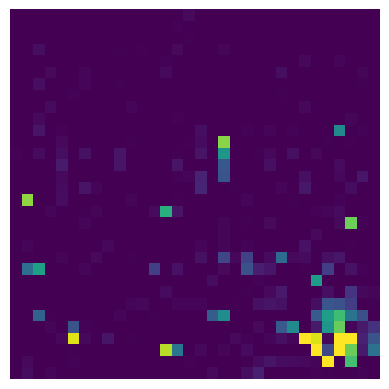

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
reverse_engineer(param = {
    "dataset": "cifar10",
    "Epochs": 100,
    "batch_size": 64,
    "target_label": 9,
    "cost_lambda": 1e-3,
    "num_classes": 10,
    "image_size": (32, 32)}, model = torch.load('model_cifar10_0.15_9.pkl').to(device))